In [87]:
from music21 import converter, note, chord, instrument, meter, roman, stream
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
import warnings
warnings.filterwarnings("ignore")

## 1. Feature Extraction from MIDI Files

Here each MIDI file in the dataset is parsed to extract symbolic musical features such as pitch, duration, polyphony, key signature, and instrument information. These are compiled into a structured DataFrame for further analysis.

In [97]:
def get_midi_features(midi_file, instrument_family_map):
    try:
        # Parse the MIDI file into a music21 stream object
        score = converter.parse(midi_file)

        # Flatten the stream to simplify traversal (all elements at the same level)
        flat = score.flatten()

        # Analyze the global key signature of the piece
        key_signature = flat.analyze('key')
        key_index = key_signature.tonic.pitchClass + (12 if key_signature.mode == 'minor' else 0)

        # Get the first time signature encountered in the score, default to 4/4 if missing
        time_signature = flat.recurse().getElementsByClass(meter.TimeSignature).first()
        time_sig = str(time_signature.ratioString) if time_signature else '4/4'
        time_sig_numerator = time_signature.numerator if time_signature else 4

        features = []  # List to hold feature dictionaries for each musical event
        previous_pitch = None  # To compute interval to previous note

        # Group notes and chords by their onset time to detect polyphony (simultaneous notes)
        offset_dict = {}
        for element in flat.notes:
            offset_dict.setdefault(element.offset, []).append(element)

        # Define helper function to extract instrument name and family from context
        def extract_instrument(element):
            instr_name = "Unknown"
            instr_family = "Other"
            instr = element.getContextByClass(instrument.Instrument)
            if instr and hasattr(instr, 'midiProgram'):
                try:
                    instr_obj = instrument.instrumentFromMidiProgram(instr.midiProgram)
                    instr_name = instr_obj.instrumentName
                    instr_family = instrument_family_map.get(instr_name, "Other") if instrument_family_map else "Other"
                except Exception:
                    pass
            return instr_name, instr_family

        # Iterate over each onset time and the notes/chords sounding at that time
        for offset, simultaneous_notes in offset_dict.items():
            polyphony = len(simultaneous_notes)

            for element in simultaneous_notes:
                instr_name, instr_family = extract_instrument(element)

                # Extract part/track name if available
                track_context = element.getContextByClass(stream.Part)
                track_name = track_context.partName if track_context and hasattr(track_context, 'partName') else 'Unknown'

                # Compute beat position within measure
                beat_position = element.beat
                beat_fraction = beat_position / time_sig_numerator

                # Estimate metric strength (simple heuristic for 4/4)
                metric_weight = {1: 1.0, 2: 0.6, 3: 0.8, 4: 0.4}.get(int(beat_position), 0.3)

                # Get measure number
                measure_number = element.measureNumber if element.measureNumber is not None else 0

                # Estimate local key (new feature)
                try:
                    local_key = element.getContextByClass(key.Key)
                    local_key_index = local_key.tonic.pitchClass + (12 if local_key.mode == 'minor' else 0)
                except Exception:
                    local_key_index = key_index  # fallback to global key

                # Use measure number as proxy for phrase ID (new feature)
                phrase_id = measure_number

                # New feature: is_rest (should be 0 for all current elements, but kept for generality)
                is_rest = 0

                if isinstance(element, note.Note):
                    pitch = element.pitch.midi
                    pitch_class = element.pitch.pitchClass
                    pitch_octave = element.pitch.octave
                    duration = float(element.quarterLength)
                    velocity = element.volume.velocity if element.volume and element.volume.velocity is not None else -1
                    interval_to_prev = abs(pitch - previous_pitch) if previous_pitch is not None else 0
                    previous_pitch = pitch
                    is_chord_tone = 0

                    # Estimate articulation ratio using measure length
                    measure_length = time_signature.barDuration.quarterLength if time_signature else 4.0
                    articulation_ratio = duration / measure_length

                    features.append({
                        'pitch': pitch,
                        'pitch_class': pitch_class,
                        'pitch_octave': pitch_octave,
                        'onset': offset,
                        'duration': duration,
                        'interval_to_prev': interval_to_prev,
                        'polyphony': polyphony,
                        'is_chord_tone': is_chord_tone,
                        'key': key_index,
                        'local_key': local_key_index,
                        'time_signature': time_sig,
                        'measure': measure_number,
                        'beat_position': beat_position,
                        'beat_fraction': beat_fraction,
                        'metric_weight': metric_weight,
                        'articulation_ratio': articulation_ratio,
                        'instrument': instr_name,
                        'instrument_family': instr_family,
                        'track': track_name,
                        'velocity': velocity,
                        'is_rest': is_rest,
                        'phrase_id': phrase_id
                    })

                elif isinstance(element, chord.Chord):
                    duration = float(element.quarterLength)
                    is_chord_tone = 1
                    velocity = element.volume.velocity if element.volume and element.volume.velocity is not None else -1
                    measure_length = time_signature.barDuration.quarterLength if time_signature else 4.0
                    articulation_ratio = duration / measure_length

                    for pitch in [p.midi for p in element.pitches]:
                        pitch_class = pitch % 12
                        pitch_octave = pitch // 12
                        interval_to_prev = abs(pitch - previous_pitch) if previous_pitch is not None else 0
                        previous_pitch = pitch

                        features.append({
                            'pitch': pitch,
                            'pitch_class': pitch_class,
                            'pitch_octave': pitch_octave,
                            'onset': offset,
                            'duration': duration,
                            'interval_to_prev': interval_to_prev,
                            'polyphony': polyphony,
                            'is_chord_tone': is_chord_tone,
                            'key': key_index,
                            'local_key': local_key_index,
                            'time_signature': time_sig,
                            'measure': measure_number,
                            'beat_position': beat_position,
                            'beat_fraction': beat_fraction,
                            'metric_weight': metric_weight,
                            'articulation_ratio': articulation_ratio,
                            'instrument': instr_name,
                            'instrument_family': instr_family,
                            'track': track_name,
                            'velocity': velocity,
                            'is_rest': is_rest,
                            'phrase_id': phrase_id
                        })

        return features

    except Exception as e:
        print(f"[ERROR] Could not parse {midi_file}: {e}")
        return []

In [98]:
# Add instrument family to each event for higher-level grouping (e.g., strings, winds, percussion)
# This enables downstream analysis of timbral or orchestration patterns across genres or pieces

instrument_family_map = {
    # Keyboard
    'Piano': 'Keyboard',
    'Celesta': 'Keyboard',
    'Electric Organ': 'Keyboard',
    'Organ': 'Keyboard',
    'Harpsichord': 'Keyboard',

    # Guitar
    'Acoustic Guitar': 'Guitar',
    'Electric Guitar': 'Guitar',

    # Bass
    'Acoustic Bass': 'Bass',
    'Electric Bass': 'Bass',
    'Fretless Bass': 'Bass',
    'Contrabass': 'Bass',

    # Strings
    'Violoncello': 'Strings',
    'Violin': 'Strings',
    'Viola': 'Strings',
    'Double Bass': 'Strings',
    'StringInstrument': 'Strings',

    # Brass
    'Trumpet': 'Brass',
    'Trombone': 'Brass',
    'French Horn': 'Brass',
    'Tuba': 'Brass',

    # Woodwind
    'Clarinet': 'Woodwind',
    'Bassoon': 'Woodwind',
    'Recorder': 'Woodwind',
    'Piccolo': 'Woodwind',
    'Flute': 'Woodwind',
    'Whistle': 'Woodwind',

    # Percussion
    'Timpani': 'Percussion',
    'Taiko': 'Percussion',
    'Marimba': 'Percussion',
    'Glockenspiel': 'Percussion',
    'Drums': 'Percussion',

    # Voice
    'Voice': 'Voice',
    'Choir': 'Voice',
    'Vocals': 'Voice',
    'Background Vocals': 'Voice',

    # Electronic
    'Sampler': 'Electronic',
    'Synthesizer': 'Electronic',
    'Electric Piano': 'Electronic',
    'Electric Organ': 'Electronic',

    # Other / Catch-all
    'Bagpipes': 'Other',
    'Ocarina': 'Other',
    'Unknown': 'Other',
}

In [99]:
# Define the path to the root folder containing genre-labeled subfolders of MIDI files
root_path = 'data'

# Initialize an empty list to collect feature dictionaries across all files and genres
all_features = []

# Traverse each genre subfolder in the dataset
for genre in os.listdir(root_path):
    genre_path = os.path.join(root_path, genre)
    
    # Skip non-directory files (e.g., stray files in the root directory)
    if not os.path.isdir(genre_path):
        continue

    # Process each MIDI file within the current genre folder
    for file in os.listdir(genre_path):
        if not file.lower().endswith('.mid'):
            continue  # Ignore non-MIDI files

        file_path = os.path.join(genre_path, file)

        # Extract symbolic musical features from the current MIDI file
        features = get_midi_features(file_path, instrument_family_map)

        # Append genre label and filename metadata to each feature row
        for feature in features:
            feature['genre'] = genre
            feature['filename'] = file
            all_features.append(feature)

# Aggregate all extracted features into a structured pandas DataFrame
df = pd.DataFrame(all_features)

# Display the first few rows for inspection
df.head()

pitch  pitch_class  pitch_octave onset  duration  interval_to_prev  \
0     27            3             1   4.0      0.75                 0   
1     39            3             2   4.0      0.75                12   
2     27            3             1   4.0      0.75                12   
3     39            3             2   4.0      0.75                12   
4     79            7             5   5.0      0.50                40   

   polyphony  is_chord_tone  key  local_key  ... metric_weight  \
0          4              0    3          3  ...           1.0   
1          4              0    3          3  ...           1.0   
2          4              0    3          3  ...           1.0   
3          4              0    3          3  ...           1.0   
4          2              0    3          3  ...           0.6   

   articulation_ratio instrument instrument_family           track  velocity  \
0              0.1875    Sampler        Electronic  I AM CANADIAN!       127   
1              0.1875    Sampler        Electronic  I AM CANADIAN!       127   
2              0.1875    Sampler        Electronic  I AM CANADIAN!       108   
3              0.1875    Sampler        Electronic  I AM CANADIAN!        92   
4              0.1250    Sampler        Electronic  I AM CANADIAN!       127   

  is_rest phrase_id genre                              filename  
0       0         2   pop  Come On Over (All I Want Is You).mid  
1       0         2   pop  Come On Over (All I Want Is You).mid  
2       0         2   pop  Come On Over (All I Want Is You).mid  
3       0         2   pop  Come On Over (All I Want Is You).mid  
4       0         2   pop  Come On Over (All I Want Is You).mid  

[5 rows x 24 columns]

---

## 2. Data Quality Assessment

Here a preliminary audit of the extracted MIDI features is performed to ensure structural integrity, identify potential anomalies, and confirm the plausibility of musical attributes such as pitch, duration, key, and instrumentation.

### 2.1 Missing Data Analysis

In [100]:
# Check for missing values
df.isnull().sum()

pitch                    0
pitch_class              0
pitch_octave             0
onset                    0
duration                 0
interval_to_prev         0
polyphony                0
is_chord_tone            0
key                      0
local_key                0
time_signature           0
measure                  0
beat_position            0
beat_fraction            0
metric_weight            0
articulation_ratio       0
instrument               0
instrument_family        0
track                 4062
velocity                 0
is_rest                  0
phrase_id                0
genre                    0
filename                 0
dtype: int64

### 2.2 Summary Statistics

In [101]:
# Summary statistics for numerical columns
df.describe()

pitch    pitch_class   pitch_octave       duration  \
count  192192.000000  192192.000000  192192.000000  192192.000000   
mean       58.926469       5.541729       4.103459       0.630714   
std        13.160204       3.433102       1.332416       0.719770   
min         0.000000       0.000000      -1.000000       0.000000   
25%        52.000000       3.000000       3.000000       0.250000   
50%        61.000000       6.000000       4.000000       0.333333   
75%        67.000000       9.000000       5.000000       0.666667   
max       126.000000      11.000000      10.000000      12.000000   

       interval_to_prev      polyphony  is_chord_tone            key  \
count     192192.000000  192192.000000  192192.000000  192192.000000   
mean          11.667582       3.983355       0.654731      10.325523   
std           11.094037       2.403797       0.475457       6.610722   
min            0.000000       1.000000       0.000000       0.000000   
25%            4.000000       2.000000       0.000000       5.000000   
50%            7.000000       4.000000       1.000000      11.000000   
75%           17.000000       5.000000       1.000000      16.000000   
max           93.000000      17.000000       1.000000      23.000000   

           local_key        measure  metric_weight  articulation_ratio  \
count  192192.000000  192192.000000  192192.000000       192192.000000   
mean       10.325523      77.063489       0.729276            0.162650   
std         6.610722      57.363941       0.227864            0.190870   
min         0.000000       1.000000       0.300000            0.000000   
25%         5.000000      35.000000       0.600000            0.062500   
50%        11.000000      65.000000       0.800000            0.111111   
75%        16.000000     104.000000       1.000000            0.166667   
max        23.000000     393.000000       1.000000            3.000000   

            velocity   is_rest      phrase_id  
count  192192.000000  192192.0  192192.000000  
mean       91.374006       0.0      77.063489  
std        24.042930       0.0      57.363941  
min         1.000000       0.0       1.000000  
25%        79.000000       0.0      35.000000  
50%        96.000000       0.0      65.000000  
75%       108.000000       0.0     104.000000  
max       127.000000       0.0     393.000000

#### 2.2.1 Correlation Matrix

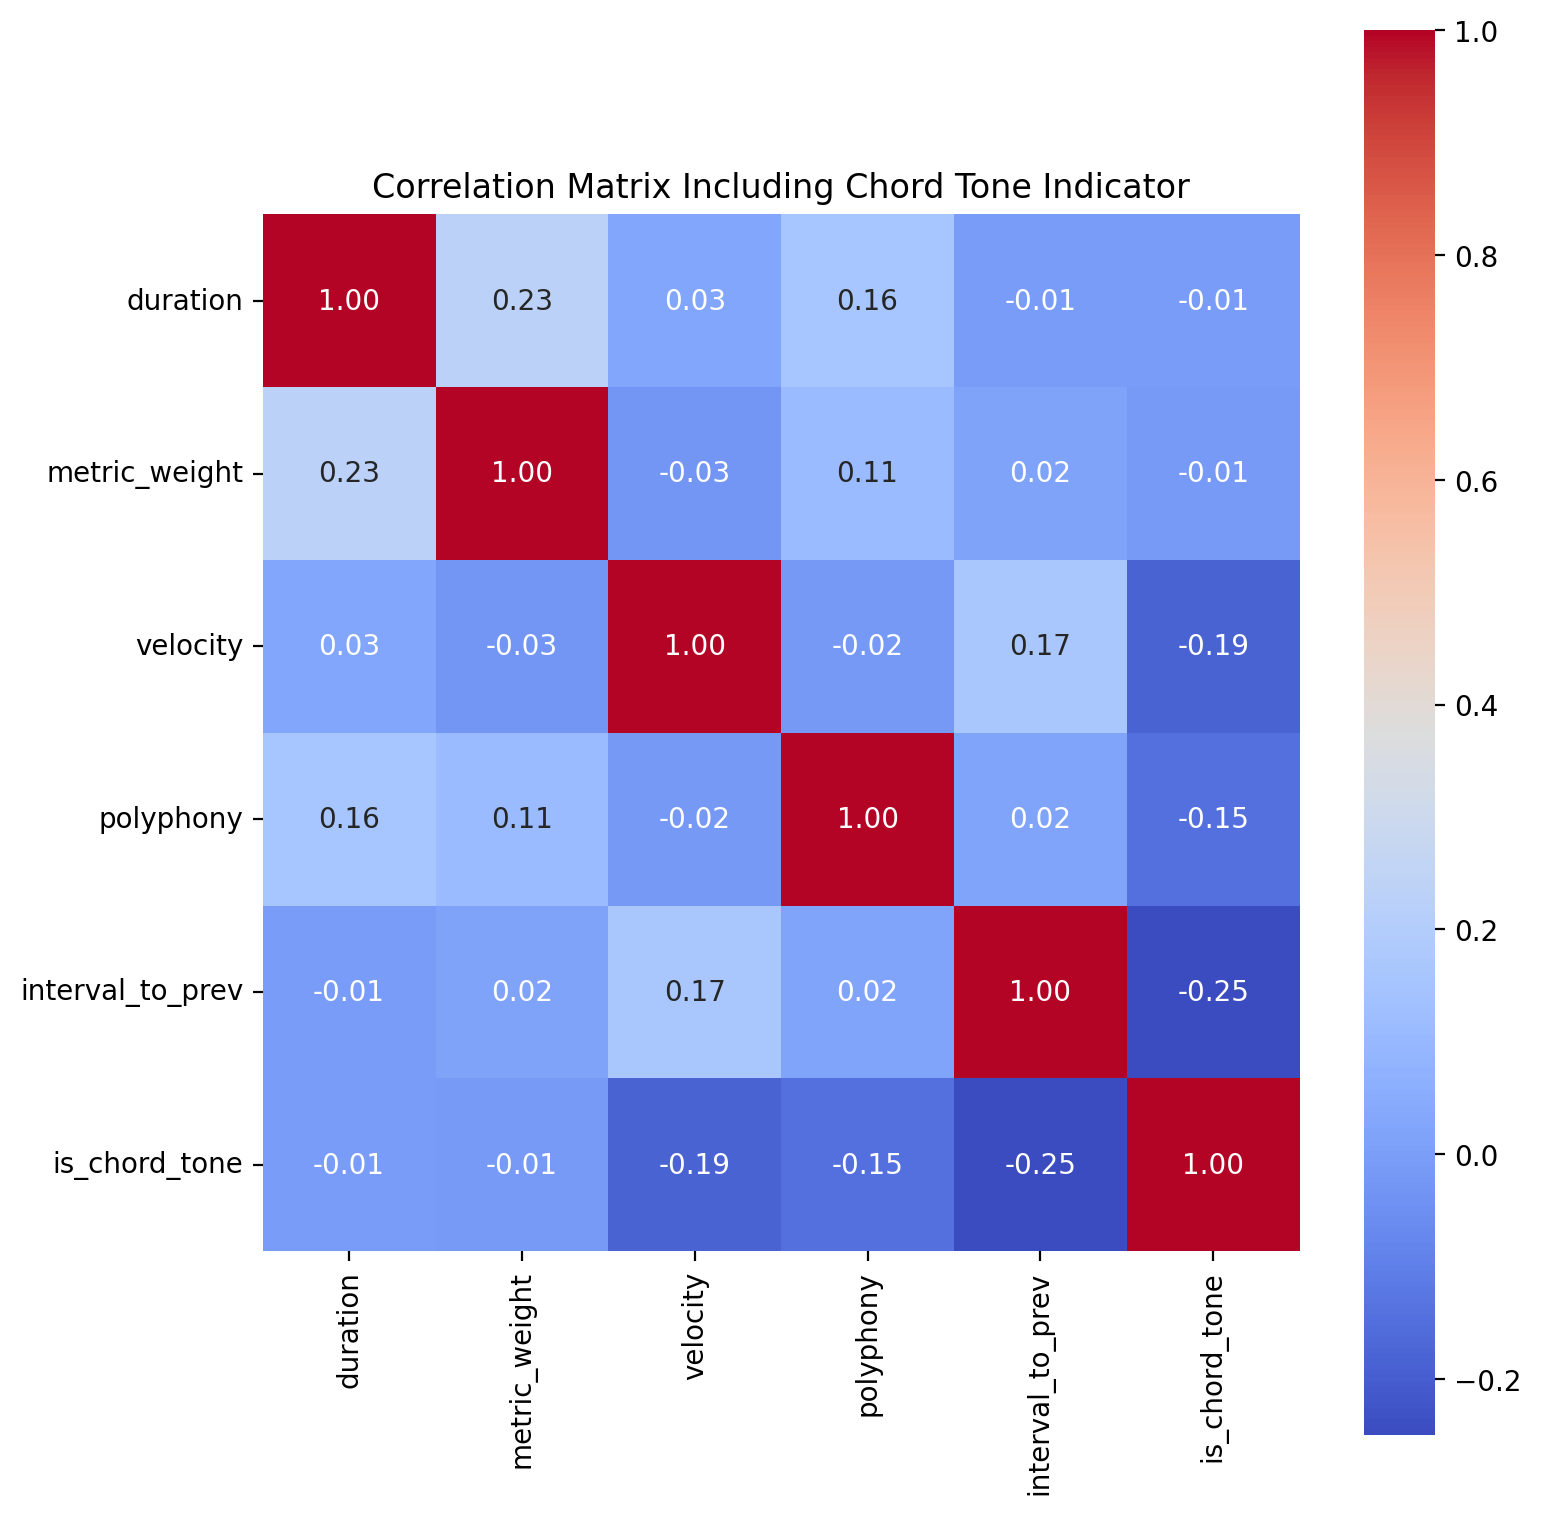

In [288]:
# Compute correlation with other numeric features
numerical_cols = ['duration', 'metric_weight', 'velocity', 'polyphony', 'interval_to_prev', 'is_chord_tone']
correlation_matrix = df[numerical_cols].corr()

# Plot
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix Including Chord Tone Indicator")
plt.tight_layout()
plt.show()

### 2.3 Feature-wise Distribution and Outlier Analysis

#### 2.3.1 Pitch

##### 2.3.1.1 Central Tendency and Spread of Pitch Values

In [102]:
# Central tendency
mean_pitch = df['pitch'].mean()
median_pitch = df['pitch'].median()
mode_pitch = df['pitch'].mode()[0]  

# Spread
std_pitch = df['pitch'].std()

# Display results
print(f"Mean pitch: {mean_pitch:.2f}")
print(f"Median pitch: {median_pitch}")
print(f"Mode pitch: {mode_pitch}")
print(f"Standard deviation: {std_pitch:.2f}")

Mean pitch: 58.93
Median pitch: 61.0
Mode pitch: 67
Standard deviation: 13.16


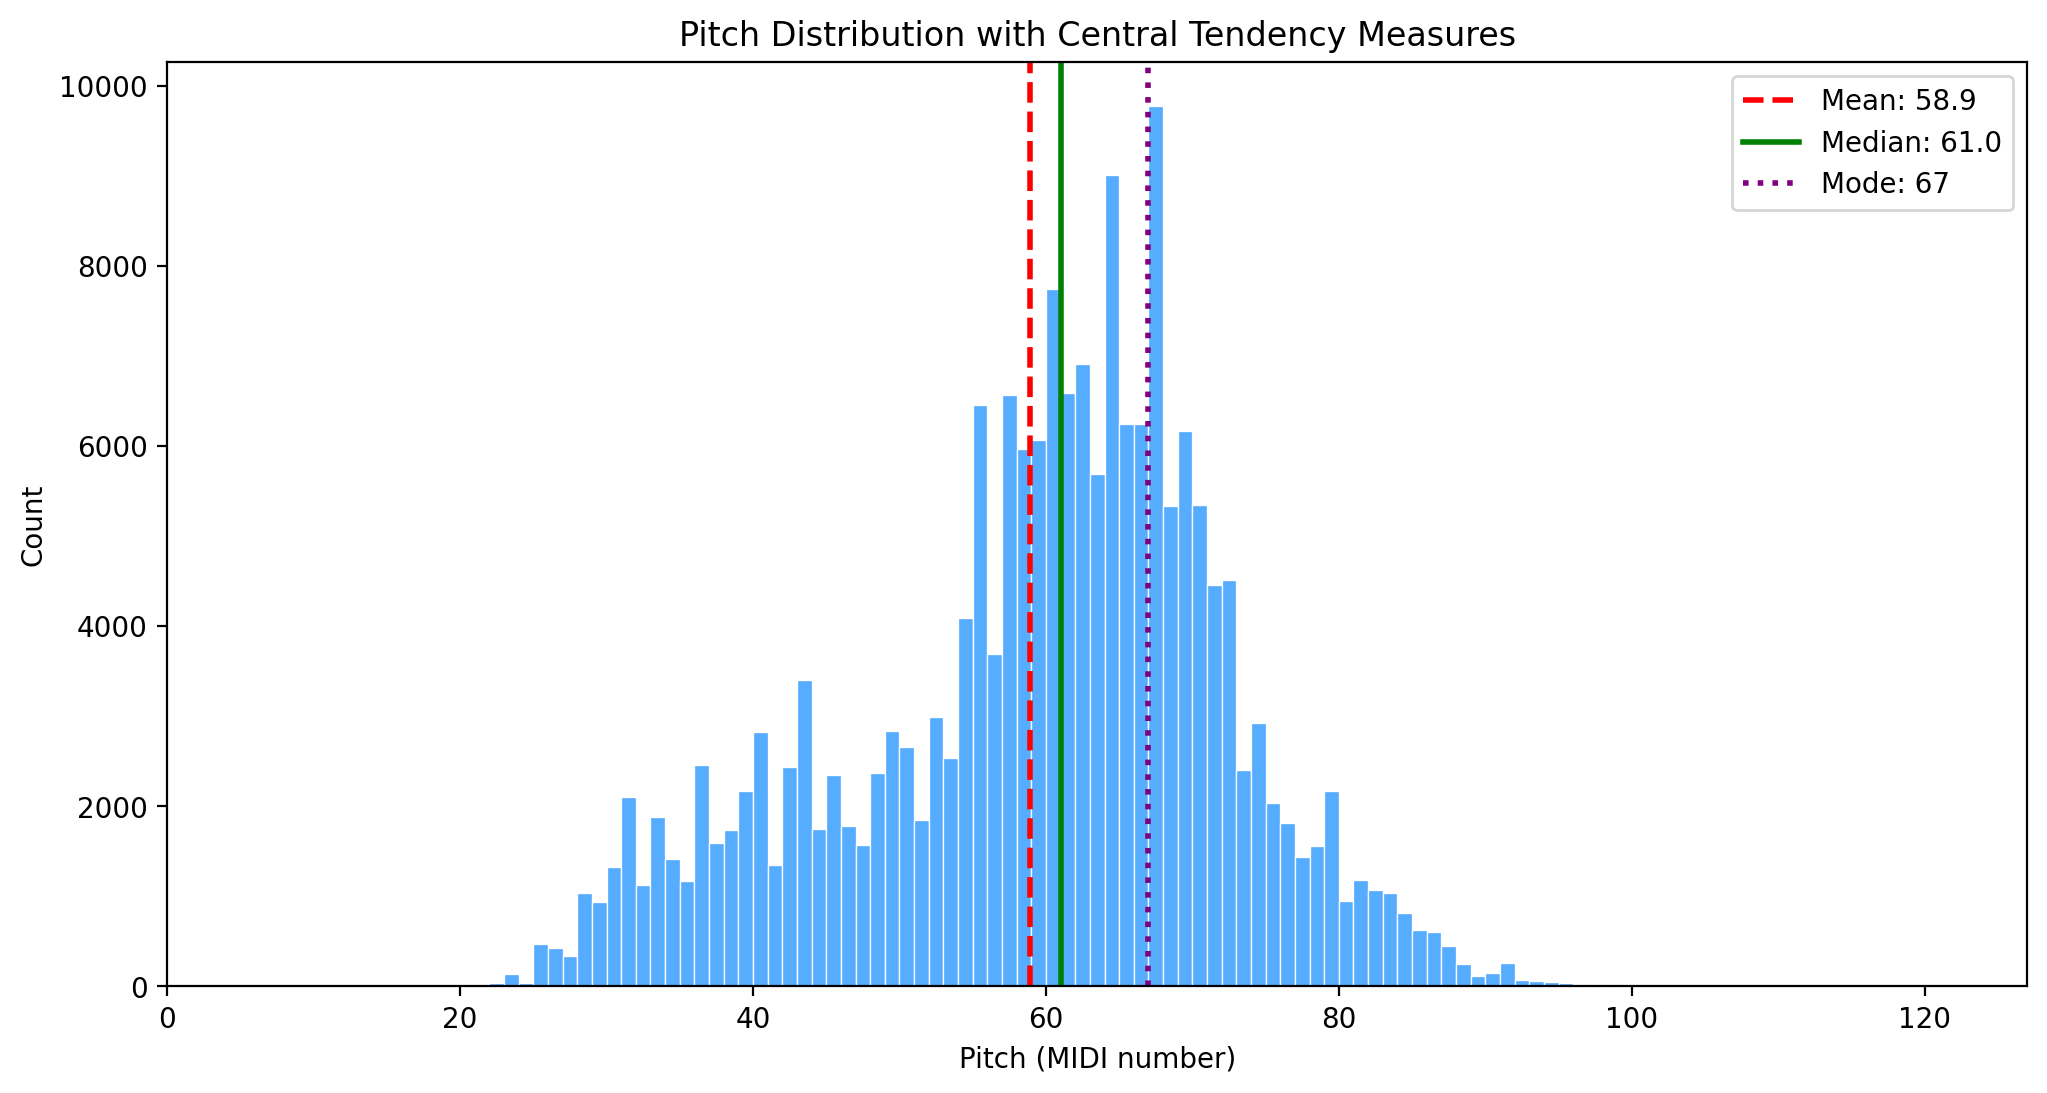

In [103]:
plt.figure(figsize=(12, 6))
sns.histplot(df['pitch'], bins=range(0, 128), color='dodgerblue', edgecolor='white')

# Add lines for mean, median, and mode
plt.axvline(mean_pitch, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_pitch:.1f}')
plt.axvline(median_pitch, color='green', linestyle='-', linewidth=2, label=f'Median: {median_pitch}')
plt.axvline(mode_pitch, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_pitch}')

plt.title('Pitch Distribution with Central Tendency Measures')
plt.xlabel('Pitch (MIDI number)')
plt.ylabel('Count')
plt.xlim(0, 127)
plt.legend()
plt.show()

##### 2.3.1.2 Outlier Detection in Pitch Values

In [104]:
# Confirm all values are within the valid MIDI range
valid_range = df['pitch'].between(0, 127)
invalid_pitches = df[~valid_range]

print(f"Number of invalid pitch values: {len(invalid_pitches)}")


# Count how many values are at the extreme edges
low_extremes = df[df['pitch'] <= 10]
high_extremes = df[df['pitch'] >= 120]

print(f"Pitches ≤ 10: {len(low_extremes)}")
print(f"Pitches ≥ 120: {len(high_extremes)}")

Number of invalid pitch values: 0
Pitches ≤ 10: 1
Pitches ≥ 120: 9


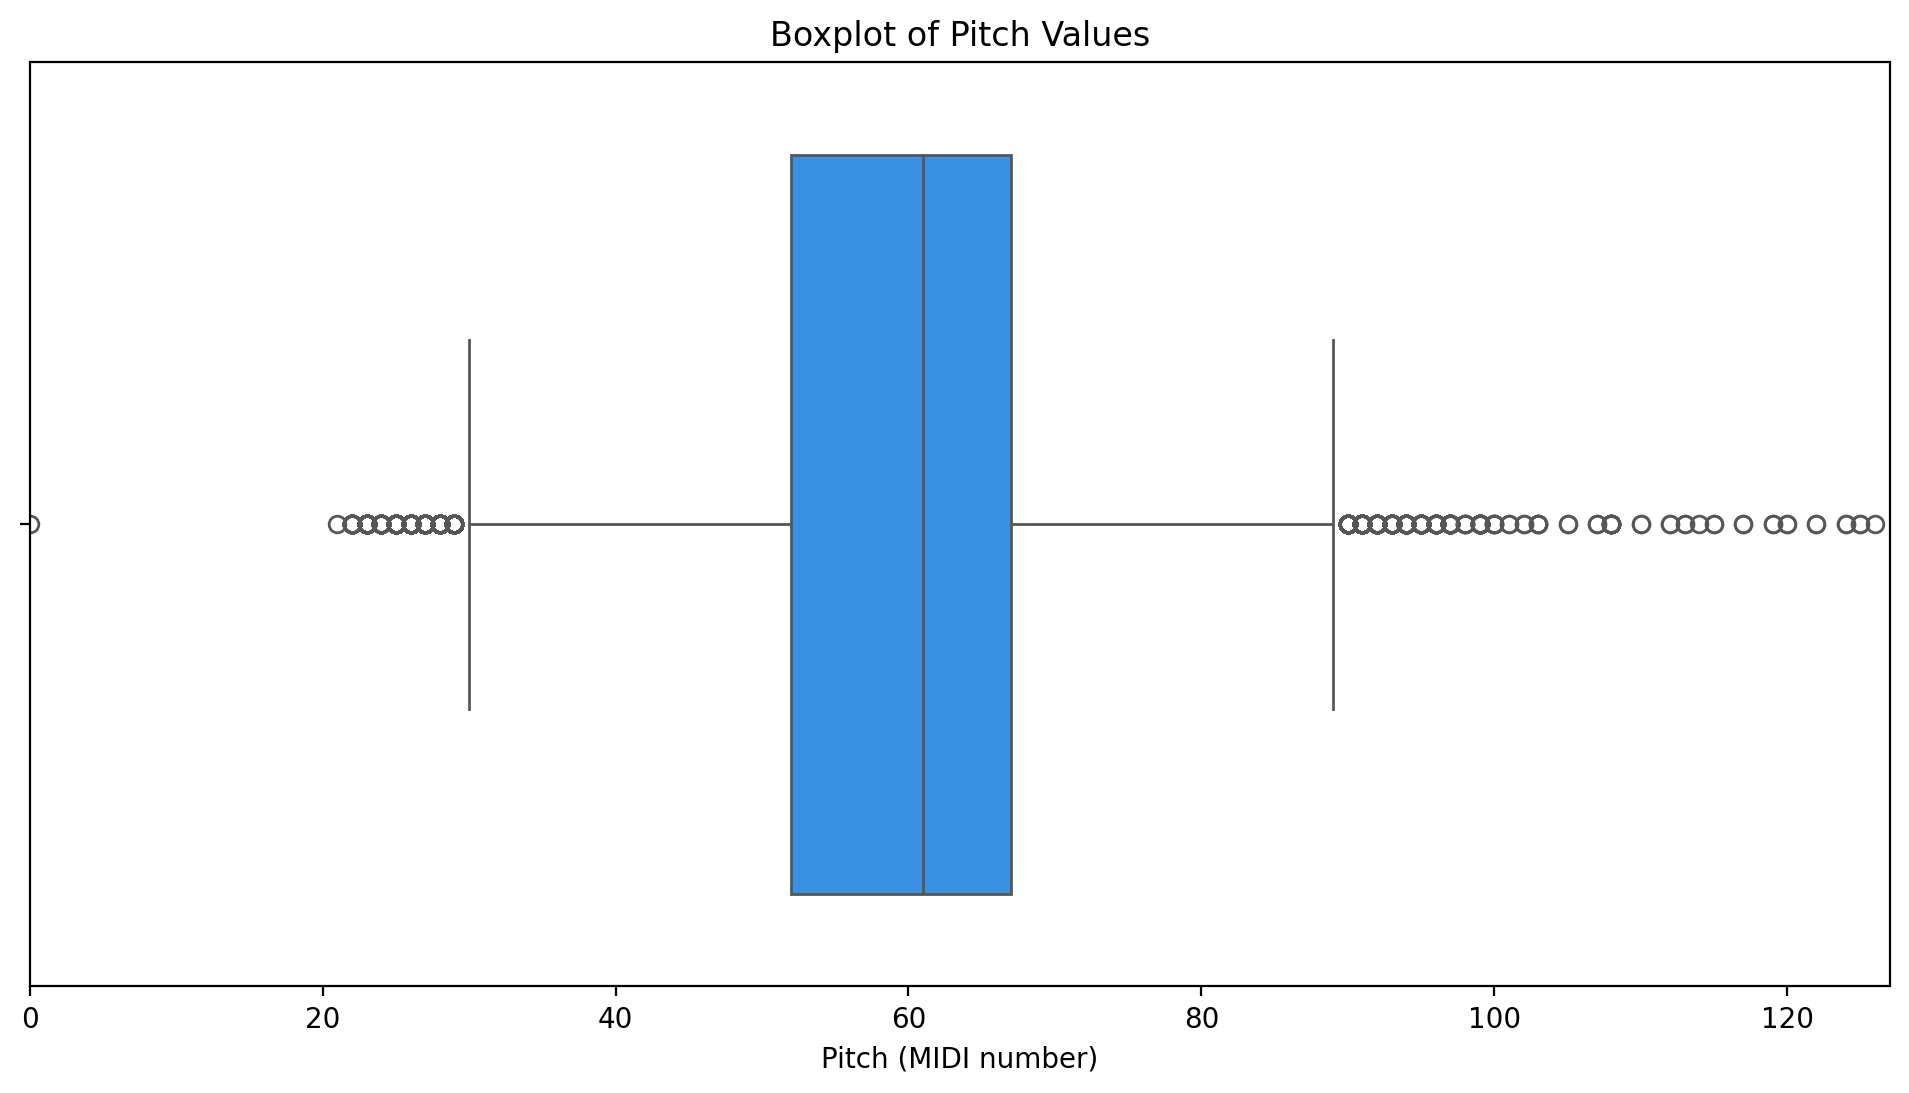

In [105]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['pitch'], color='dodgerblue')
plt.title('Boxplot of Pitch Values')
plt.xlabel('Pitch (MIDI number)')
plt.xlim(0, 127)
plt.show()

##### 2.3.1.3 Distribution of Pitch Values over Time

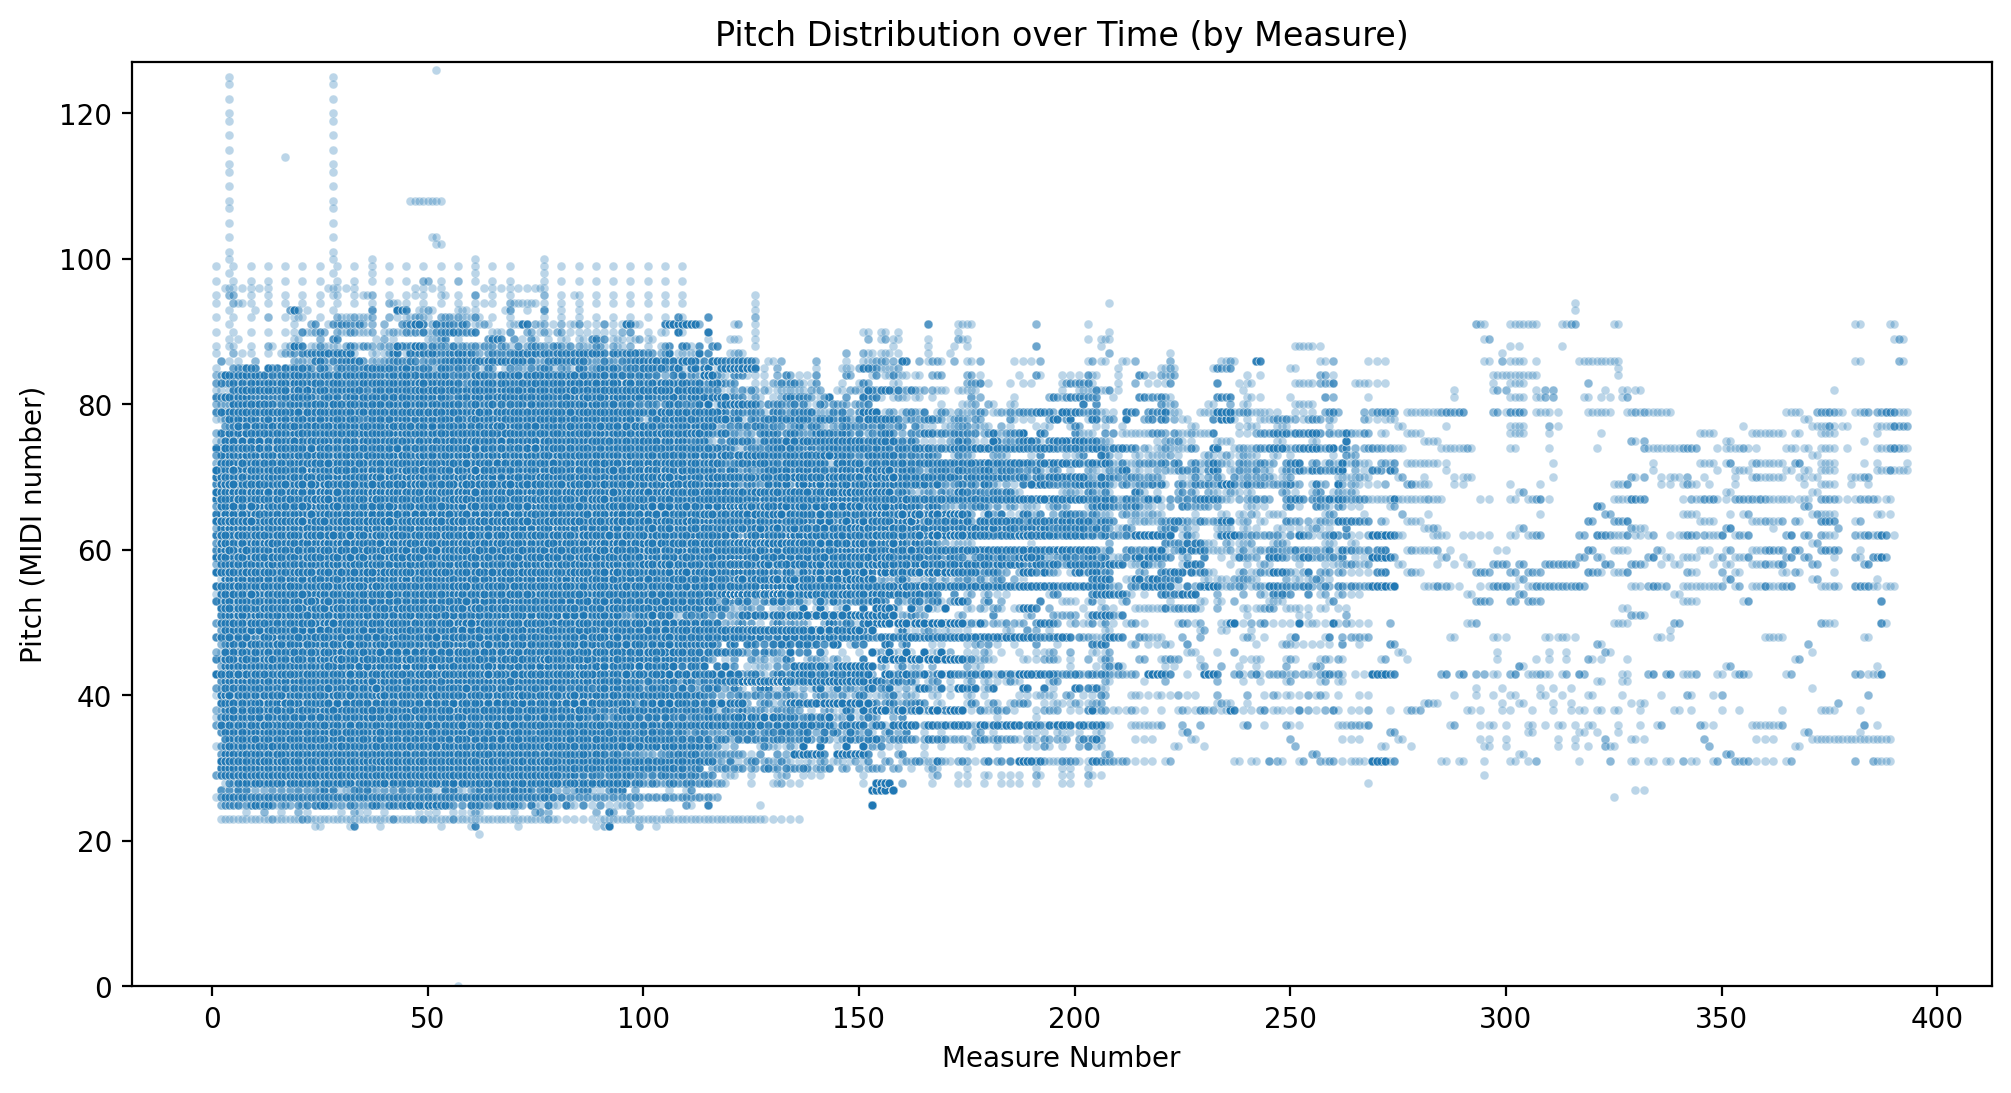

In [106]:
# Confirm global temporal coherence and get visual summary of pitch activity density across the piece's duration

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='measure', y='pitch', alpha=0.3, s=10)
plt.title('Pitch Distribution over Time (by Measure)')
plt.xlabel('Measure Number')
plt.ylabel('Pitch (MIDI number)')
plt.ylim(0, 127)
plt.show()

##### 2.3.1.4 Pitch Values in Context: Key, Instrument, and Genre

In [107]:
# Descriptive statistics of pitch values by key
print("Pitch statistics by Key:")
df.groupby('key')['pitch'].describe().sort_index()

Pitch statistics by Key:


count       mean        std   min   25%   50%   75%    max
key                                                              
0    11608.0  60.164197  12.061647  26.0  55.0  62.0  67.0   94.0
1     8535.0  59.241593  12.281938  25.0  54.0  61.0  68.0   85.0
2     5075.0  51.538128  12.461904  28.0  42.0  52.0  62.0   80.0
3    13501.0  57.650174  13.575170  22.0  45.0  60.0  68.0   89.0
4     8834.0  61.718021  12.814249  25.0  59.0  64.0  68.0  103.0
5    17733.0  59.695370  13.625962  24.0  54.0  63.0  70.0   96.0
6     4806.0  60.663337  11.850484  25.0  56.0  61.0  68.0   85.0
7    10897.0  63.209966  12.839228  31.0  55.0  64.0  74.0   88.0
9     3344.0  54.743122  15.504270  28.0  45.0  52.0  62.0   93.0
11   24410.0  58.577796  12.794475   0.0  52.0  61.0  66.0   95.0
12    7224.0  57.737265   9.321962  27.0  55.0  60.0  65.0   75.0
13    9294.0  56.024209  14.211737  25.0  45.0  56.0  67.0   97.0
14    7794.0  57.113036  13.656655  26.0  50.0  60.0  65.0  125.0
15    1626.0  53.984010  11.532845  37.0  46.0  54.0  58.0   87.0
16   19702.0  60.280479  12.120355  26.0  55.0  62.0  67.0  126.0
17    7936.0  62.667969  11.327446  24.0  56.0  63.0  70.0   96.0
19   16036.0  57.803754  14.598964  21.0  50.0  62.0  67.0  108.0
21    8261.0  57.831739  14.511505  28.0  45.0  58.0  67.0   91.0
23    5576.0  58.076937  11.748531  27.0  49.0  61.0  66.0   91.0

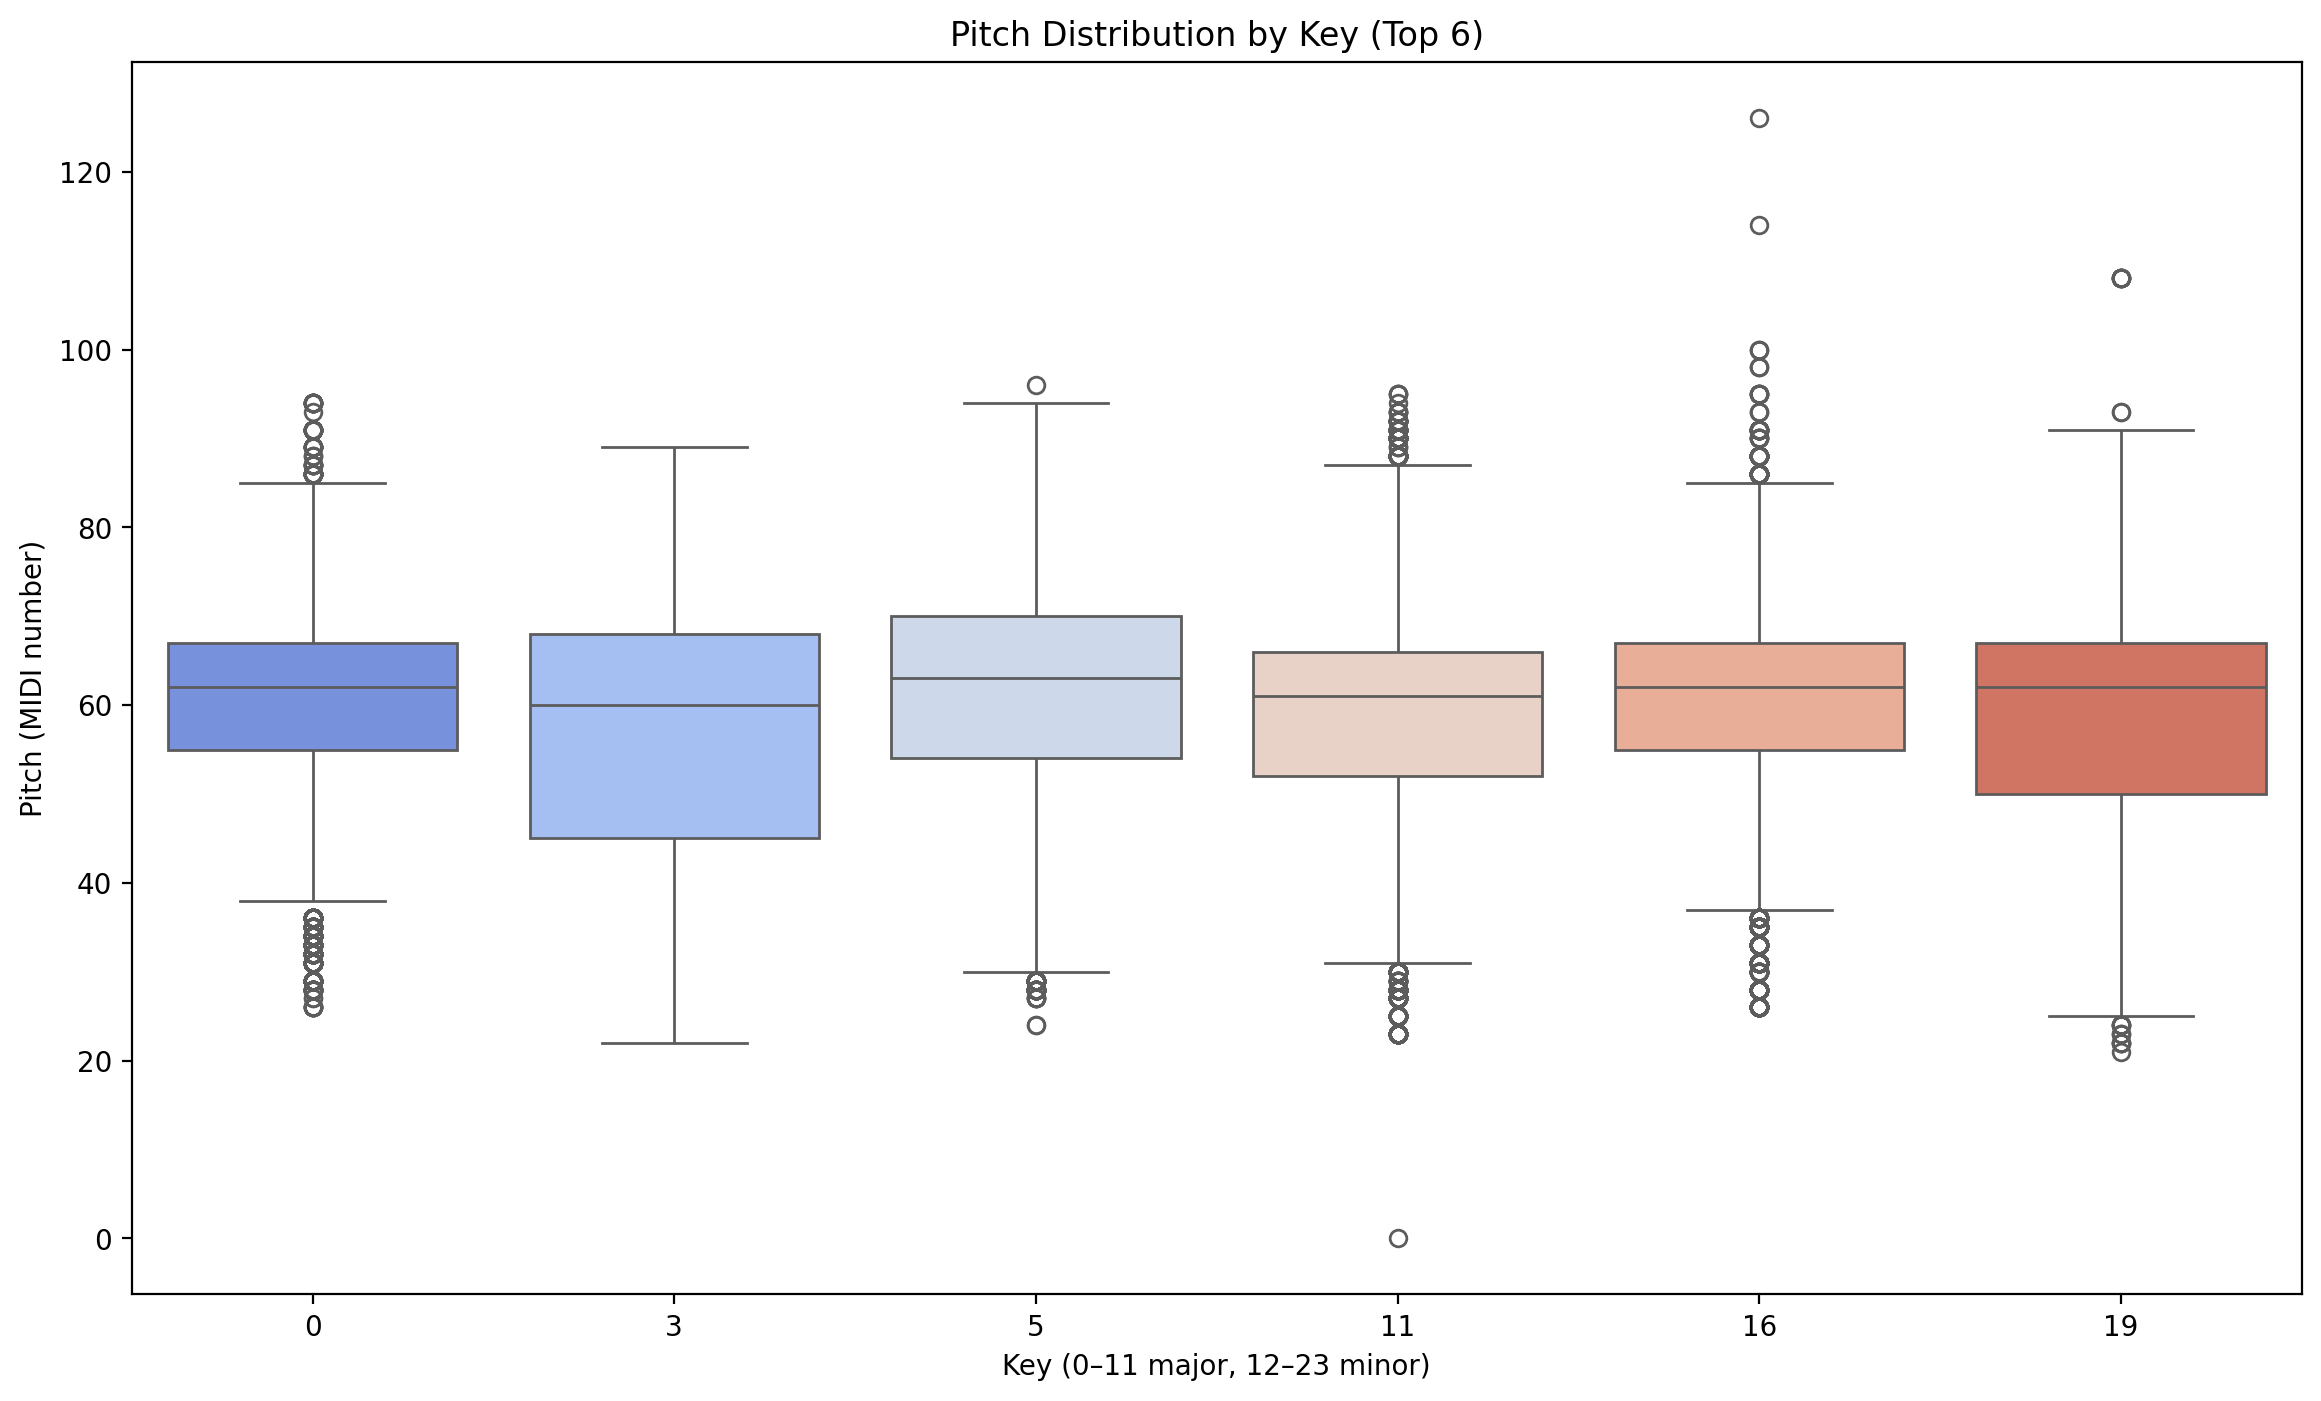

In [108]:
# Pitch distribution across top 6 keys to show tonal variation.
top_keys = df['key'].value_counts().nlargest(6).index

plt.figure(figsize=(14,8))
sns.boxplot(data=df[df['key'].isin(top_keys)], x='key', y='pitch', palette='coolwarm')
plt.title('Pitch Distribution by Key (Top 6)')
plt.xlabel('Key (0–11 major, 12–23 minor)')
plt.ylabel('Pitch (MIDI number)')
plt.show()

In [109]:
# Descriptive statistics of pitch values by instrument
print("Pitch statistics by Instrument:")
df.groupby('instrument')['pitch'].describe()

Pitch statistics by Instrument:


count       mean        std   min   25%   50%   75%    max
instrument                                                                    
Acoustic Bass     11262.0  58.854644  11.072530  25.0  54.0  61.0  66.0   85.0
Acoustic Guitar   18001.0  57.747292  11.193404  23.0  49.0  59.0  66.0   95.0
Bagpipes           4865.0  61.319219  13.356028  25.0  56.0  65.0  70.0   85.0
Bassoon            1729.0  62.702718  12.618631  31.0  50.0  67.0  72.0   83.0
Celesta            8514.0  58.845431  13.070046  26.0  55.0  60.0  67.0  126.0
Choir              2984.0  54.846180  13.325125  29.0  44.0  58.0  66.0   85.0
Clarinet            998.0  59.876754  15.863189  25.0  49.0  68.0  68.0  103.0
Contrabass         9168.0  63.305628  12.878847  31.0  55.0  64.0  74.0   88.0
Electric Bass       647.0  57.649150  10.621358  30.0  49.0  61.0  66.0   78.0
Electric Guitar   21454.0  58.350750  12.722474   0.0  53.0  62.0  67.0   95.0
Electric Organ     2280.0  57.885088  16.752776  29.0  42.0  61.0  70.0   93.0
Fretless Bass      4777.0  61.051078  13.257560  29.0  53.0  63.0  72.0   91.0
Glockenspiel        133.0  66.894737  15.425413  30.0  63.0  68.0  78.0   85.0
Marimba             235.0  58.034043   6.708754  45.0  52.0  60.0  64.0   69.0
Ocarina             575.0  62.013913  15.370788  29.0  49.0  60.0  77.0   85.0
Piano             38177.0  58.436519  12.207215  25.0  52.0  60.0  67.0  125.0
Piccolo            1462.0  61.759234  10.982447  38.0  57.0  59.0  69.0   91.0
Recorder           1097.0  69.699180  12.904079  45.0  60.0  69.0  81.0   92.0
Sampler           23546.0  55.705045  15.345870  22.0  43.0  57.0  67.0   96.0
StringInstrument   4078.0  54.941883  12.620547  25.0  46.0  57.0  64.0   91.0
Taiko                61.0  64.311475   5.185046  42.0  61.0  64.0  66.0   78.0
Timpani            1450.0  58.400000   9.040054  31.0  54.0  57.0  64.0   83.0
Trombone           4529.0  57.551998  10.152873  21.0  52.0  59.0  65.0   82.0
Trumpet             105.0  70.866667  10.880528  49.0  64.0  73.0  80.0   86.0
Unknown           14549.0  62.888721  13.154145  23.0  56.0  64.0  72.0   97.0
Violoncello         360.0  49.011111  11.137524  25.0  44.0  51.0  57.0   69.0
Voice             11500.0  61.849478  12.167564  24.0  59.0  64.0  68.0   99.0
Whistle            3656.0  56.457330  18.323744  26.0  31.0  65.0  69.0  108.0

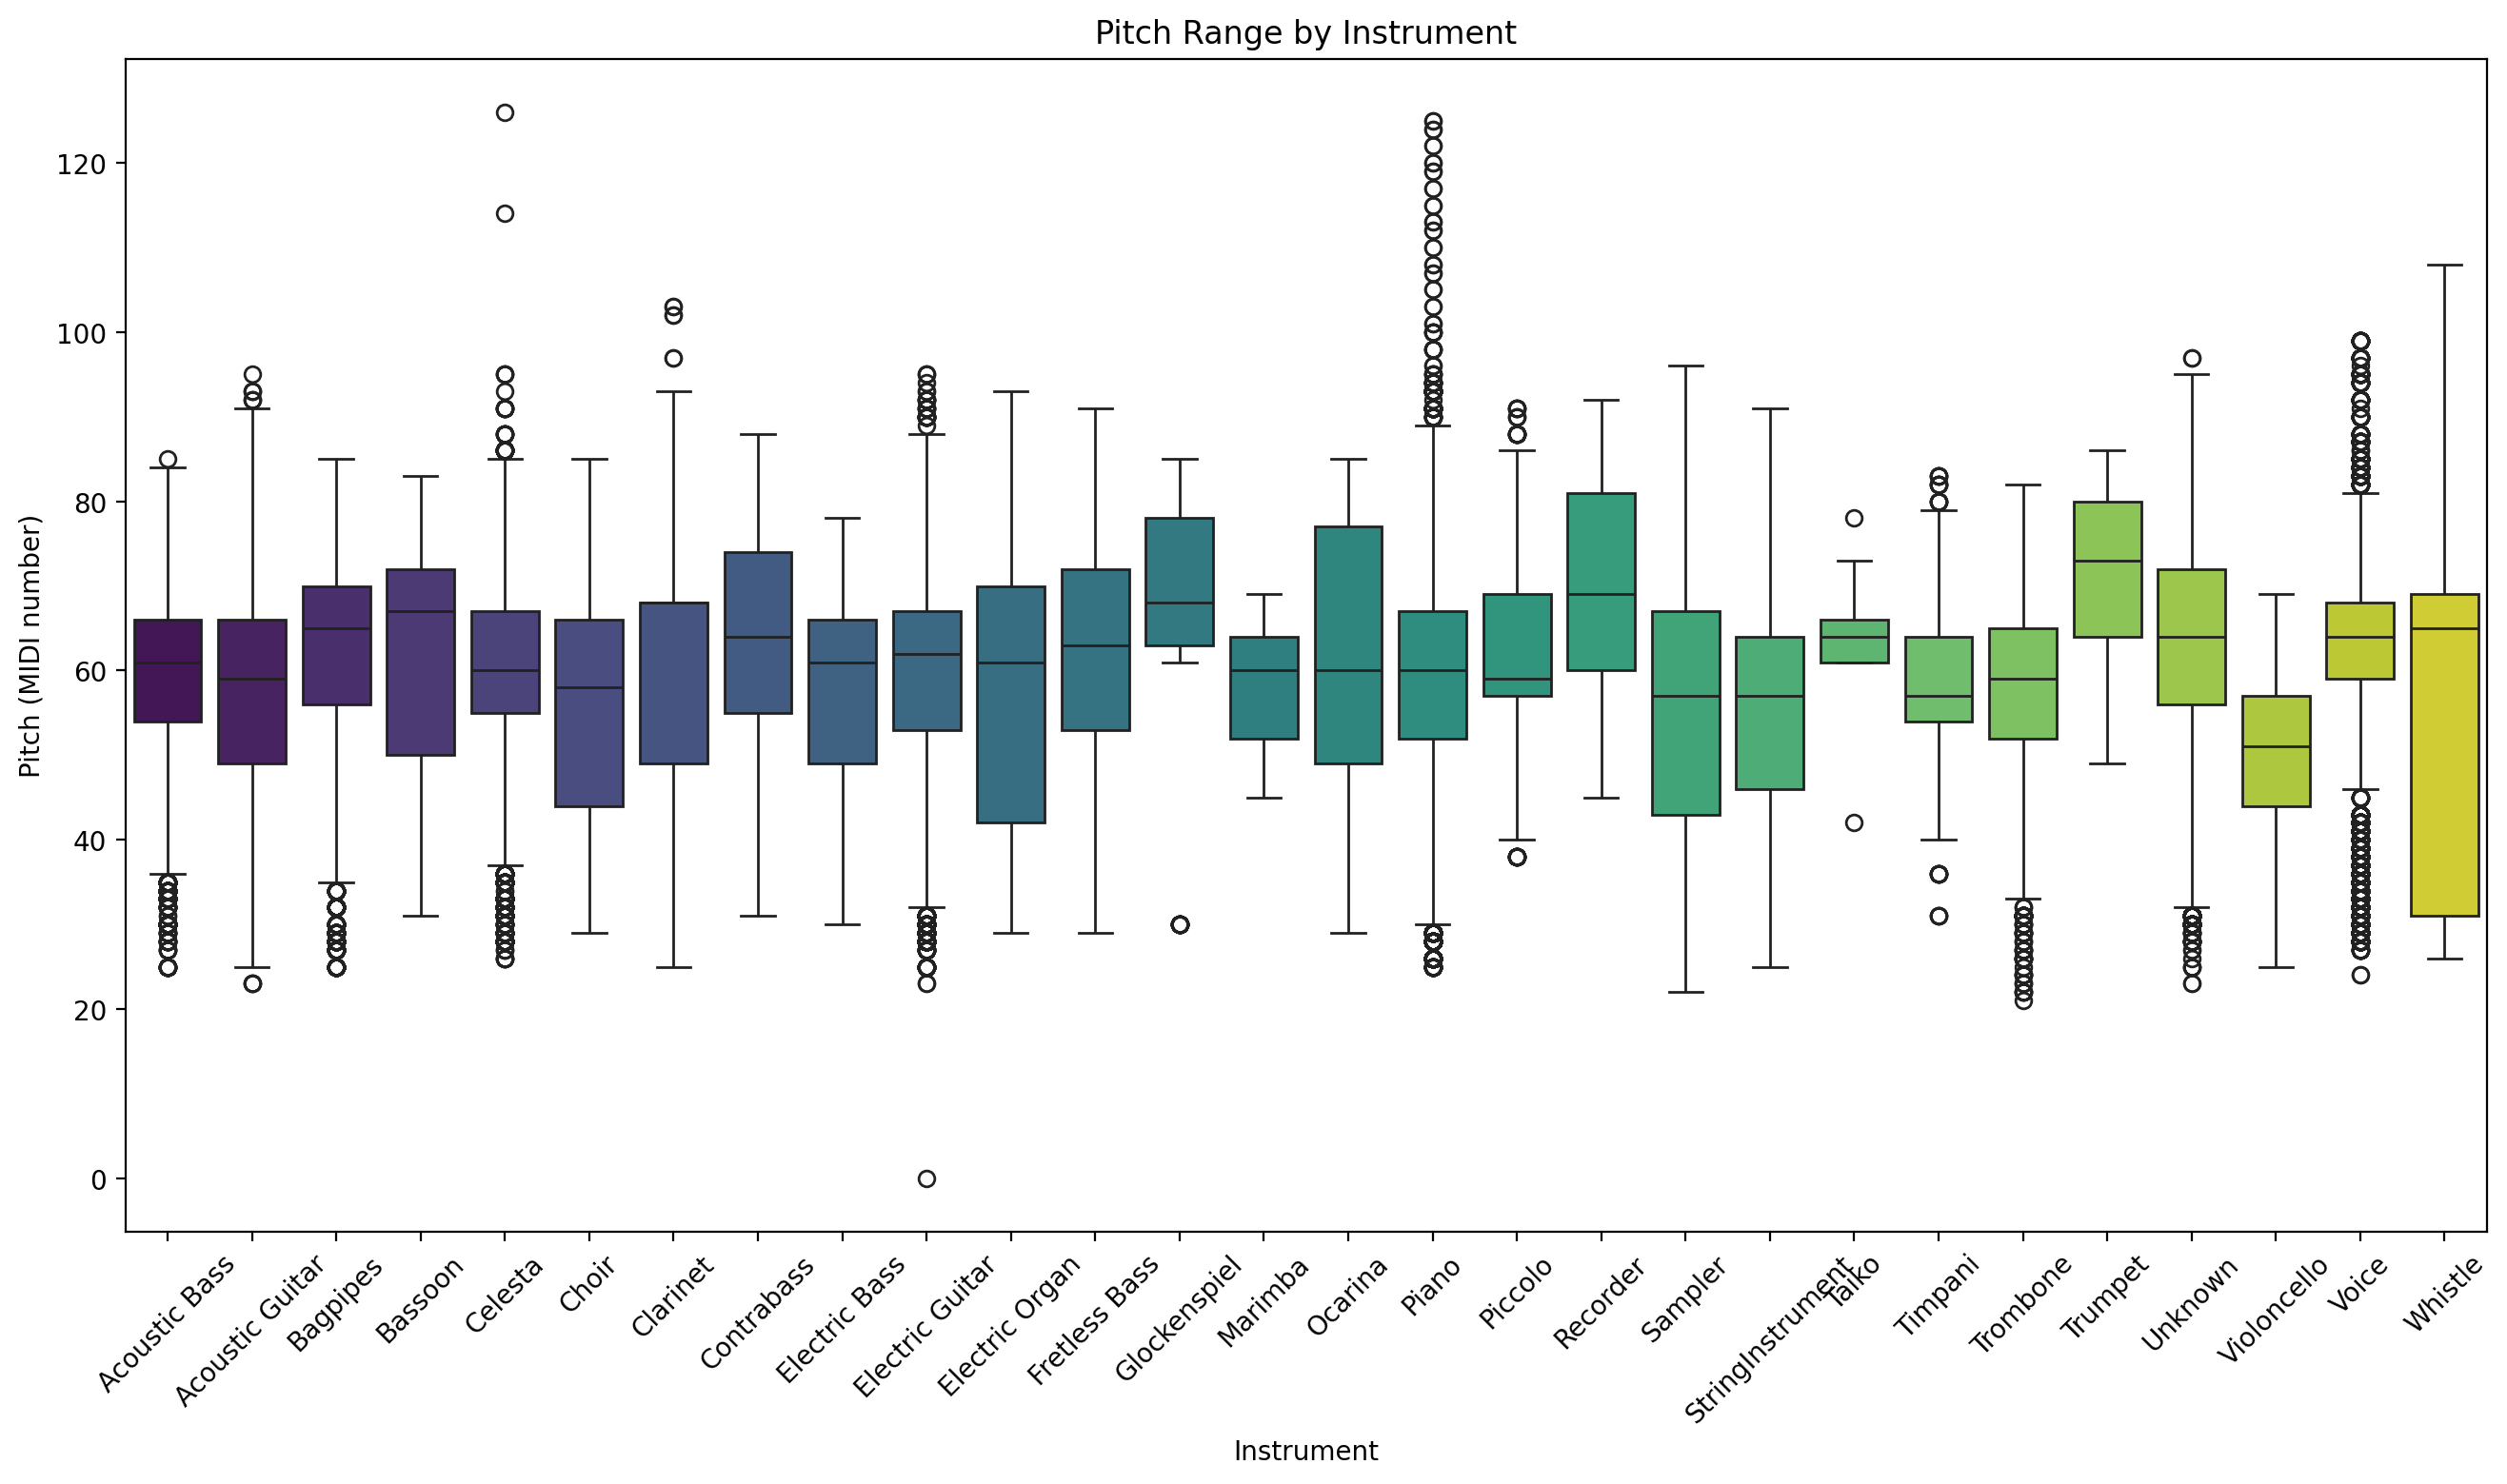

In [110]:
alphabetic_order = sorted(df['instrument'].unique())

plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='instrument', y='pitch', palette='viridis', order=alphabetic_order)
plt.xticks(rotation=45)
plt.title('Pitch Range by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Pitch (MIDI number)')
plt.show()

In [111]:
# Descriptive statistics of pitch values by instrument family
print("Pitch statistics by Instrument Family:")
df.groupby('instrument')['pitch'].describe()

Pitch statistics by Instrument Family:


count       mean        std   min   25%   50%   75%    max
instrument                                                                    
Acoustic Bass     11262.0  58.854644  11.072530  25.0  54.0  61.0  66.0   85.0
Acoustic Guitar   18001.0  57.747292  11.193404  23.0  49.0  59.0  66.0   95.0
Bagpipes           4865.0  61.319219  13.356028  25.0  56.0  65.0  70.0   85.0
Bassoon            1729.0  62.702718  12.618631  31.0  50.0  67.0  72.0   83.0
Celesta            8514.0  58.845431  13.070046  26.0  55.0  60.0  67.0  126.0
Choir              2984.0  54.846180  13.325125  29.0  44.0  58.0  66.0   85.0
Clarinet            998.0  59.876754  15.863189  25.0  49.0  68.0  68.0  103.0
Contrabass         9168.0  63.305628  12.878847  31.0  55.0  64.0  74.0   88.0
Electric Bass       647.0  57.649150  10.621358  30.0  49.0  61.0  66.0   78.0
Electric Guitar   21454.0  58.350750  12.722474   0.0  53.0  62.0  67.0   95.0
Electric Organ     2280.0  57.885088  16.752776  29.0  42.0  61.0  70.0   93.0
Fretless Bass      4777.0  61.051078  13.257560  29.0  53.0  63.0  72.0   91.0
Glockenspiel        133.0  66.894737  15.425413  30.0  63.0  68.0  78.0   85.0
Marimba             235.0  58.034043   6.708754  45.0  52.0  60.0  64.0   69.0
Ocarina             575.0  62.013913  15.370788  29.0  49.0  60.0  77.0   85.0
Piano             38177.0  58.436519  12.207215  25.0  52.0  60.0  67.0  125.0
Piccolo            1462.0  61.759234  10.982447  38.0  57.0  59.0  69.0   91.0
Recorder           1097.0  69.699180  12.904079  45.0  60.0  69.0  81.0   92.0
Sampler           23546.0  55.705045  15.345870  22.0  43.0  57.0  67.0   96.0
StringInstrument   4078.0  54.941883  12.620547  25.0  46.0  57.0  64.0   91.0
Taiko                61.0  64.311475   5.185046  42.0  61.0  64.0  66.0   78.0
Timpani            1450.0  58.400000   9.040054  31.0  54.0  57.0  64.0   83.0
Trombone           4529.0  57.551998  10.152873  21.0  52.0  59.0  65.0   82.0
Trumpet             105.0  70.866667  10.880528  49.0  64.0  73.0  80.0   86.0
Unknown           14549.0  62.888721  13.154145  23.0  56.0  64.0  72.0   97.0
Violoncello         360.0  49.011111  11.137524  25.0  44.0  51.0  57.0   69.0
Voice             11500.0  61.849478  12.167564  24.0  59.0  64.0  68.0   99.0
Whistle            3656.0  56.457330  18.323744  26.0  31.0  65.0  69.0  108.0

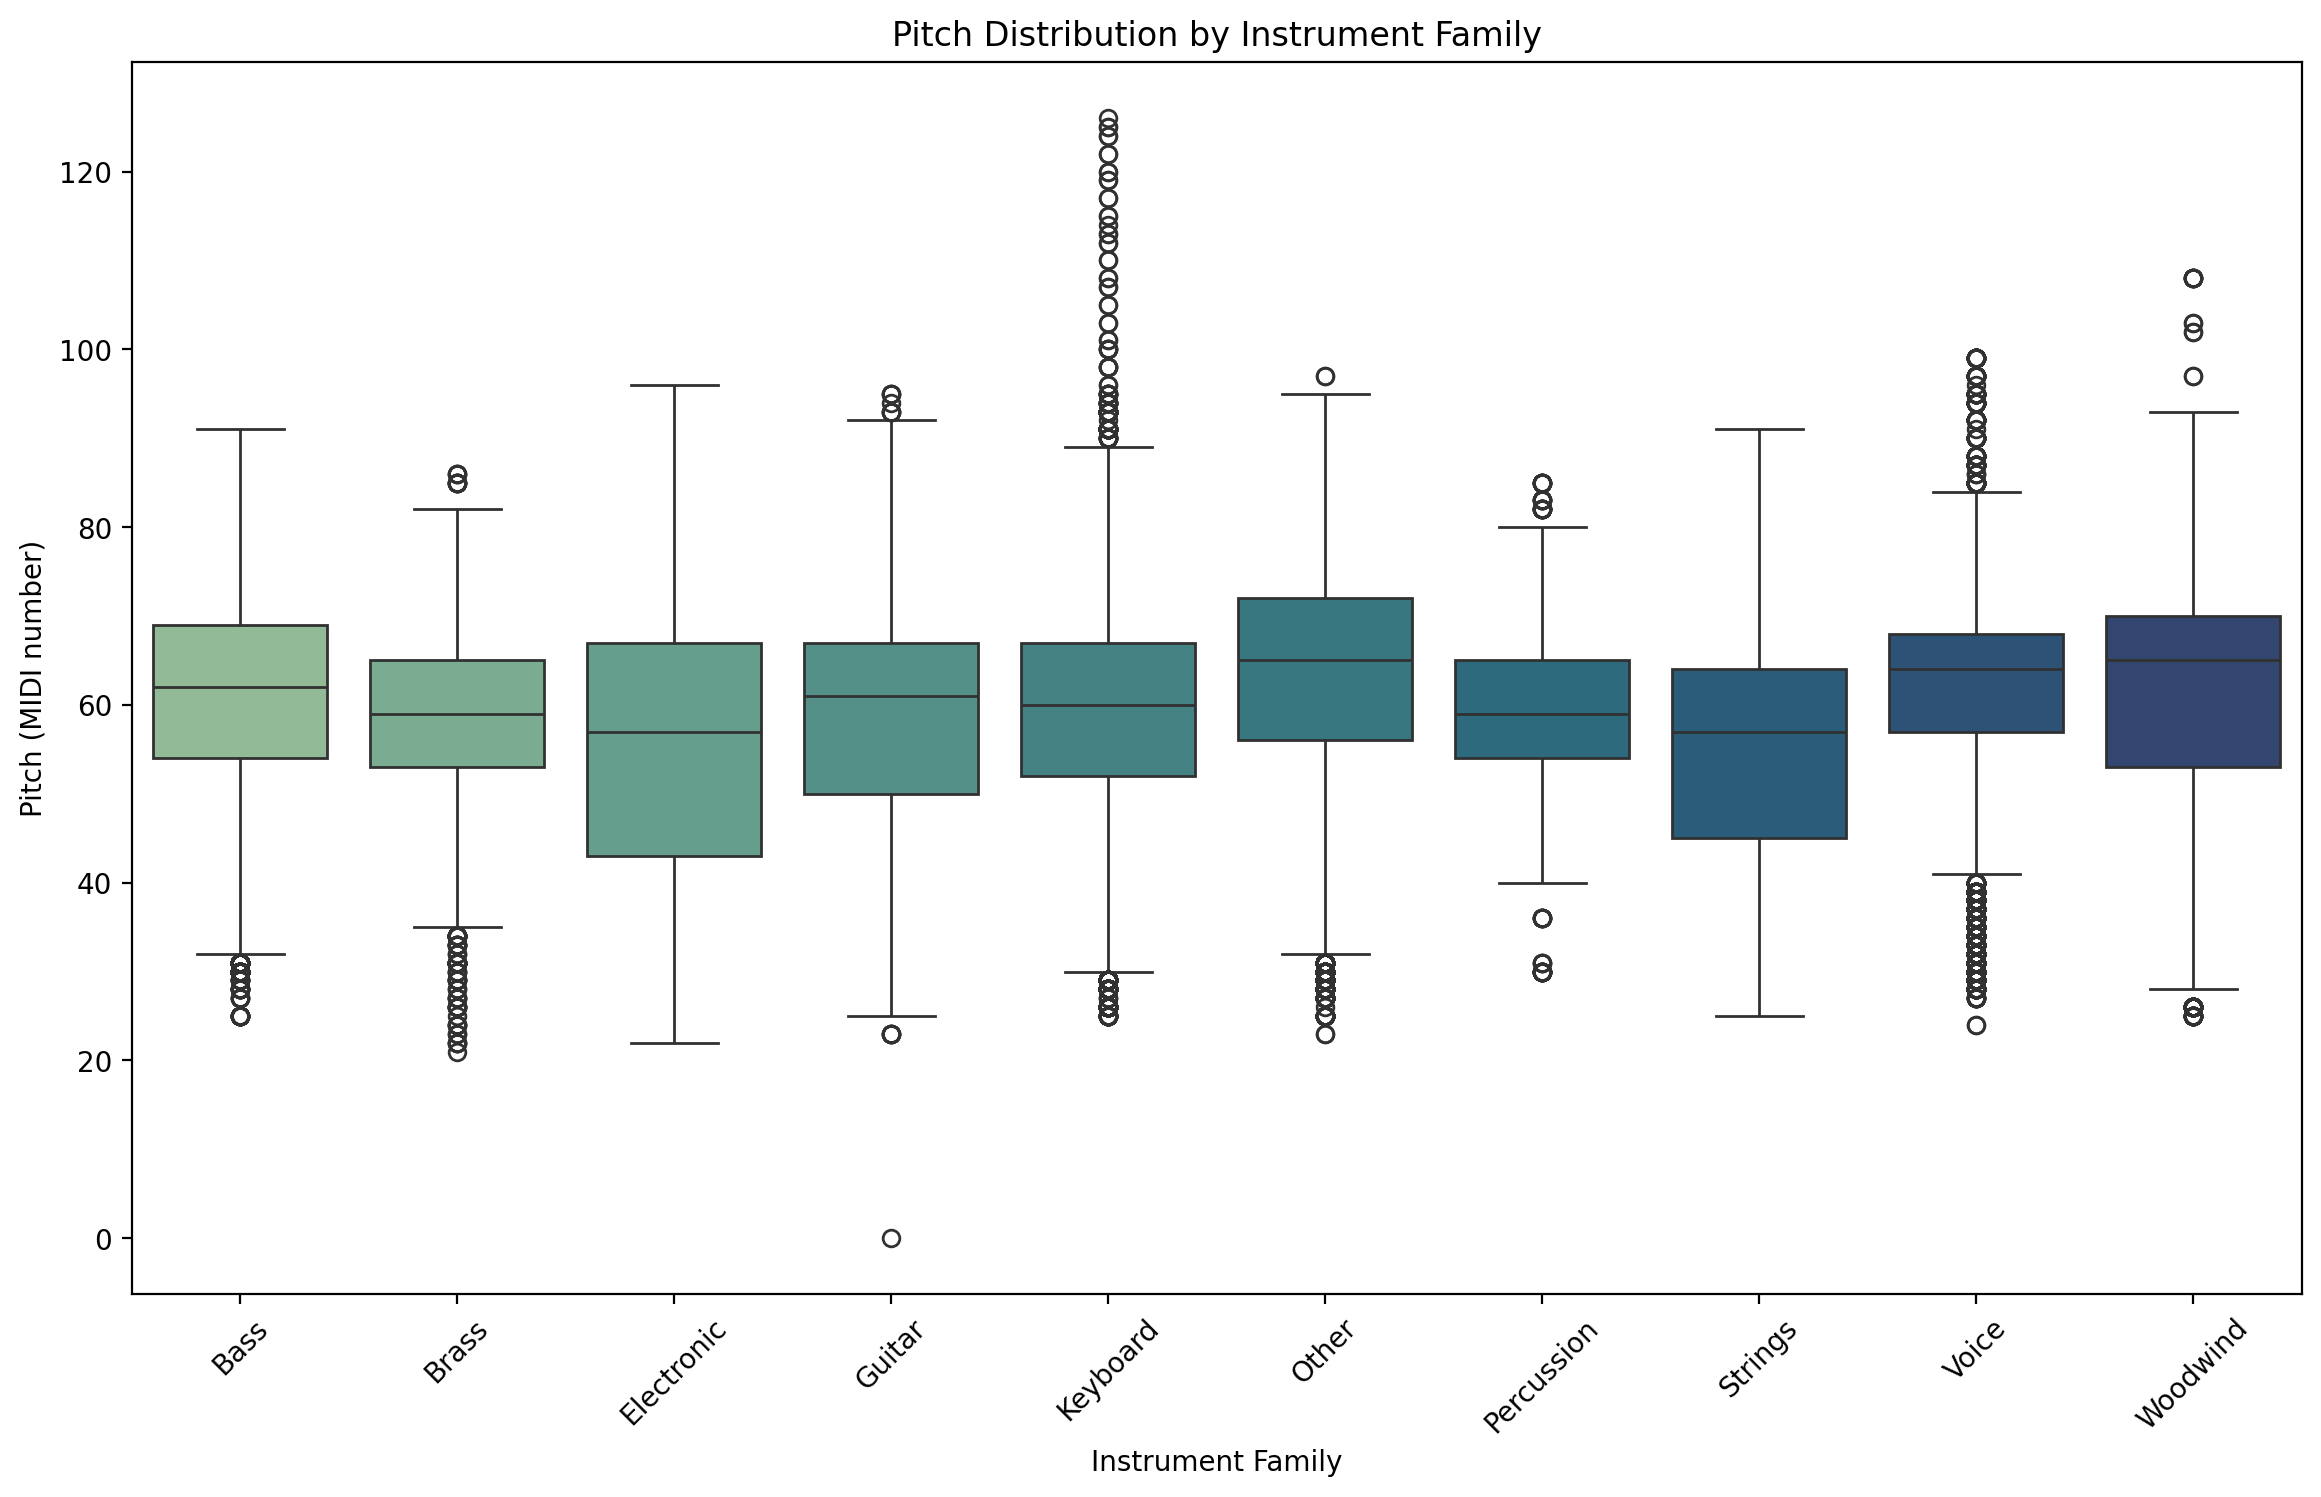

In [112]:
families = sorted(df['instrument_family'].unique())

# Filter and plot pitch distribution by instrument family
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='instrument_family',
    y='pitch',
    palette='crest',
    order=families
)
plt.title('Pitch Distribution by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Pitch (MIDI number)')
plt.xticks(rotation=45)
plt.show()

In [113]:
# Descriptive statistics of pitch values by genre
print("Pitch statistics by Genre:")
df.groupby('genre')['pitch'].describe()

Pitch statistics by Genre:


count       mean        std   min    25%   50%   75%  \
genre                                                                      
alternative_rock   7460.0  47.935925  14.294451  25.0  37.00  45.0  57.0   
blues             22575.0  57.600310  11.940315  25.0  53.00  60.0  66.0   
classical         15371.0  63.324117  12.199964  28.0  55.00  64.0  72.0   
country           14654.0  57.090078  12.765766  25.0  46.00  58.0  65.0   
dance              6910.0  57.097106  10.847326  27.0  49.00  61.0  66.0   
disco              9845.0  58.839309  13.724416  23.0  55.00  61.0  67.0   
heavy_metal        6189.0  60.020359  17.110923  29.0  45.00  58.0  76.0   
jazz              13486.0  58.305205  11.495235  21.0  52.00  60.0  67.0   
new_age           21791.0  58.611583  12.672781   0.0  51.00  59.0  66.0   
pop               12478.0  57.967302  12.648283  22.0  52.00  60.0  66.0   
rap               13449.0  61.666221  13.580556  26.0  60.00  65.0  69.0   
reggae            14663.0  62.176021  12.077594  26.0  57.00  64.0  70.0   
rnb               13780.0  60.262482  12.627834  24.0  56.00  64.0  69.0   
rock               7344.0  53.233524  11.074264  27.0  41.75  55.0  62.0   
soul              12197.0  62.540707  13.969257  24.0  56.00  66.0  72.0   

                    max  
genre                    
alternative_rock  103.0  
blues              85.0  
classical          97.0  
country            93.0  
dance              85.0  
disco             126.0  
heavy_metal        93.0  
jazz               94.0  
new_age            95.0  
pop               100.0  
rap               108.0  
reggae             94.0  
rnb               125.0  
rock               88.0  
soul               96.0

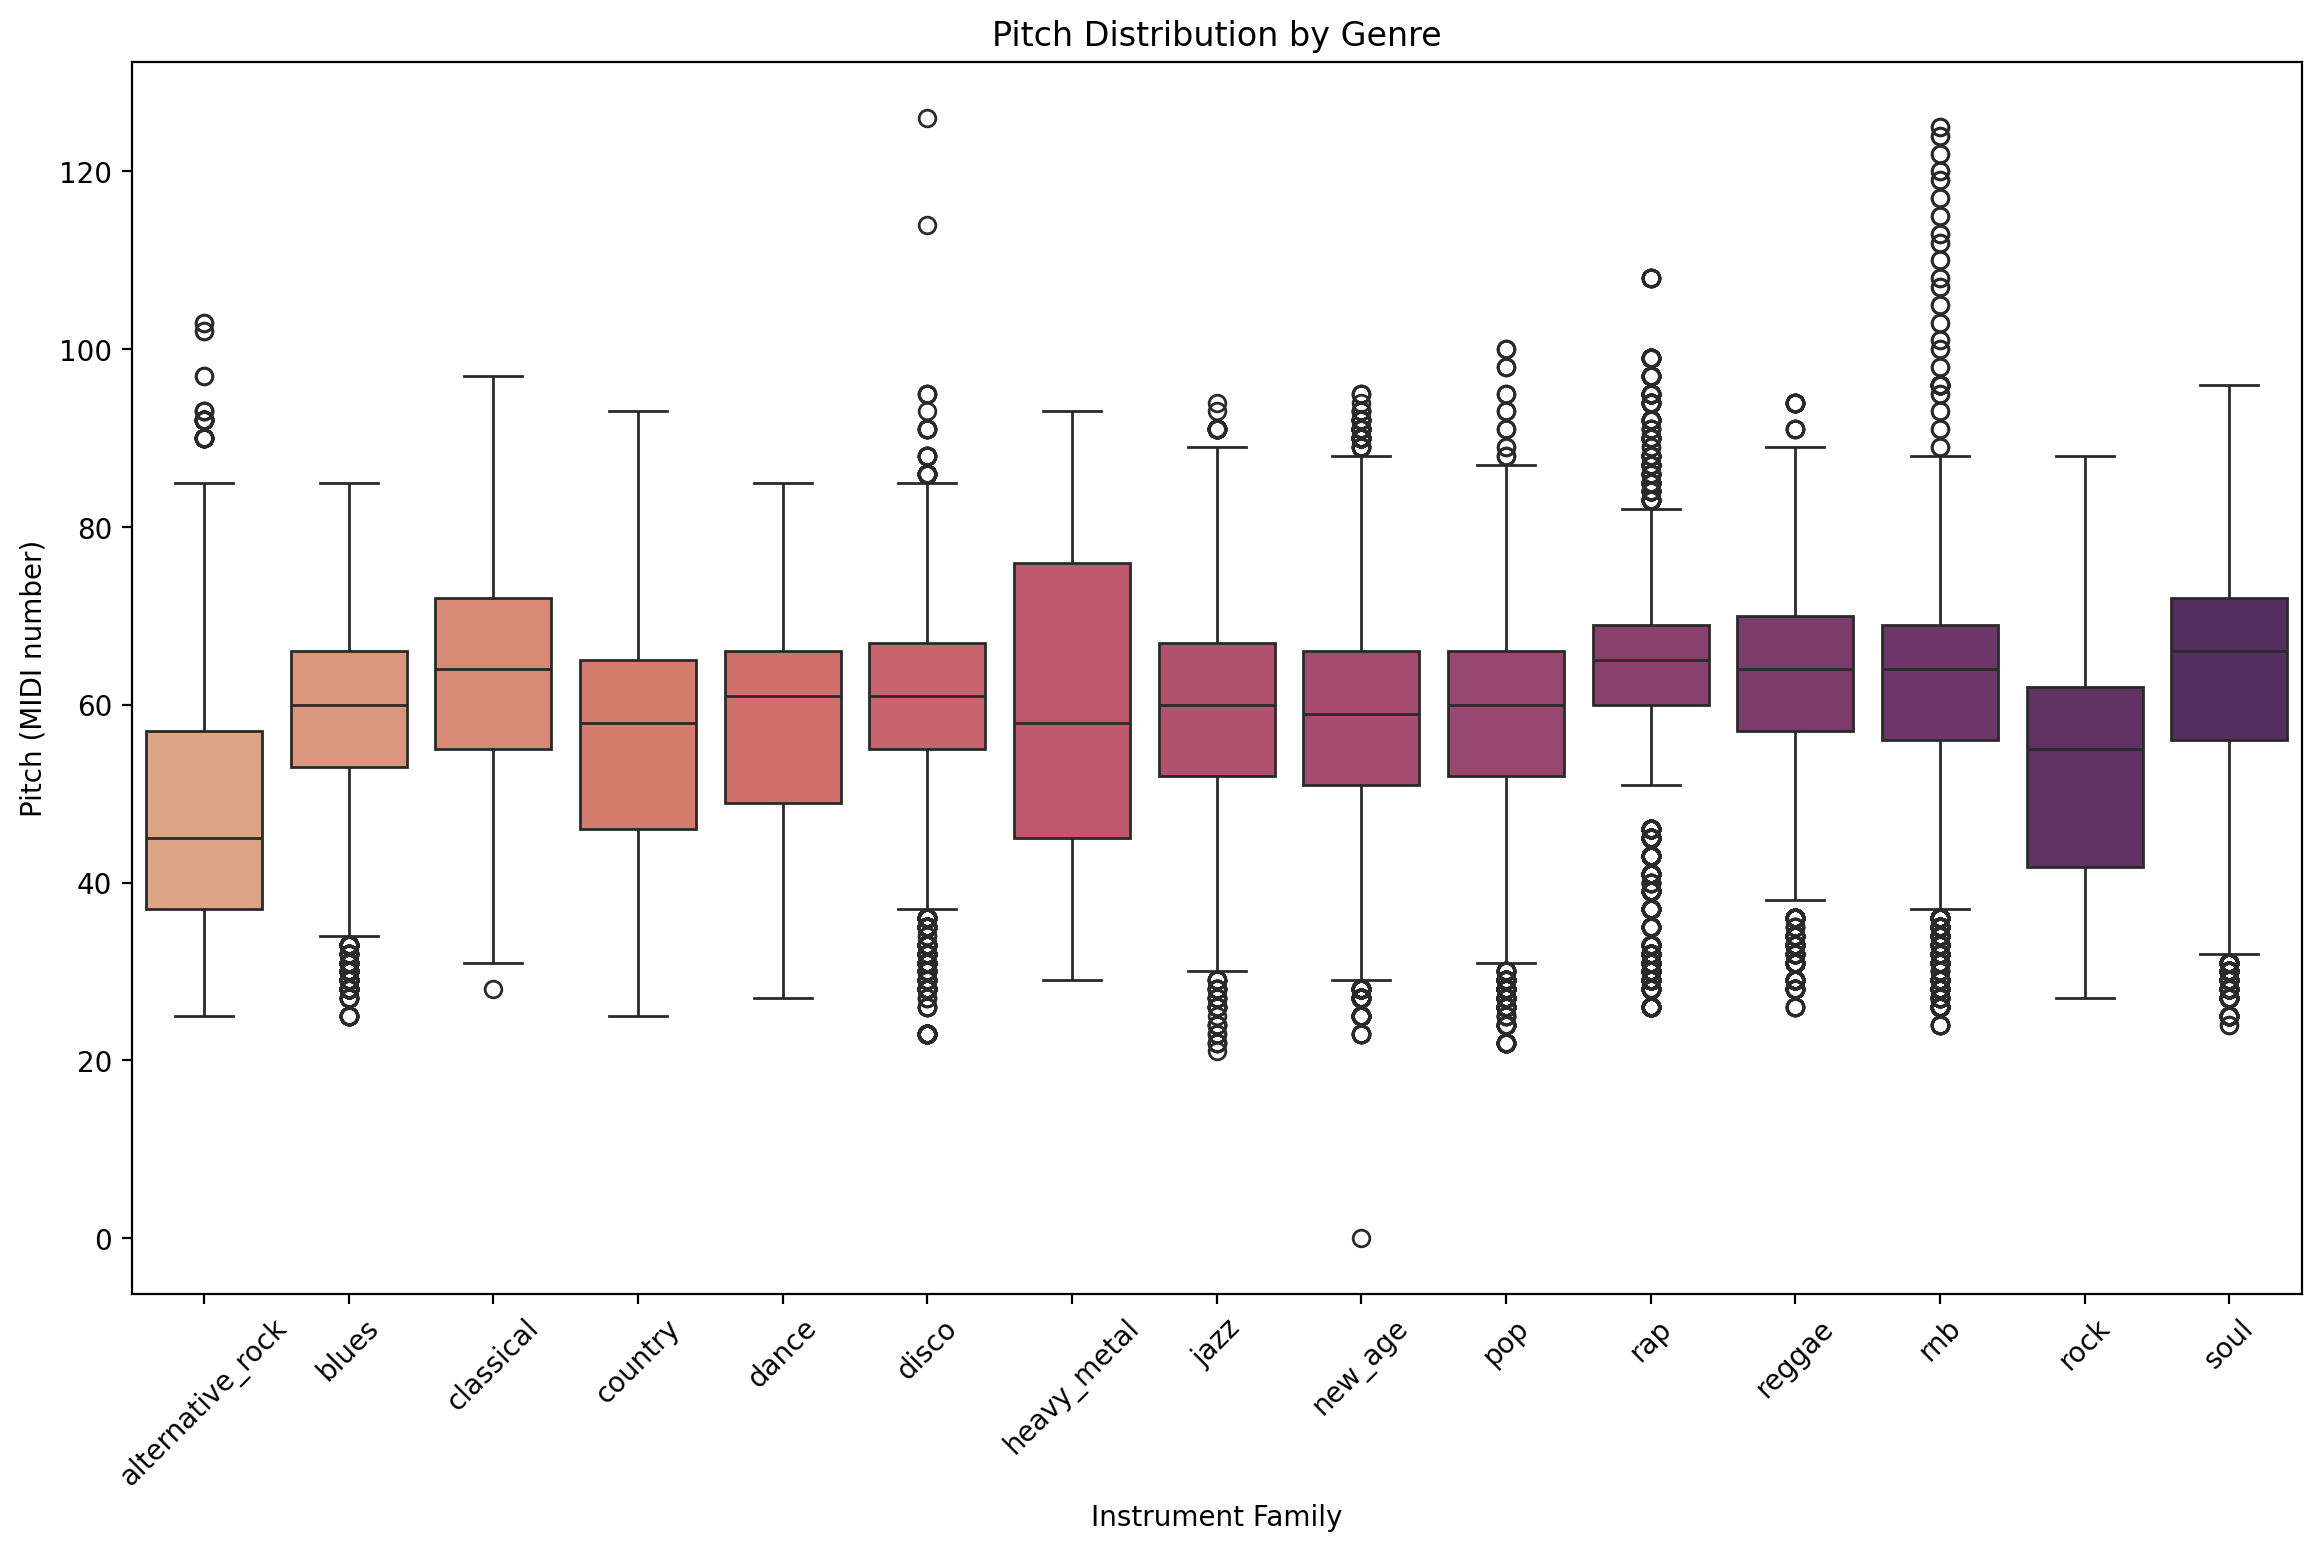

In [114]:
genres_sorted = sorted(df['genre'].unique())

plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='genre',
    y='pitch',
    palette='flare',
    order=genres_sorted
)
plt.title('Pitch Distribution by Genre')
plt.xlabel('Instrument Family')
plt.ylabel('Pitch (MIDI number)')
plt.xticks(rotation=45)
plt.show()

##### 2.3.1.5 Data Engineering – Outlier Identification and Pitch Normalization

In [115]:
# Add binary flag indicating whether pitch is outside standard piano range (21–108)
df["is_outlier_pitch"] = (df["pitch"] < 21) | (df["pitch"] > 108)

# Add standardized pitch (z-score) based on global mean and standard deviation
df["scaled_pitch"] = (df["pitch"] - mean_pitch) / std_pitch

#### 2.3.2 Pitch Class

##### 2.3.2.1 Central Tendency and Spread of Pitch Classes


In [116]:
# Central tendency
mean_pitch_class = df['pitch_class'].mean()
median_pitch_class = df['pitch_class'].median()
mode_pitch_class = df['pitch_class'].mode()[0]  

# Spread
std_pitch_class = df['pitch_class'].std()

# Display results
print(f"Mean pitch class: {mean_pitch_class:.2f}")
print(f"Median pitch class: {median_pitch_class}")
print(f"Mode pitch class: {mode_pitch_class}")
print(f"Standard deviation: {std_pitch_class:.2f}")

Mean pitch class: 5.54
Median pitch class: 6.0
Mode pitch class: 7
Standard deviation: 3.43


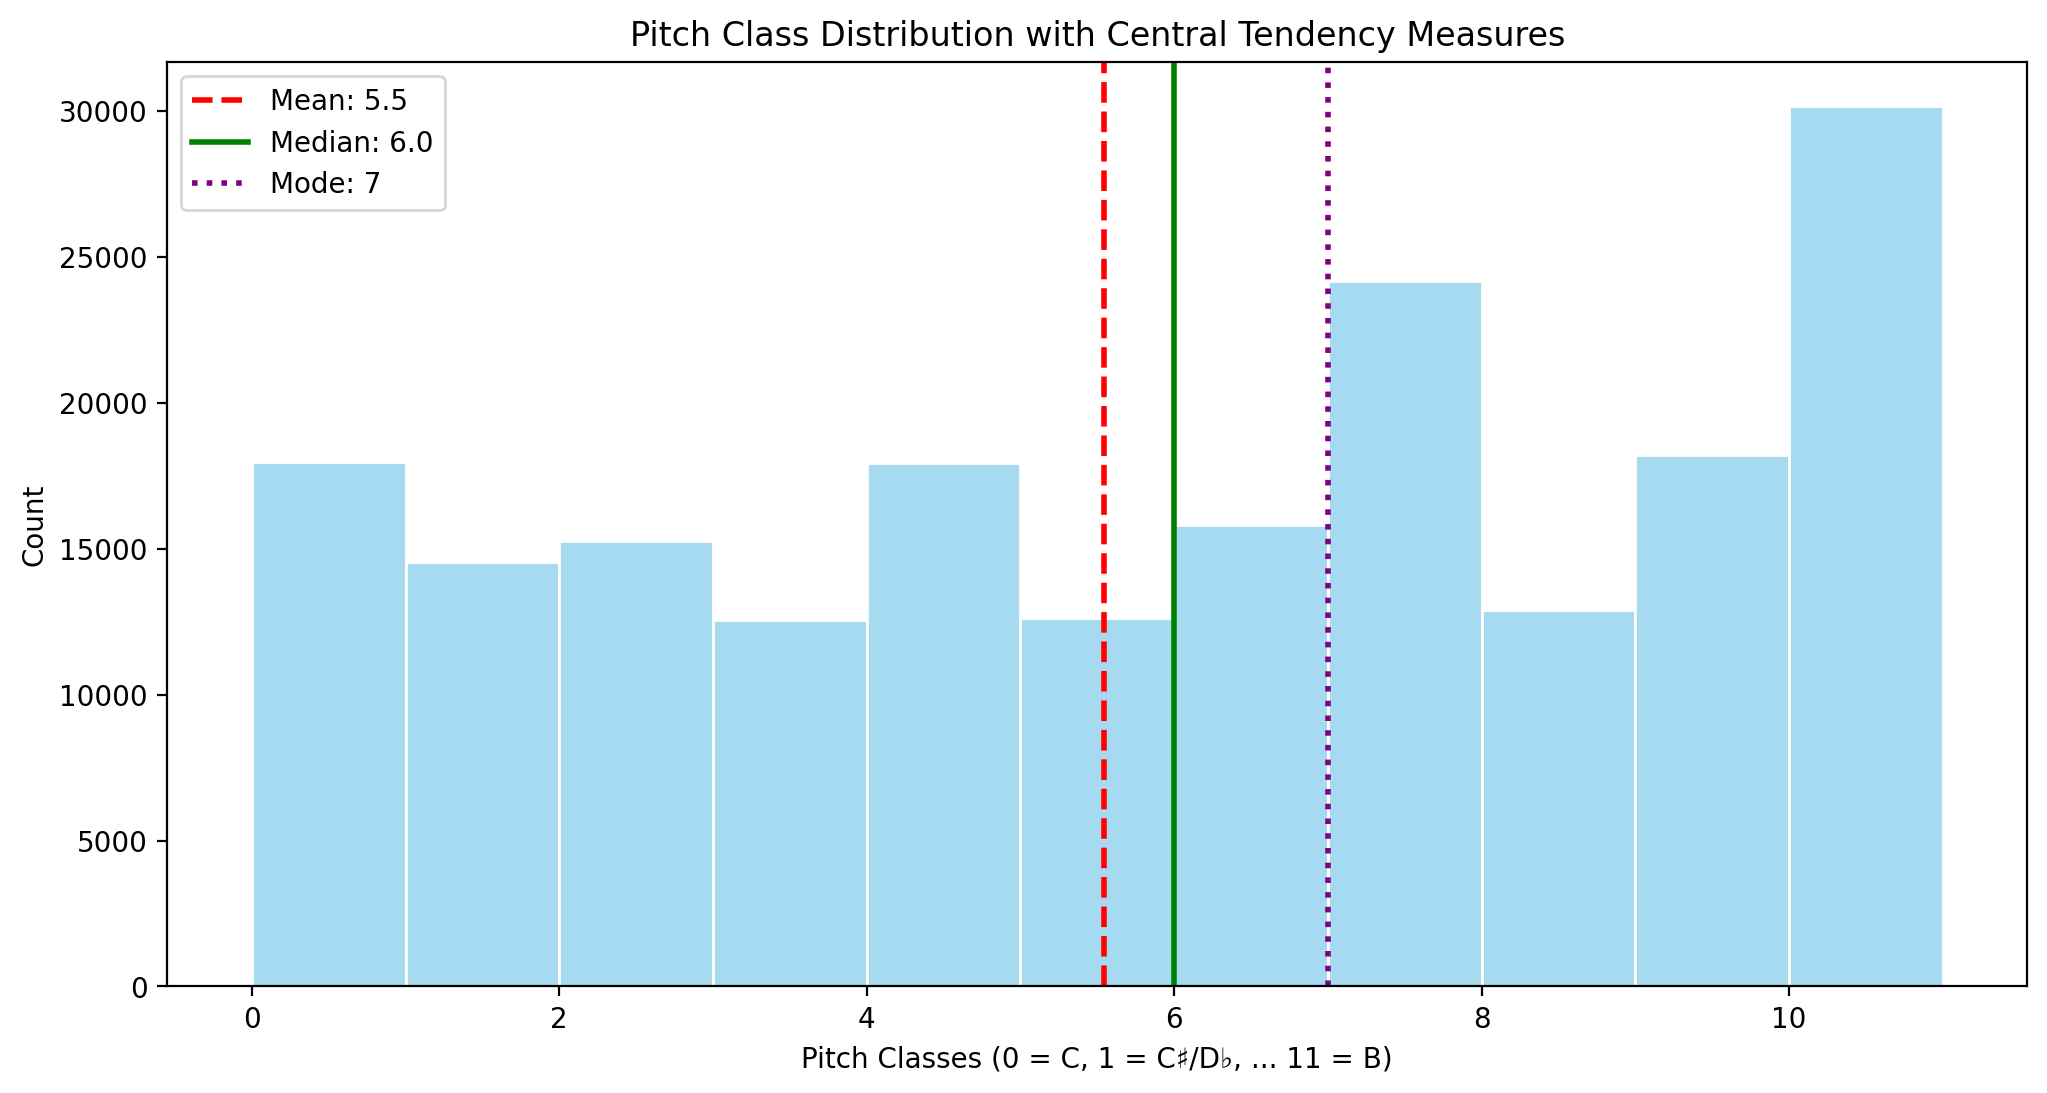

In [117]:
plt.figure(figsize=(12, 6))
sns.histplot(df['pitch_class'], bins=range(0, 12), color='skyblue', edgecolor='white')

# Add lines for mean, median, and mode
plt.axvline(mean_pitch_class, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_pitch_class:.1f}')
plt.axvline(median_pitch_class, color='green', linestyle='-', linewidth=2, label=f'Median: {median_pitch_class}')
plt.axvline(mode_pitch_class, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_pitch_class}')

plt.title('Pitch Class Distribution with Central Tendency Measures')
plt.xlabel('Pitch Classes (0 = C, 1 = C♯/D♭, ... 11 = B)')
plt.ylabel('Count')
plt.legend()
plt.show()

##### 2.3.2.2 Outlier Detection in Pitch Class Values

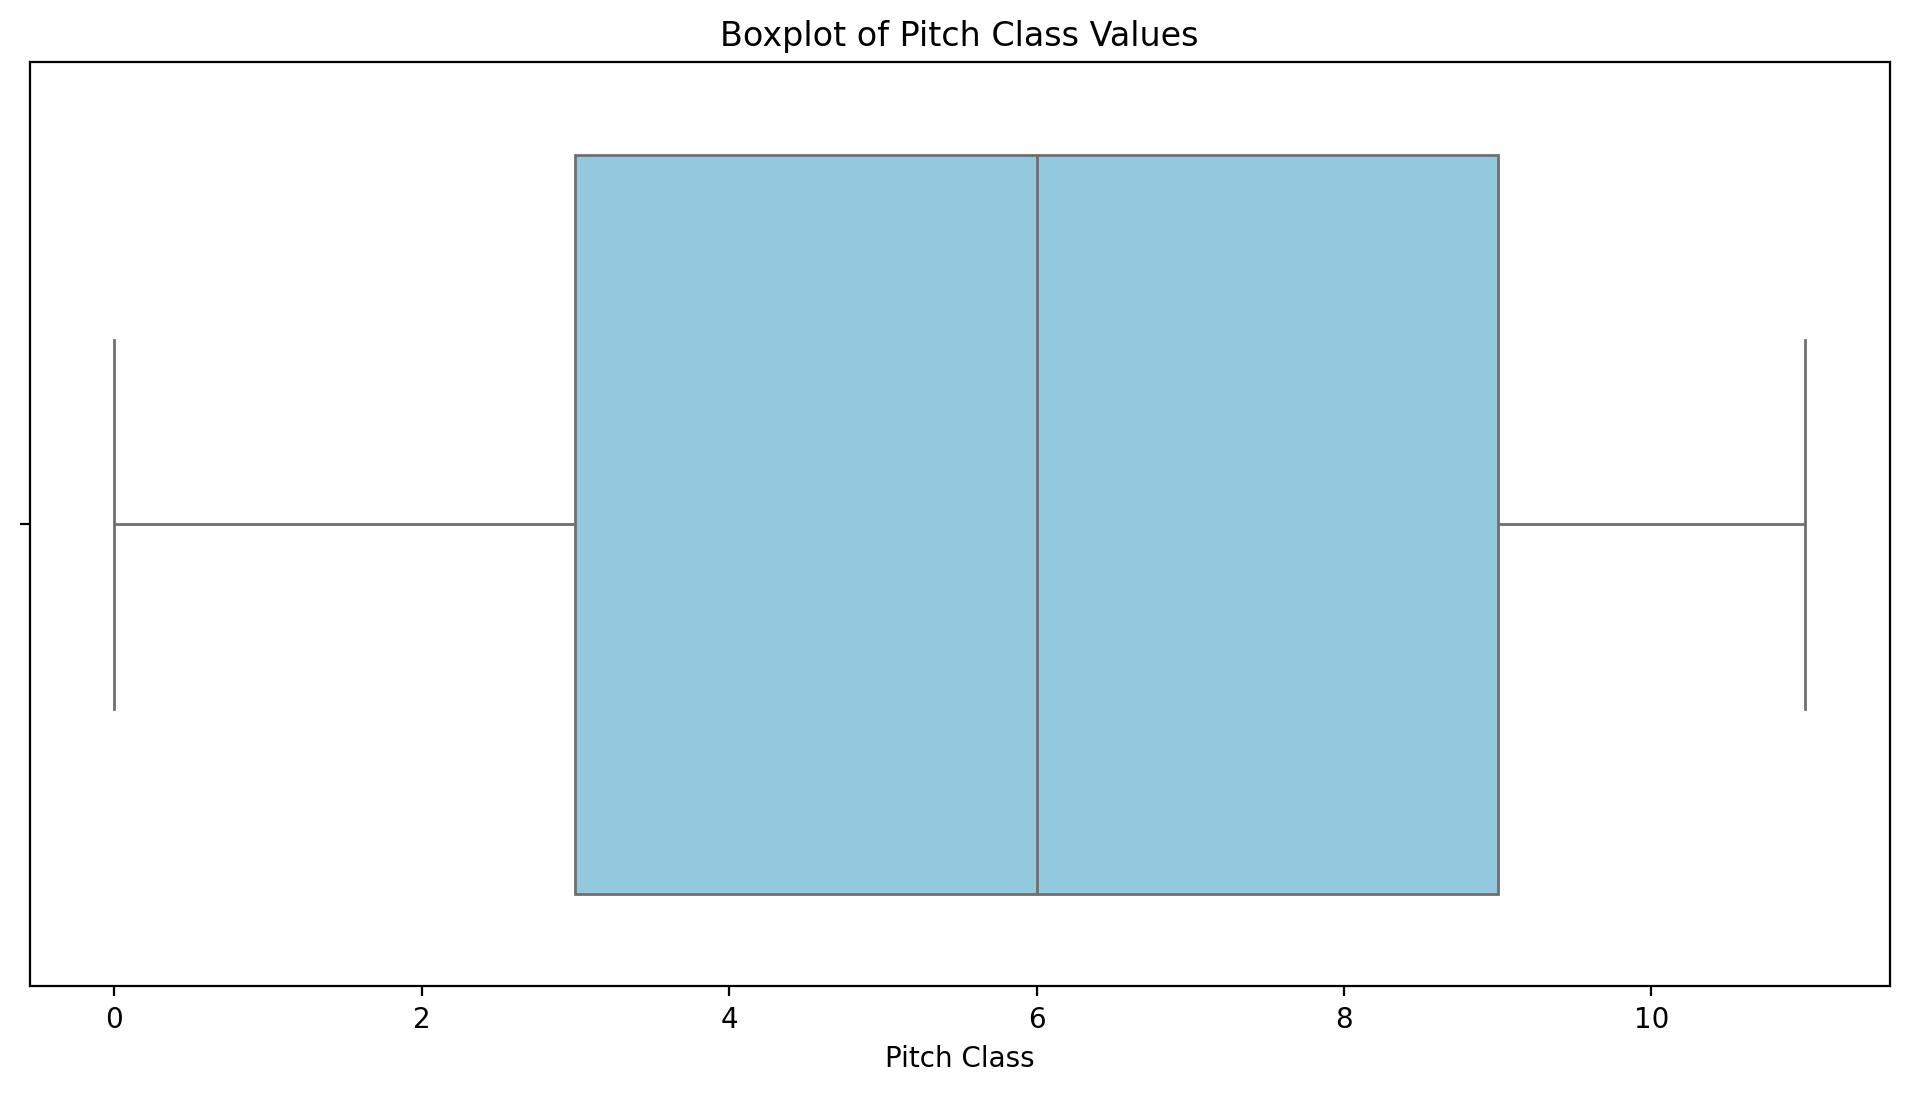

In [118]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['pitch_class'], color='skyblue')
plt.title('Boxplot of Pitch Class Values')
plt.xlabel('Pitch Class')
plt.show()

##### 2.3.2.3 Pitch Classes in Context: Key, Instrument, and Genre

In [119]:
# Descriptive statistics of pitch classes by key
print("Pitch Class statistics by Key:")
df.groupby('key')['pitch_class'].describe().sort_index()

Pitch Class statistics by Key:


count      mean       std  min  25%  50%  75%   max
key                                                       
0    11608.0  5.040489  3.516714  0.0  2.0  5.0  7.0  11.0
1     8535.0  4.999063  3.378859  0.0  1.0  5.0  8.0  11.0
2     5075.0  5.711133  2.730957  0.0  4.0  6.0  8.0  11.0
3    13501.0  5.891341  3.236180  0.0  3.0  7.0  9.0  11.0
4     8834.0  6.479171  3.336325  1.0  4.0  8.0  9.0  11.0
5    17733.0  4.715164  3.669061  0.0  0.0  5.0  7.0  11.0
6     4806.0  5.095298  3.528223  0.0  1.0  5.0  8.0  10.0
7    10897.0  5.705332  3.424115  0.0  2.0  7.0  9.0  11.0
9     3344.0  5.971591  3.261937  0.0  4.0  6.0  9.0  11.0
11   24410.0  5.767472  3.320040  0.0  3.0  6.0  9.0  11.0
12    7224.0  4.481451  3.516688  0.0  0.0  5.0  7.0  11.0
13    9294.0  5.376049  3.470537  0.0  2.0  6.0  8.0  11.0
14    7794.0  5.039133  3.516730  0.0  2.0  5.0  9.0  11.0
15    1626.0  5.371464  3.057363  0.0  3.0  6.0  8.0  11.0
16   19702.0  6.552127  3.408770  0.0  4.0  7.0  9.0  11.0
17    7936.0  5.351941  3.449519  0.0  3.0  5.0  8.0  11.0
19   16036.0  5.576515  3.214299  0.0  2.0  7.0  7.0  11.0
21    8261.0  5.510229  3.337265  0.0  4.0  4.0  9.0  11.0
23    5576.0  5.426291  3.303476  0.0  2.0  6.0  9.0  11.0

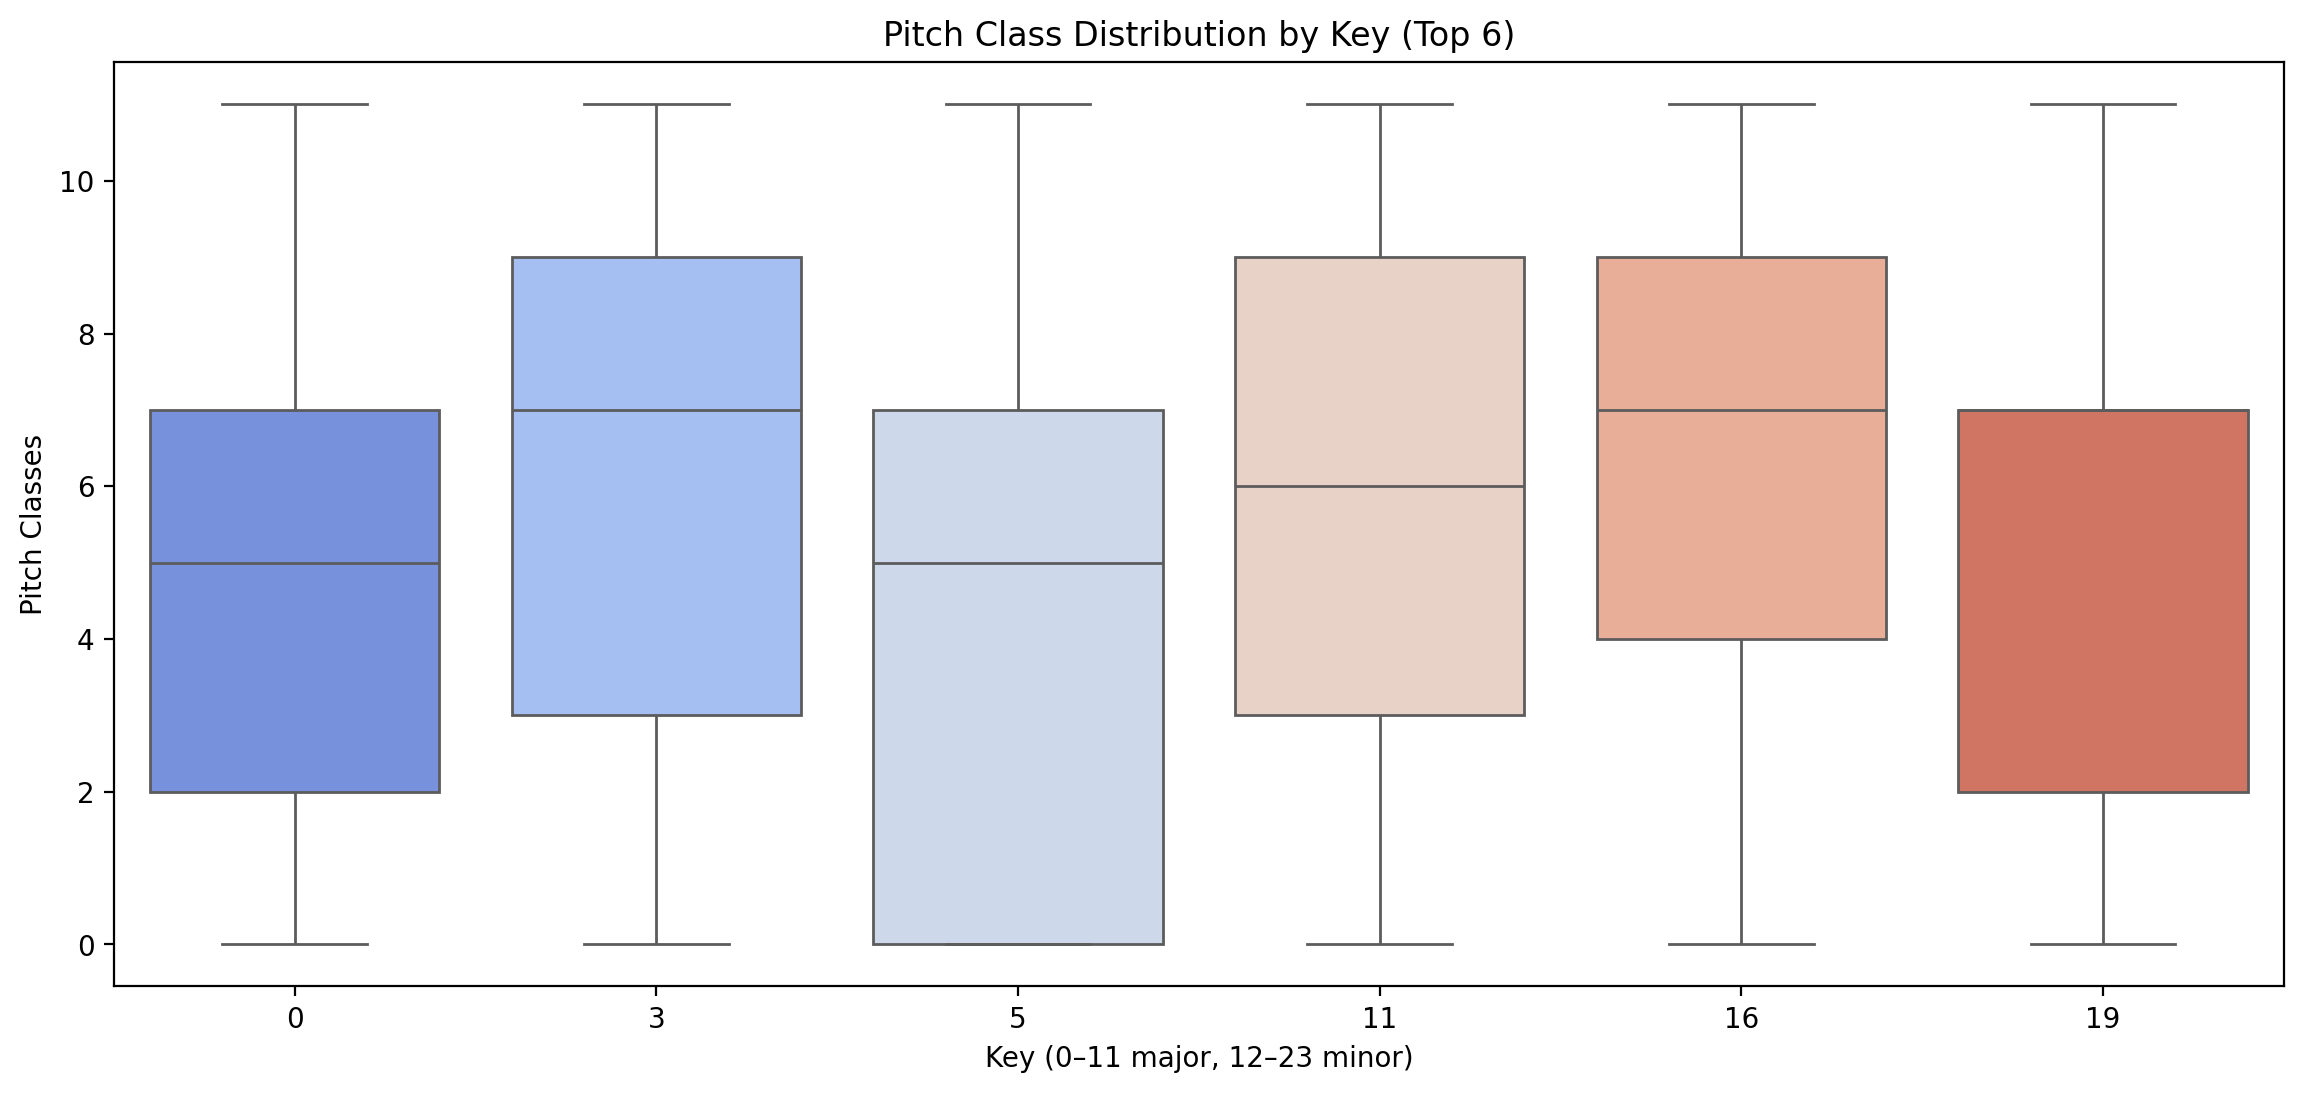

In [120]:
# Pitch Class distribution across top 6 keys to show tonal variation.
plt.figure(figsize=(14,6))
sns.boxplot(data=df[df['key'].isin(top_keys)], x='key', y='pitch_class', palette='coolwarm')
plt.title('Pitch Class Distribution by Key (Top 6)')
plt.xlabel('Key (0–11 major, 12–23 minor)')
plt.ylabel('Pitch Classes')
plt.show()

In [121]:
# Descriptive statistics of pitch classes by instrument
print("Pitch Class statistics by Instrument:")
df.groupby('instrument')['pitch_class'].describe()

Pitch Class statistics by Instrument:


count      mean       std  min  25%  50%   75%   max
instrument                                                              
Acoustic Bass     11262.0  5.914846  3.297537  0.0  4.0  6.0   9.0  11.0
Acoustic Guitar   18001.0  5.416199  3.344015  0.0  2.0  6.0   8.0  11.0
Bagpipes           4865.0  5.100514  3.278715  0.0  1.0  5.0   8.0  11.0
Bassoon            1729.0  5.839792  3.439845  0.0  2.0  7.0   7.0  11.0
Celesta            8514.0  5.817947  3.639160  0.0  2.0  6.0   9.0  11.0
Choir              2984.0  6.025804  3.433239  0.0  3.0  7.0   9.0  11.0
Clarinet            998.0  7.067134  2.666427  1.0  6.0  8.0   8.0  11.0
Contrabass         9168.0  5.679974  3.420736  0.0  2.0  7.0   9.0  11.0
Electric Bass       647.0  5.401855  3.332344  0.0  2.0  6.0   7.0  11.0
Electric Guitar   21454.0  5.265265  3.647329  0.0  3.0  5.0   9.0  11.0
Electric Organ     2280.0  5.942982  2.774910  0.0  3.0  7.0   7.0  11.0
Fretless Bass      4777.0  5.366757  3.307441  0.0  2.0  7.0   7.0  11.0
Glockenspiel        133.0  5.360902  2.980590  1.0  3.0  6.0   8.0  11.0
Marimba             235.0  4.825532  3.032479  0.0  2.0  4.0   6.0  11.0
Ocarina             575.0  5.707826  3.880828  0.0  1.0  5.0  10.0  10.0
Piano             38177.0  5.385939  3.462701  0.0  2.0  5.0   8.0  11.0
Piccolo            1462.0  7.644323  2.834838  0.0  5.0  9.0  10.0  11.0
Recorder           1097.0  5.017320  3.199662  0.0  2.0  4.0   7.0  11.0
Sampler           23546.0  5.444279  3.333310  0.0  3.0  6.0   8.0  11.0
StringInstrument   4078.0  5.738352  3.250170  0.0  3.0  6.0   9.0  11.0
Taiko                61.0  2.934426  2.798028  0.0  1.0  1.0   6.0  11.0
Timpani            1450.0  7.478621  3.275043  0.0  5.0  9.0  11.0  11.0
Trombone           4529.0  5.434533  3.433712  0.0  2.0  6.0   9.0  11.0
Trumpet             105.0  4.695238  2.889383  1.0  1.0  6.0   6.0   9.0
Unknown           14549.0  5.479414  3.529863  0.0  2.0  6.0   8.0  11.0
Violoncello         360.0  6.977778  3.434960  1.0  4.0  8.0   9.0  11.0
Voice             11500.0  5.670696  3.445170  0.0  3.0  6.0   8.0  11.0
Whistle            3656.0  5.792123  2.871436  0.0  2.0  7.0   7.0  10.0

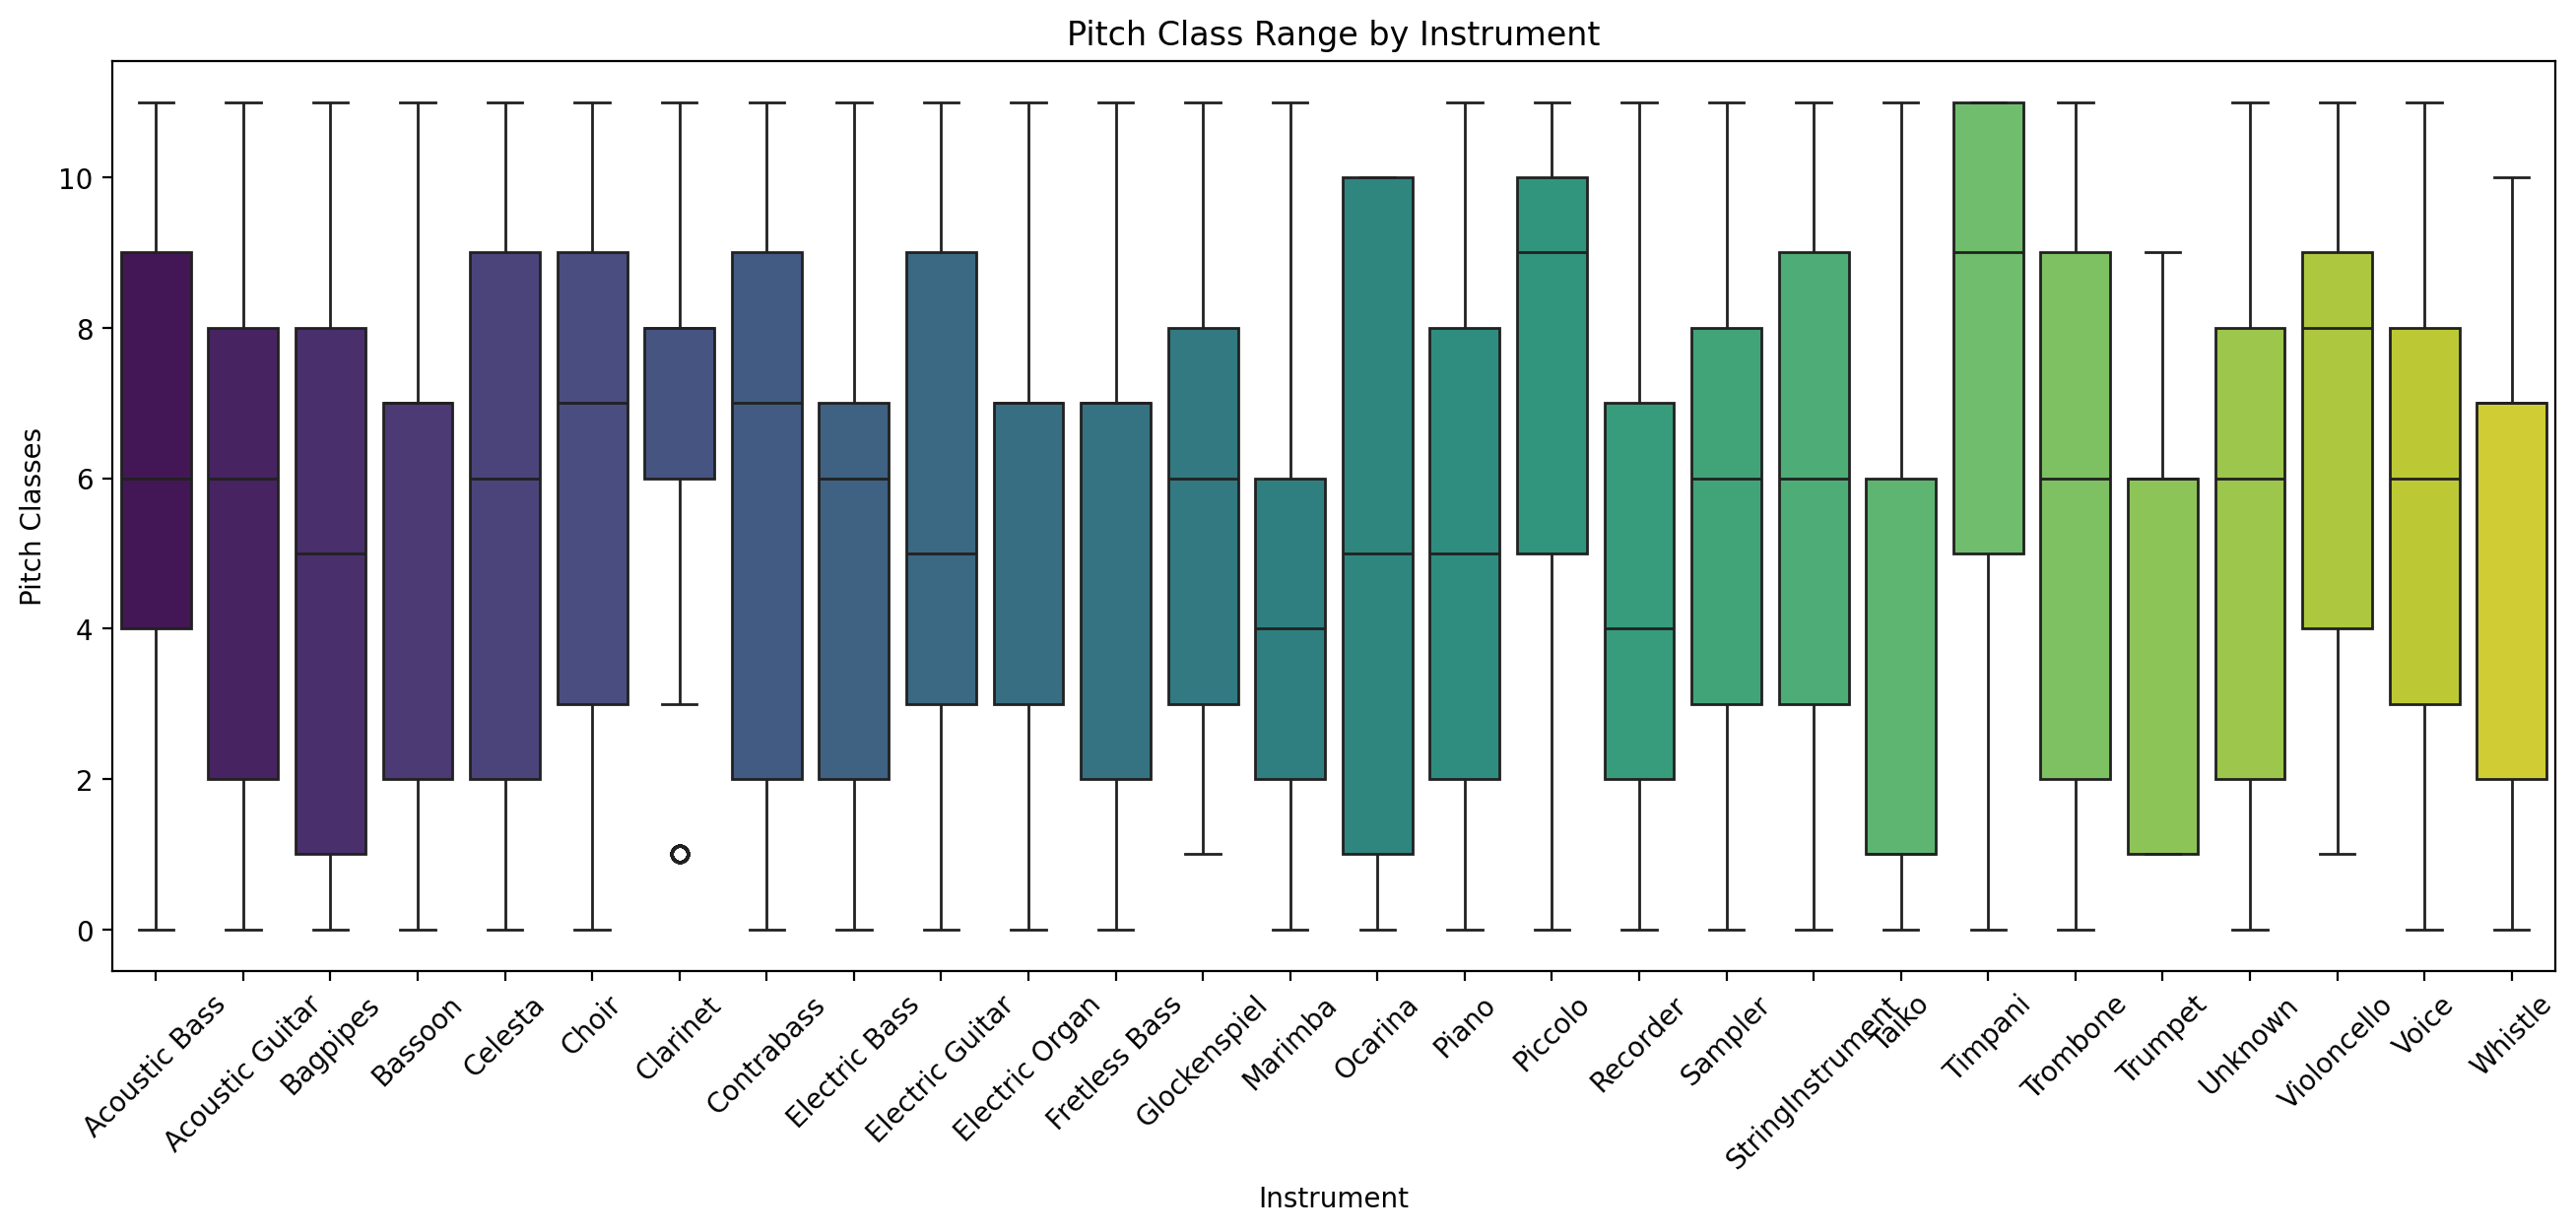

In [122]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df, x='instrument', y='pitch_class', palette='viridis', order=alphabetic_order)
plt.xticks(rotation=45)
plt.title('Pitch Class Range by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Pitch Classes')
plt.show()

In [123]:
# Descriptive statistics of pitch classes by instrument family
print("Pitch Class statistics by Instrument Family:")
df.groupby('instrument')['pitch_class'].describe()

Pitch Class statistics by Instrument Family:


count      mean       std  min  25%  50%   75%   max
instrument                                                              
Acoustic Bass     11262.0  5.914846  3.297537  0.0  4.0  6.0   9.0  11.0
Acoustic Guitar   18001.0  5.416199  3.344015  0.0  2.0  6.0   8.0  11.0
Bagpipes           4865.0  5.100514  3.278715  0.0  1.0  5.0   8.0  11.0
Bassoon            1729.0  5.839792  3.439845  0.0  2.0  7.0   7.0  11.0
Celesta            8514.0  5.817947  3.639160  0.0  2.0  6.0   9.0  11.0
Choir              2984.0  6.025804  3.433239  0.0  3.0  7.0   9.0  11.0
Clarinet            998.0  7.067134  2.666427  1.0  6.0  8.0   8.0  11.0
Contrabass         9168.0  5.679974  3.420736  0.0  2.0  7.0   9.0  11.0
Electric Bass       647.0  5.401855  3.332344  0.0  2.0  6.0   7.0  11.0
Electric Guitar   21454.0  5.265265  3.647329  0.0  3.0  5.0   9.0  11.0
Electric Organ     2280.0  5.942982  2.774910  0.0  3.0  7.0   7.0  11.0
Fretless Bass      4777.0  5.366757  3.307441  0.0  2.0  7.0   7.0  11.0
Glockenspiel        133.0  5.360902  2.980590  1.0  3.0  6.0   8.0  11.0
Marimba             235.0  4.825532  3.032479  0.0  2.0  4.0   6.0  11.0
Ocarina             575.0  5.707826  3.880828  0.0  1.0  5.0  10.0  10.0
Piano             38177.0  5.385939  3.462701  0.0  2.0  5.0   8.0  11.0
Piccolo            1462.0  7.644323  2.834838  0.0  5.0  9.0  10.0  11.0
Recorder           1097.0  5.017320  3.199662  0.0  2.0  4.0   7.0  11.0
Sampler           23546.0  5.444279  3.333310  0.0  3.0  6.0   8.0  11.0
StringInstrument   4078.0  5.738352  3.250170  0.0  3.0  6.0   9.0  11.0
Taiko                61.0  2.934426  2.798028  0.0  1.0  1.0   6.0  11.0
Timpani            1450.0  7.478621  3.275043  0.0  5.0  9.0  11.0  11.0
Trombone           4529.0  5.434533  3.433712  0.0  2.0  6.0   9.0  11.0
Trumpet             105.0  4.695238  2.889383  1.0  1.0  6.0   6.0   9.0
Unknown           14549.0  5.479414  3.529863  0.0  2.0  6.0   8.0  11.0
Violoncello         360.0  6.977778  3.434960  1.0  4.0  8.0   9.0  11.0
Voice             11500.0  5.670696  3.445170  0.0  3.0  6.0   8.0  11.0
Whistle            3656.0  5.792123  2.871436  0.0  2.0  7.0   7.0  10.0

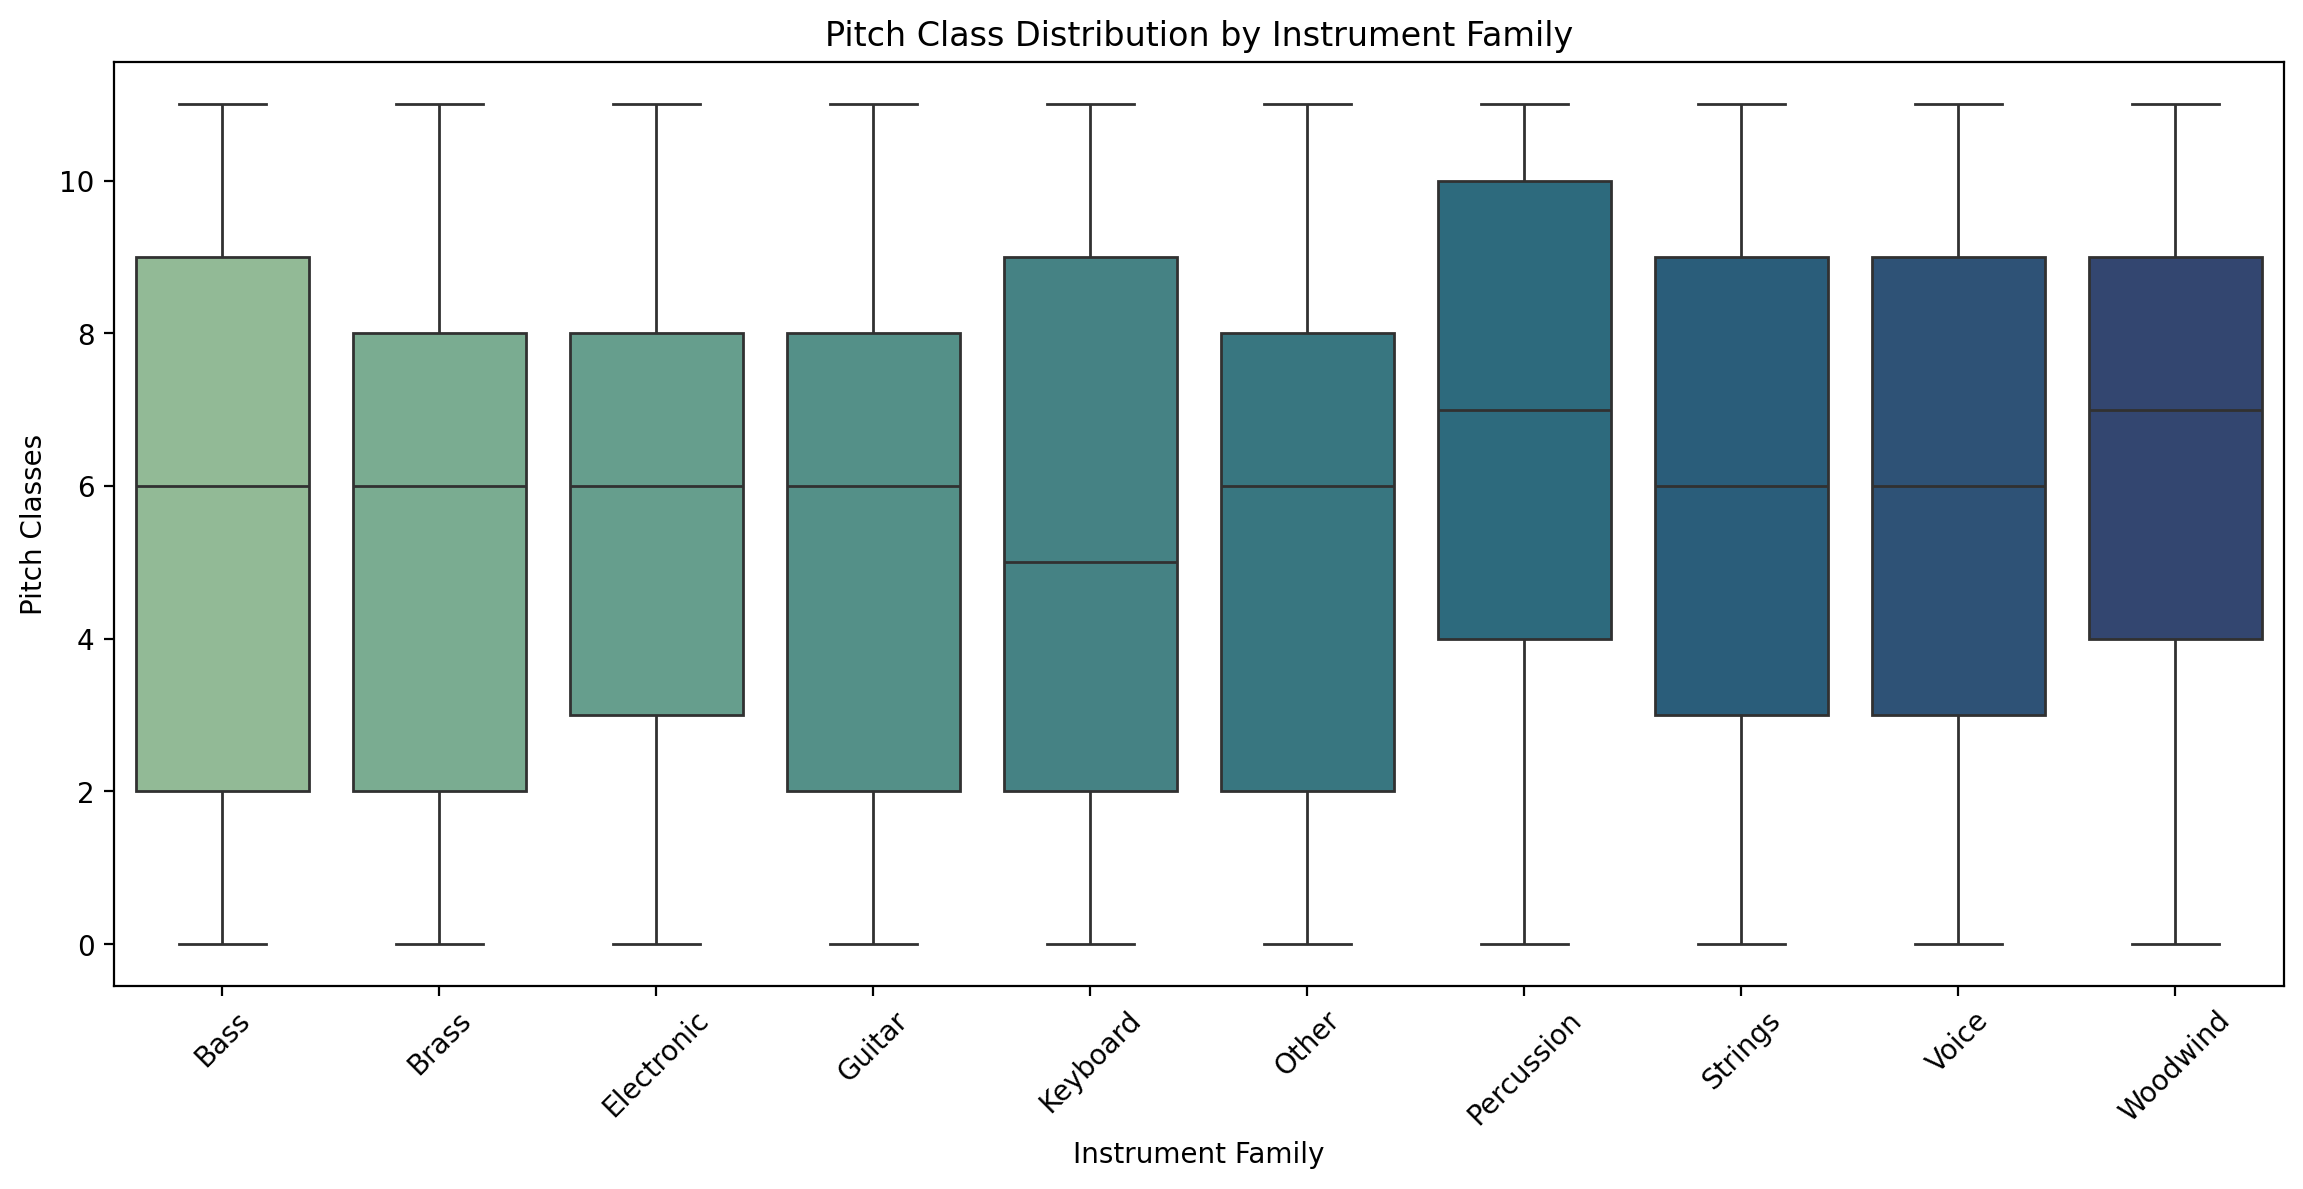

In [124]:
# Filter and plot pitch classes distribution by instrument family
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x='instrument_family',
    y='pitch_class',
    palette='crest',
    order=families
)
plt.title('Pitch Class Distribution by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Pitch Classes')
plt.xticks(rotation=45)
plt.show()

In [125]:
# Descriptive statistics of pitch classes by genre
print("Pitch Class statistics by Genre:")
df.groupby('genre')['pitch_class'].describe()

Pitch Class statistics by Genre:


count      mean       std  min  25%  50%  75%   max
genre                                                                  
alternative_rock   7460.0  5.884450  3.211589  0.0  3.0  6.0  8.0  11.0
blues             22575.0  5.309546  3.558750  0.0  2.0  6.0  9.0  11.0
classical         15371.0  5.716154  3.432939  0.0  2.0  6.0  9.0  11.0
country           14654.0  5.703153  3.388741  0.0  3.0  6.0  9.0  11.0
dance              6910.0  5.212301  3.315633  0.0  1.0  5.0  8.0  11.0
disco              9845.0  6.010056  3.674290  0.0  2.0  7.0  9.0  11.0
heavy_metal        6189.0  5.728551  3.117603  0.0  3.0  6.0  9.0  11.0
jazz              13486.0  5.548272  3.490780  0.0  2.0  6.0  9.0  11.0
new_age           21791.0  5.871277  3.339460  0.0  3.0  6.0  9.0  11.0
pop               12478.0  5.211733  3.519130  0.0  2.0  5.0  8.0  11.0
rap               13449.0  6.077552  3.200750  0.0  4.0  7.0  9.0  11.0
reggae            14663.0  4.965901  3.431332  0.0  2.0  5.0  7.0  11.0
rnb               13780.0  5.725181  3.500721  0.0  4.0  5.0  9.0  11.0
rock               7344.0  5.140387  3.064433  0.0  2.0  4.0  7.0  11.0
soul              12197.0  4.939329  3.499017  0.0  1.0  5.0  8.0  11.0

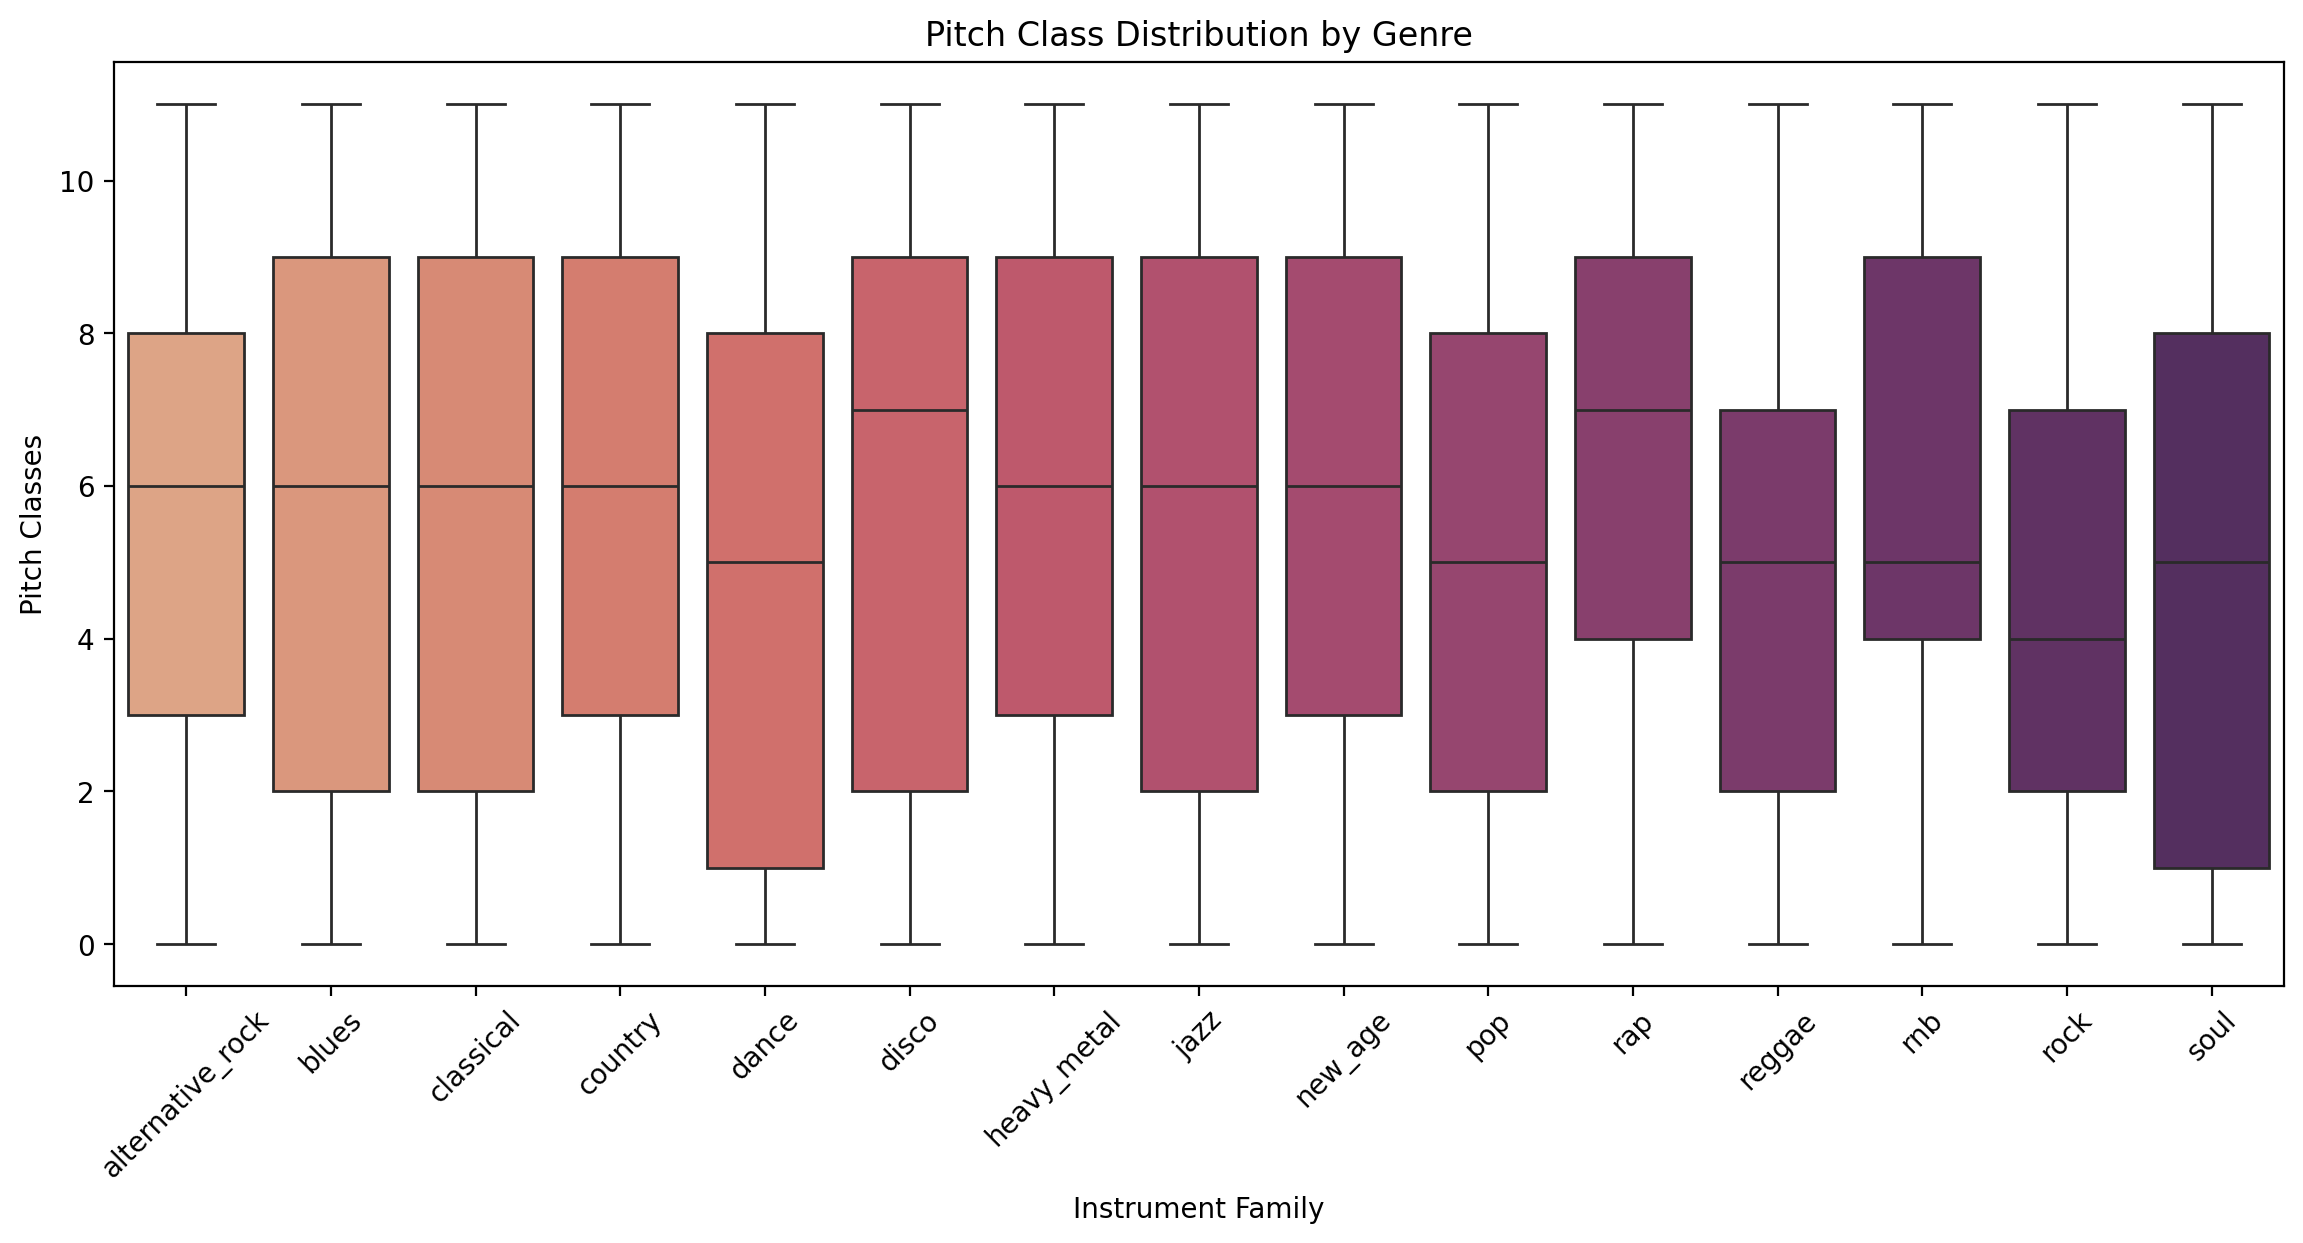

In [126]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x='genre',
    y='pitch_class',
    palette='flare',
    order=genres_sorted
)
plt.title('Pitch Class Distribution by Genre')
plt.xlabel('Instrument Family')
plt.ylabel('Pitch Classes')
plt.xticks(rotation=45)
plt.show()

##### 2.3.2.4 Pitch-Class Distributions in Circular Layout: Revealing Tonal Bias and Chromatic Usage

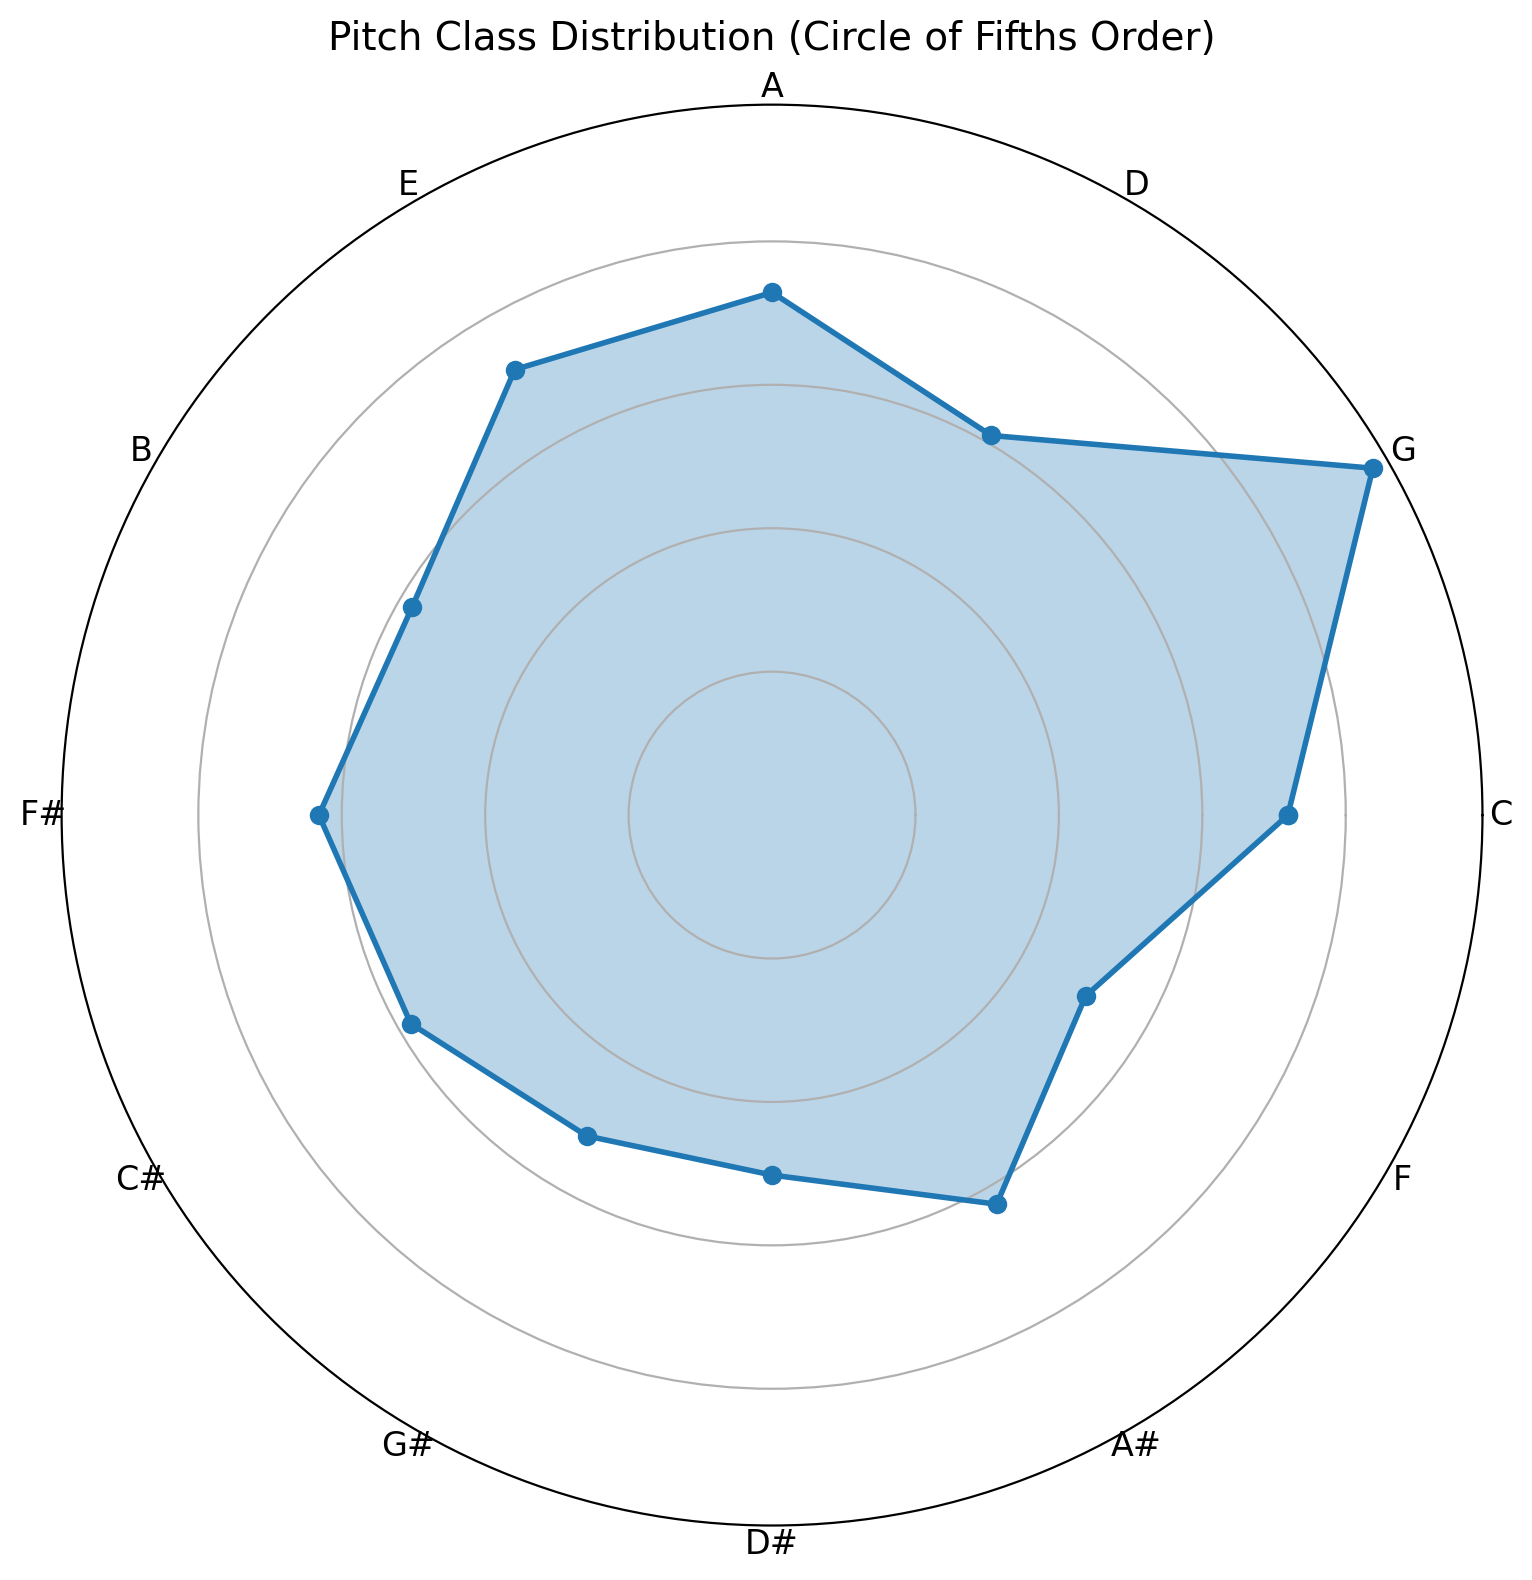

In [127]:
# Map pitch class numbers to names (0=C, 1=C#, ..., 11=B)
pitch_class_names = ['C', 'C#', 'D', 'D#', 'E', 'F',
                     'F#', 'G', 'G#', 'A', 'A#', 'B']
df['pitch_class_name'] = df['pitch_class'].map(lambda x: pitch_class_names[x])

# Reorder pitch classes by Circle of Fifths
fifths_order = ['C', 'G', 'D', 'A', 'E', 'B', 'F#', 'C#', 'G#', 'D#', 'A#', 'F']

# Count occurrences for each pitch class
pitch_counts = df['pitch_class_name'].value_counts()
pitch_counts = pitch_counts.reindex(fifths_order, fill_value=0)

# Set up circular plot
angles = np.linspace(0, 2 * np.pi, 12, endpoint=False)
values = pitch_counts.values
labels = pitch_counts.index

# Repeat the first value to close the circle
angles = np.concatenate([angles, [angles[0]]])
values = np.concatenate([values, [values[0]]])

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.3)

# Add pitch class labels
for angle, label in zip(angles[:-1], labels):
    ax.text(angle, max(values)*1.05, label, ha='center', va='center', fontsize=12)

# Remove radial labels for clarity
ax.set_yticklabels([])
ax.set_xticks([])

ax.set_title('Pitch Class Distribution (Circle of Fifths Order)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

#### 2.3.3 Pitch Octave

##### 2.3.3.1 Central Tendency and Spread of Pitch Octave

In [128]:
# Central tendency
mean_pitch_octave = df['pitch_octave'].mean()
median_pitch_octave = df['pitch_octave'].median()
mode_pitch_octave = df['pitch_octave'].mode()[0]  

# Spread
std_pitch_octave = df['pitch_octave'].std()

# Display results
print(f"Mean pitch octave: {mean_pitch_octave:.2f}")
print(f"Median pitch octave: {median_pitch_octave}")
print(f"Mode pitch octave: {mode_pitch_octave}")
print(f"Standard deviation: {std_pitch_octave:.2f}")

Mean pitch octave: 4.10
Median pitch octave: 4.0
Mode pitch octave: 5
Standard deviation: 1.33


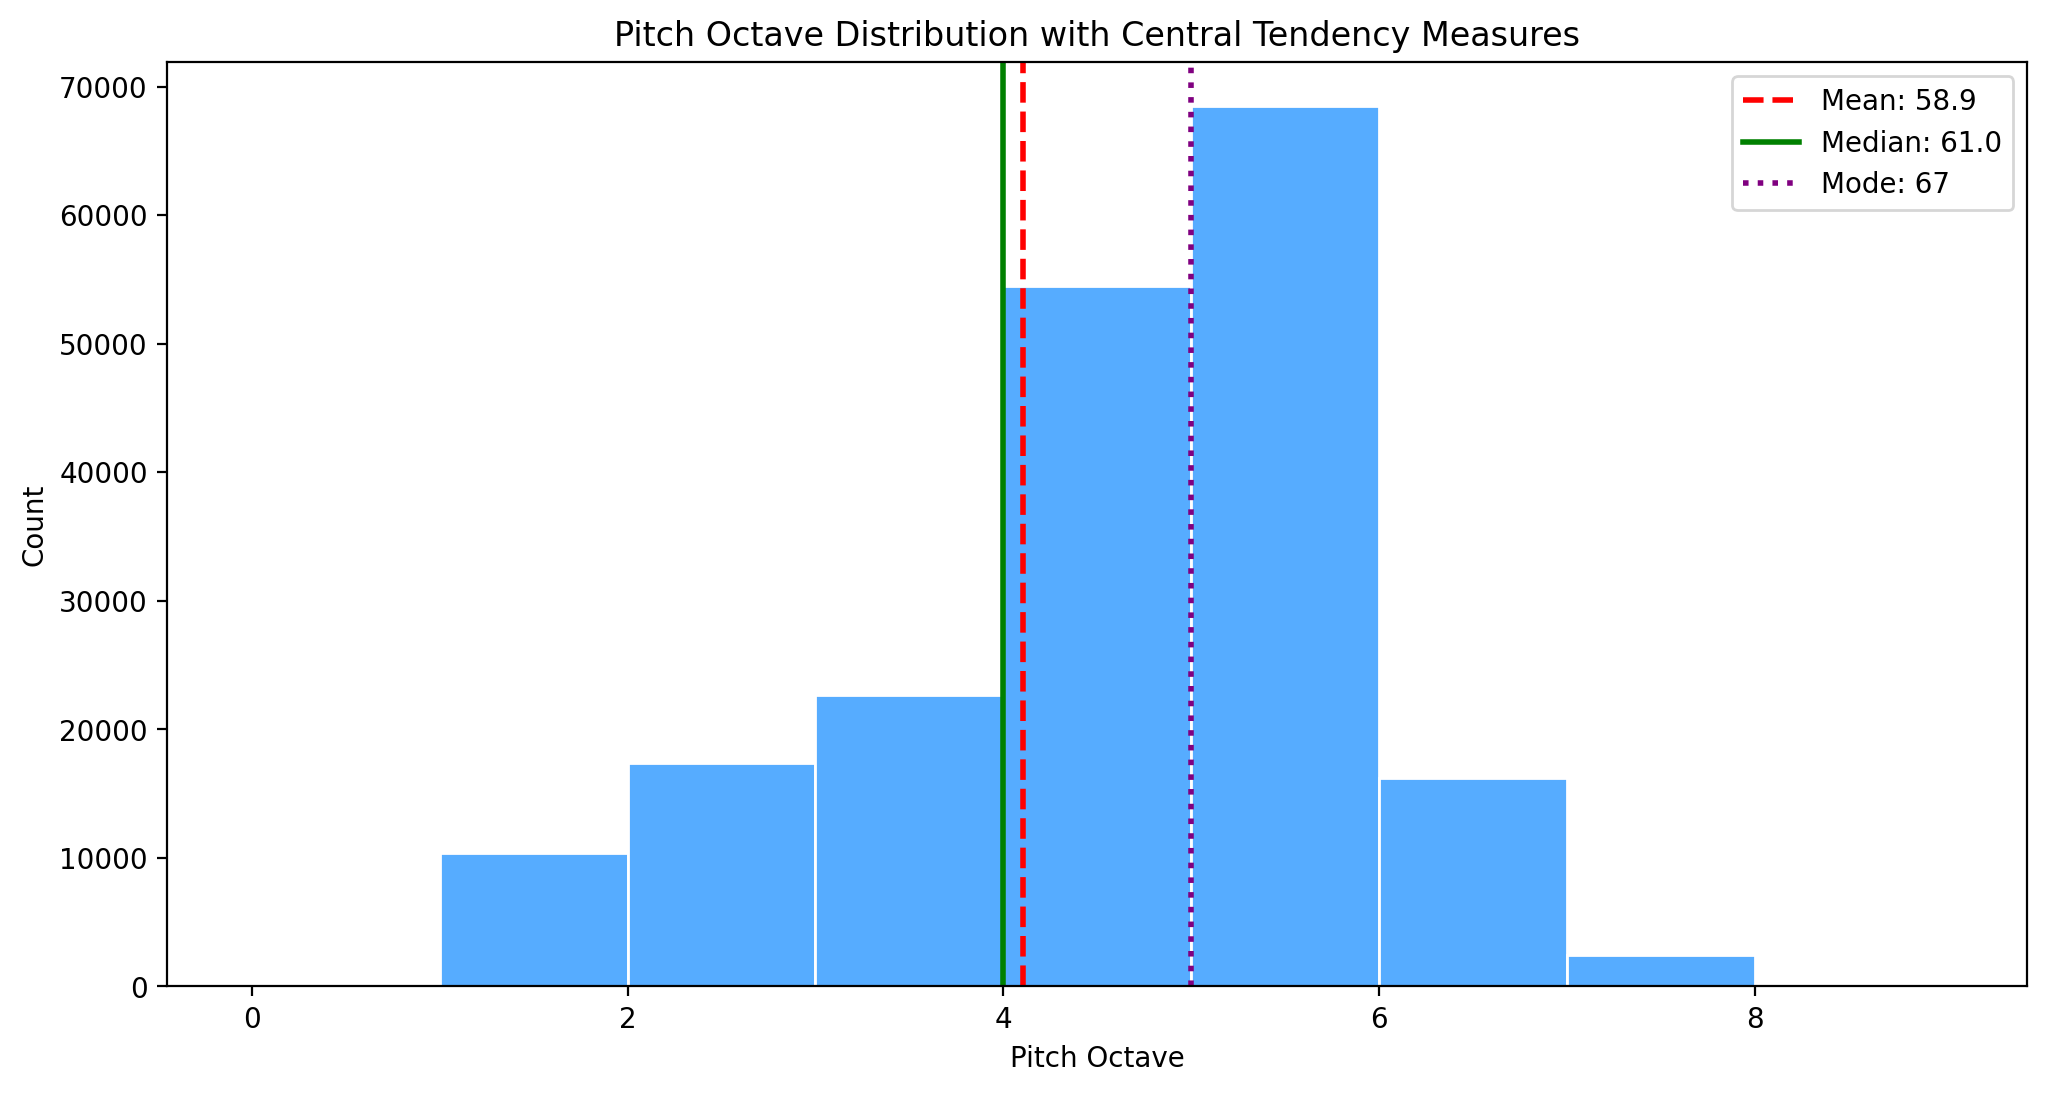

In [129]:
plt.figure(figsize=(12, 6))
sns.histplot(df['pitch_octave'], bins=range(0, 10), color='dodgerblue', edgecolor='white')

# Add lines for mean, median, and mode
plt.axvline(mean_pitch_octave, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_pitch:.1f}')
plt.axvline(median_pitch_octave, color='green', linestyle='-', linewidth=2, label=f'Median: {median_pitch}')
plt.axvline(mode_pitch_octave, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_pitch}')

plt.title('Pitch Octave Distribution with Central Tendency Measures')
plt.xlabel('Pitch Octave')
plt.ylabel('Count')
plt.legend()
plt.show()

##### 2.3.3.2 Outlier Detection in Pitch Octave Values

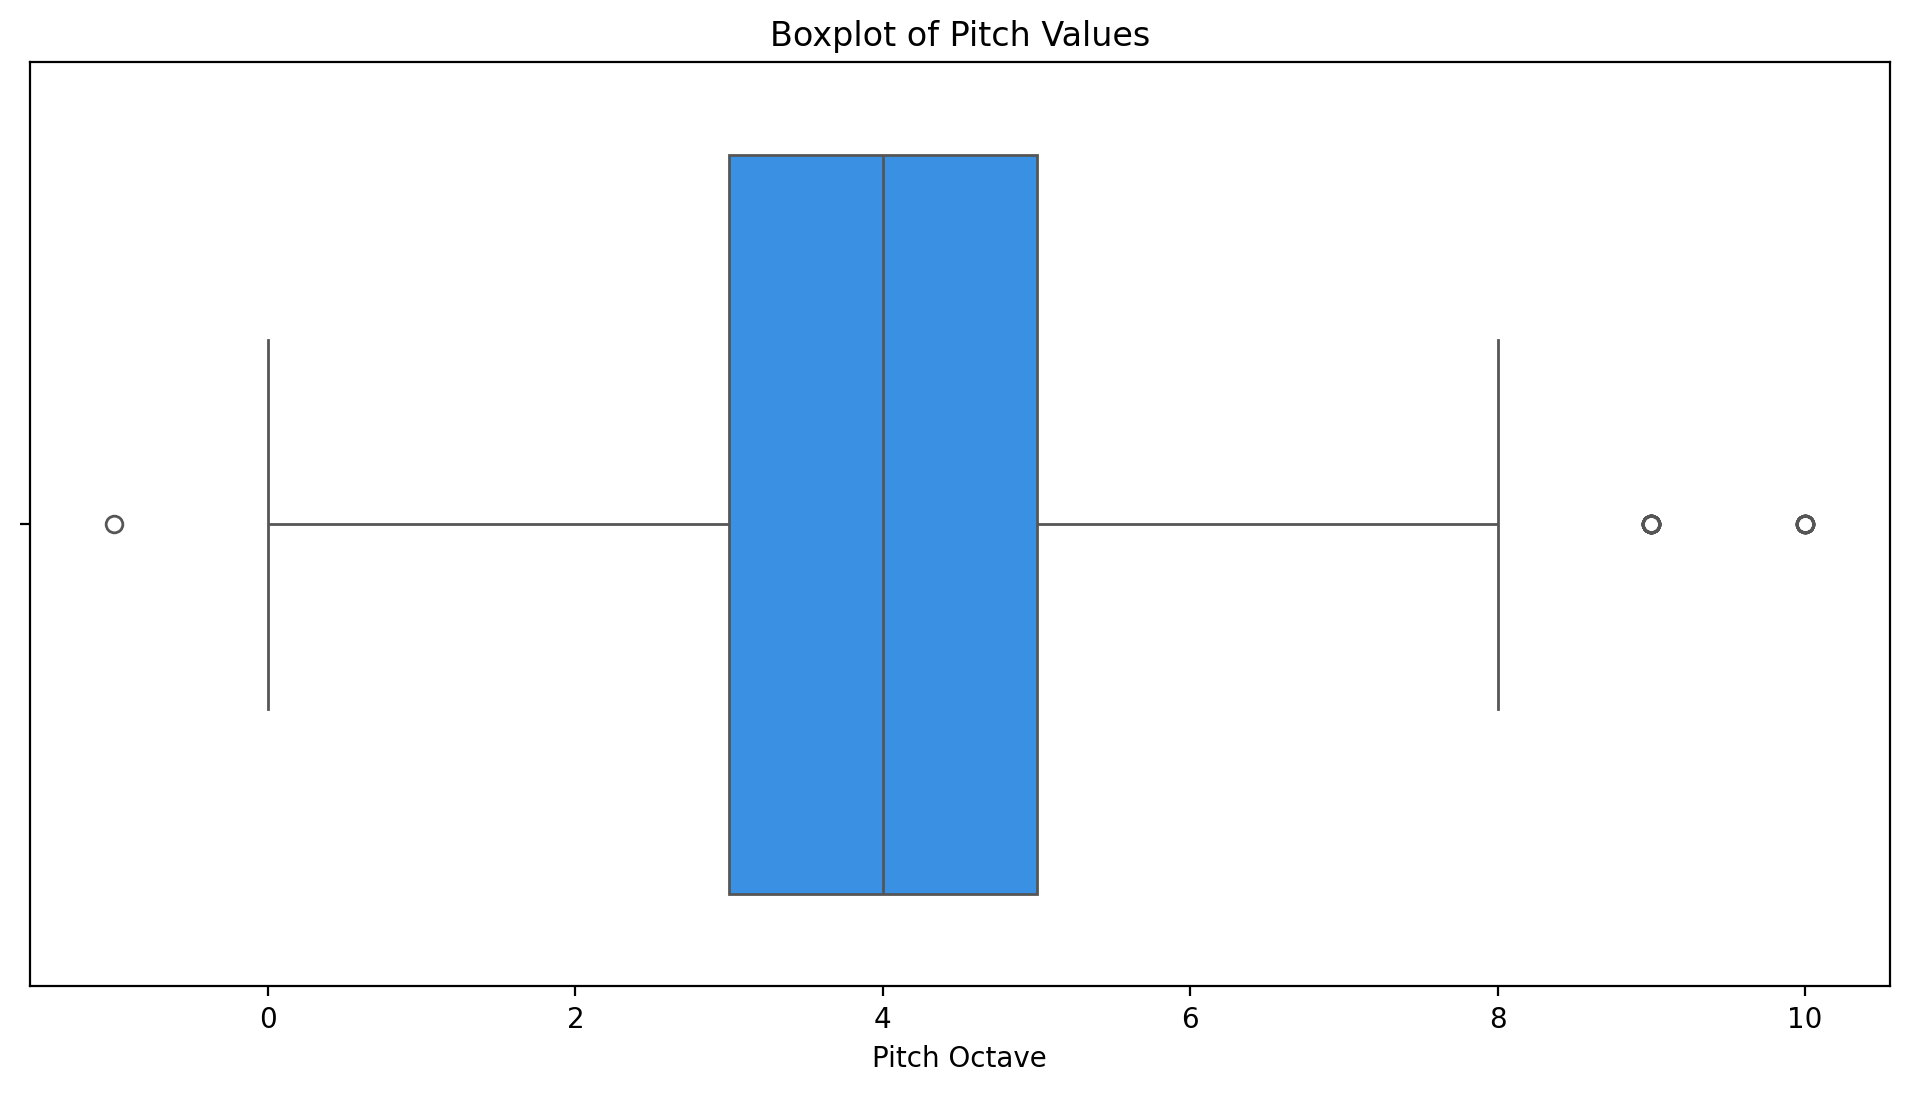

In [130]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['pitch_octave'], color='dodgerblue')
plt.title('Boxplot of Pitch Values')
plt.xlabel('Pitch Octave')
plt.show()

##### 2.3.3.3 Pitch Octave Values in Context: Key, Instrument, and Genre

In [131]:
# Descriptive statistics pitch by key
print("Pitch Octave statistics by Key:")
df.groupby('key')['pitch_octave'].describe().sort_index()

Pitch Octave statistics by Key:


count      mean       std  min  25%  50%  75%   max
key                                                       
0    11608.0  4.311165  1.333120  1.0  4.0  5.0  5.0   7.0
1     8535.0  4.139192  1.361729  1.0  3.0  5.0  5.0   6.0
2     5075.0  3.477241  1.282836  1.0  2.0  4.0  4.0   6.0
3    13501.0  3.884823  1.486530  0.0  2.0  4.0  5.0   7.0
4     8834.0  4.339144  1.253724  1.0  4.0  5.0  5.0   8.0
5    17733.0  4.226752  1.402304  1.0  4.0  5.0  5.0   8.0
6     4806.0  4.520599  1.095394  1.0  4.0  5.0  5.0   7.0
7    10897.0  4.623658  1.133670  1.0  4.0  5.0  5.0   7.0
9     3344.0  3.809809  1.519348  1.0  3.0  4.0  5.0   7.0
11   24410.0  4.063335  1.248180 -1.0  3.0  4.0  5.0   7.0
12    7224.0  4.300664  0.884822  1.0  4.0  4.0  5.0   6.0
13    9294.0  3.847966  1.326183  1.0  3.0  4.0  5.0   7.0
14    7794.0  3.913652  1.497030  1.0  3.0  4.0  5.0  10.0
15    1626.0  3.801968  1.085919  2.0  3.0  4.0  4.0   7.0
16   19702.0  4.152167  1.246808  1.0  4.0  4.0  5.0  10.0
17    7936.0  4.380922  1.210096  1.0  4.0  4.0  5.0   8.0
19   16036.0  3.893365  1.485186  0.0  3.0  4.0  5.0   8.0
21    8261.0  3.695436  1.345413  1.0  2.0  4.0  5.0   7.0
23    5576.0  4.091105  1.060985  1.0  4.0  4.0  5.0   7.0

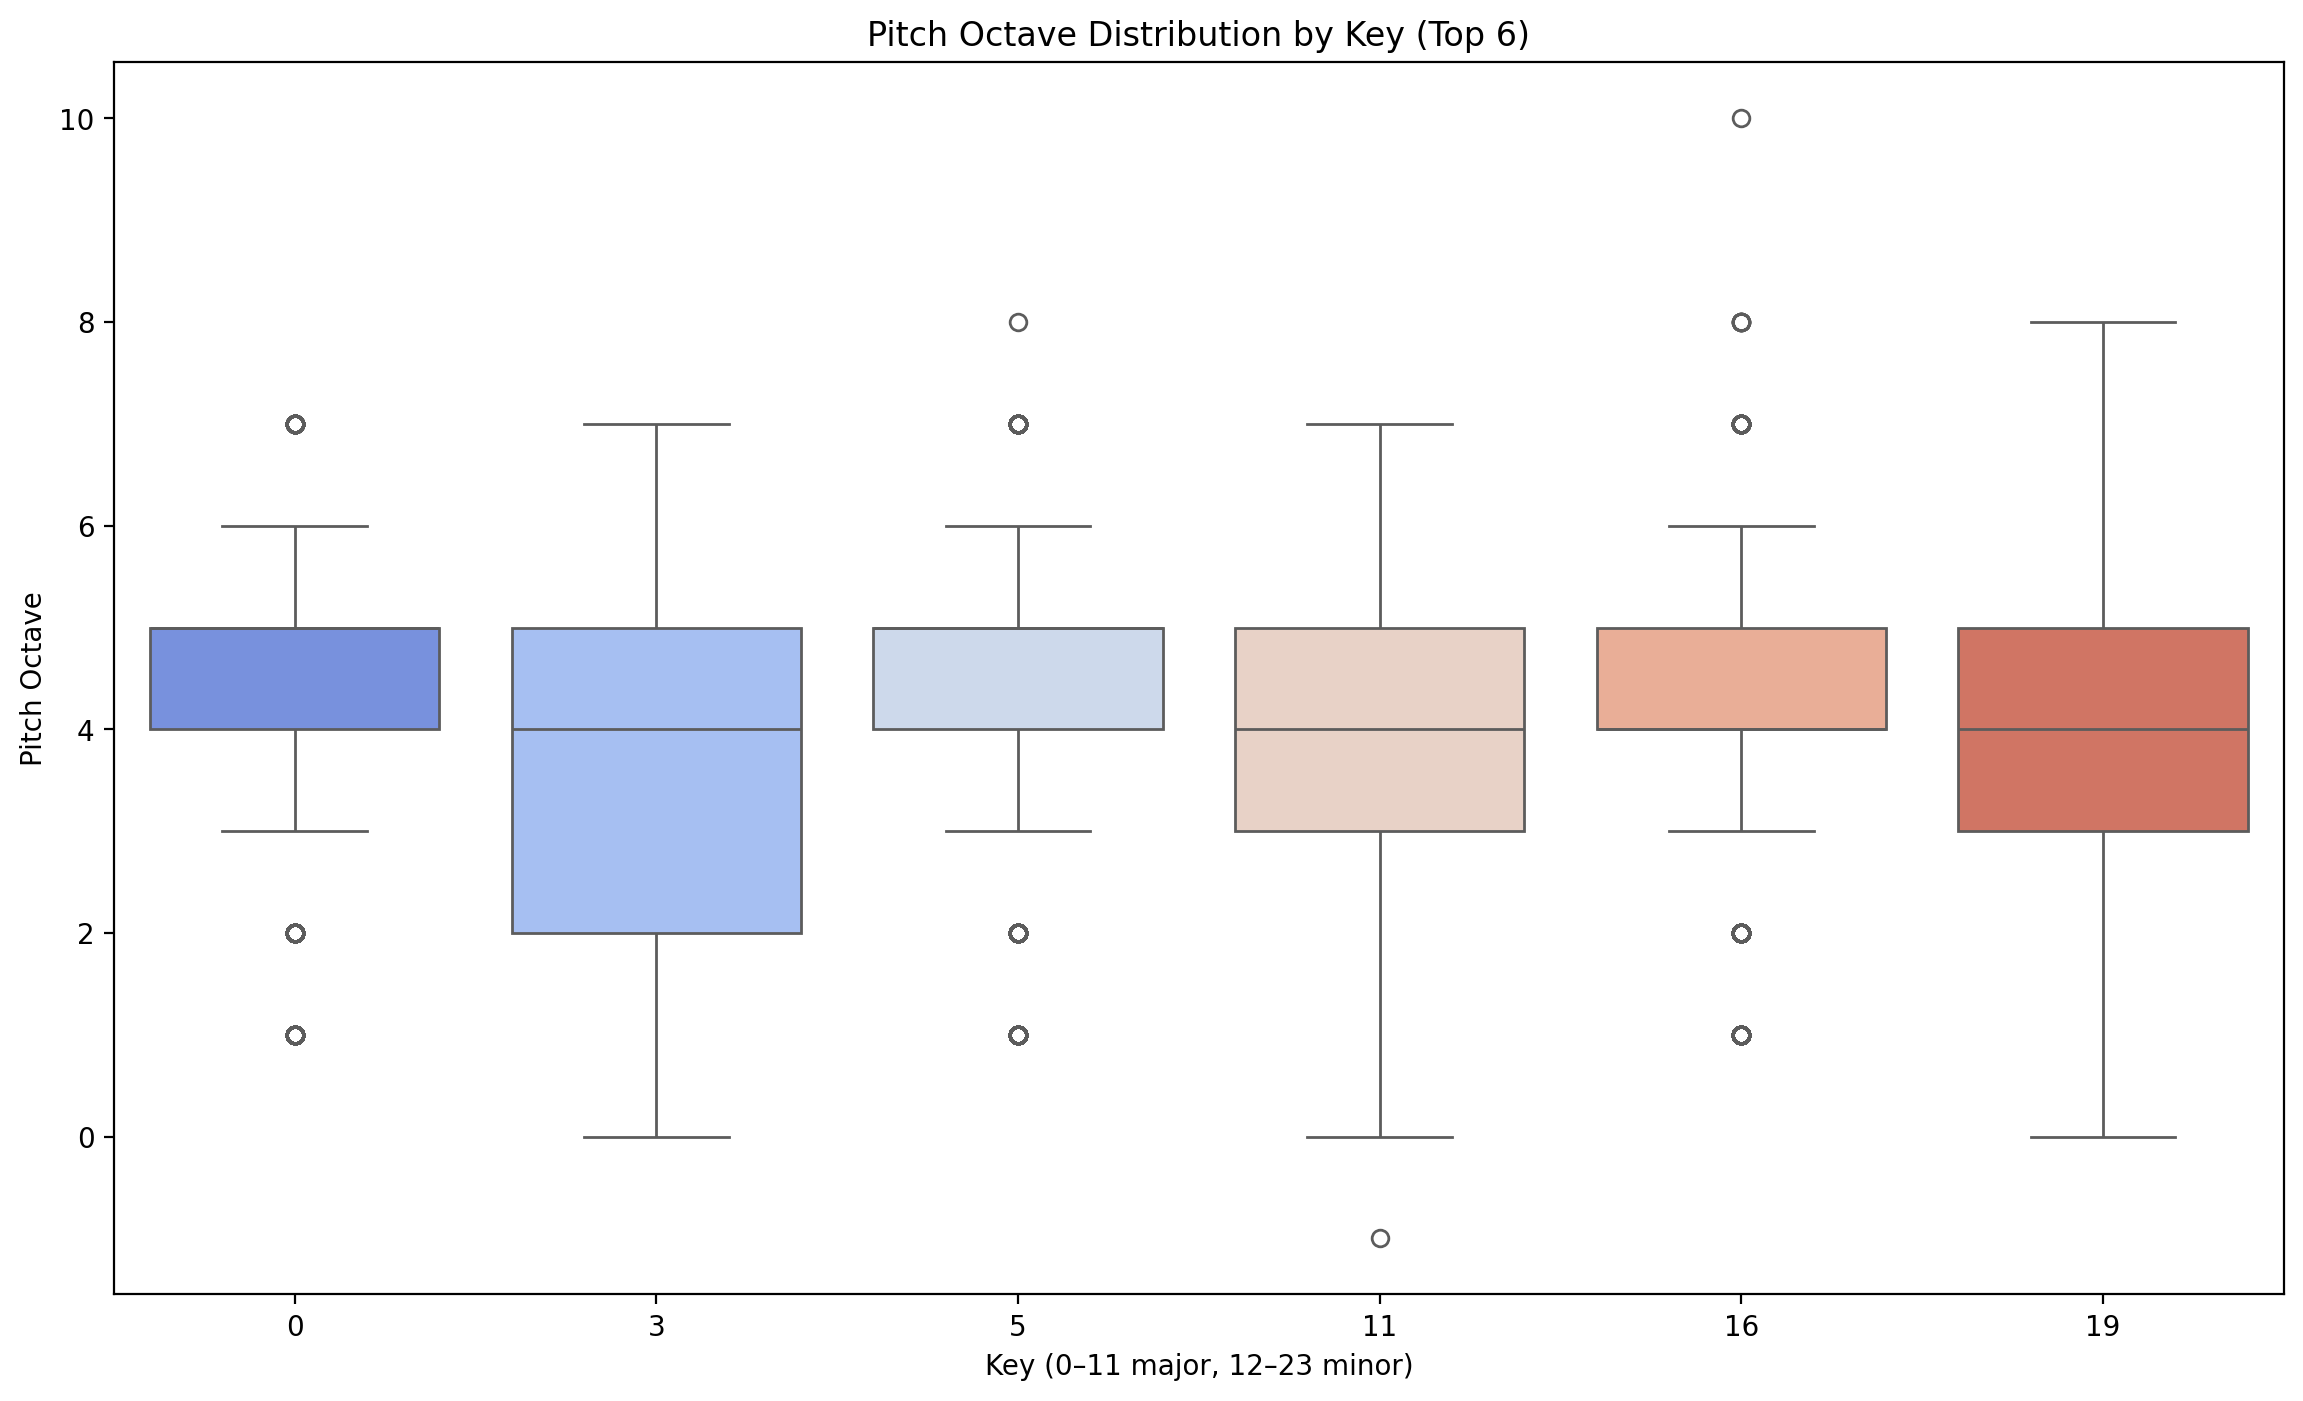

In [132]:
# Pitch Octave distribution across top 6 keys to show tonal variation.
plt.figure(figsize=(14,8))
sns.boxplot(data=df[df['key'].isin(top_keys)], x='key', y='pitch_octave', palette='coolwarm')
plt.title('Pitch Octave Distribution by Key (Top 6)')
plt.xlabel('Key (0–11 major, 12–23 minor)')
plt.ylabel('Pitch Octave')
plt.show()

In [133]:
# Descriptive statistics of pitch octave values by instrument
print("Pitch Octave statistics by Instrument:")
df.groupby('instrument')['pitch_octave'].describe()

Pitch Octave statistics by Instrument:


count      mean       std  min  25%  50%  75%   max
instrument                                                             
Acoustic Bass     11262.0  3.980554  1.237628  1.0  3.0  4.0  5.0   7.0
Acoustic Guitar   18001.0  4.030387  1.213315  0.0  3.0  4.0  5.0   7.0
Bagpipes           4865.0  4.437821  1.387758  1.0  4.0  5.0  5.0   6.0
Bassoon            1729.0  3.825333  1.018137  1.0  3.0  4.0  5.0   5.0
Celesta            8514.0  4.046864  1.413229  1.0  3.0  5.0  5.0  10.0
Choir              2984.0  3.785523  1.152870  1.0  3.0  4.0  5.0   7.0
Clarinet            998.0  3.649299  1.238489  1.0  3.0  4.0  4.0   7.0
Contrabass         9168.0  4.774215  1.090566  2.0  4.0  5.0  6.0   7.0
Electric Bass       647.0  4.123648  0.950890  1.0  4.0  4.0  5.0   6.0
Electric Guitar   21454.0  4.090473  1.292842 -1.0  4.0  4.0  5.0   7.0
Electric Organ     2280.0  3.814474  1.841280  1.0  2.0  4.0  5.0   7.0
Fretless Bass      4777.0  4.482730  1.203953  1.0  4.0  5.0  5.0   7.0
Glockenspiel        133.0  4.578947  1.684198  1.0  4.0  4.0  6.0   7.0
Marimba             235.0  3.587234  0.688618  2.0  3.0  4.0  4.0   5.0
Ocarina             575.0  4.553043  1.370503  1.0  4.0  5.0  6.0   7.0
Piano             38177.0  4.116536  1.294256  1.0  4.0  4.0  5.0  10.0
Piccolo            1462.0  4.069083  0.793550  2.0  4.0  4.0  4.0   6.0
Recorder           1097.0  4.965360  1.486154  2.0  4.0  5.0  6.0   7.0
Sampler           23546.0  3.725813  1.425191  0.0  3.0  4.0  5.0   8.0
StringInstrument   4078.0  4.026238  1.023658  1.0  3.0  4.0  5.0   6.0
Taiko                61.0  4.196721  0.542208  2.0  4.0  4.0  4.0   6.0
Timpani            1450.0  3.720000  0.931883  1.0  3.0  4.0  4.0   6.0
Trombone           4529.0  3.671230  1.057685  0.0  3.0  4.0  4.0   6.0
Trumpet             105.0  5.200000  1.281526  3.0  4.0  6.0  6.0   7.0
Unknown           14549.0  4.381401  1.381180  0.0  4.0  5.0  5.0   7.0
Violoncello         360.0  3.191667  1.094141  1.0  3.0  3.0  4.0   5.0
Voice             11500.0  4.483478  1.252525  1.0  4.0  5.0  5.0   8.0
Whistle            3656.0  3.643873  1.825666  1.0  1.0  4.0  5.0   8.0

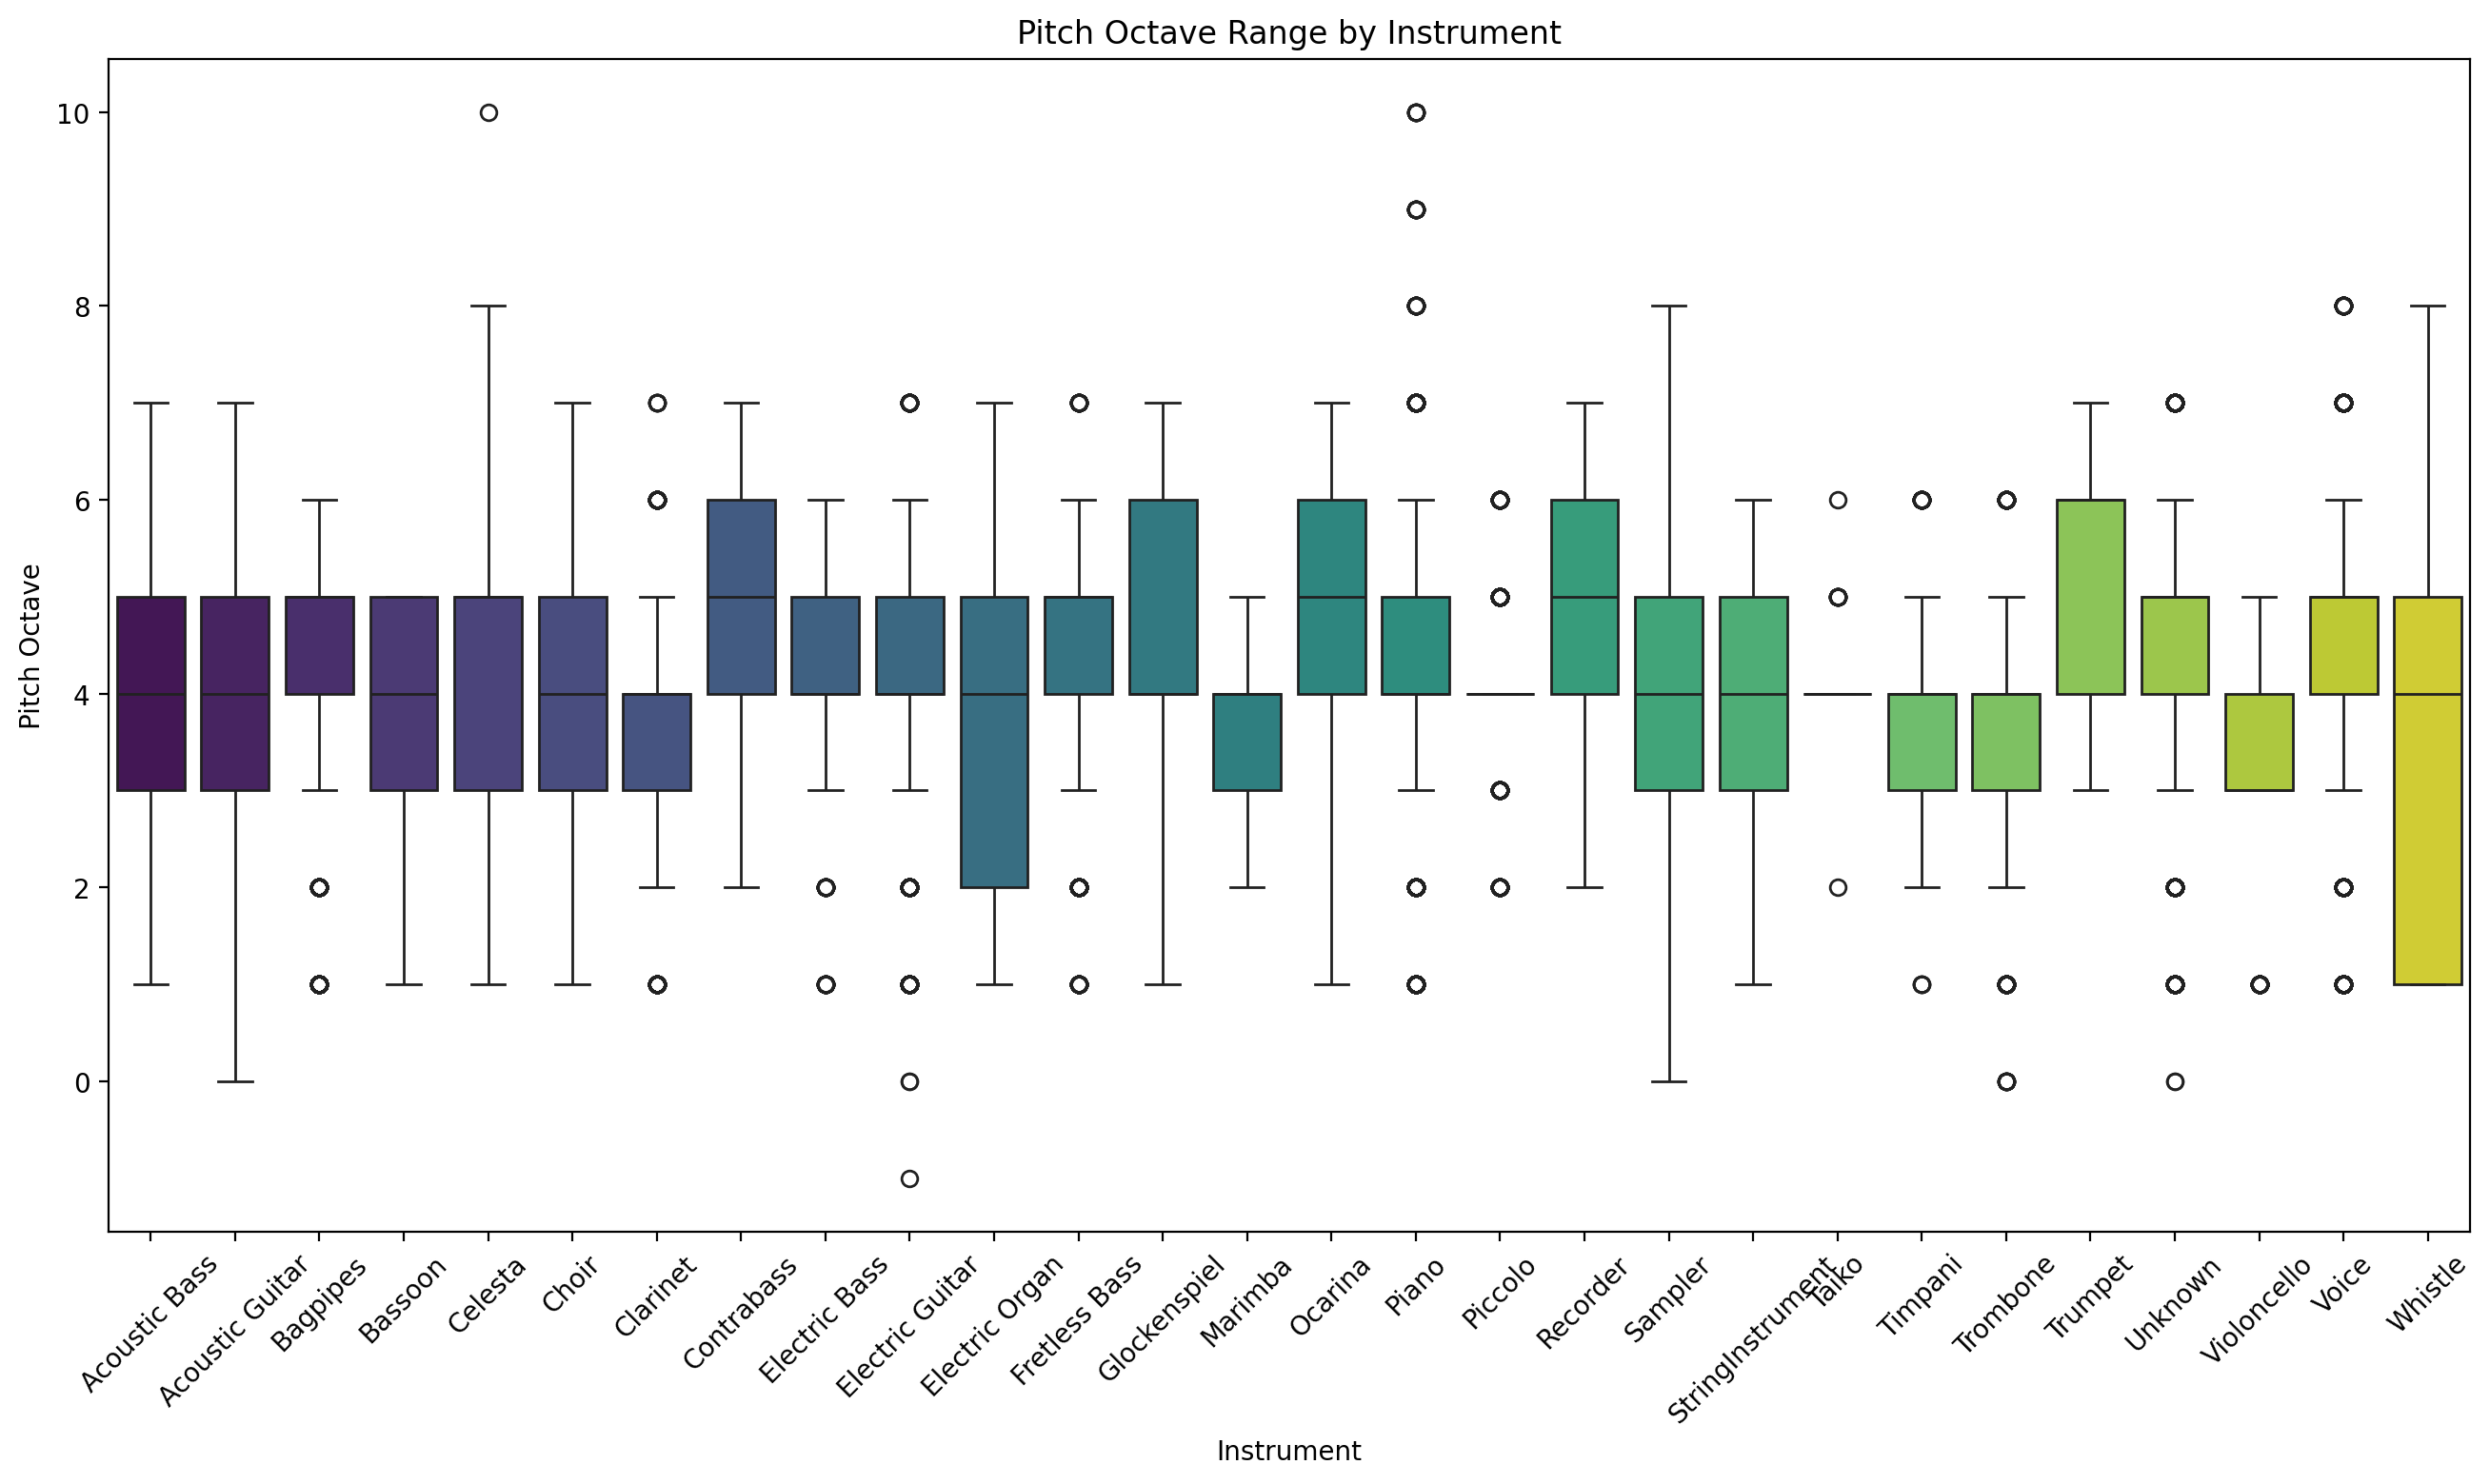

In [134]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='instrument', y='pitch_octave', palette='viridis', order=alphabetic_order)
plt.xticks(rotation=45)
plt.title('Pitch Octave Range by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Pitch Octave')
plt.show()

In [135]:
# Descriptive statistics of pitch octave values by instrument family
print("Pitch Octave statistics by Instrument Family:")
df.groupby('instrument')['pitch_octave'].describe()

Pitch Octave statistics by Instrument Family:


count      mean       std  min  25%  50%  75%   max
instrument                                                             
Acoustic Bass     11262.0  3.980554  1.237628  1.0  3.0  4.0  5.0   7.0
Acoustic Guitar   18001.0  4.030387  1.213315  0.0  3.0  4.0  5.0   7.0
Bagpipes           4865.0  4.437821  1.387758  1.0  4.0  5.0  5.0   6.0
Bassoon            1729.0  3.825333  1.018137  1.0  3.0  4.0  5.0   5.0
Celesta            8514.0  4.046864  1.413229  1.0  3.0  5.0  5.0  10.0
Choir              2984.0  3.785523  1.152870  1.0  3.0  4.0  5.0   7.0
Clarinet            998.0  3.649299  1.238489  1.0  3.0  4.0  4.0   7.0
Contrabass         9168.0  4.774215  1.090566  2.0  4.0  5.0  6.0   7.0
Electric Bass       647.0  4.123648  0.950890  1.0  4.0  4.0  5.0   6.0
Electric Guitar   21454.0  4.090473  1.292842 -1.0  4.0  4.0  5.0   7.0
Electric Organ     2280.0  3.814474  1.841280  1.0  2.0  4.0  5.0   7.0
Fretless Bass      4777.0  4.482730  1.203953  1.0  4.0  5.0  5.0   7.0
Glockenspiel        133.0  4.578947  1.684198  1.0  4.0  4.0  6.0   7.0
Marimba             235.0  3.587234  0.688618  2.0  3.0  4.0  4.0   5.0
Ocarina             575.0  4.553043  1.370503  1.0  4.0  5.0  6.0   7.0
Piano             38177.0  4.116536  1.294256  1.0  4.0  4.0  5.0  10.0
Piccolo            1462.0  4.069083  0.793550  2.0  4.0  4.0  4.0   6.0
Recorder           1097.0  4.965360  1.486154  2.0  4.0  5.0  6.0   7.0
Sampler           23546.0  3.725813  1.425191  0.0  3.0  4.0  5.0   8.0
StringInstrument   4078.0  4.026238  1.023658  1.0  3.0  4.0  5.0   6.0
Taiko                61.0  4.196721  0.542208  2.0  4.0  4.0  4.0   6.0
Timpani            1450.0  3.720000  0.931883  1.0  3.0  4.0  4.0   6.0
Trombone           4529.0  3.671230  1.057685  0.0  3.0  4.0  4.0   6.0
Trumpet             105.0  5.200000  1.281526  3.0  4.0  6.0  6.0   7.0
Unknown           14549.0  4.381401  1.381180  0.0  4.0  5.0  5.0   7.0
Violoncello         360.0  3.191667  1.094141  1.0  3.0  3.0  4.0   5.0
Voice             11500.0  4.483478  1.252525  1.0  4.0  5.0  5.0   8.0
Whistle            3656.0  3.643873  1.825666  1.0  1.0  4.0  5.0   8.0

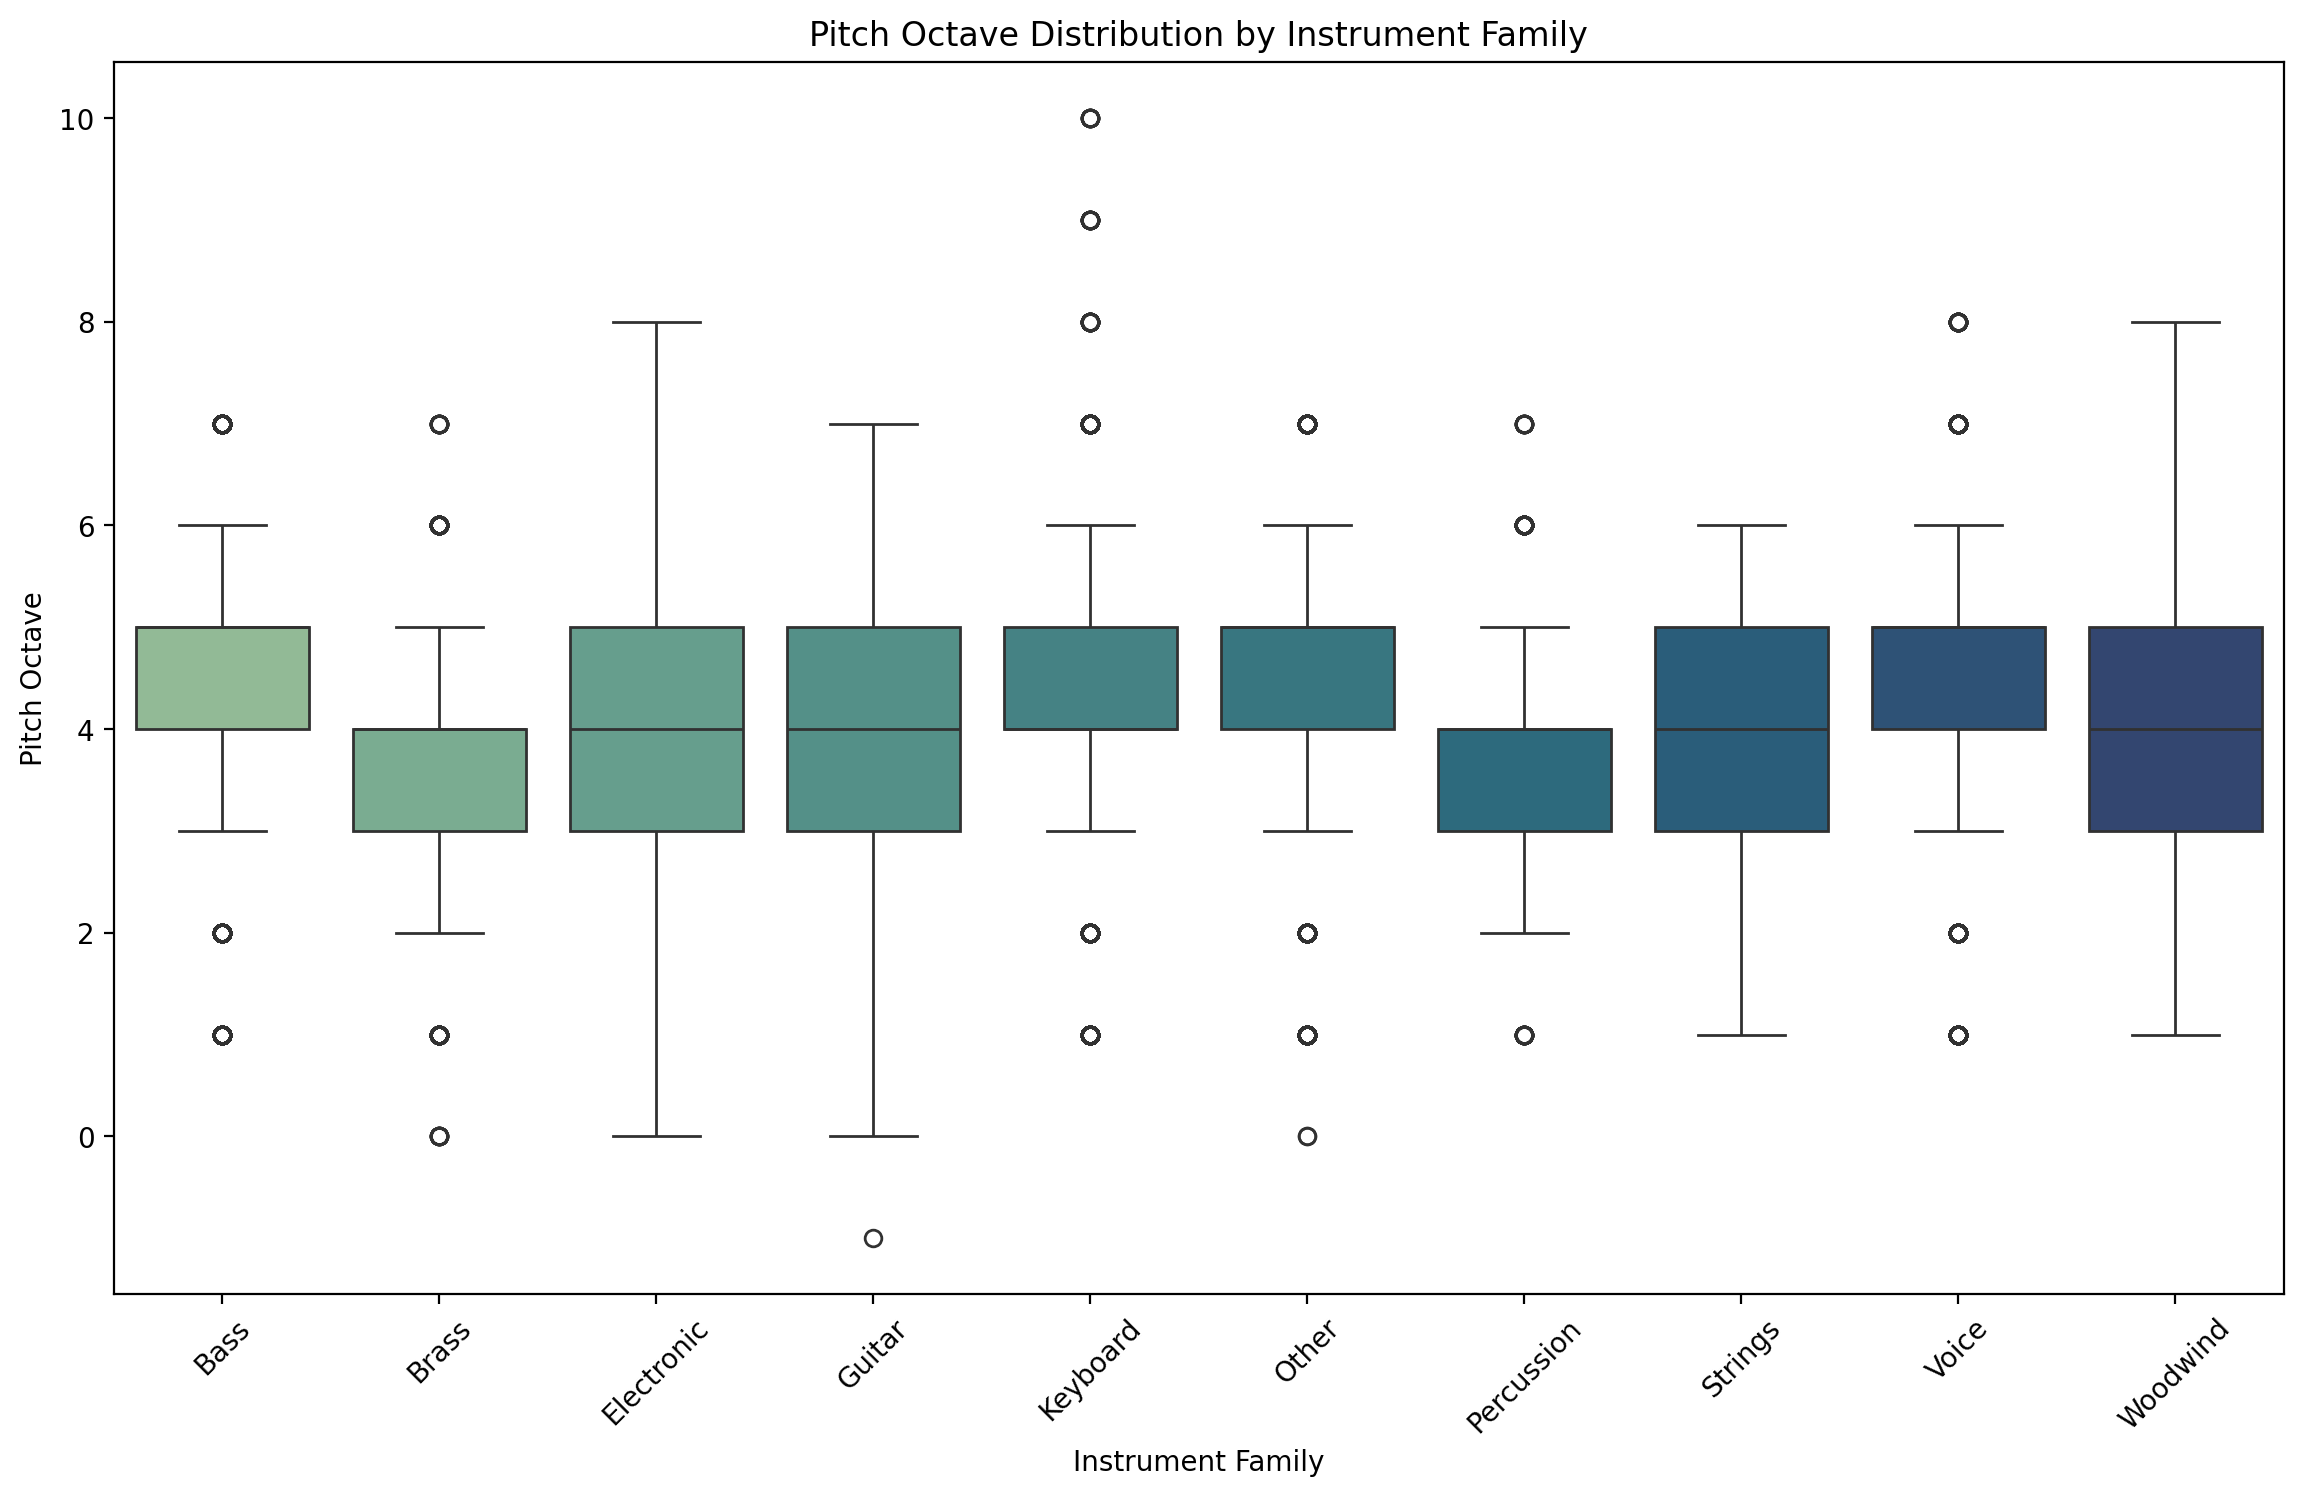

In [136]:
# Filter and plot pitch octave distribution by instrument family
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='instrument_family',
    y='pitch_octave',
    palette='crest',
    order=families
)
plt.title('Pitch Octave Distribution by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Pitch Octave')
plt.xticks(rotation=45)
plt.show()

In [137]:
# Descriptive statistics of pitch octave values by genre
print("Pitch Octave statistics by Genre:")
df.groupby('genre')['pitch_octave'].describe()

Pitch Octave statistics by Genre:


count      mean       std  min  25%  50%  75%   max
genre                                                                  
alternative_rock   7460.0  3.043029  1.241093  1.0  2.0  3.0  4.0   7.0
blues             22575.0  3.938073  1.247970  1.0  3.0  4.0  5.0   7.0
classical         15371.0  4.571075  1.095953  1.0  4.0  5.0  5.0   7.0
country           14654.0  3.979528  1.341958  1.0  3.0  4.0  5.0   7.0
dance              6910.0  3.945586  1.205810  1.0  3.0  4.0  5.0   7.0
disco              9845.0  4.064195  1.433598  1.0  3.0  5.0  5.0  10.0
heavy_metal        6189.0  3.896752  1.570526  1.0  2.0  4.0  5.0   7.0
jazz              13486.0  3.874833  1.269088  0.0  3.0  4.0  5.0   7.0
new_age           21791.0  4.081318  1.131142 -1.0  4.0  4.0  5.0   7.0
pop               12478.0  4.080622  1.293286  0.0  4.0  4.0  5.0   8.0
rap               13449.0  4.358465  1.442556  1.0  4.0  5.0  5.0   8.0
reggae            14663.0  4.594626  1.217020  1.0  4.0  5.0  5.0   7.0
rnb               13780.0  4.162264  1.341343  1.0  4.0  4.0  5.0  10.0
rock               7344.0  3.586465  1.199840  1.0  2.0  4.0  4.0   7.0
soul              12197.0  4.532672  1.465696  1.0  4.0  5.0  5.0   8.0

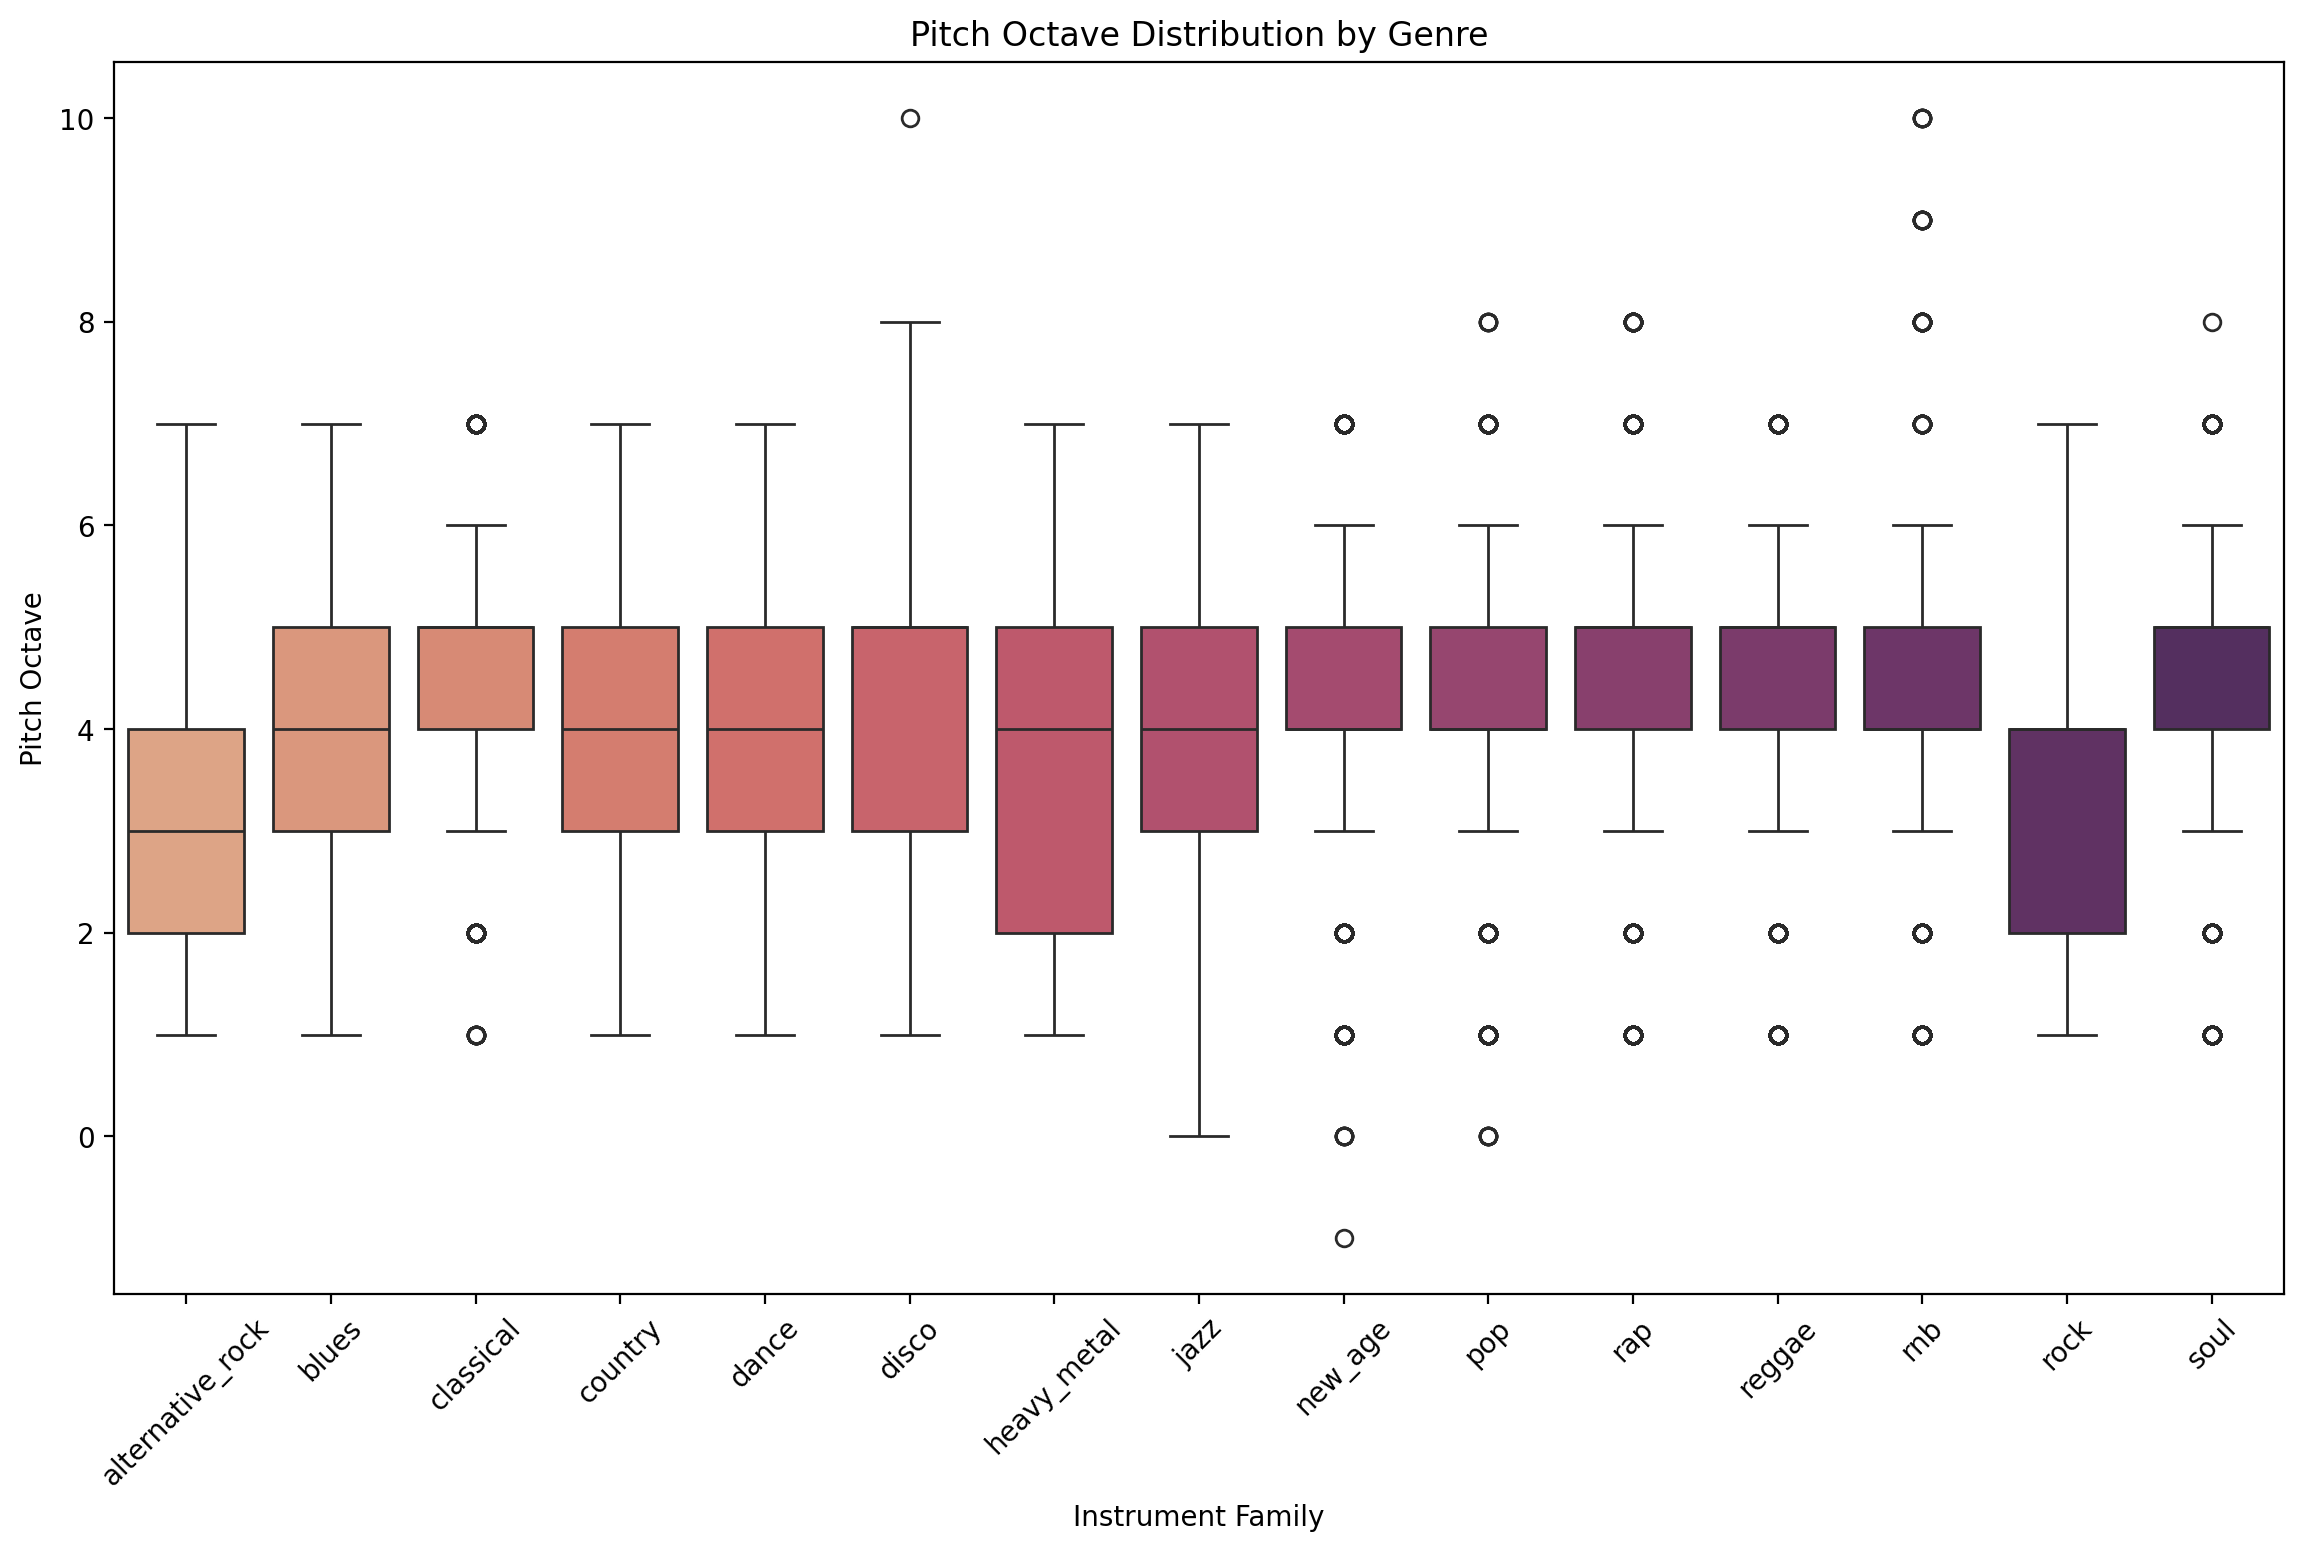

In [138]:
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='genre',
    y='pitch_octave',
    palette='flare',
    order=genres_sorted
)
plt.title('Pitch Octave Distribution by Genre')
plt.xlabel('Instrument Family')
plt.ylabel('Pitch Octave')
plt.xticks(rotation=45)
plt.show()

#### 2.3.4 Onset

##### 2.3.4.1 Central Tendency and Spread of Pitch Classes


In [139]:
df['onset'] = np.array(df['onset'], dtype=np.float64)

# Central tendency
mean_onset = df['onset'].mean()
median_onset = df['onset'].median()
mode_onset = df['onset'].mode()[0]  

# Spread
std_onset = df['onset'].std()

# Display results
print(f"Mean onset: {mean_onset:.2f}")
print(f"Median onset: {median_onset}")
print(f"Mode onset: {mode_onset}")
print(f"Standard deviation: {std_onset:.2f}")

Mean onset: 307.85
Median onset: 257.5
Mode onset: 208.0
Standard deviation: 231.27


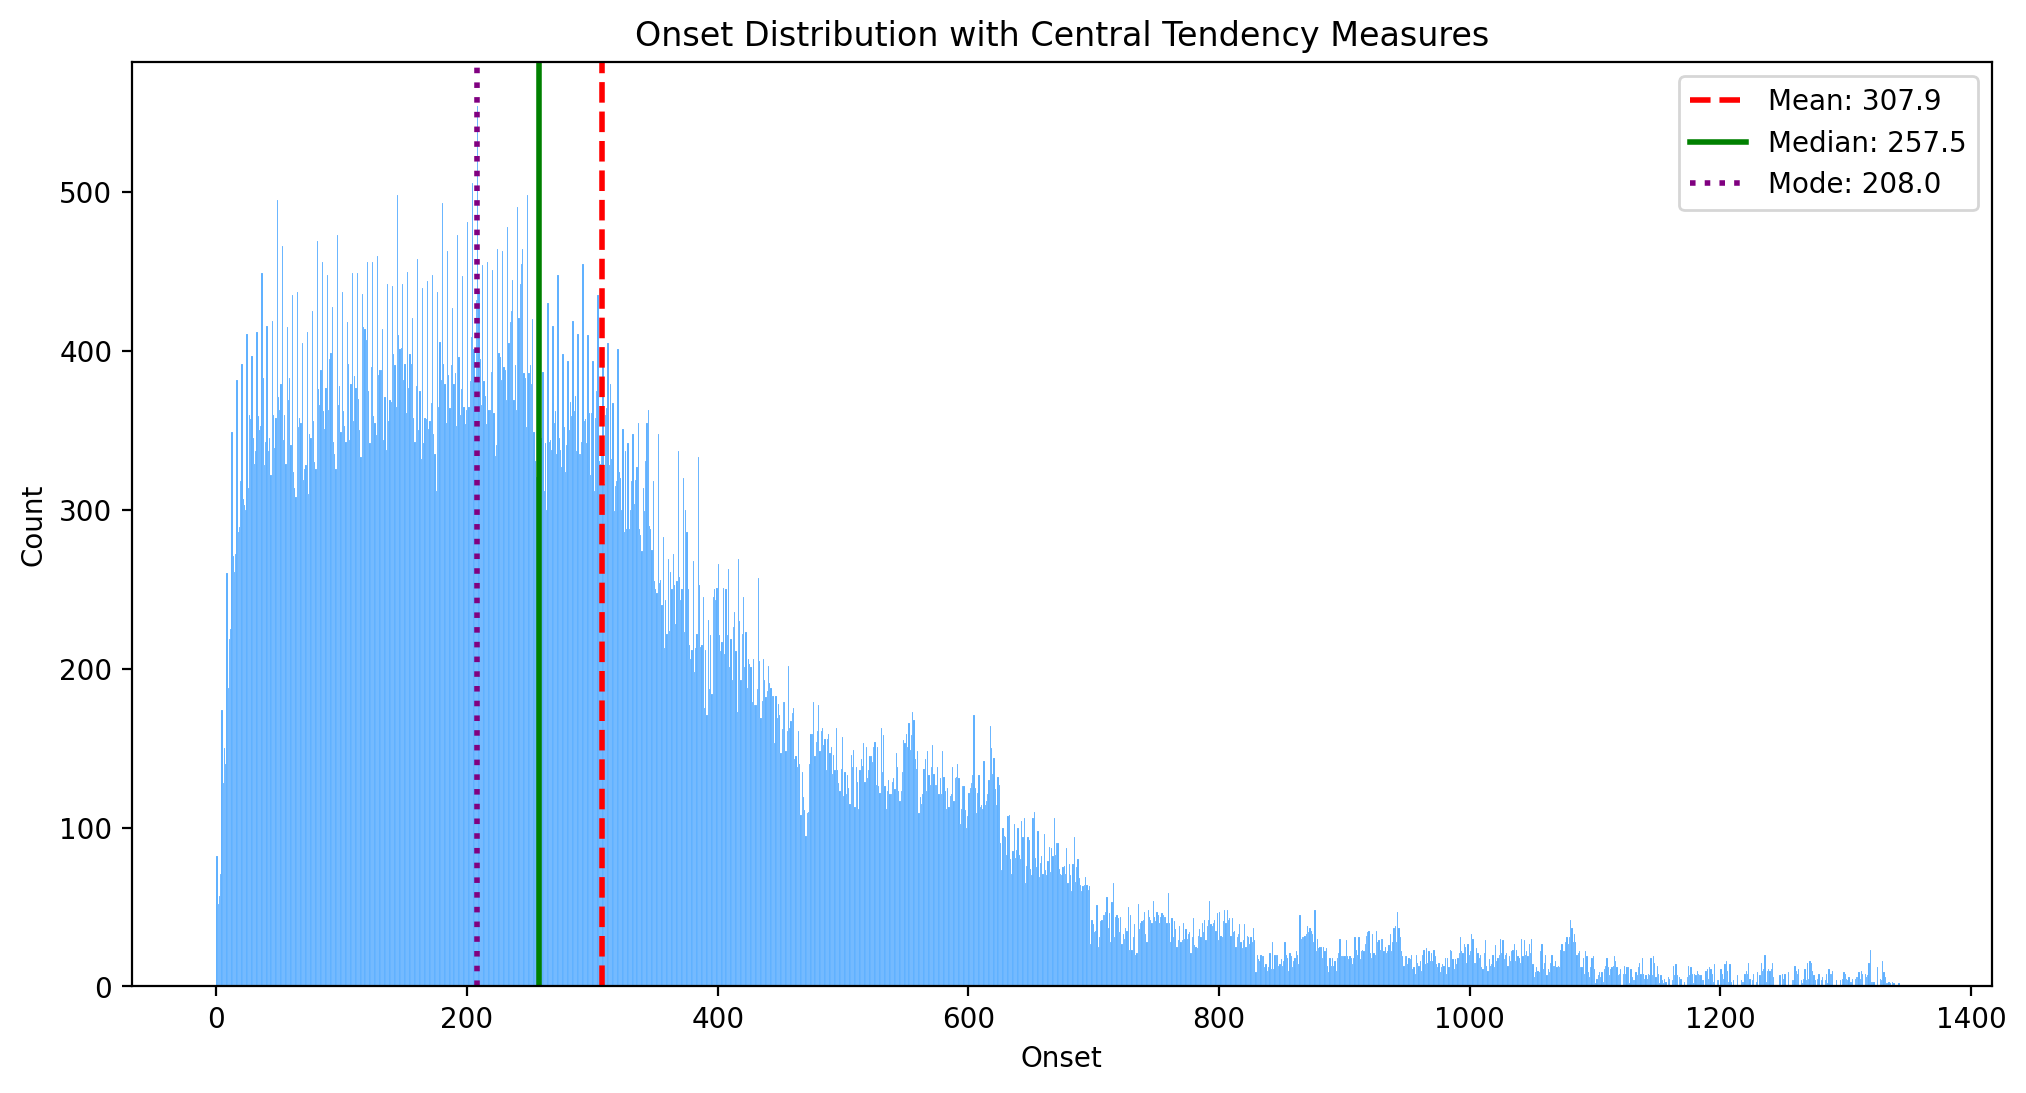

In [197]:
plt.figure(figsize=(12, 6))
sns.histplot(df['onset'], bins=range(0, 1350), color='dodgerblue', edgecolor='white')

# Add lines for mean, median, and mode
plt.axvline(mean_onset, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_onset:.1f}')
plt.axvline(median_onset, color='green', linestyle='-', linewidth=2, label=f'Median: {median_onset}')
plt.axvline(mode_onset, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_onset}')

plt.title('Onset Distribution with Central Tendency Measures')
plt.xlabel('Onset')
plt.ylabel('Count')
plt.legend()
plt.show()

##### 2.3.4.2 Outlier Detection in Onset Values

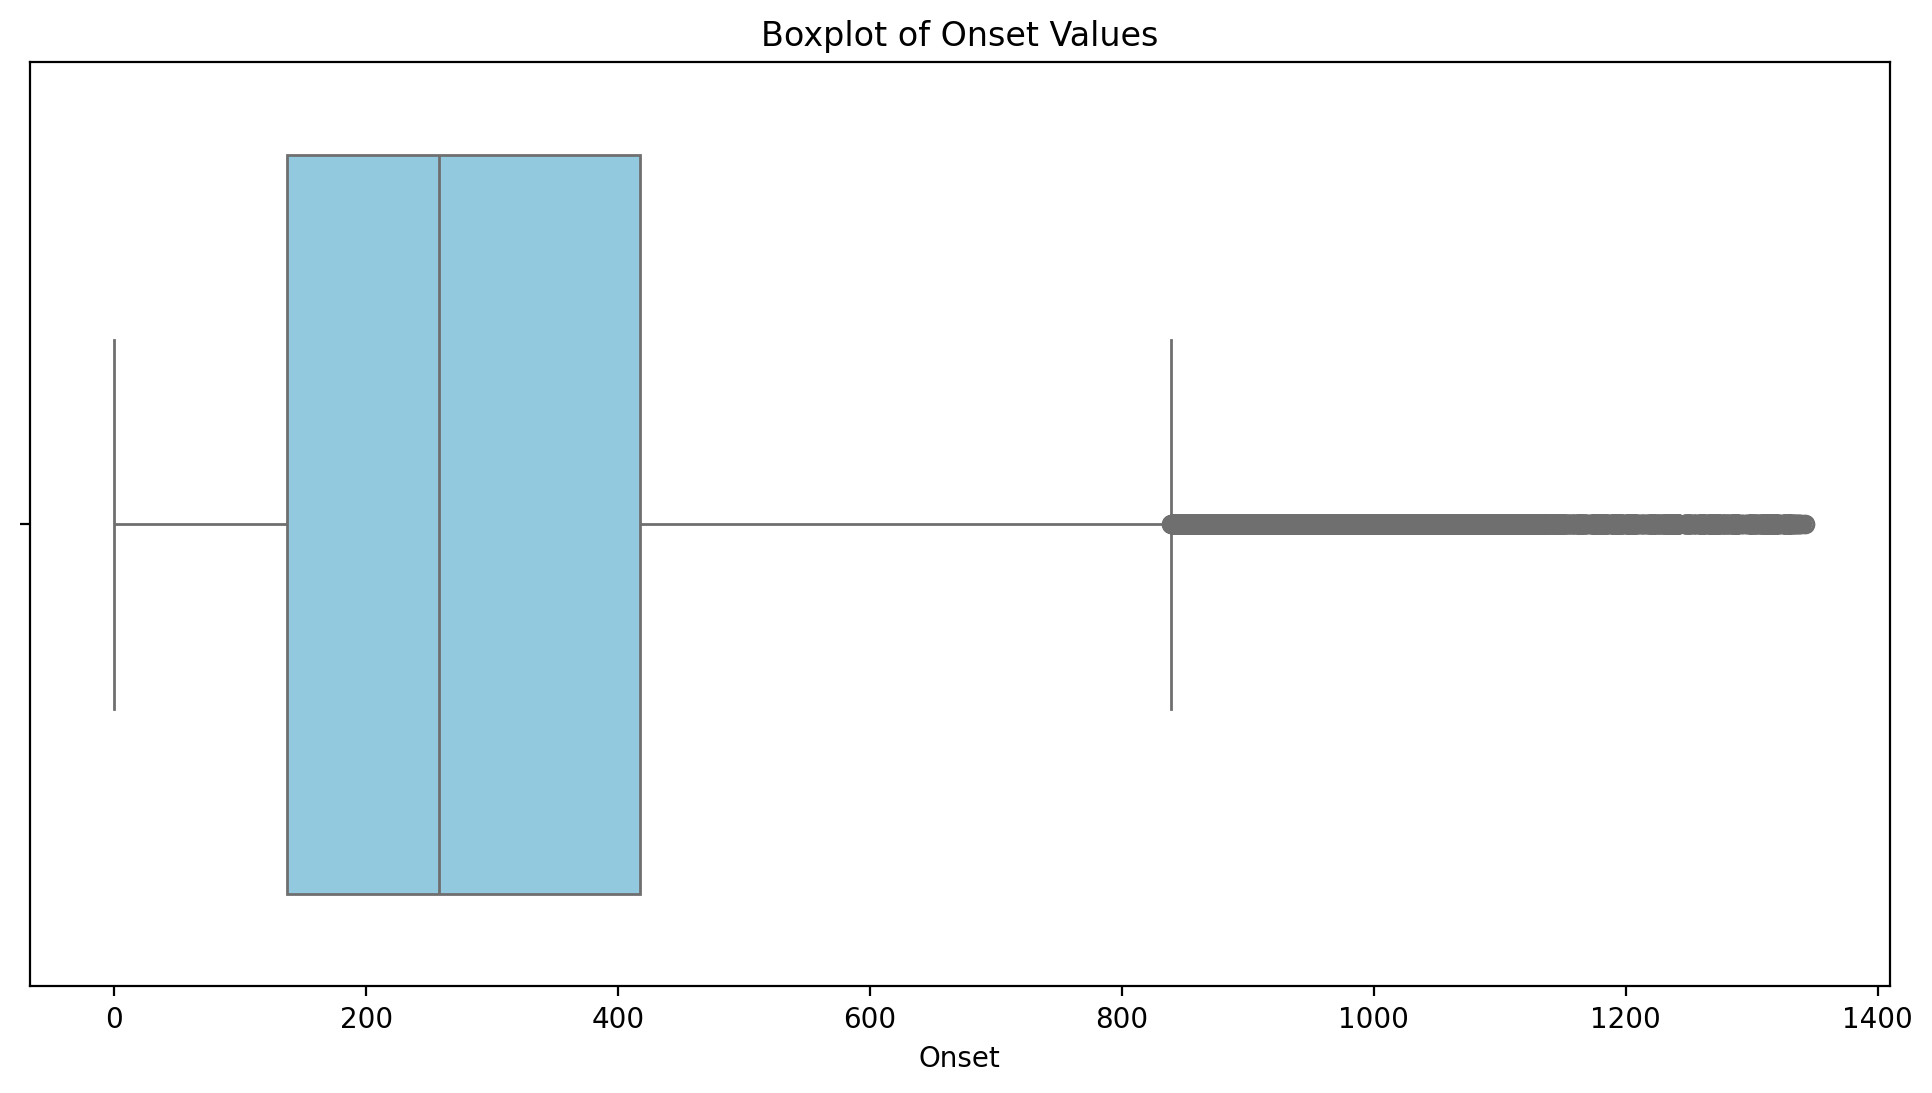

In [141]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['onset'], color='skyblue')
plt.title('Boxplot of Onset Values')
plt.xlabel('Onset')
plt.show()

##### 2.3.4.3 Onset in Context: Key, Instrument, and Genre

In [142]:
# Descriptive statistics of onset values by key
print("Onset statistics by Key:")
df.groupby('key')['onset'].describe().sort_index()

Onset statistics by Key:


count        mean         std       min         25%         50%  \
key                                                                      
0    11608.0  428.120829  335.475358  6.000000  178.500000  347.000000   
1     8535.0  247.066276  144.222329  4.000000  128.500000  239.000000   
2     5075.0  177.778851   99.875519  4.000000   89.750000  180.250000   
3    13501.0  224.220786  129.393910  0.000000  114.000000  221.000000   
4     8834.0  211.779941  124.227141  0.000000  106.750000  209.250000   
5    17733.0  343.171164  223.868407  4.000000  165.750000  287.000000   
6     4806.0  337.840148  173.484293  8.000000  190.750000  345.500000   
7    10897.0  481.297727  333.797534  0.000000  176.000000  429.750000   
9     3344.0  201.461000   89.194480  8.000000  125.000000  203.500000   
11   24410.0  388.956575  187.472291  3.666667  230.166667  455.750000   
12    7224.0  328.687650  199.081366  4.000000  169.666667  287.166667   
13    9294.0  359.349840  297.247698  4.000000  137.000000  227.000000   
14    7794.0  239.684586  131.955419  0.000000  127.500000  239.500000   
15    1626.0  175.661285   91.366036  4.000000  102.500000  174.500000   
16   19702.0  199.583109  114.898565  0.000000  101.500000  194.000000   
17    7936.0  175.587523   93.463110  7.000000   97.500000  180.500000   
19   16036.0  336.551977  309.589874  3.500000  128.000000  247.500000   
21    8261.0  208.149488  118.200015  1.000000  106.000000  210.000000   
23    5576.0  512.200726  193.373687  4.000000  401.750000  598.000000   

            75%          max  
key                           
0    562.750000  1342.500000  
1    340.500000   582.000000  
2    257.500000   439.750000  
3    328.000000   496.000000  
4    316.500000   447.000000  
5    493.000000   828.000000  
6    515.250000   618.750000  
7    765.000000  1094.000000  
9    279.500000   348.000000  
11   534.666667   758.000000  
12   485.666667   755.500000  
13   564.083333  1133.250000  
14   350.500000   464.000000  
15   256.187500   325.000000  
16   293.937500   468.750000  
17   257.500000   351.500000  
19   384.000000  1329.833333  
21   303.750000   452.750000  
23   651.666667   700.000000

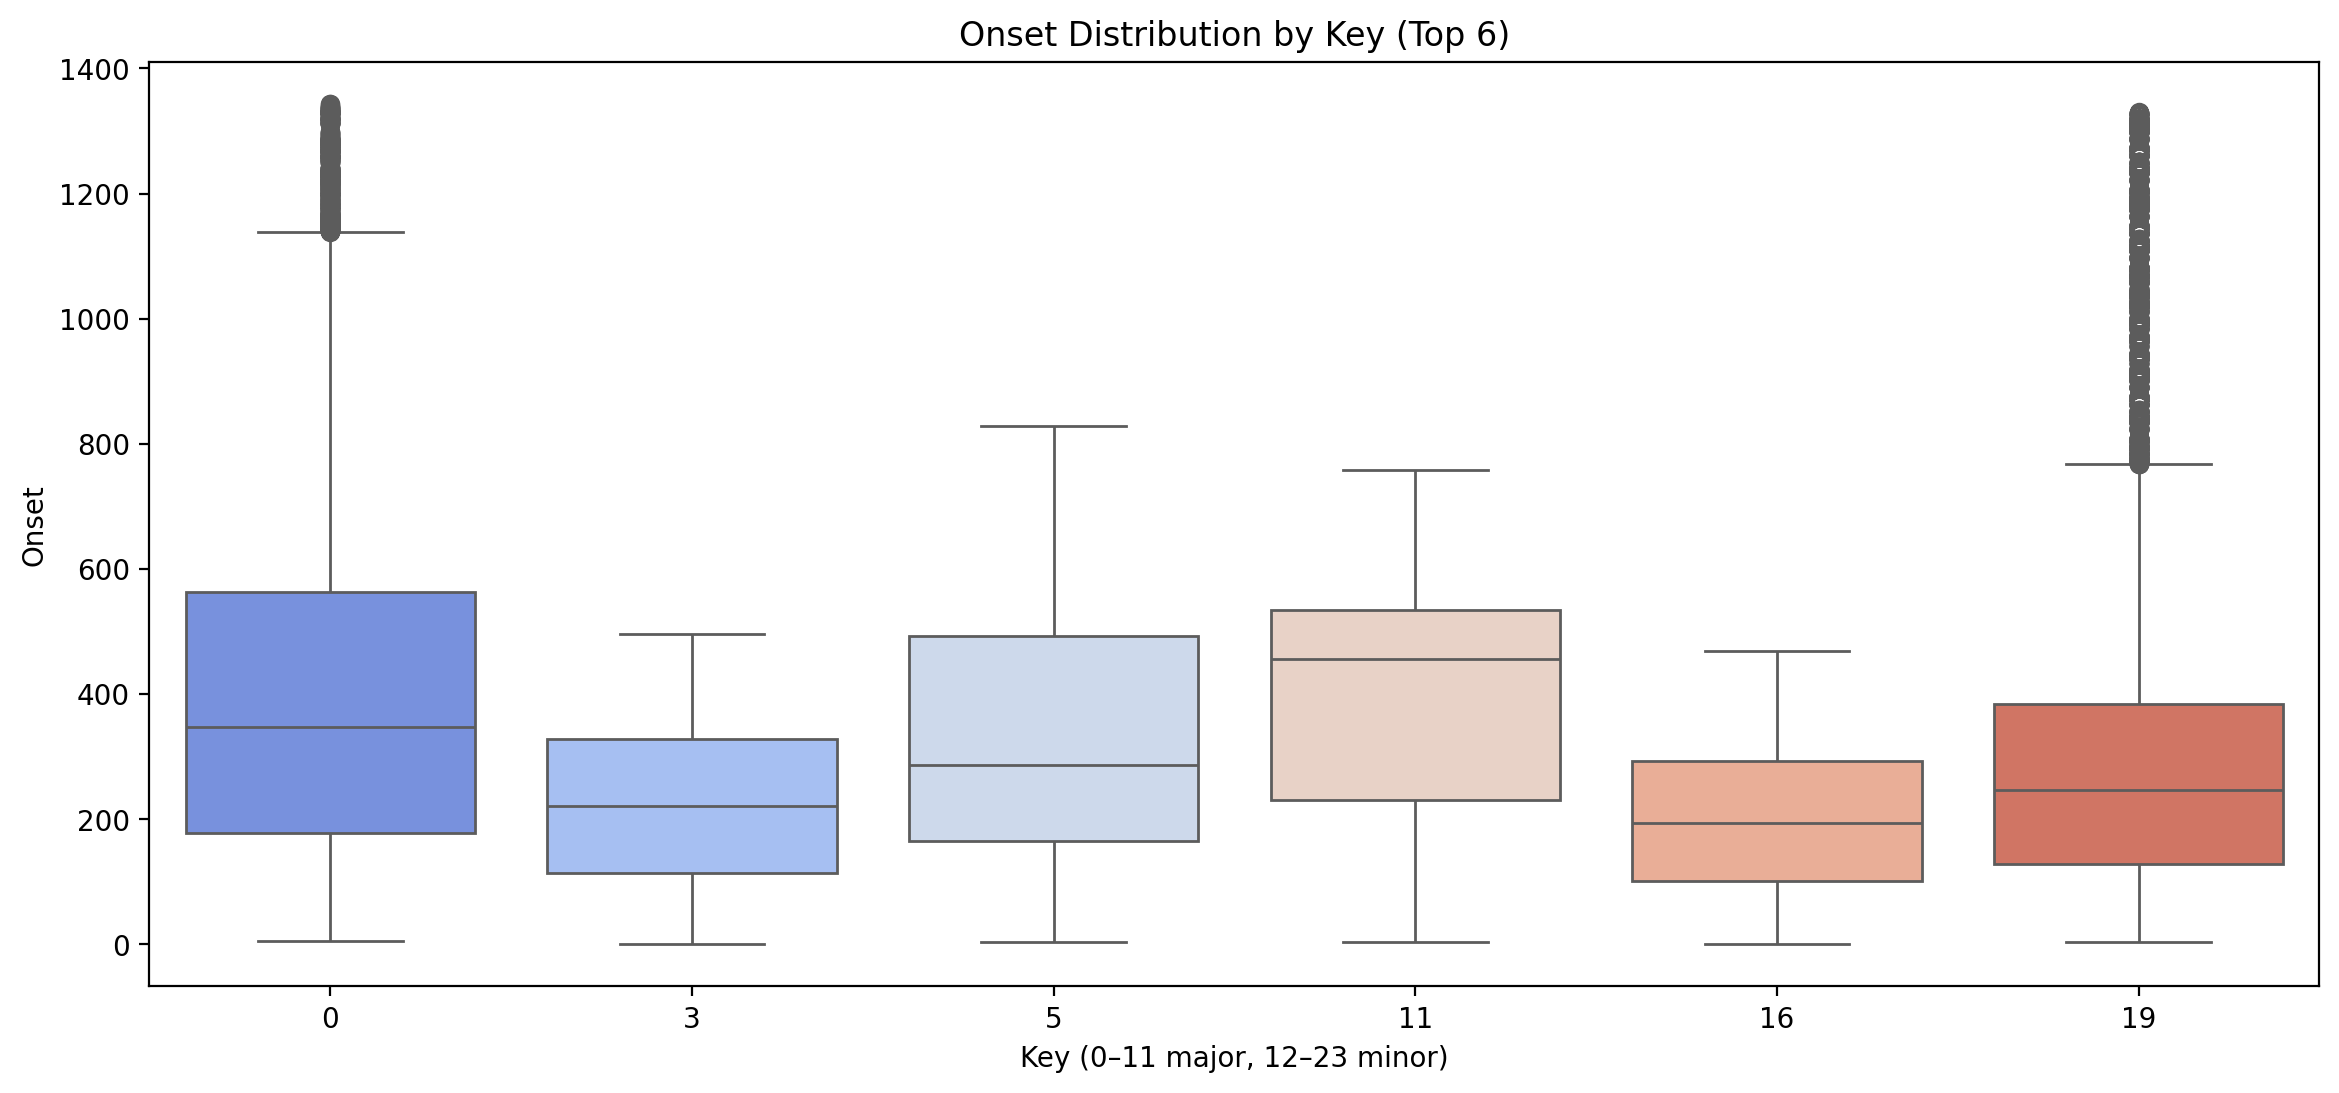

In [143]:
# Onset distribution across top 6 keys to show tonal variation.
plt.figure(figsize=(14,6))
sns.boxplot(data=df[df['key'].isin(top_keys)], x='key', y='onset', palette='coolwarm')
plt.title('Onset Distribution by Key (Top 6)')
plt.xlabel('Key (0–11 major, 12–23 minor)')
plt.ylabel('Onset')
plt.show()

In [144]:
# Descriptive statistics of onset values by instrument
print("Onset statistics by Instrument:")
df.groupby('instrument')['onset'].describe()

Onset statistics by Instrument:


count        mean         std     min         25%  \
instrument                                                              
Acoustic Bass     11262.0  340.240114  194.399656    8.00  171.666667   
Acoustic Guitar   18001.0  277.194897  167.327367    0.00  134.000000   
Bagpipes           4865.0  200.535132  104.631033    4.00  111.500000   
Bassoon            1729.0  131.358492   68.746089    9.00   73.000000   
Celesta            8514.0  208.691351  120.884390    0.50  104.000000   
Choir              2984.0  393.609780  172.626334    4.00  244.375000   
Clarinet            998.0  174.546343   36.444463  112.00  144.500000   
Contrabass         9168.0  547.293030  322.633586    0.00  255.437500   
Electric Bass       647.0  544.776018  122.236865  240.00  583.333333   
Electric Guitar   21454.0  336.970810  221.652745    4.00  158.750000   
Electric Organ     2280.0  232.338231  123.255761    8.00  130.000000   
Fretless Bass      4777.0  647.291239  390.648629   12.00  305.916667   
Glockenspiel        133.0   59.977444    8.412847   44.00   52.500000   
Marimba             235.0  344.330851    7.259537  329.00  338.125000   
Ocarina             575.0  311.211304   83.434546  220.25  244.750000   
Piano             38177.0  246.459456  147.740914    0.00  126.500000   
Piccolo            1462.0  182.679378   31.857721  123.00  158.000000   
Recorder           1097.0  443.489897   16.346449  413.00  429.250000   
Sampler           23546.0  234.037172  155.233028    1.00  118.625000   
StringInstrument   4078.0  611.828000   58.322183  220.00  591.000000   
Taiko                61.0  313.959016    9.375964  300.75  305.000000   
Timpani            1450.0   74.509885   27.438058   27.00   49.416667   
Trombone           4529.0  232.549864  129.134290   12.00  114.666667   
Trumpet             105.0  470.762698    1.183700  469.00  469.750000   
Unknown           14549.0  479.855912  346.472614    0.00  197.916667   
Violoncello         360.0  325.629167   10.304993  308.50  317.000000   
Voice             11500.0  210.839319  128.654002    0.00  104.500000   
Whistle            3656.0  165.828706   95.051827    3.50   83.500000   

                         50%         75%          max  
instrument                                             
Acoustic Bass     334.500000  514.666667   758.000000  
Acoustic Guitar   256.500000  473.000000   619.750000  
Bagpipes          200.500000  292.000000   386.750000  
Bassoon           131.500000  190.500000   248.000000  
Celesta           205.000000  297.750000   464.000000  
Choir             444.000000  545.000000   564.750000  
Clarinet          171.000000  206.000000   242.250000  
Contrabass        548.250000  828.125000  1094.000000  
Electric Bass     592.666667  602.666667   611.666667  
Electric Guitar   286.500000  518.250000   828.000000  
Electric Organ    224.000000  324.750000   530.000000  
Fretless Bass     651.166667  991.000000  1329.833333  
Glockenspiel       61.000000   67.000000    75.000000  
Marimba           344.500000  350.625000   356.750000  
Ocarina           260.750000  409.750000   444.500000  
Piano             240.500000  340.000000   755.500000  
Piccolo           183.000000  208.937500   238.750000  
Recorder          444.750000  458.000000   468.750000  
Sampler           208.750000  319.250000   700.000000  
StringInstrument  617.750000  643.000000   675.666667  
Taiko             313.000000  322.000000   330.000000  
Timpani            76.000000   97.666667   122.666667  
Trombone          243.666667  359.000000   432.000000  
Trumpet           470.750000  471.750000   472.750000  
Unknown           399.166667  771.000000  1342.500000  
Violoncello       325.500000  334.500000   344.500000  
Voice             200.166667  304.500000   556.916667  
Whistle           173.250000  241.000000   362.750000

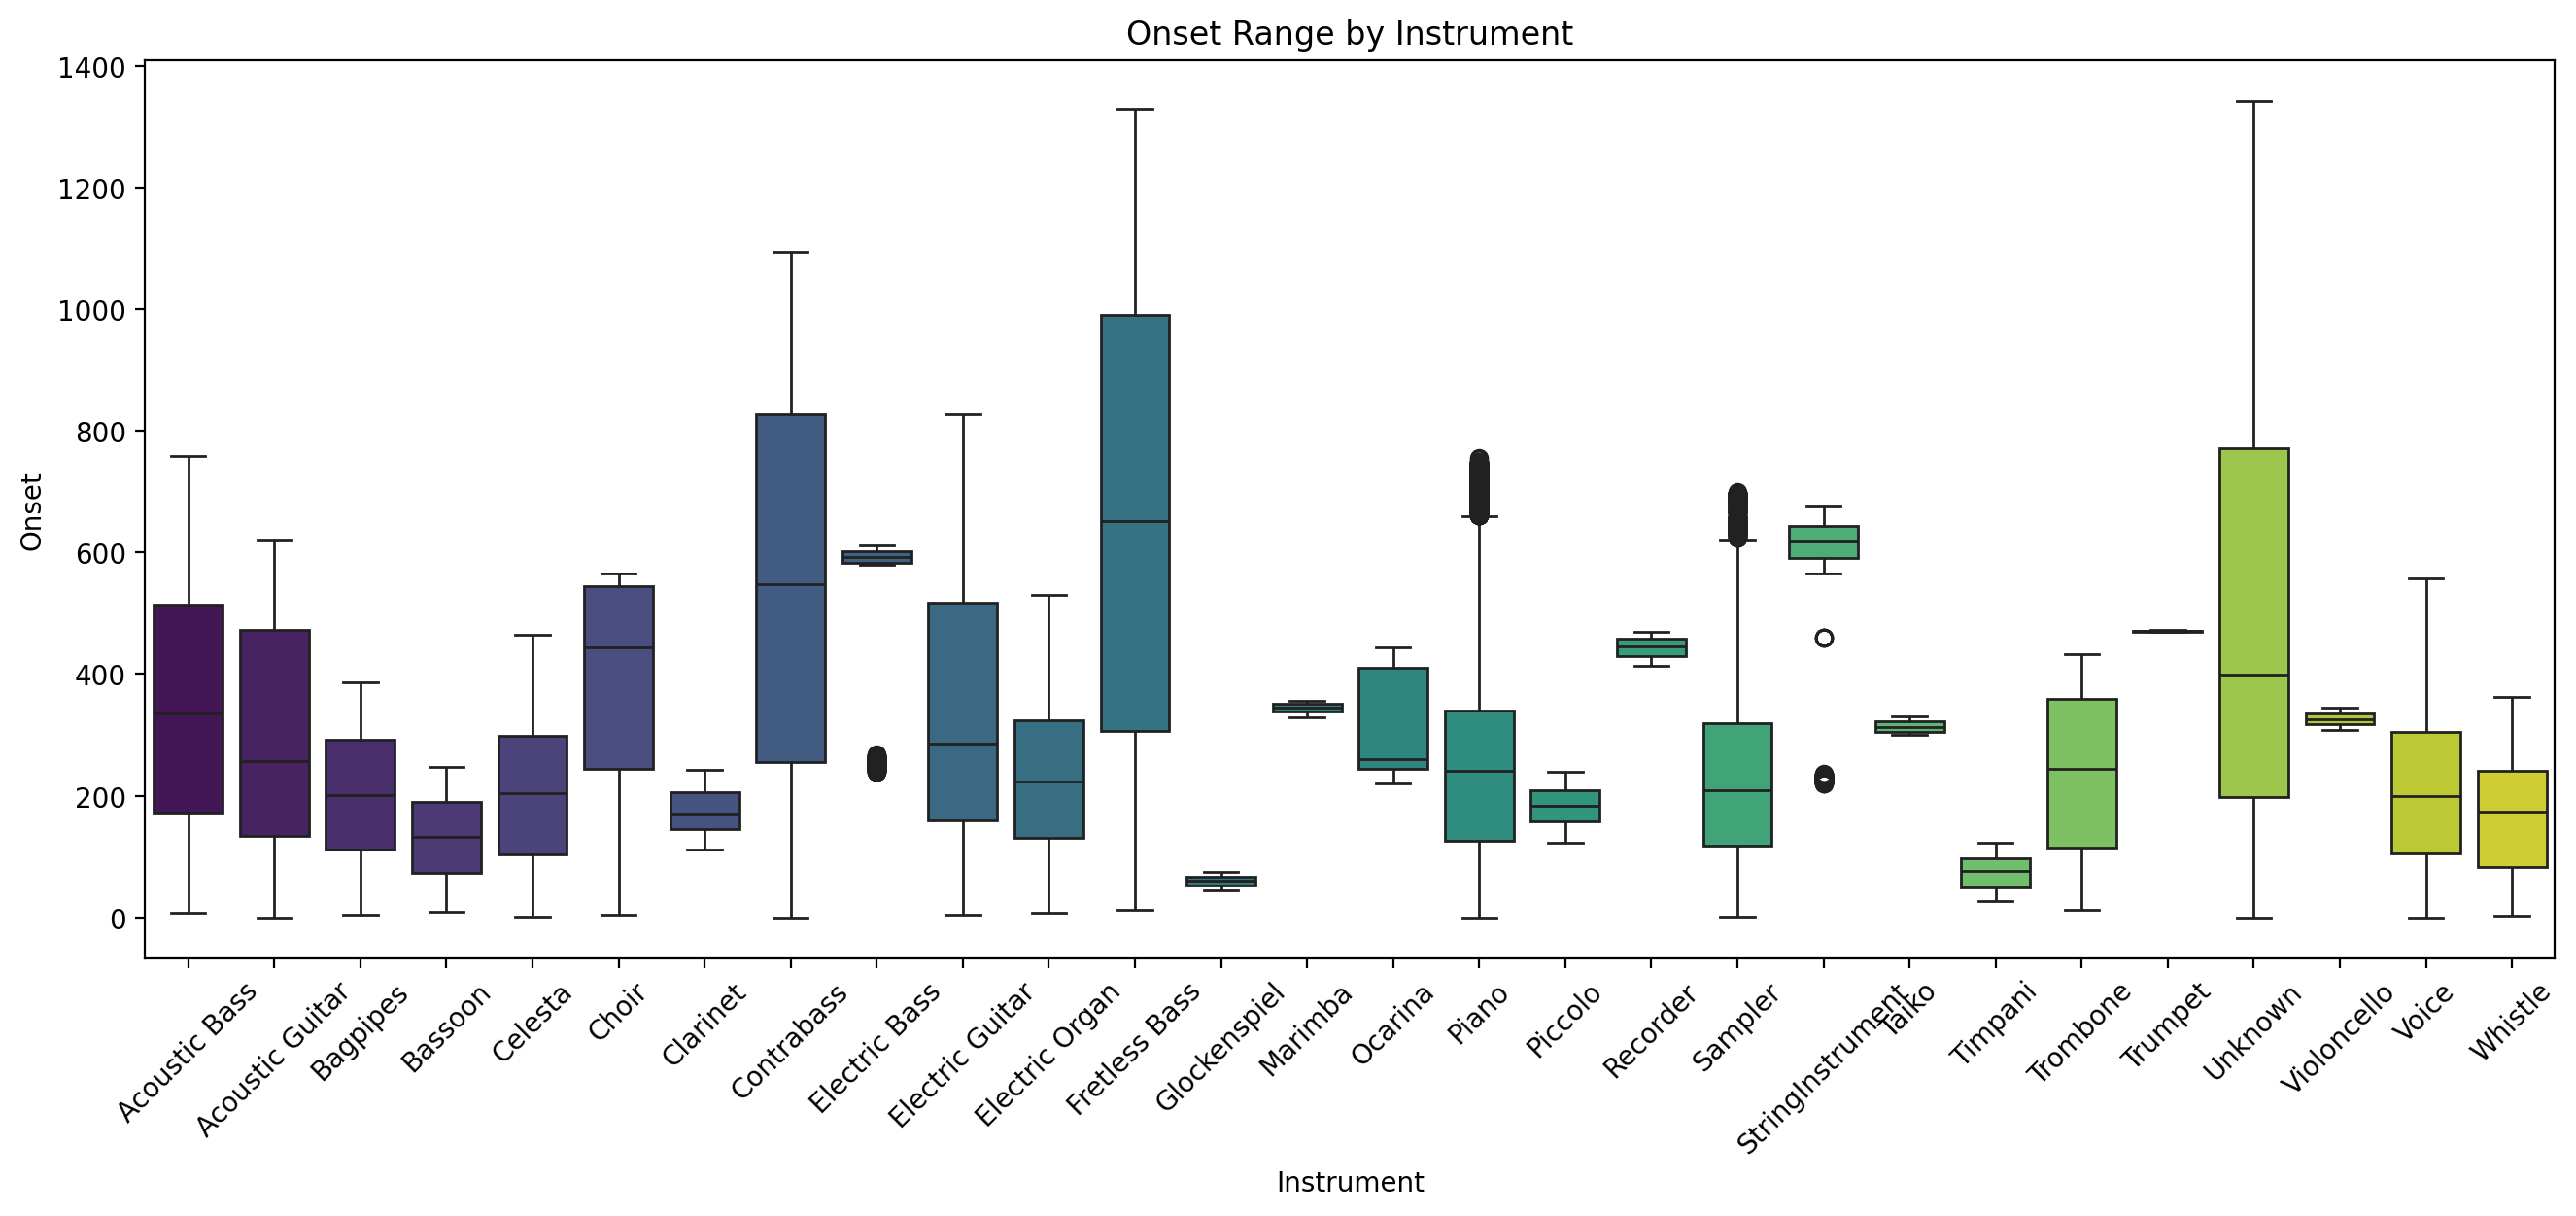

In [145]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df, x='instrument', y='onset', palette='viridis', order=alphabetic_order)
plt.xticks(rotation=45)
plt.title('Onset Range by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Onset')
plt.show()

In [146]:
# Descriptive statistics of onset by instrument family
print("Onset statistics by Instrument Family:")
df.groupby('instrument')['onset'].describe()

Onset statistics by Instrument Family:


count        mean         std     min         25%  \
instrument                                                              
Acoustic Bass     11262.0  340.240114  194.399656    8.00  171.666667   
Acoustic Guitar   18001.0  277.194897  167.327367    0.00  134.000000   
Bagpipes           4865.0  200.535132  104.631033    4.00  111.500000   
Bassoon            1729.0  131.358492   68.746089    9.00   73.000000   
Celesta            8514.0  208.691351  120.884390    0.50  104.000000   
Choir              2984.0  393.609780  172.626334    4.00  244.375000   
Clarinet            998.0  174.546343   36.444463  112.00  144.500000   
Contrabass         9168.0  547.293030  322.633586    0.00  255.437500   
Electric Bass       647.0  544.776018  122.236865  240.00  583.333333   
Electric Guitar   21454.0  336.970810  221.652745    4.00  158.750000   
Electric Organ     2280.0  232.338231  123.255761    8.00  130.000000   
Fretless Bass      4777.0  647.291239  390.648629   12.00  305.916667   
Glockenspiel        133.0   59.977444    8.412847   44.00   52.500000   
Marimba             235.0  344.330851    7.259537  329.00  338.125000   
Ocarina             575.0  311.211304   83.434546  220.25  244.750000   
Piano             38177.0  246.459456  147.740914    0.00  126.500000   
Piccolo            1462.0  182.679378   31.857721  123.00  158.000000   
Recorder           1097.0  443.489897   16.346449  413.00  429.250000   
Sampler           23546.0  234.037172  155.233028    1.00  118.625000   
StringInstrument   4078.0  611.828000   58.322183  220.00  591.000000   
Taiko                61.0  313.959016    9.375964  300.75  305.000000   
Timpani            1450.0   74.509885   27.438058   27.00   49.416667   
Trombone           4529.0  232.549864  129.134290   12.00  114.666667   
Trumpet             105.0  470.762698    1.183700  469.00  469.750000   
Unknown           14549.0  479.855912  346.472614    0.00  197.916667   
Violoncello         360.0  325.629167   10.304993  308.50  317.000000   
Voice             11500.0  210.839319  128.654002    0.00  104.500000   
Whistle            3656.0  165.828706   95.051827    3.50   83.500000   

                         50%         75%          max  
instrument                                             
Acoustic Bass     334.500000  514.666667   758.000000  
Acoustic Guitar   256.500000  473.000000   619.750000  
Bagpipes          200.500000  292.000000   386.750000  
Bassoon           131.500000  190.500000   248.000000  
Celesta           205.000000  297.750000   464.000000  
Choir             444.000000  545.000000   564.750000  
Clarinet          171.000000  206.000000   242.250000  
Contrabass        548.250000  828.125000  1094.000000  
Electric Bass     592.666667  602.666667   611.666667  
Electric Guitar   286.500000  518.250000   828.000000  
Electric Organ    224.000000  324.750000   530.000000  
Fretless Bass     651.166667  991.000000  1329.833333  
Glockenspiel       61.000000   67.000000    75.000000  
Marimba           344.500000  350.625000   356.750000  
Ocarina           260.750000  409.750000   444.500000  
Piano             240.500000  340.000000   755.500000  
Piccolo           183.000000  208.937500   238.750000  
Recorder          444.750000  458.000000   468.750000  
Sampler           208.750000  319.250000   700.000000  
StringInstrument  617.750000  643.000000   675.666667  
Taiko             313.000000  322.000000   330.000000  
Timpani            76.000000   97.666667   122.666667  
Trombone          243.666667  359.000000   432.000000  
Trumpet           470.750000  471.750000   472.750000  
Unknown           399.166667  771.000000  1342.500000  
Violoncello       325.500000  334.500000   344.500000  
Voice             200.166667  304.500000   556.916667  
Whistle           173.250000  241.000000   362.750000

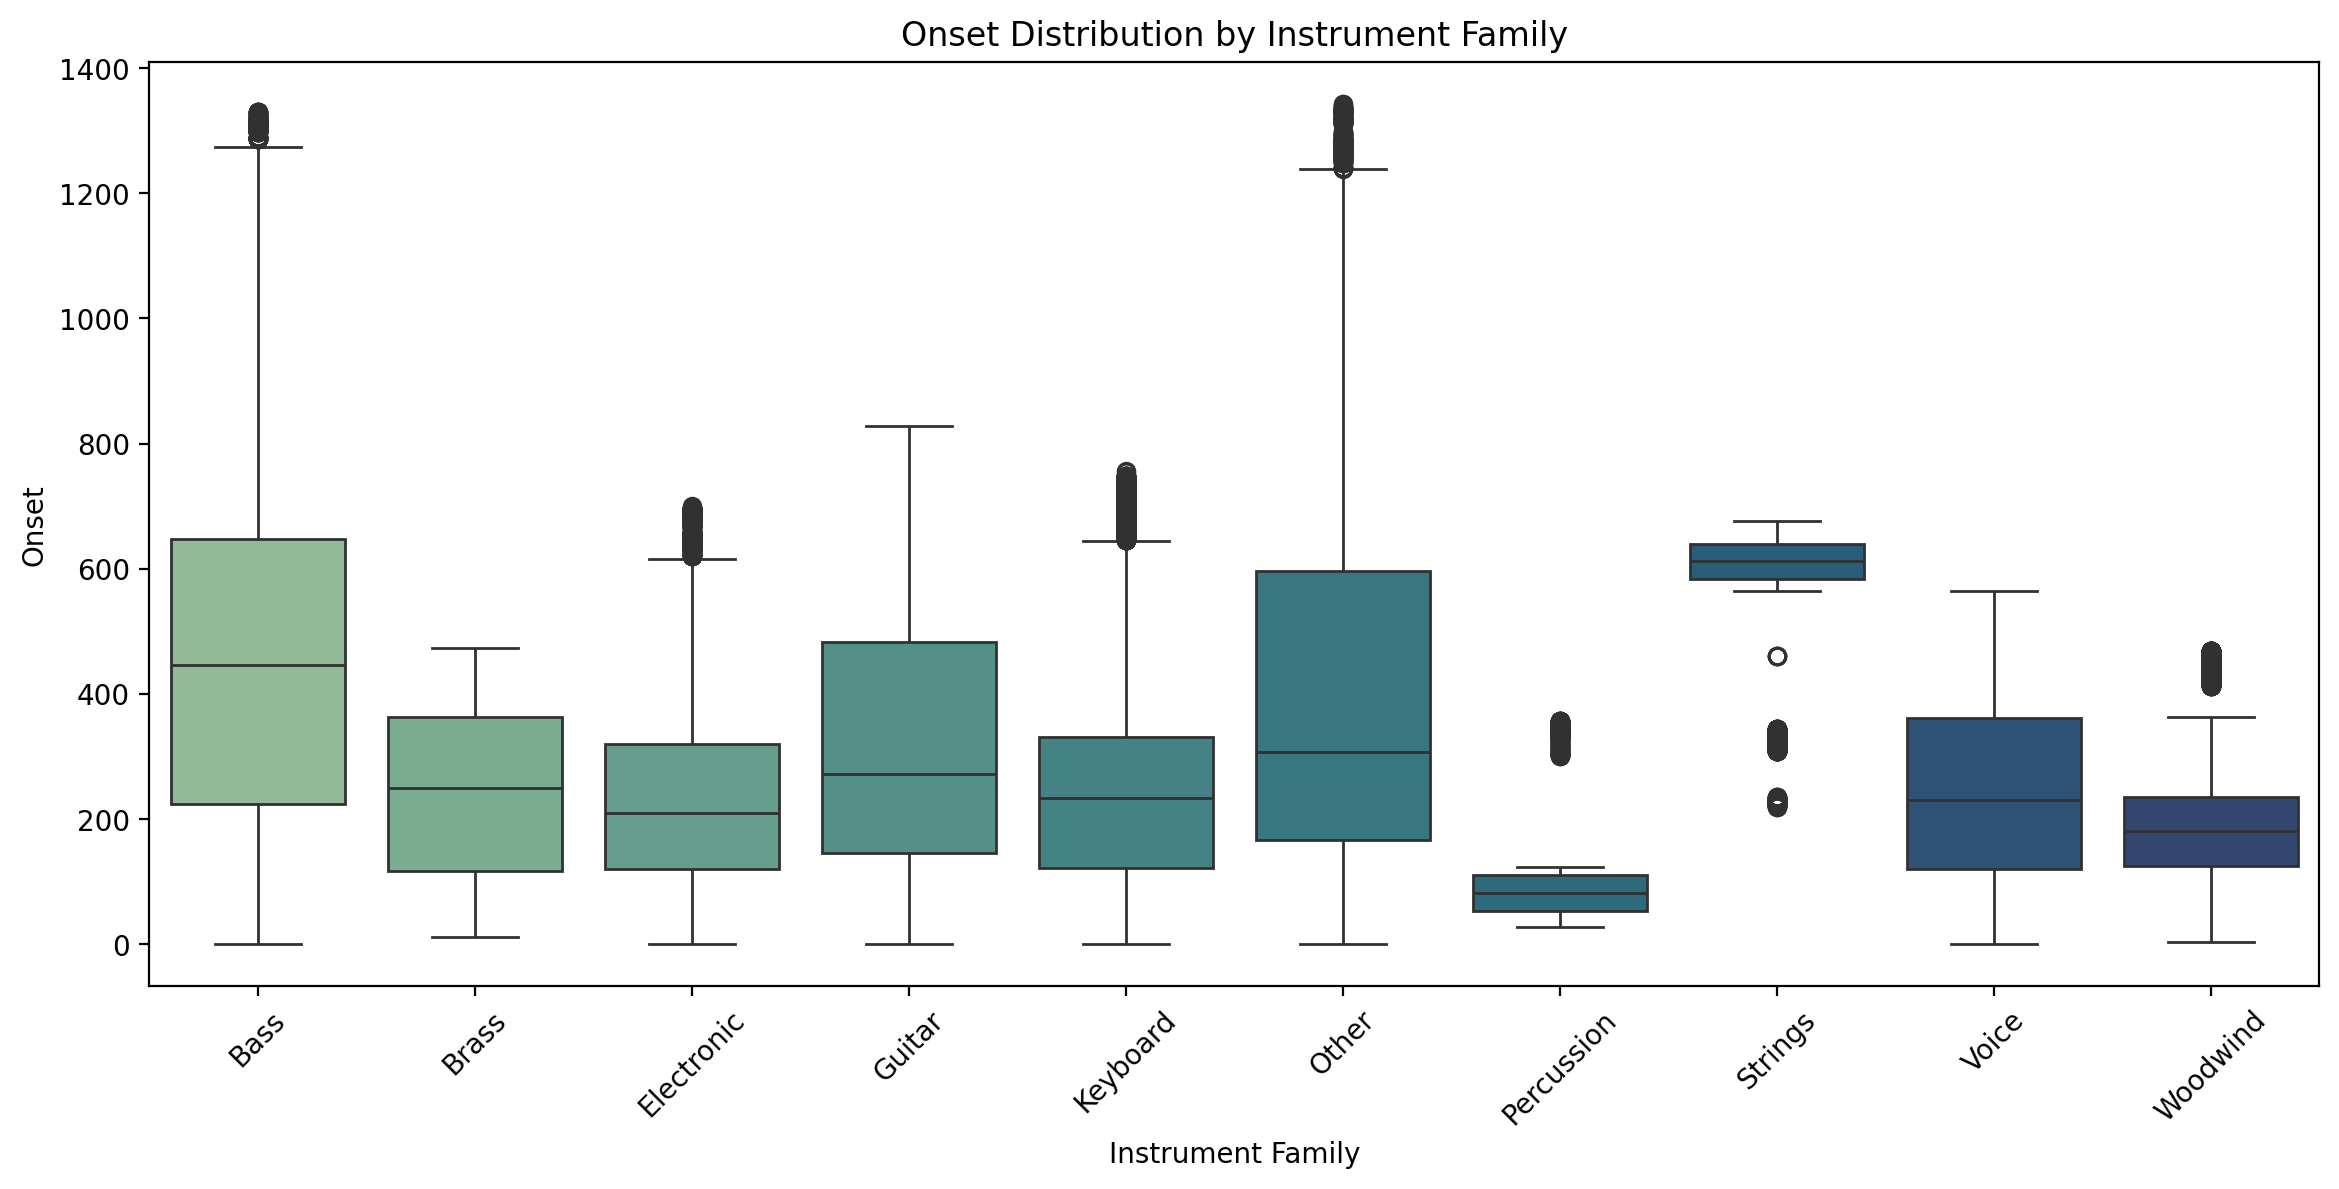

In [147]:
# Filter and plot onset distribution by instrument family
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x='instrument_family',
    y='onset',
    palette='crest',
    order=families
)
plt.title('Onset Distribution by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Onset')
plt.xticks(rotation=45)
plt.show()

In [148]:
# Descriptive statistics of onset by genre
print("Onset statistics by Genre:")
df.groupby('genre')['onset'].describe()

Onset statistics by Genre:


count        mean         std   min         25%  \
genre                                                                 
alternative_rock   7460.0  166.446895   96.508119  0.00   85.500000   
blues             22575.0  377.369085  220.161240  4.00  196.666667   
classical         15371.0  507.122216  325.866097  0.00  202.500000   
country           14654.0  269.622839  152.419562  8.00  146.750000   
dance              6910.0  281.404993  156.107246  4.00  154.229167   
disco              9845.0  230.104241  143.591594  0.50  110.333333   
heavy_metal        6189.0  215.320542  116.608085  1.00  119.500000   
jazz              13486.0  383.785895  328.292552  4.00  144.000000   
new_age           21791.0  402.915581  202.689390  0.00  215.333333   
pop               12478.0  299.318594  172.332070  3.50  161.500000   
rap               13449.0  193.256766  117.643560  0.00   94.500000   
reggae            14663.0  362.958745  315.524780  8.00  141.250000   
rnb               13780.0  194.339163  111.437828  0.00  103.000000   
rock               7344.0  173.266033   92.724092  4.25   91.000000   
soul              12197.0  209.489622  113.147420  4.00  117.750000   

                         50%         75%          max  
genre                                                  
alternative_rock  161.250000  233.000000   439.750000  
blues             365.000000  559.000000   828.000000  
classical         483.833333  800.000000  1133.250000  
country           254.500000  372.500000   618.750000  
dance             273.500000  402.500000   582.000000  
disco             218.500000  320.000000   670.583333  
heavy_metal       218.333333  301.000000   452.750000  
jazz              298.666667  442.166667  1342.500000  
new_age           480.250000  568.666667   700.000000  
pop               292.500000  395.000000   755.500000  
rap               188.000000  281.000000   447.000000  
reggae            272.000000  432.625000  1329.833333  
rnb               192.500000  277.500000   463.000000  
rock              177.500000  255.500000   356.000000  
soul              210.500000  289.000000   464.000000

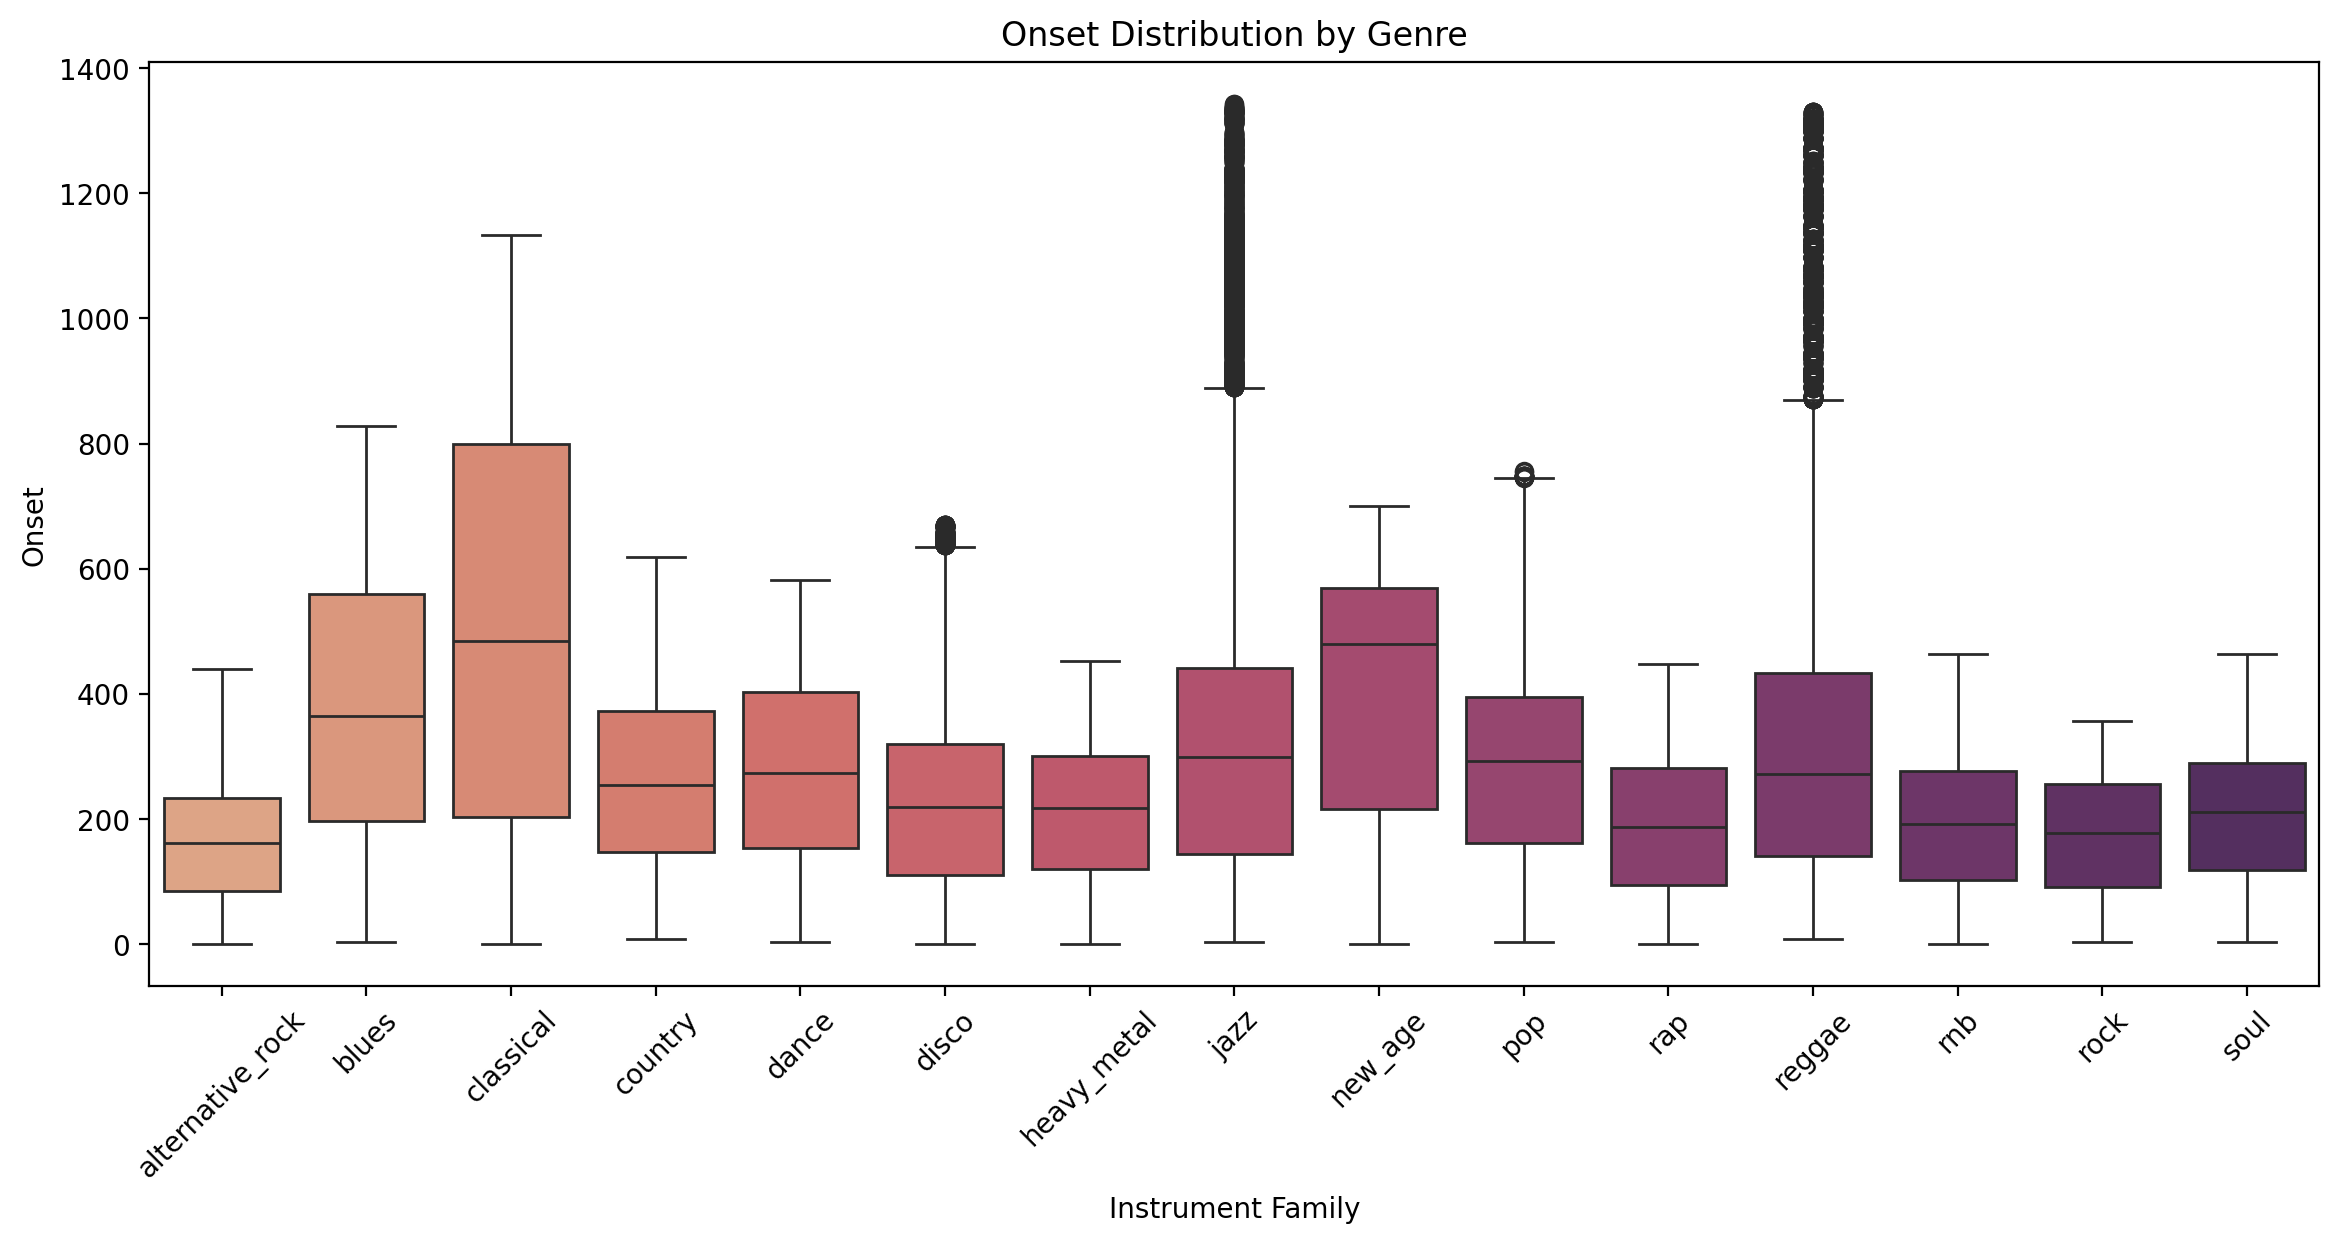

In [149]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x='genre',
    y='onset',
    palette='flare',
    order=genres_sorted
)
plt.title('Onset Distribution by Genre')
plt.xlabel('Instrument Family')
plt.ylabel('Onset')
plt.xticks(rotation=45)
plt.show()

#### 2.3.5 Duration

##### 2.3.5.1 Central Tendency and Spread of Duration


In [150]:
# Apply a safe conversion to float
df['duration'] = df['duration'].apply(lambda x: float(x) if isinstance(x, Fraction) else x)
df['duration'] = df['duration'].astype(float)

# Central tendency
mean_duration = df['duration'].mean()
median_duration = df['duration'].median()
mode_duration = df['duration'].mode()[0]  

# Spread
std_duration = df['duration'].std()

# Display results
print(f"Mean duration: {mean_duration:.2f}")
print(f"Median duration: {median_duration:.2f}")
print(f"Mode duration: {mode_duration}")
print(f"Standard deviation: {std_duration:.2f}")

Mean duration: 0.63
Median duration: 0.33
Mode duration: 0.25
Standard deviation: 0.72


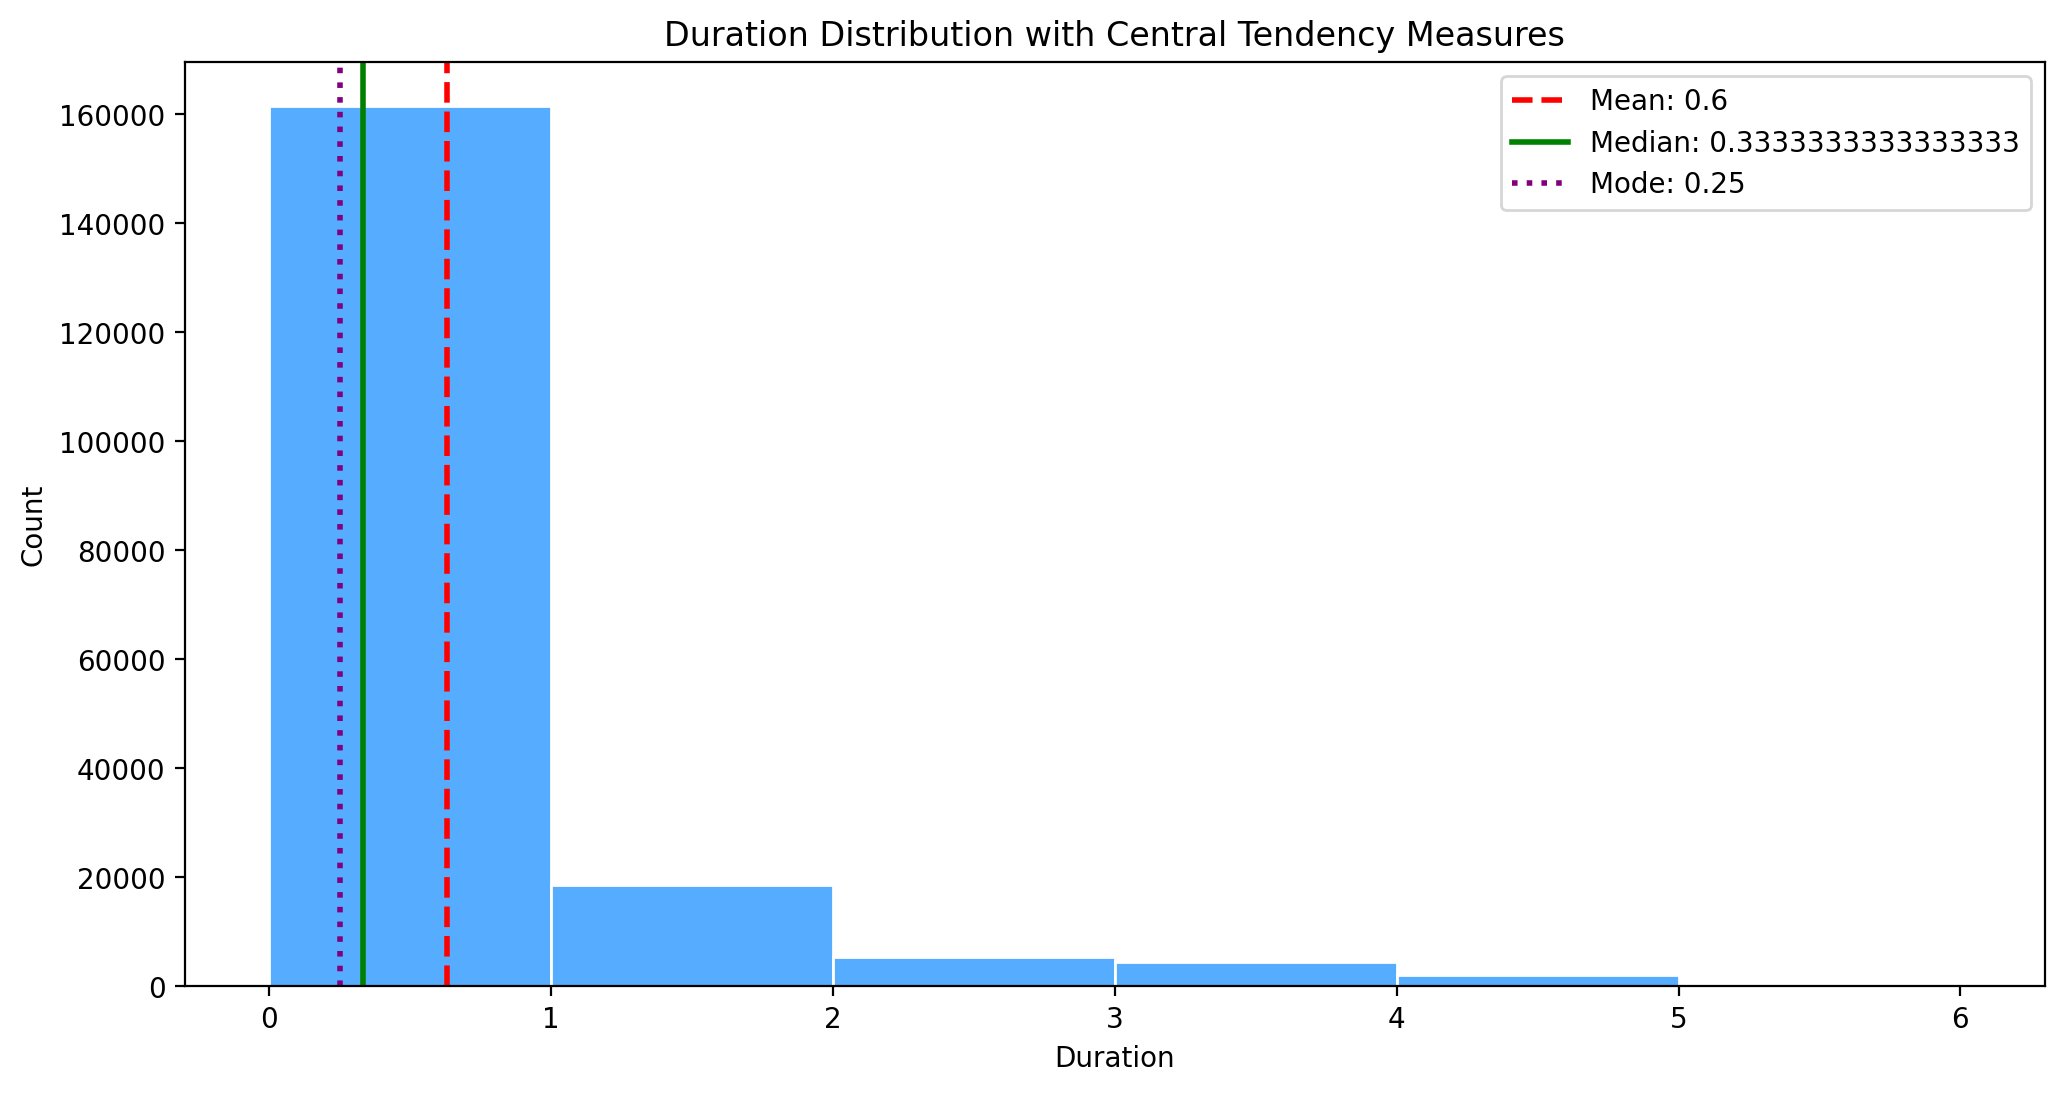

In [203]:
plt.figure(figsize=(12, 6))
sns.histplot(df['duration'], bins=range(0, 7), color='dodgerblue', edgecolor='white')

# Add lines for mean, median, and mode
plt.axvline(mean_duration, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_duration:.1f}')
plt.axvline(median_duration, color='green', linestyle='-', linewidth=2, label=f'Median: {median_duration}')
plt.axvline(mode_duration, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_duration}')

plt.title('Duration Distribution with Central Tendency Measures')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.legend()
plt.show()

##### 2.3.5.2 Outlier Detection in Duration Values

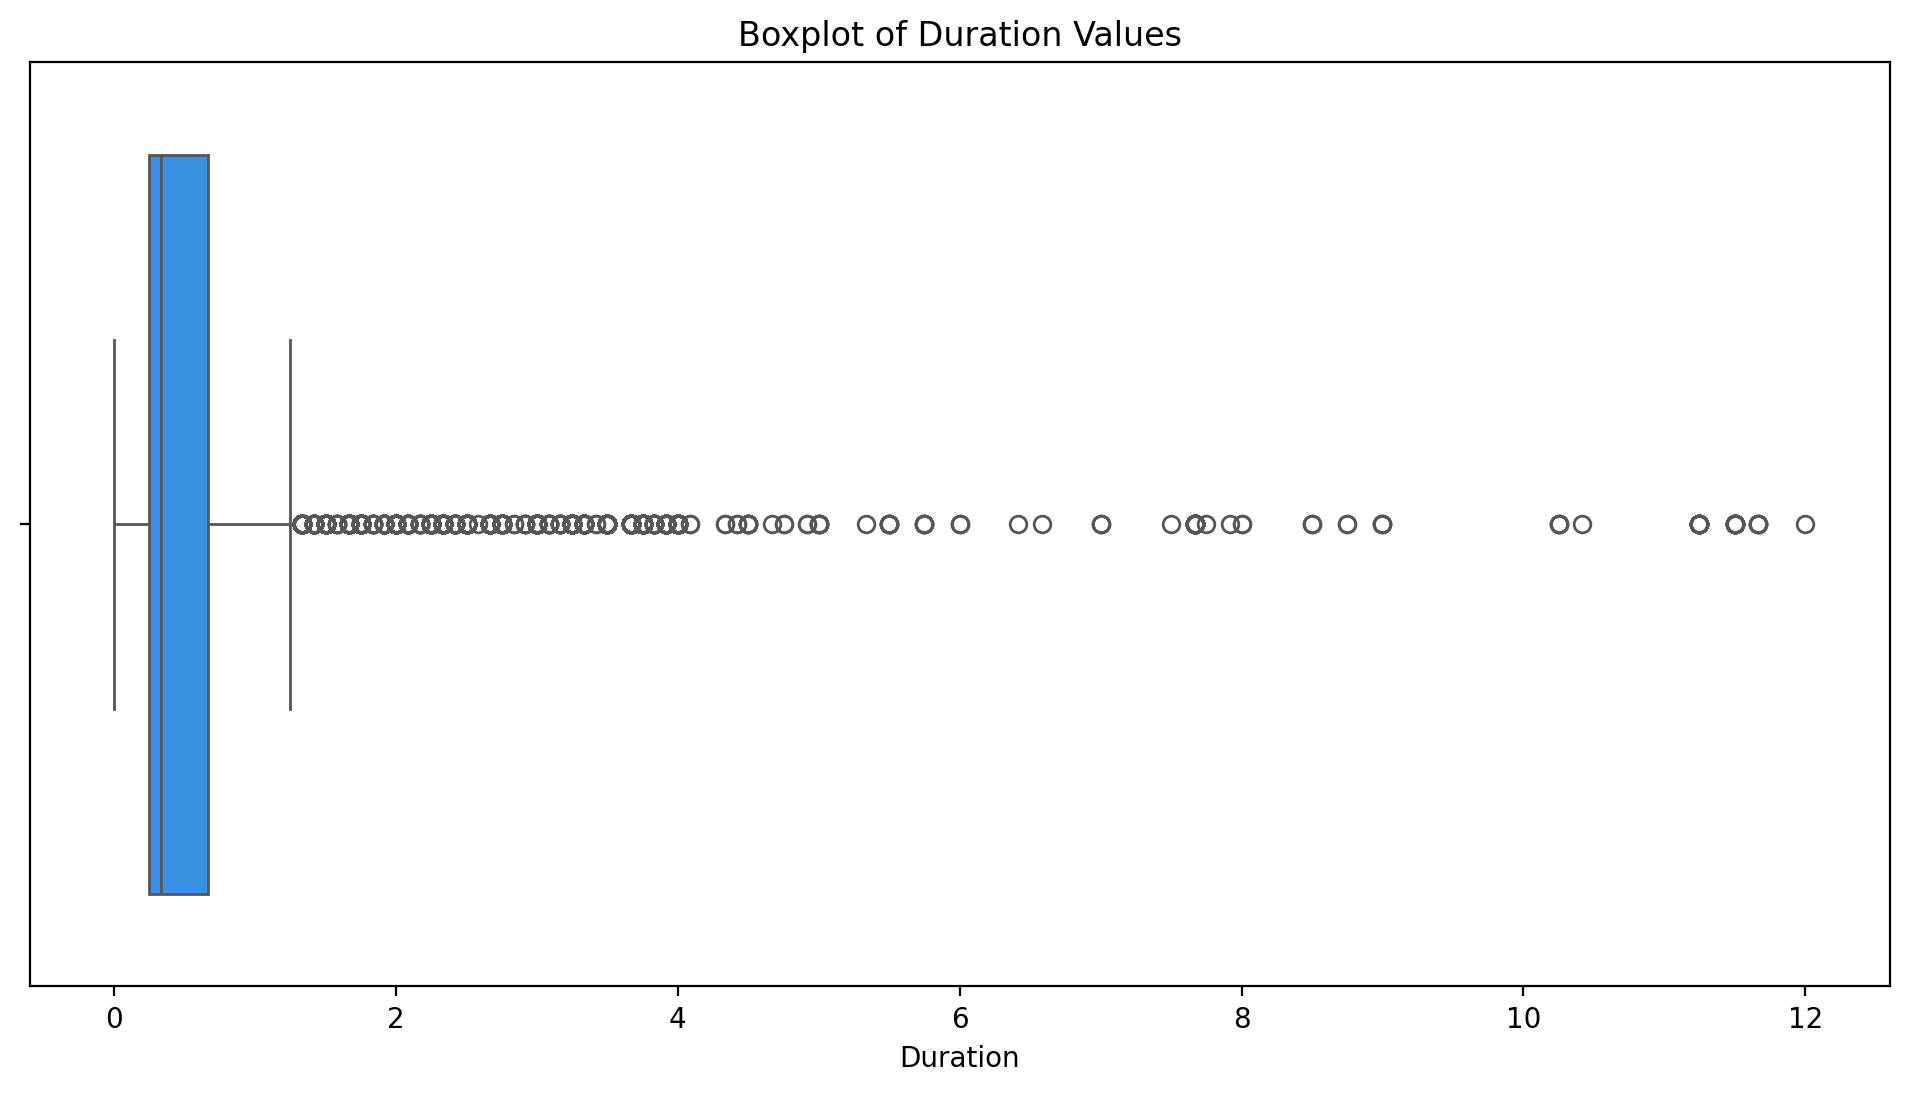

In [204]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['duration'], color='dodgerblue')
plt.title('Boxplot of Duration Values')
plt.xlabel('Duration')
plt.show()

##### 2.3.5.3 Duration in Context: Key, Instrument, and Genre

In [164]:
# Descriptive statistics of duration values by key
print("Duration statistics by Key:")
df.groupby('key')['duration'].describe().sort_index()

Duration statistics by Key:


count      mean       std       min       25%       50%       75%  \
key                                                                        
0    11608.0  0.936237  0.959607  0.083333  0.250000  0.500000  1.000000   
1     8535.0  0.605507  0.466705  0.166667  0.500000  0.500000  0.500000   
2     5075.0  0.526667  0.549458  0.083333  0.250000  0.250000  0.500000   
3    13501.0  0.646156  0.588914  0.250000  0.250000  0.500000  0.750000   
4     8834.0  0.389074  0.352420  0.250000  0.250000  0.250000  0.500000   
5    17733.0  0.515954  0.510085  0.083333  0.250000  0.500000  0.500000   
6     4806.0  0.894143  0.889919  0.166667  0.500000  0.500000  1.000000   
7    10897.0  0.546014  0.393593  0.250000  0.500000  0.500000  0.500000   
9     3344.0  0.502467  0.347611  0.166667  0.250000  0.500000  0.500000   
11   24410.0  0.651704  0.920339  0.083333  0.250000  0.333333  0.500000   
12    7224.0  0.637020  0.479240  0.083333  0.250000  0.500000  1.000000   
13    9294.0  0.696991  0.788404  0.083333  0.250000  0.500000  0.750000   
14    7794.0  0.456505  0.501559  0.166667  0.250000  0.250000  0.500000   
15    1626.0  0.550431  0.433710  0.250000  0.250000  0.500000  0.500000   
16   19702.0  0.553869  0.597145  0.000000  0.250000  0.333333  0.500000   
17    7936.0  0.684560  0.855696  0.166667  0.250000  0.250000  0.500000   
19   16036.0  0.787806  1.024392  0.083333  0.250000  0.500000  0.750000   
21    8261.0  0.611387  0.558121  0.083333  0.250000  0.333333  0.750000   
23    5576.0  0.681881  0.777835  0.083333  0.333333  0.333333  0.666667   

           max  
key             
0     3.500000  
1     4.000000  
2    12.000000  
3     4.000000  
4     4.000000  
5     4.000000  
6     9.000000  
7     4.000000  
9     3.500000  
11    7.000000  
12    4.000000  
13   10.416667  
14    4.000000  
15    4.000000  
16    4.000000  
17    4.000000  
19   11.666667  
21    8.750000  
23    4.000000

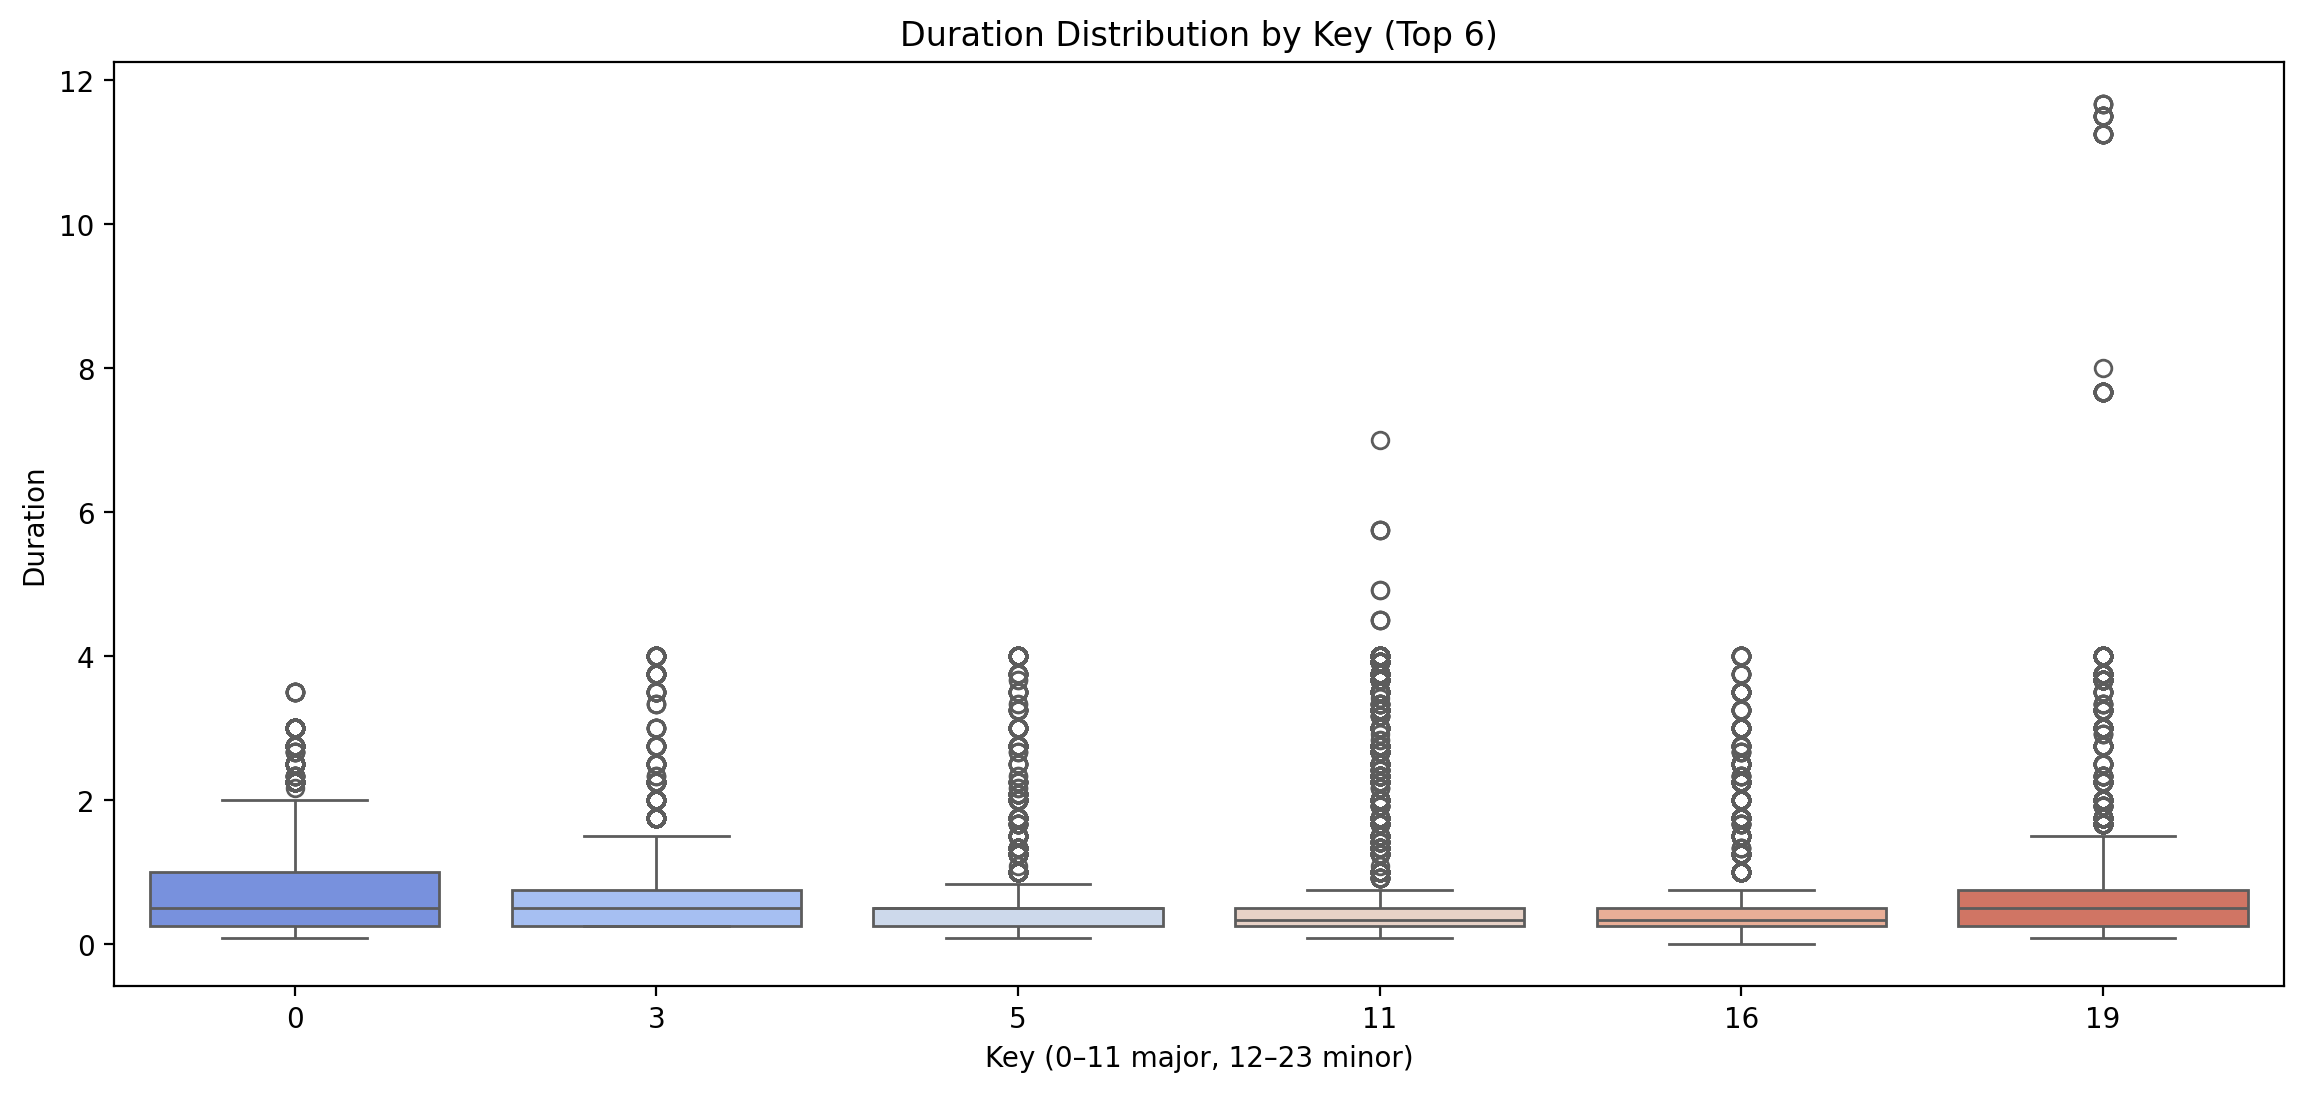

In [165]:
# Duration distribution across top 6 keys to show tonal variation.
plt.figure(figsize=(14,6))
sns.boxplot(data=df[df['key'].isin(top_keys)], x='key', y='duration', palette='coolwarm')
plt.title('Duration Distribution by Key (Top 6)')
plt.xlabel('Key (0–11 major, 12–23 minor)')
plt.ylabel('Duration')
plt.show()

In [166]:
# Descriptive statistics of duration values by instrument
print("Duration statistics by Instrument:")
df.groupby('instrument')['duration'].describe()

Duration statistics by Instrument:


count      mean       std       min       25%       50%  \
instrument                                                                    
Acoustic Bass     11262.0  0.777141  1.026252  0.083333  0.250000  0.333333   
Acoustic Guitar   18001.0  0.516749  0.482787  0.083333  0.250000  0.333333   
Bagpipes           4865.0  0.659010  0.579692  0.166667  0.500000  0.500000   
Bassoon            1729.0  0.726190  0.588337  0.250000  0.500000  0.500000   
Celesta            8514.0  0.504052  0.606819  0.000000  0.250000  0.250000   
Choir              2984.0  0.567248  0.559296  0.250000  0.250000  0.333333   
Clarinet            998.0  0.583667  0.585592  0.250000  0.250000  0.500000   
Contrabass         9168.0  0.512035  0.334079  0.250000  0.500000  0.500000   
Electric Bass       647.0  0.659196  0.781879  0.083333  0.333333  0.333333   
Electric Guitar   21454.0  0.461635  0.459487  0.083333  0.250000  0.250000   
Electric Organ     2280.0  0.943458  0.973735  0.250000  0.500000  0.500000   
Fretless Bass      4777.0  1.035448  1.462435  0.250000  0.333333  0.333333   
Glockenspiel        133.0  0.460526  0.309022  0.250000  0.250000  0.250000   
Marimba             235.0  0.524823  0.832926  0.083333  0.250000  0.250000   
Ocarina             575.0  0.749275  0.348330  0.166667  0.500000  0.750000   
Piano             38177.0  0.602324  0.563131  0.083333  0.250000  0.333333   
Piccolo            1462.0  0.472640  0.405681  0.083333  0.333333  0.333333   
Recorder           1097.0  0.383090  0.602157  0.083333  0.250000  0.250000   
Sampler           23546.0  0.759917  0.846695  0.083333  0.250000  0.500000   
StringInstrument   4078.0  0.422450  0.460968  0.083333  0.250000  0.333333   
Taiko                61.0  1.046448  1.146707  0.500000  0.500000  0.500000   
Timpani            1450.0  0.486494  0.478743  0.250000  0.333333  0.333333   
Trombone           4529.0  0.801299  0.816273  0.250000  0.250000  0.333333   
Trumpet             105.0  0.347619  0.533526  0.250000  0.250000  0.250000   
Unknown           14549.0  0.967019  0.993412  0.083333  0.250000  0.500000   
Violoncello         360.0  0.590278  0.390757  0.500000  0.500000  0.500000   
Voice             11500.0  0.470094  0.558900  0.083333  0.250000  0.250000   
Whistle            3656.0  0.424941  0.512525  0.083333  0.250000  0.250000   

                       75%        max  
instrument                             
Acoustic Bass     0.666667   7.000000  
Acoustic Guitar   0.500000   4.000000  
Bagpipes          0.500000   4.000000  
Bassoon           0.750000   3.000000  
Celesta           0.500000   4.000000  
Choir             0.750000   4.000000  
Clarinet          0.500000   4.000000  
Contrabass        0.500000   4.000000  
Electric Bass     0.666667   4.000000  
Electric Guitar   0.500000   9.000000  
Electric Organ    1.000000   4.000000  
Fretless Bass     1.000000  11.666667  
Glockenspiel      0.500000   1.500000  
Marimba           0.333333   4.000000  
Ocarina           1.000000   3.000000  
Piano             0.750000   7.916667  
Piccolo           0.333333   3.000000  
Recorder          0.250000   4.000000  
Sampler           0.750000  12.000000  
StringInstrument  0.333333   4.000000  
Taiko             0.750000   4.000000  
Timpani           0.333333   3.000000  
Trombone          1.000000   4.000000  
Trumpet           0.250000   4.000000  
Unknown           1.000000  10.416667  
Violoncello       0.500000   3.500000  
Voice             0.500000   4.000000  
Whistle           0.500000   4.000000

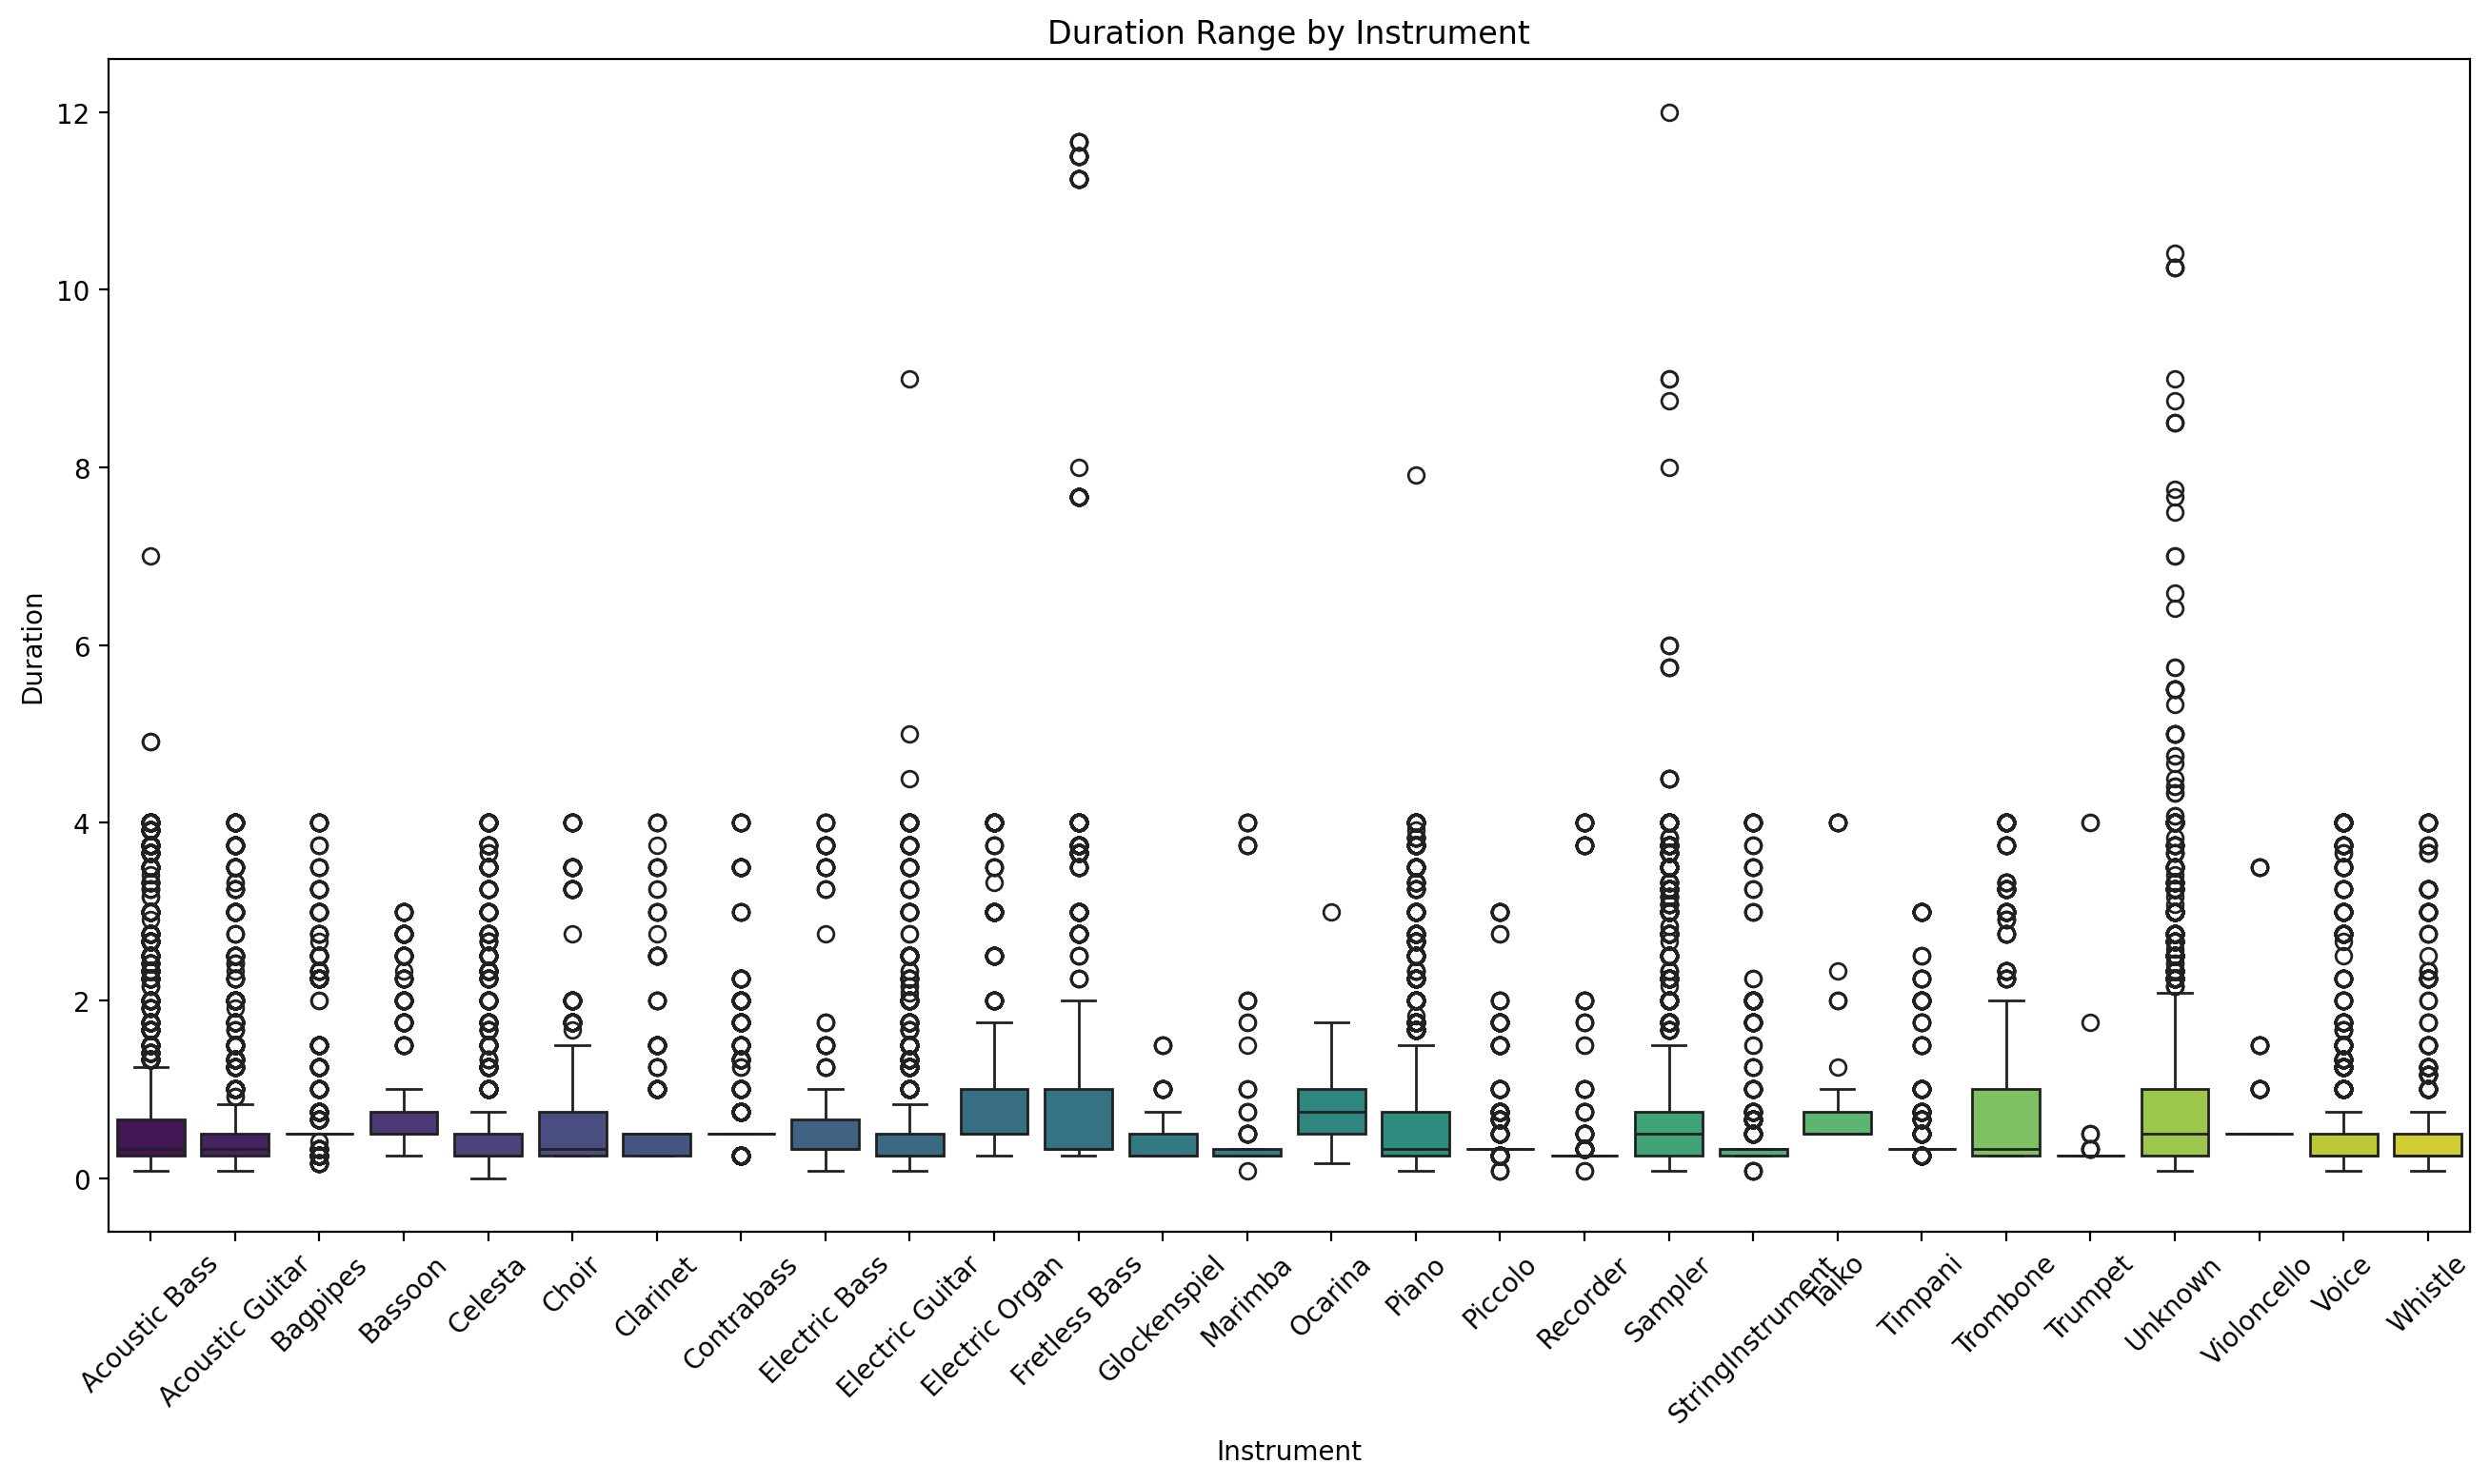

In [188]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='instrument', y='duration', palette='viridis', order=alphabetic_order)
plt.xticks(rotation=45)
plt.title('Duration Range by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Duration')
plt.show()

In [168]:
# Descriptive statistics of duration by instrument family
print("Duration statistics by Instrument Family:")
df.groupby('instrument')['duration'].describe()

Duration statistics by Instrument Family:


count      mean       std       min       25%       50%  \
instrument                                                                    
Acoustic Bass     11262.0  0.777141  1.026252  0.083333  0.250000  0.333333   
Acoustic Guitar   18001.0  0.516749  0.482787  0.083333  0.250000  0.333333   
Bagpipes           4865.0  0.659010  0.579692  0.166667  0.500000  0.500000   
Bassoon            1729.0  0.726190  0.588337  0.250000  0.500000  0.500000   
Celesta            8514.0  0.504052  0.606819  0.000000  0.250000  0.250000   
Choir              2984.0  0.567248  0.559296  0.250000  0.250000  0.333333   
Clarinet            998.0  0.583667  0.585592  0.250000  0.250000  0.500000   
Contrabass         9168.0  0.512035  0.334079  0.250000  0.500000  0.500000   
Electric Bass       647.0  0.659196  0.781879  0.083333  0.333333  0.333333   
Electric Guitar   21454.0  0.461635  0.459487  0.083333  0.250000  0.250000   
Electric Organ     2280.0  0.943458  0.973735  0.250000  0.500000  0.500000   
Fretless Bass      4777.0  1.035448  1.462435  0.250000  0.333333  0.333333   
Glockenspiel        133.0  0.460526  0.309022  0.250000  0.250000  0.250000   
Marimba             235.0  0.524823  0.832926  0.083333  0.250000  0.250000   
Ocarina             575.0  0.749275  0.348330  0.166667  0.500000  0.750000   
Piano             38177.0  0.602324  0.563131  0.083333  0.250000  0.333333   
Piccolo            1462.0  0.472640  0.405681  0.083333  0.333333  0.333333   
Recorder           1097.0  0.383090  0.602157  0.083333  0.250000  0.250000   
Sampler           23546.0  0.759917  0.846695  0.083333  0.250000  0.500000   
StringInstrument   4078.0  0.422450  0.460968  0.083333  0.250000  0.333333   
Taiko                61.0  1.046448  1.146707  0.500000  0.500000  0.500000   
Timpani            1450.0  0.486494  0.478743  0.250000  0.333333  0.333333   
Trombone           4529.0  0.801299  0.816273  0.250000  0.250000  0.333333   
Trumpet             105.0  0.347619  0.533526  0.250000  0.250000  0.250000   
Unknown           14549.0  0.967019  0.993412  0.083333  0.250000  0.500000   
Violoncello         360.0  0.590278  0.390757  0.500000  0.500000  0.500000   
Voice             11500.0  0.470094  0.558900  0.083333  0.250000  0.250000   
Whistle            3656.0  0.424941  0.512525  0.083333  0.250000  0.250000   

                       75%        max  
instrument                             
Acoustic Bass     0.666667   7.000000  
Acoustic Guitar   0.500000   4.000000  
Bagpipes          0.500000   4.000000  
Bassoon           0.750000   3.000000  
Celesta           0.500000   4.000000  
Choir             0.750000   4.000000  
Clarinet          0.500000   4.000000  
Contrabass        0.500000   4.000000  
Electric Bass     0.666667   4.000000  
Electric Guitar   0.500000   9.000000  
Electric Organ    1.000000   4.000000  
Fretless Bass     1.000000  11.666667  
Glockenspiel      0.500000   1.500000  
Marimba           0.333333   4.000000  
Ocarina           1.000000   3.000000  
Piano             0.750000   7.916667  
Piccolo           0.333333   3.000000  
Recorder          0.250000   4.000000  
Sampler           0.750000  12.000000  
StringInstrument  0.333333   4.000000  
Taiko             0.750000   4.000000  
Timpani           0.333333   3.000000  
Trombone          1.000000   4.000000  
Trumpet           0.250000   4.000000  
Unknown           1.000000  10.416667  
Violoncello       0.500000   3.500000  
Voice             0.500000   4.000000  
Whistle           0.500000   4.000000

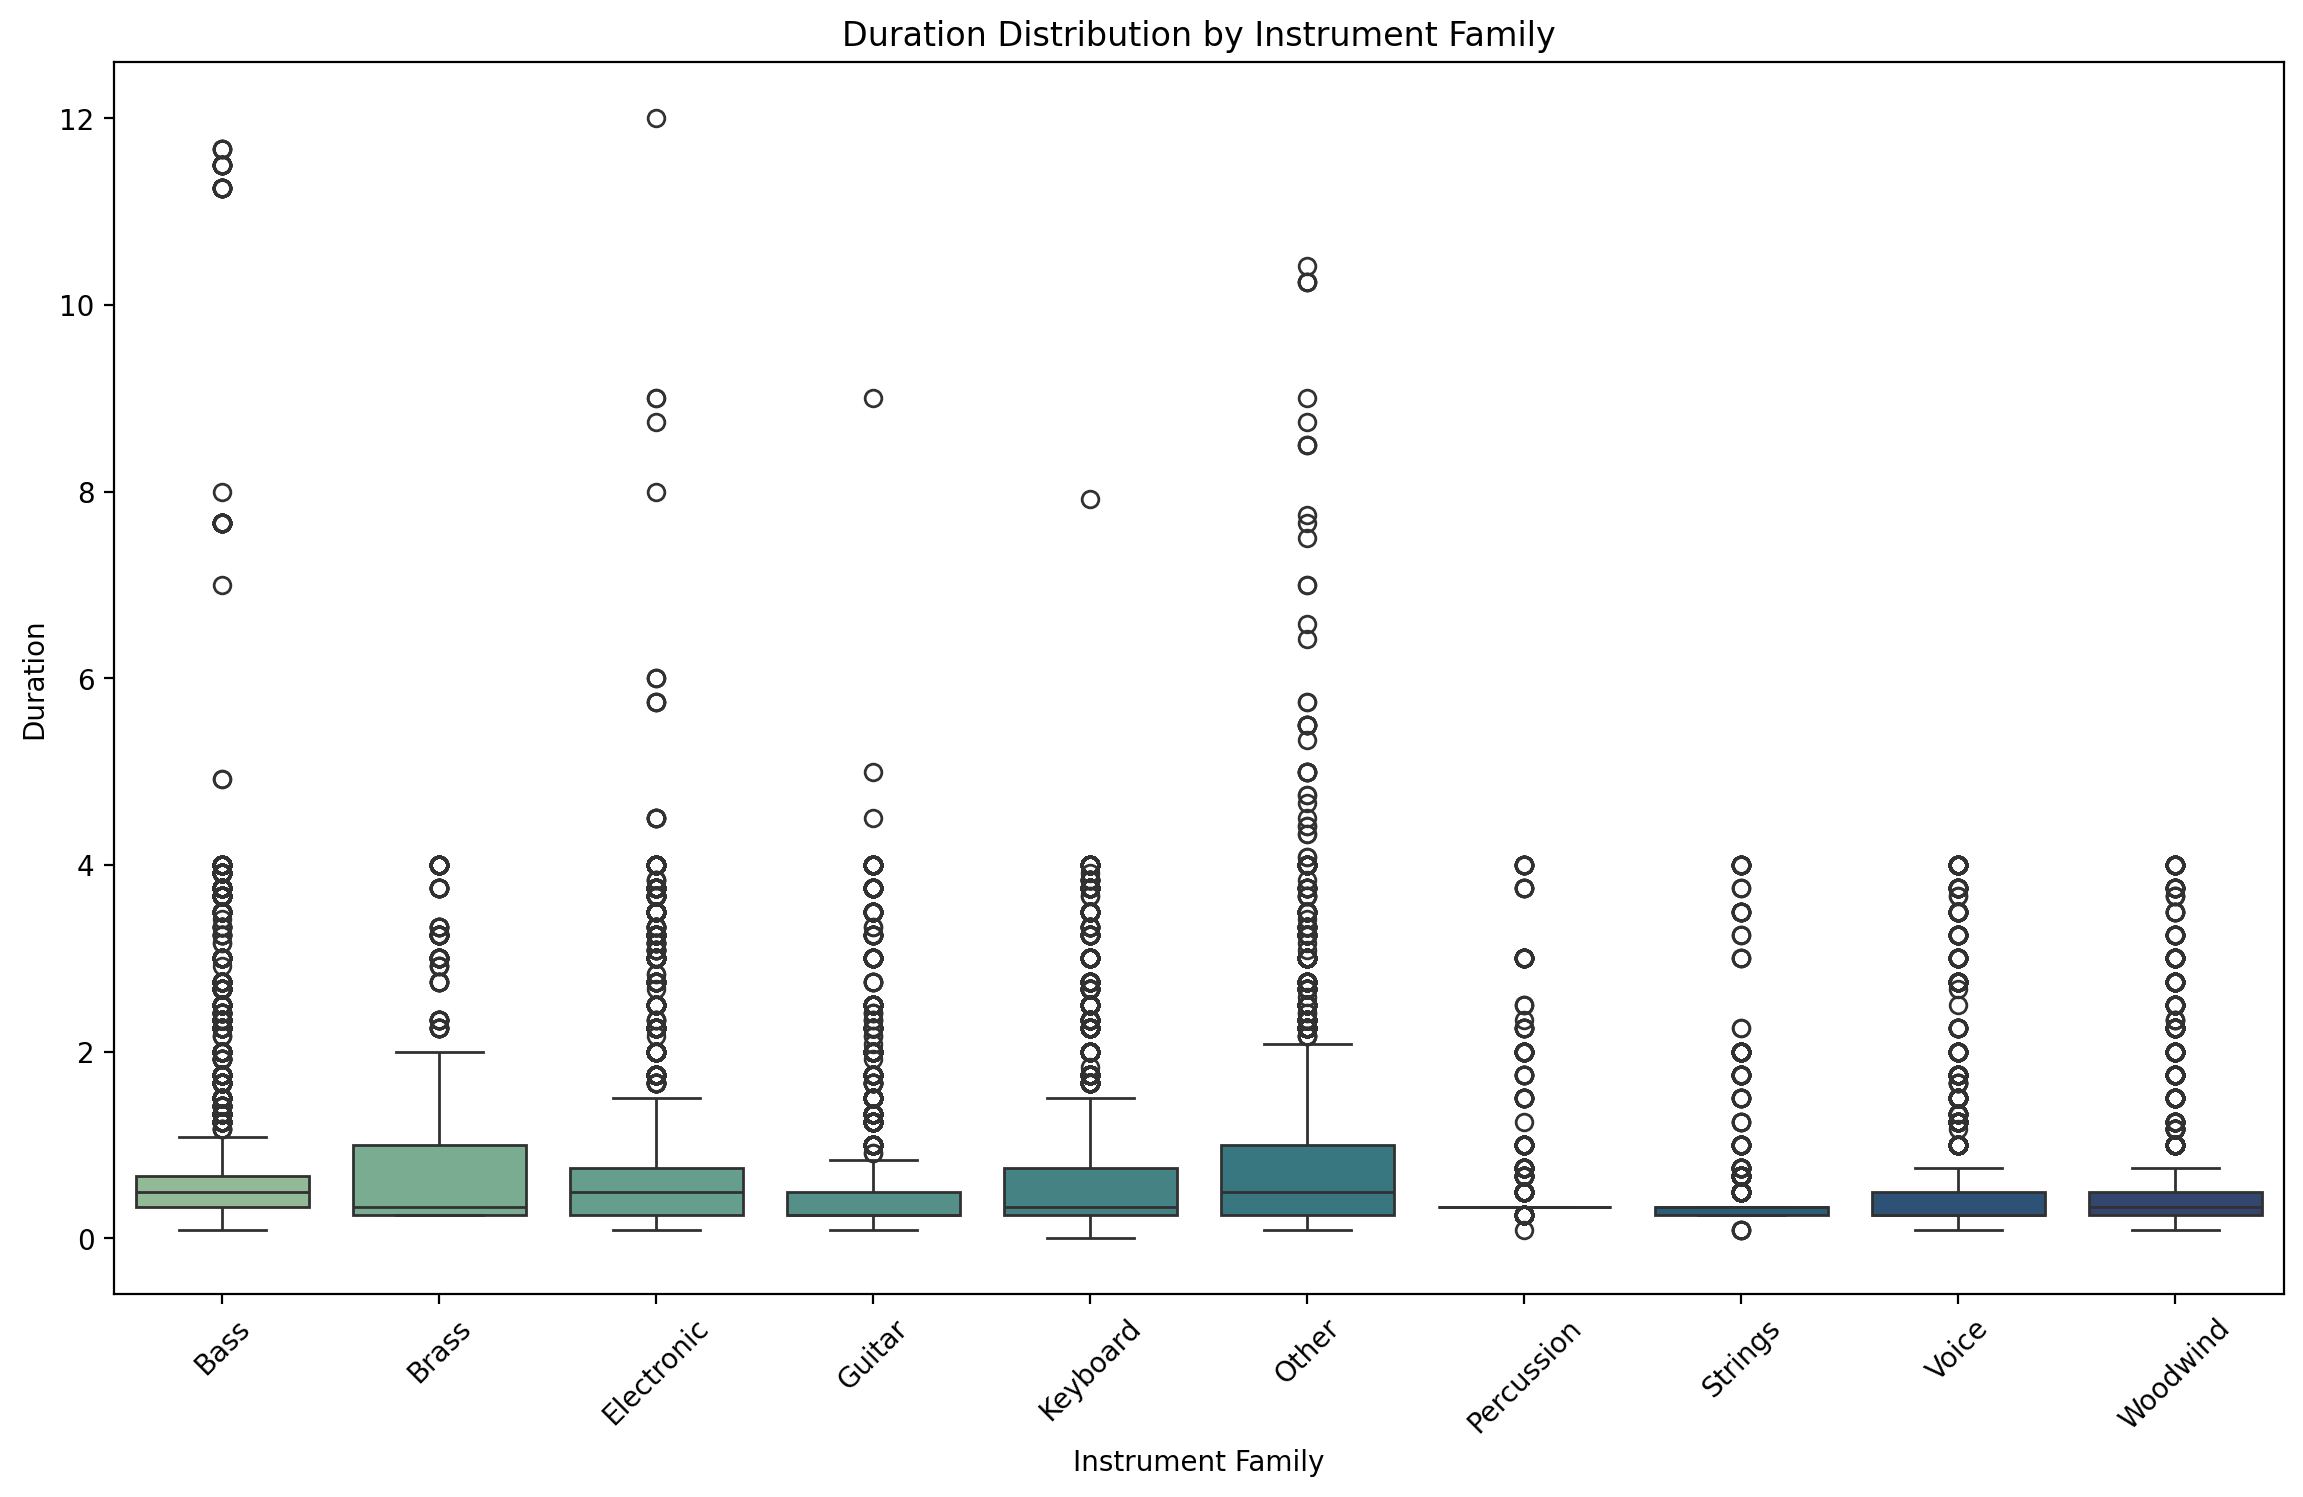

In [189]:
# Filter and plot duration distribution by instrument family
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='instrument_family',
    y='duration',
    palette='crest',
    order=families
)
plt.title('Duration Distribution by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Duration')
plt.xticks(rotation=45)
plt.show()

In [170]:
# Descriptive statistics of duration by genre
print("Duration statistics by Genre:")
df.groupby('genre')['duration'].describe()

Duration statistics by Genre:


count      mean       std       min       25%       50%  \
genre                                                                         
alternative_rock   7460.0  0.566957  0.487995  0.250000  0.250000  0.500000   
blues             22575.0  0.609779  0.765265  0.083333  0.250000  0.333333   
classical         15371.0  0.603474  0.607842  0.083333  0.250000  0.500000   
country           14654.0  0.739542  0.702205  0.166667  0.333333  0.500000   
dance              6910.0  0.569875  0.508098  0.083333  0.250000  0.500000   
disco              9845.0  0.661630  0.879264  0.000000  0.250000  0.250000   
heavy_metal        6189.0  0.658682  0.704991  0.083333  0.250000  0.500000   
jazz              13486.0  1.079280  0.945650  0.166667  0.333333  0.750000   
new_age           21791.0  0.502413  0.621261  0.083333  0.250000  0.333333   
pop               12478.0  0.765768  0.572531  0.166667  0.333333  0.500000   
rap               13449.0  0.350875  0.367836  0.083333  0.250000  0.250000   
reggae            14663.0  0.632238  0.964441  0.083333  0.250000  0.333333   
rnb               13780.0  0.596976  0.721630  0.166667  0.250000  0.250000   
rock               7344.0  0.463315  0.498217  0.083333  0.250000  0.250000   
soul              12197.0  0.648083  0.661726  0.083333  0.250000  0.500000   

                       75%        max  
genre                                  
alternative_rock  0.500000  12.000000  
blues             0.500000   7.000000  
classical         0.500000  10.416667  
country           0.750000   9.000000  
dance             0.500000   8.000000  
disco             0.500000   5.750000  
heavy_metal       0.500000   8.750000  
jazz              1.500000   4.000000  
new_age           0.333333   4.000000  
pop               1.000000   4.000000  
rap               0.250000   4.000000  
reggae            0.500000  11.666667  
rnb               0.500000   4.000000  
rock              0.500000   7.916667  
soul              0.500000   4.000000

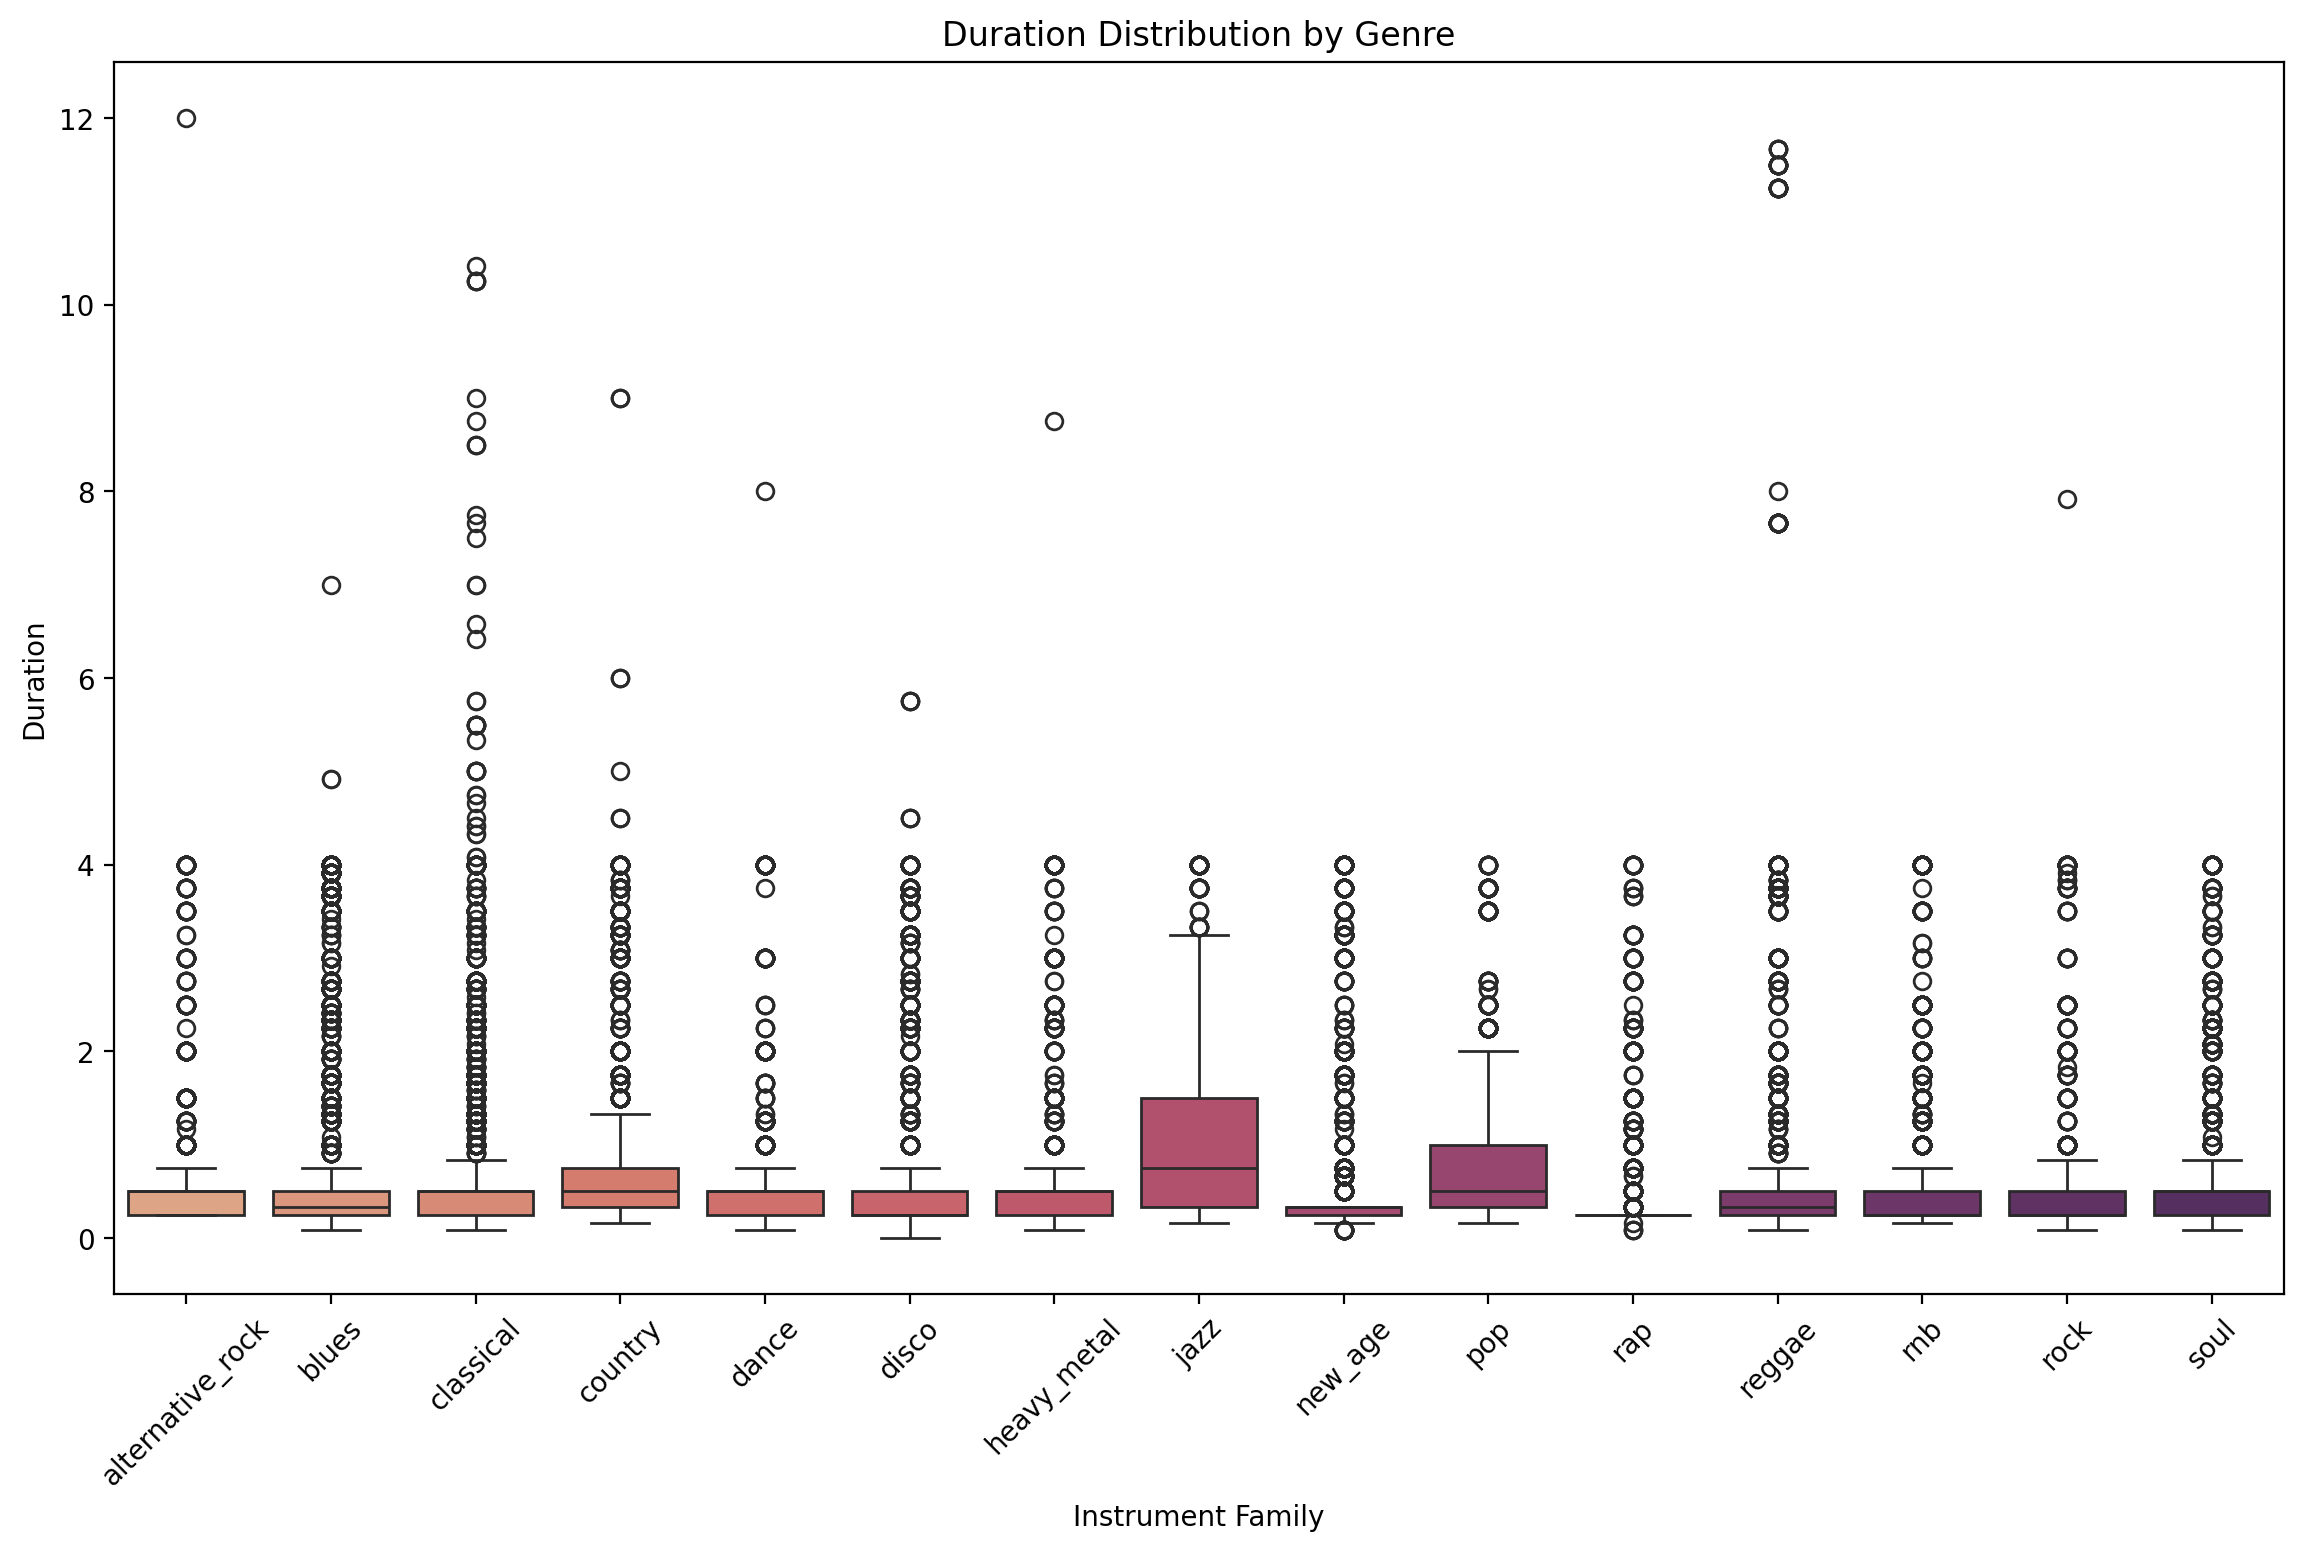

In [190]:
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='genre',
    y='duration',
    palette='flare',
    order=genres_sorted
)
plt.title('Duration Distribution by Genre')
plt.xlabel('Instrument Family')
plt.ylabel('Duration')
plt.xticks(rotation=45)
plt.show()

##### 2.3.5.4 Metric Weight vs Note Duration

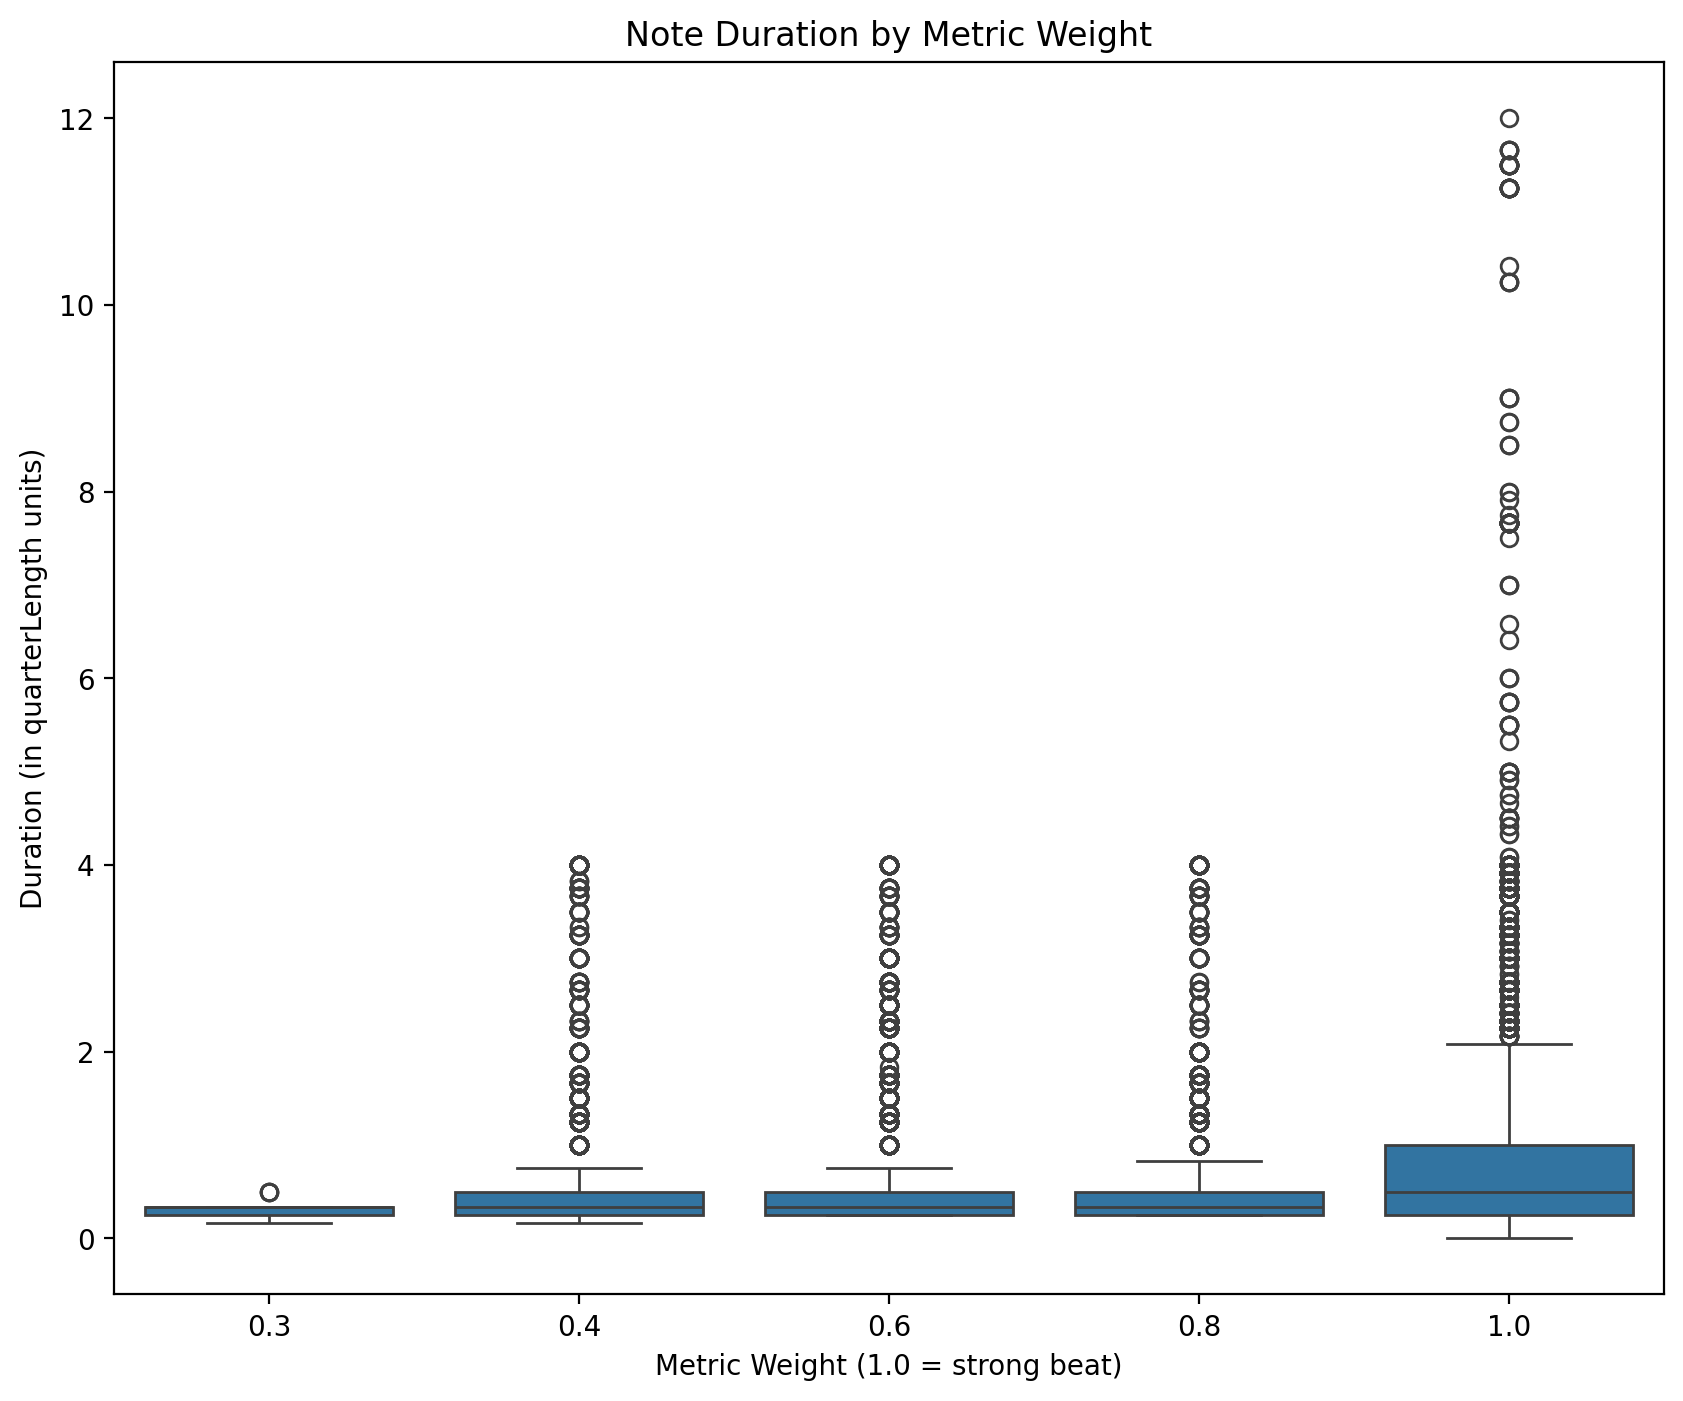

In [191]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Create a boxplot showing how note duration varies with metric weight
sns.boxplot(x="metric_weight", y="duration", data=df)

# Add a descriptive title and axis labels
plt.title("Note Duration by Metric Weight")
plt.xlabel("Metric Weight (1.0 = strong beat)")
plt.ylabel("Duration (in quarterLength units)")
plt.show()

##### 2.3.5.5 Average Note Duration by Polyphony and Metric Weight

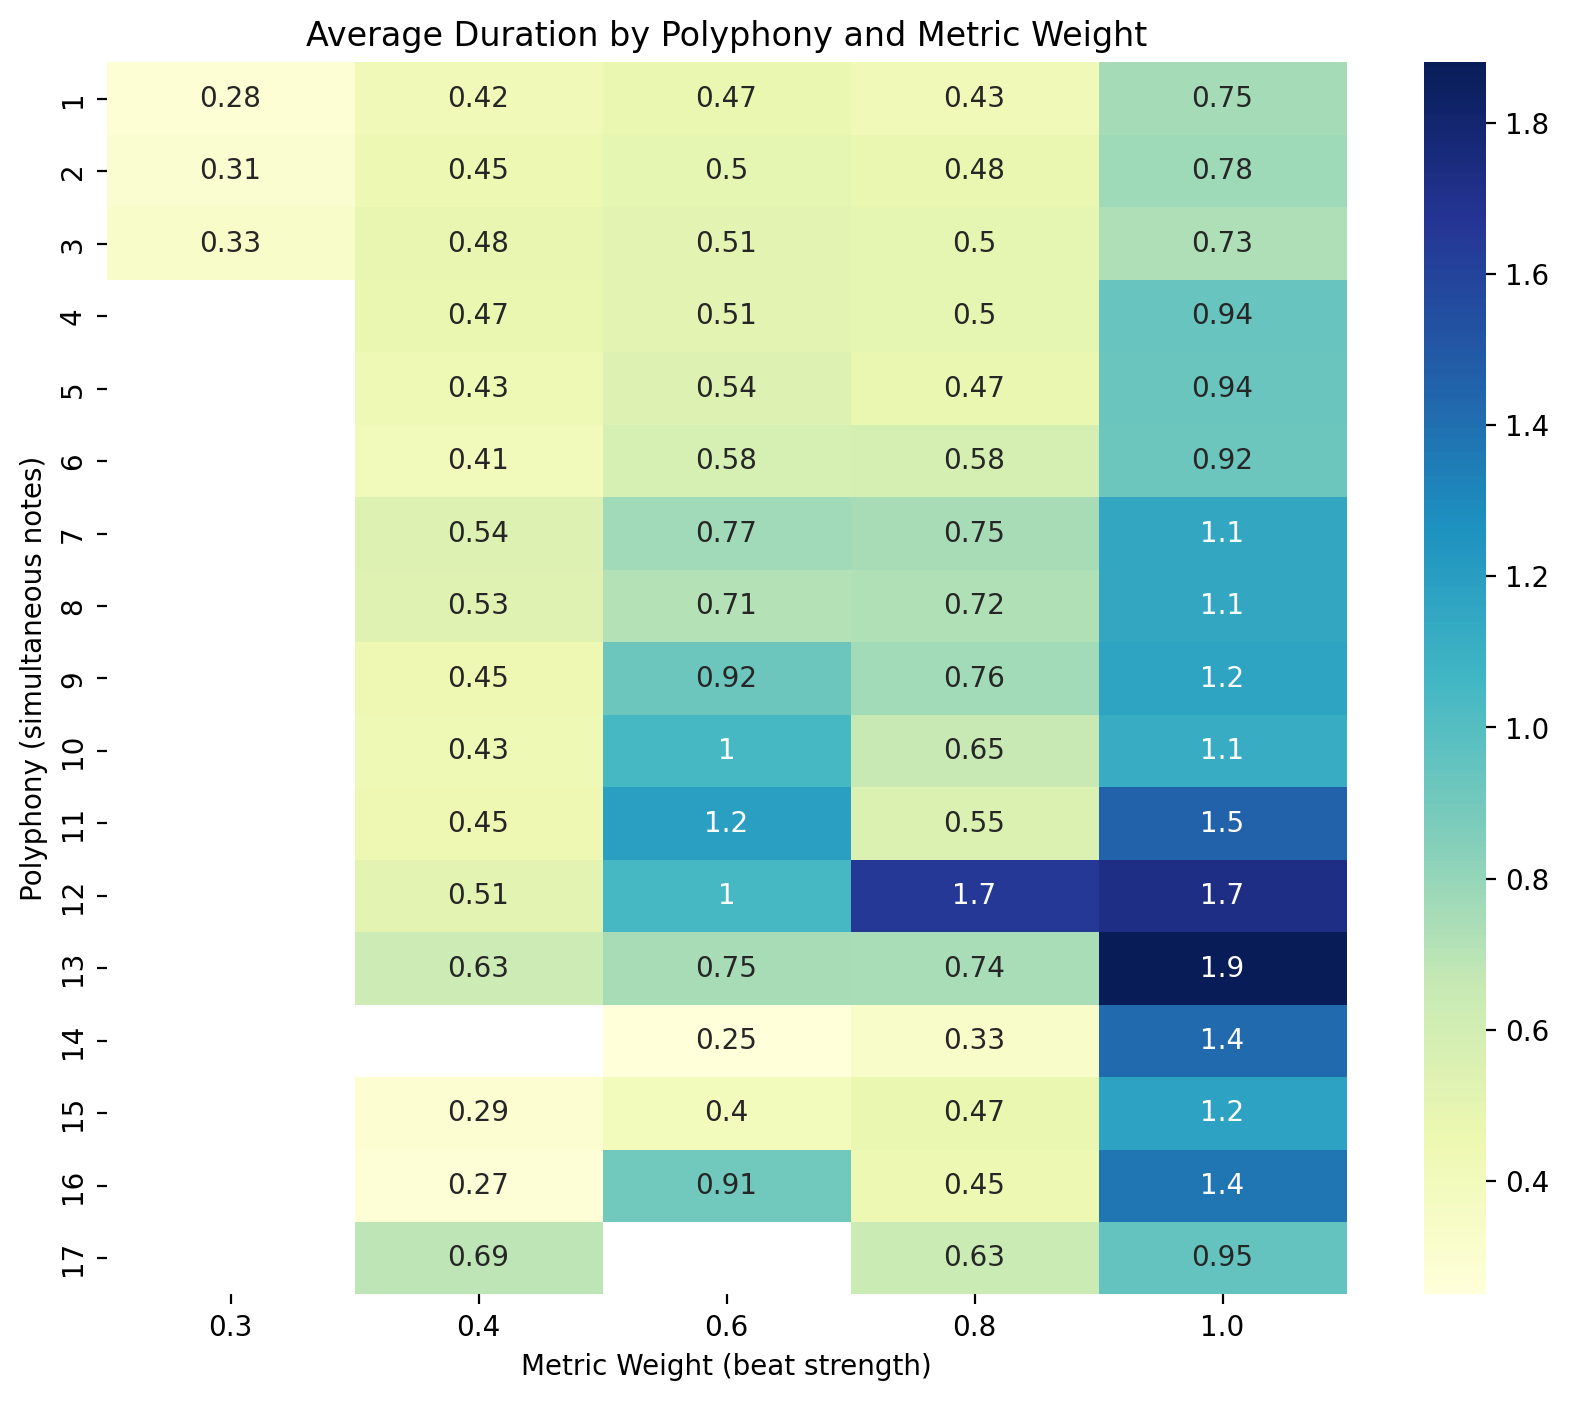

In [192]:
# Create a pivot table to analyze the average duration of notes
# Rows represent different levels of polyphony (number of simultaneous notes)
# Columns represent the metric weight (perceived strength of the beat)
pivot = df.pivot_table(values="duration", index="polyphony", columns="metric_weight", aggfunc="mean")

# Plot a heatmap to visualize how average duration varies across polyphonic texture and metric position
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, ax=ax)

# Add a descriptive title and axis labels
plt.title("Average Duration by Polyphony and Metric Weight")
plt.xlabel("Metric Weight (beat strength)")
plt.ylabel("Polyphony (simultaneous notes)")
plt.show()

#### 2.3.6 Melodic Motion: Interval Between Consecutive Notes

##### 2.3.6.1 Central Tendency and Spread of Interval Between Consecutive Notes


In [194]:
# Central tendency
mean_interval_to_prev = df['interval_to_prev'].mean()
median_interval_to_prev = df['interval_to_prev'].median()
mode_interval_to_prev = df['interval_to_prev'].mode()[0]  

# Spread
std_interval_to_prev = df['interval_to_prev'].std()

# Display results
print(f"Mean interval between consecutive notes: {mean_interval_to_prev:.2f}")
print(f"Median interval between consecutive notes: {median_interval_to_prev:.2f}")
print(f"Mode interval between consecutive notes: {mode_interval_to_prev}")
print(f"Standard interval between consecutive notes: {std_interval_to_prev:.2f}")

Mean interval between consecutive notes: 11.67
Median interval between consecutive notes: 7.00
Mode interval between consecutive notes: 3
Standard interval between consecutive notes: 11.09


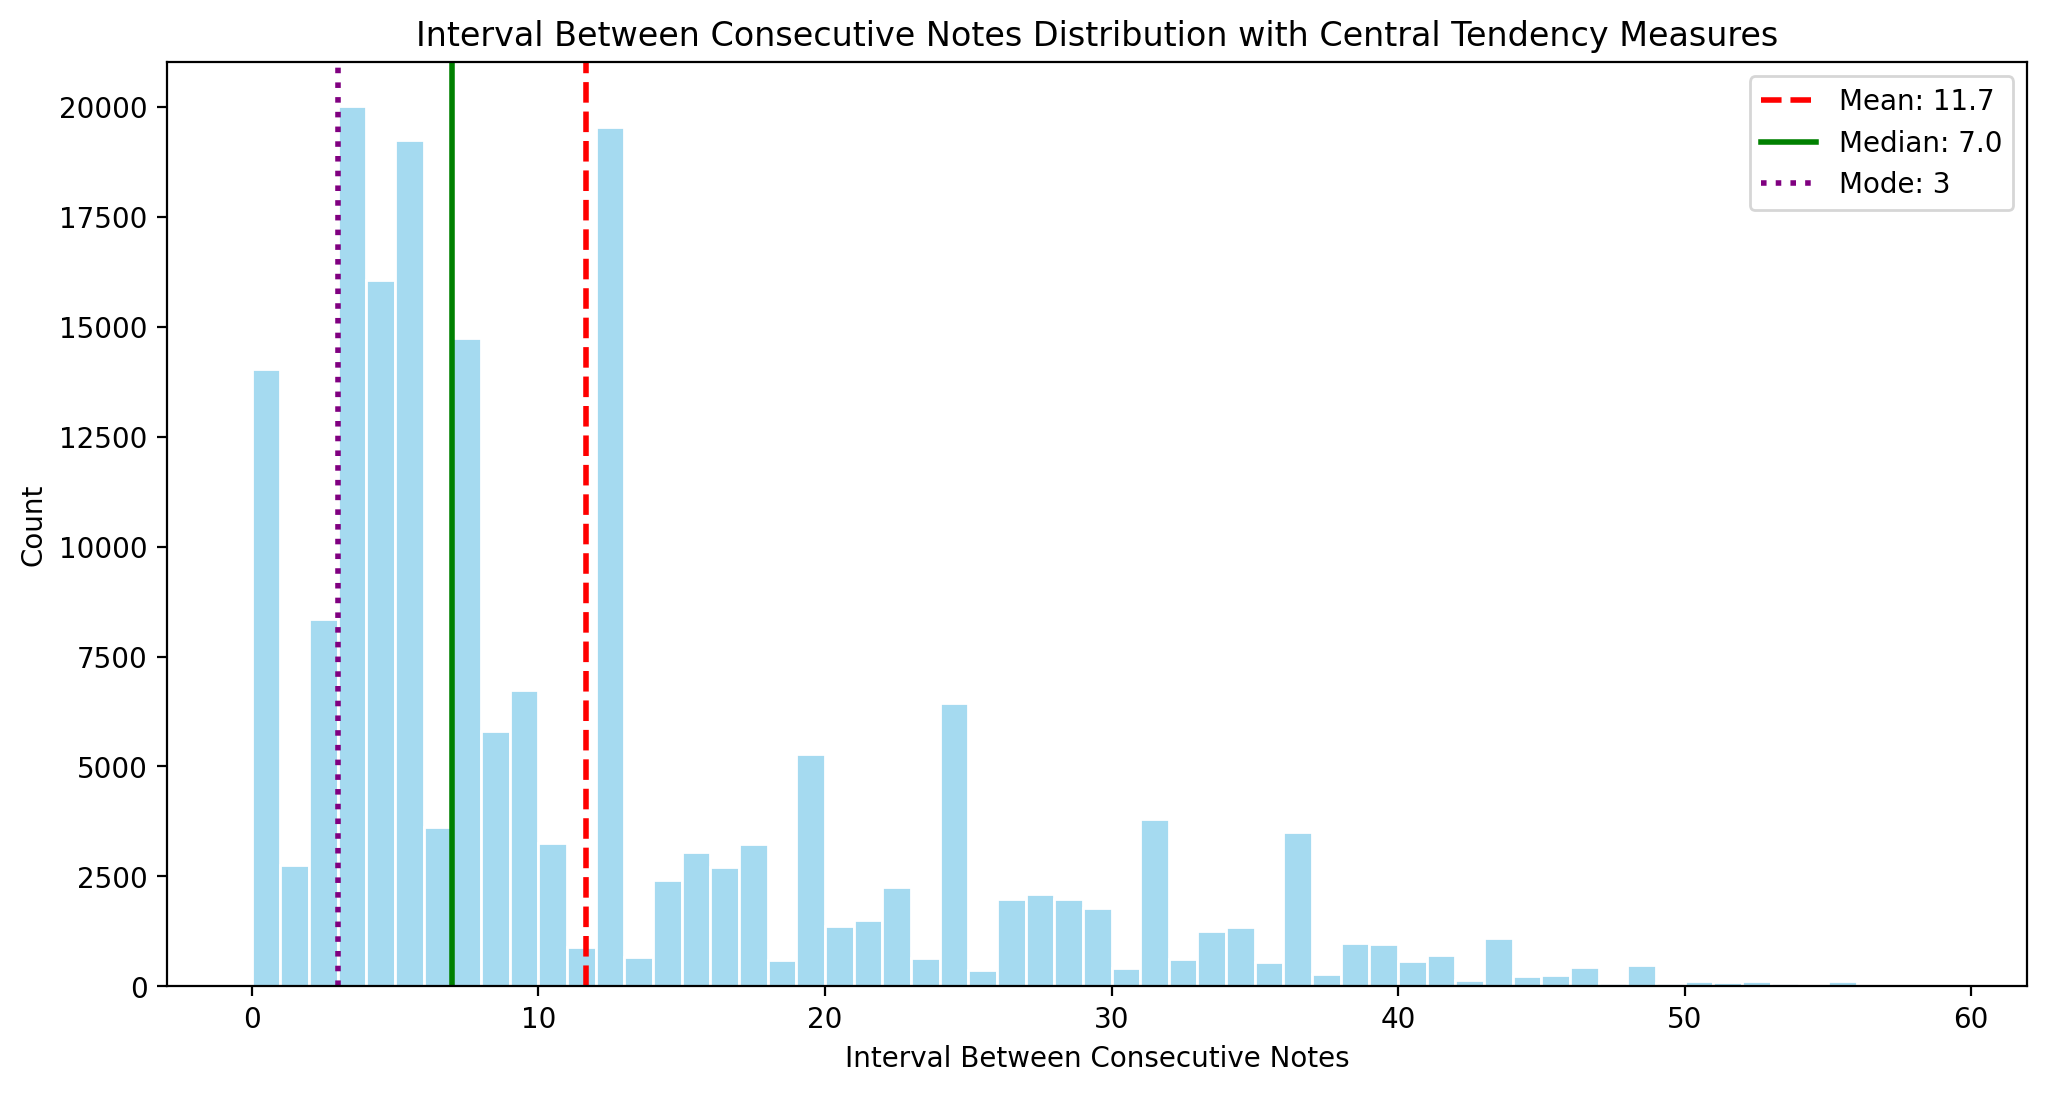

In [200]:
plt.figure(figsize=(12, 6))
sns.histplot(df['interval_to_prev'], bins=range(0, 60), color='skyblue', edgecolor='white')

# Add lines for mean, median, and mode
plt.axvline(mean_interval_to_prev, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_interval_to_prev:.1f}')
plt.axvline(median_interval_to_prev, color='green', linestyle='-', linewidth=2, label=f'Median: {median_interval_to_prev}')
plt.axvline(mode_interval_to_prev, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_interval_to_prev}')

plt.title('Interval Between Consecutive Notes Distribution with Central Tendency Measures')
plt.xlabel('Interval Between Consecutive Notes')
plt.ylabel('Count')
plt.legend()
plt.show()

##### 2.3.6.2 Outlier Detection in Intervals Between Consecutive Notes


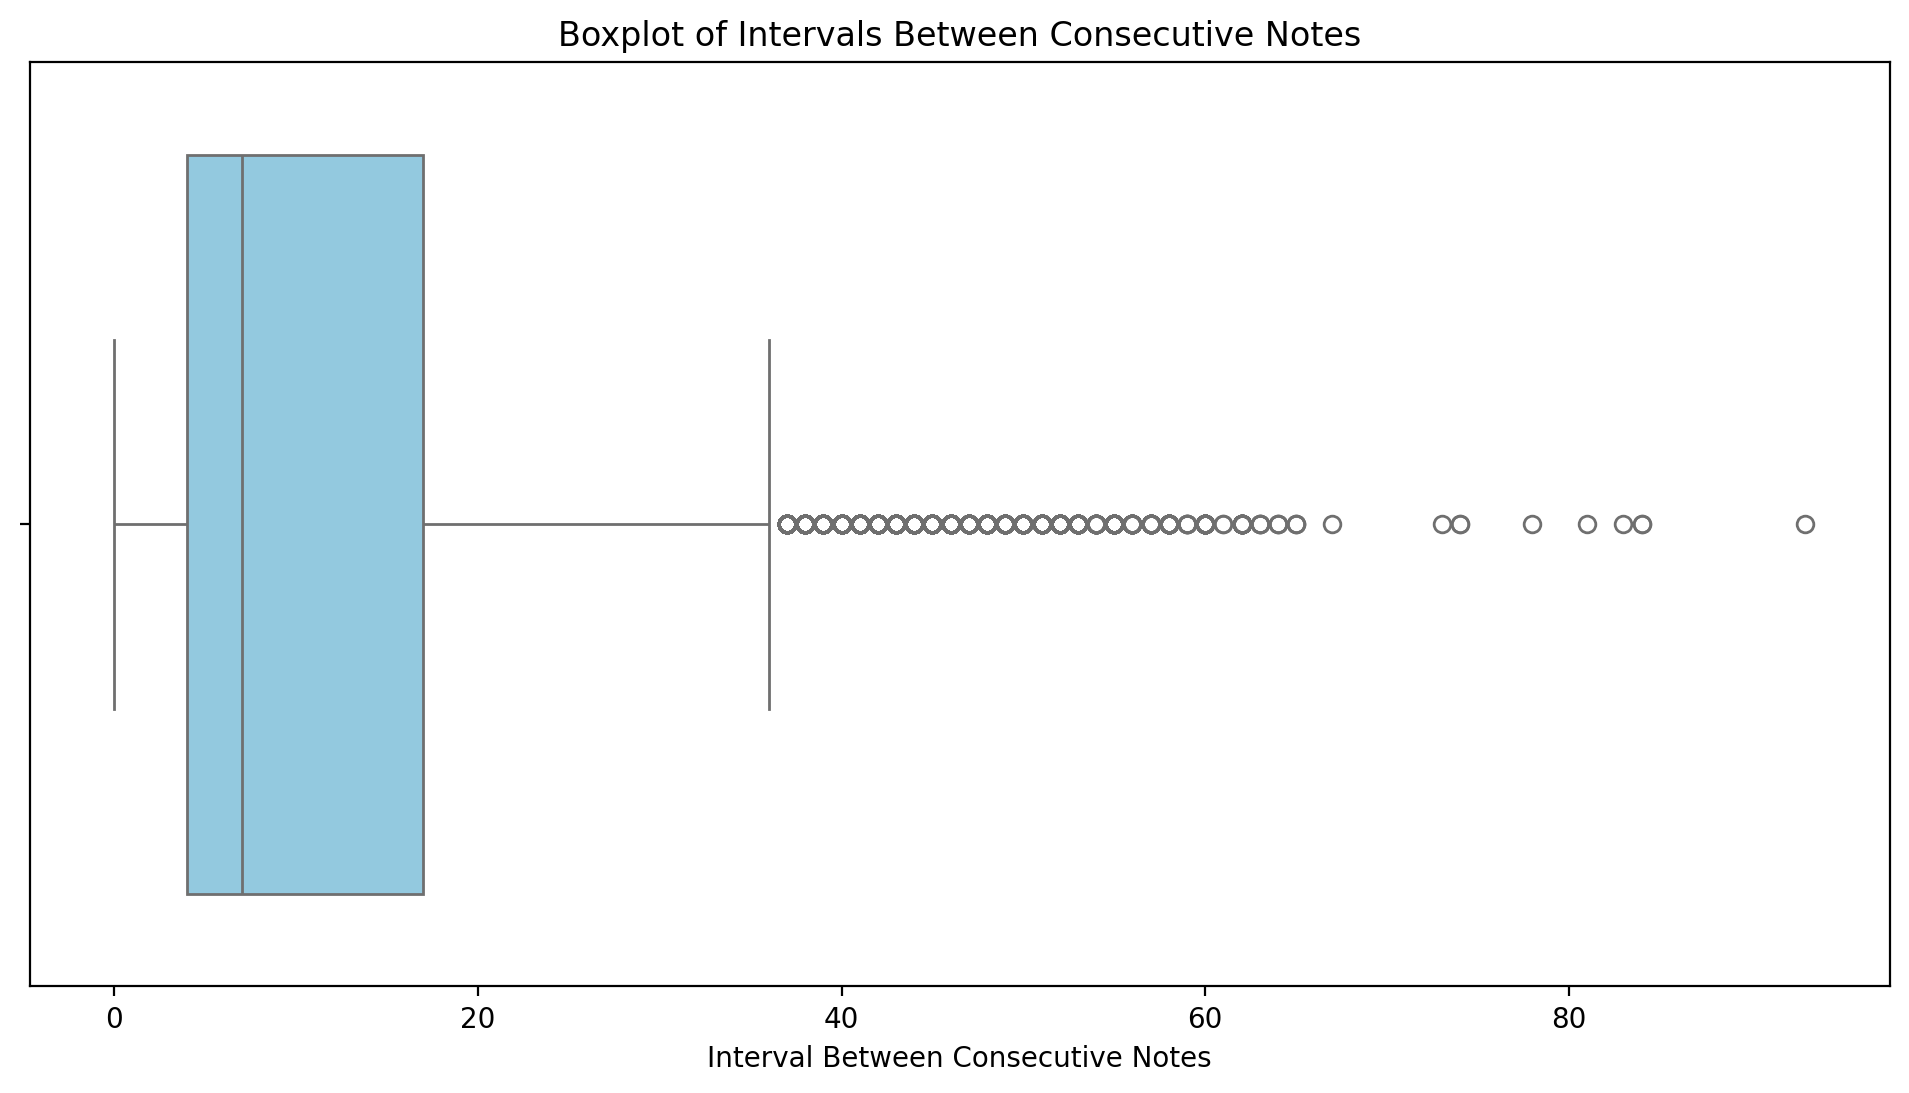

In [205]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['interval_to_prev'], color='skyblue')
plt.title('Boxplot of Intervals Between Consecutive Notes')
plt.xlabel('Interval Between Consecutive Notes')
plt.show()

##### 2.3.6.3 Interval Between Consecutive Notes in Context: Key, Instrument, and Genre

In [206]:
# Descriptive statistics of intervals between consecutive notes by key
print("Interval Between Consecutive Notes statistics by Key:")
df.groupby('key')['interval_to_prev'].describe().sort_index()

Interval Between Consecutive Notes statistics by Key:


count       mean        std  min  25%   50%   75%   max
key                                                           
0    11608.0  11.789972  10.978310  0.0  4.0   7.0  17.0  65.0
1     8535.0  12.507323  11.984998  0.0  4.0   7.0  19.0  60.0
2     5075.0  10.573399   9.180679  0.0  4.0   7.0  13.0  52.0
3    13501.0  12.282794  10.769017  0.0  4.0   9.0  19.0  62.0
4     8834.0   9.883745  10.648420  0.0  4.0   7.0  10.0  55.0
5    17733.0  13.377827  12.044363  0.0  4.0   8.0  22.0  60.0
6     4806.0  11.332501  10.523554  0.0  4.0   8.0  15.0  56.0
7    10897.0  11.639534  10.174298  0.0  3.0  12.0  16.0  52.0
9     3344.0  15.031699  14.034109  0.0  7.0   9.0  21.0  60.0
11   24410.0  10.914502  10.641531  0.0  4.0   7.0  12.0  93.0
12    7224.0   8.787237   8.172632  0.0  3.0   7.0  12.0  42.0
13    9294.0   9.937917   8.457381  0.0  4.0   7.0  12.0  55.0
14    7794.0  12.936618  11.423391  0.0  3.0   7.0  22.0  84.0
15    1626.0  11.393604   9.227587  0.0  4.0  10.0  16.0  45.0
16   19702.0  11.942848  11.919066  0.0  3.0   6.0  19.0  83.0
17    7936.0   9.714466   9.487225  0.0  3.0   5.0  14.0  48.0
19   16036.0  12.317224  12.231560  0.0  3.0   7.0  19.0  60.0
21    8261.0  13.340637  12.549599  0.0  3.0  10.0  21.0  51.0
23    5576.0  11.024570   9.937794  0.0  5.0   7.0  15.0  55.0

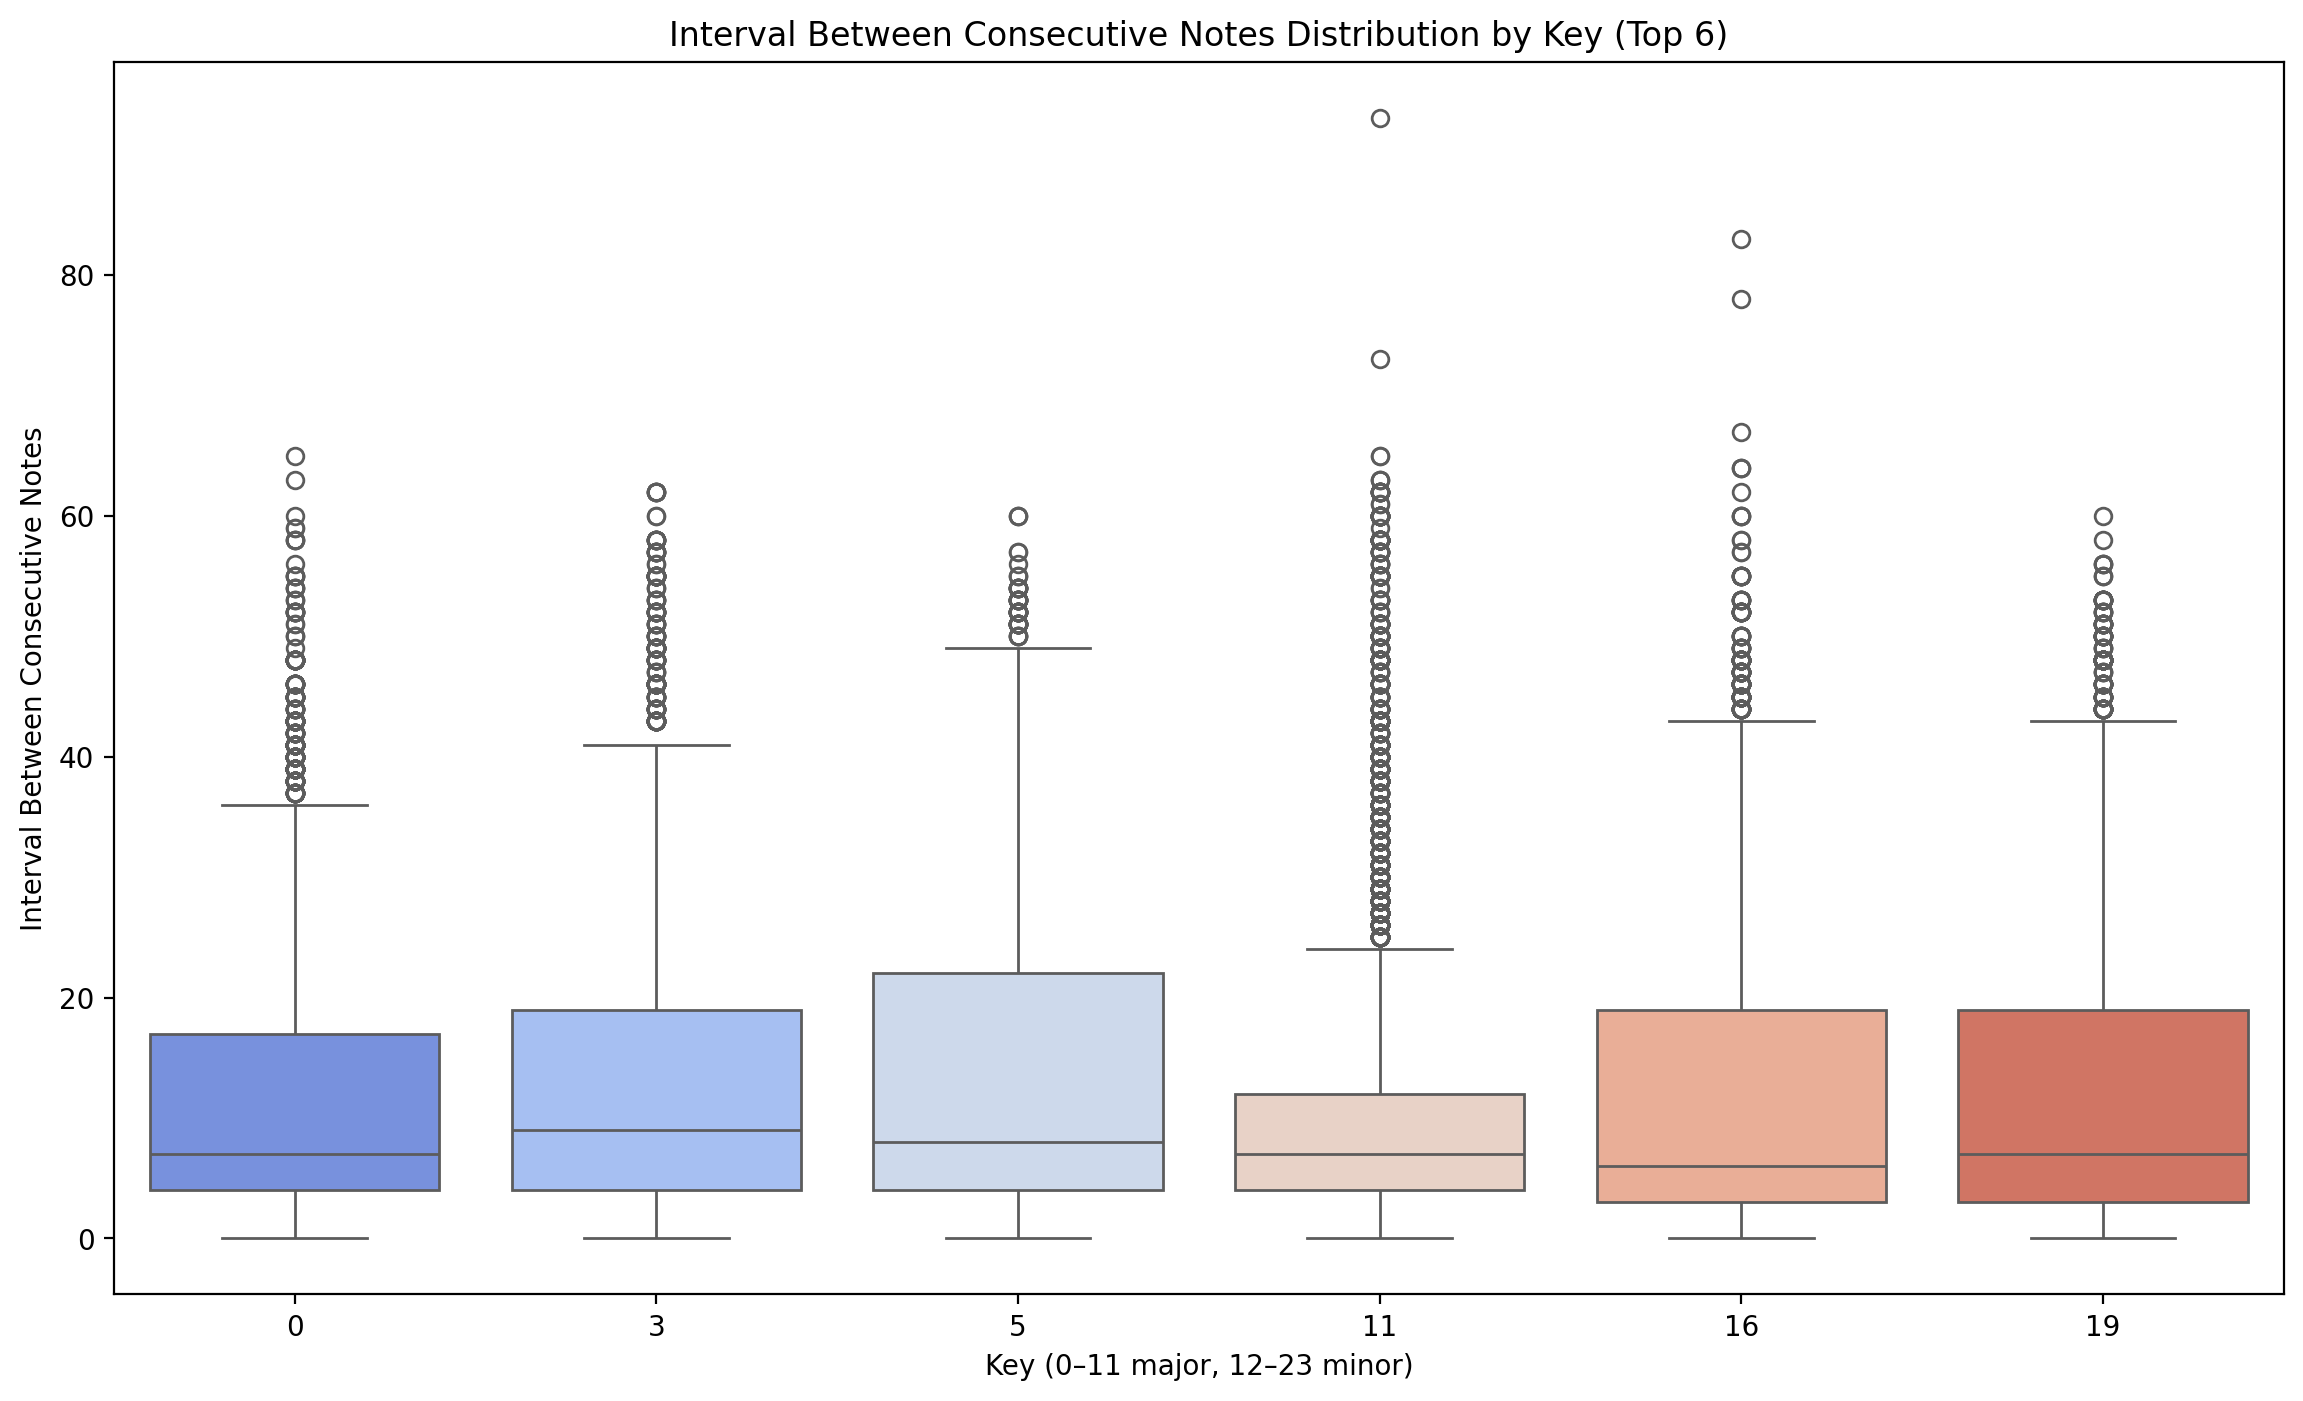

In [208]:
# Interval between consecutive notes distribution across top 6 keys to show tonal variation.
plt.figure(figsize=(14,8))
sns.boxplot(data=df[df['key'].isin(top_keys)], x='key', y='interval_to_prev', palette='coolwarm')
plt.title('Interval Between Consecutive Notes Distribution by Key (Top 6)')
plt.xlabel('Key (0–11 major, 12–23 minor)')
plt.ylabel('Interval Between Consecutive Notes')
plt.show()

In [209]:
# Descriptive statistics of interval between consecutive notes values by instrument
print("Interval Between Consecutive Notes statistics by Instrument:")
df.groupby('instrument')['interval_to_prev'].describe()

Interval Between Consecutive Notes statistics by Instrument:


count       mean        std  min  25%   50%   75%   max
instrument                                                                 
Acoustic Bass     11262.0  10.155212   8.814755  0.0  4.0   8.0  12.0  51.0
Acoustic Guitar   18001.0  10.150881   9.706814  0.0  4.0   7.0  13.0  65.0
Bagpipes           4865.0  13.801028  13.212252  0.0  5.0   5.0  24.0  60.0
Bassoon            1729.0   9.147484  10.460889  0.0  0.0   4.0  16.0  46.0
Celesta            8514.0  13.042636  11.016479  0.0  4.0  10.0  19.0  83.0
Choir              2984.0  10.384383   9.453915  0.0  4.0   7.0  12.0  55.0
Clarinet            998.0  14.907816  12.529264  0.0  5.0  12.0  24.0  53.0
Contrabass         9168.0  12.109511  10.050902  0.0  4.0  12.0  16.0  52.0
Electric Bass       647.0  10.190108   9.147875  0.0  5.0   7.0  12.0  41.0
Electric Guitar   21454.0  12.905845  12.035695  0.0  4.0   7.0  22.0  93.0
Electric Organ     2280.0  15.135526  13.482134  0.0  5.0   9.0  24.0  60.0
Fretless Bass      4777.0  13.557463  11.894994  0.0  4.0   9.0  20.0  55.0
Glockenspiel        133.0  12.947368  14.477943  0.0  3.0   5.0  19.0  55.0
Marimba             235.0  10.038298   4.393398  0.0  7.0  12.0  12.0  21.0
Ocarina             575.0  12.086957  11.684712  0.0  3.0   8.0  17.0  56.0
Piano             38177.0  11.408518  10.718715  0.0  4.0   7.0  17.0  84.0
Piccolo            1462.0  11.290014  10.775255  0.0  2.0   6.0  20.0  46.0
Recorder           1097.0  12.966272  10.835101  0.0  4.0  12.0  20.0  41.0
Sampler           23546.0  12.140958  11.750194  0.0  4.0   9.0  16.0  62.0
StringInstrument   4078.0  11.907308  10.529878  0.0  5.0   8.0  16.0  54.0
Taiko                61.0   5.540984   5.521394  0.0  0.0   5.0  11.0  24.0
Timpani            1450.0   6.946207   7.564756  0.0  2.0   4.0  10.0  34.0
Trombone           4529.0   8.975270   8.696965  0.0  3.0   5.0  12.0  55.0
Trumpet             105.0   9.561905   9.423706  0.0  3.0   5.0  12.0  36.0
Unknown           14549.0  12.299127  11.756372  0.0  4.0   8.0  17.0  63.0
Violoncello         360.0  11.816667   9.092208  0.0  5.0   7.0  13.0  43.0
Voice             11500.0  10.157913  10.468158  0.0  3.0   7.0  12.0  60.0
Whistle            3656.0  13.096280  15.211038  0.0  3.0   5.0  31.0  58.0

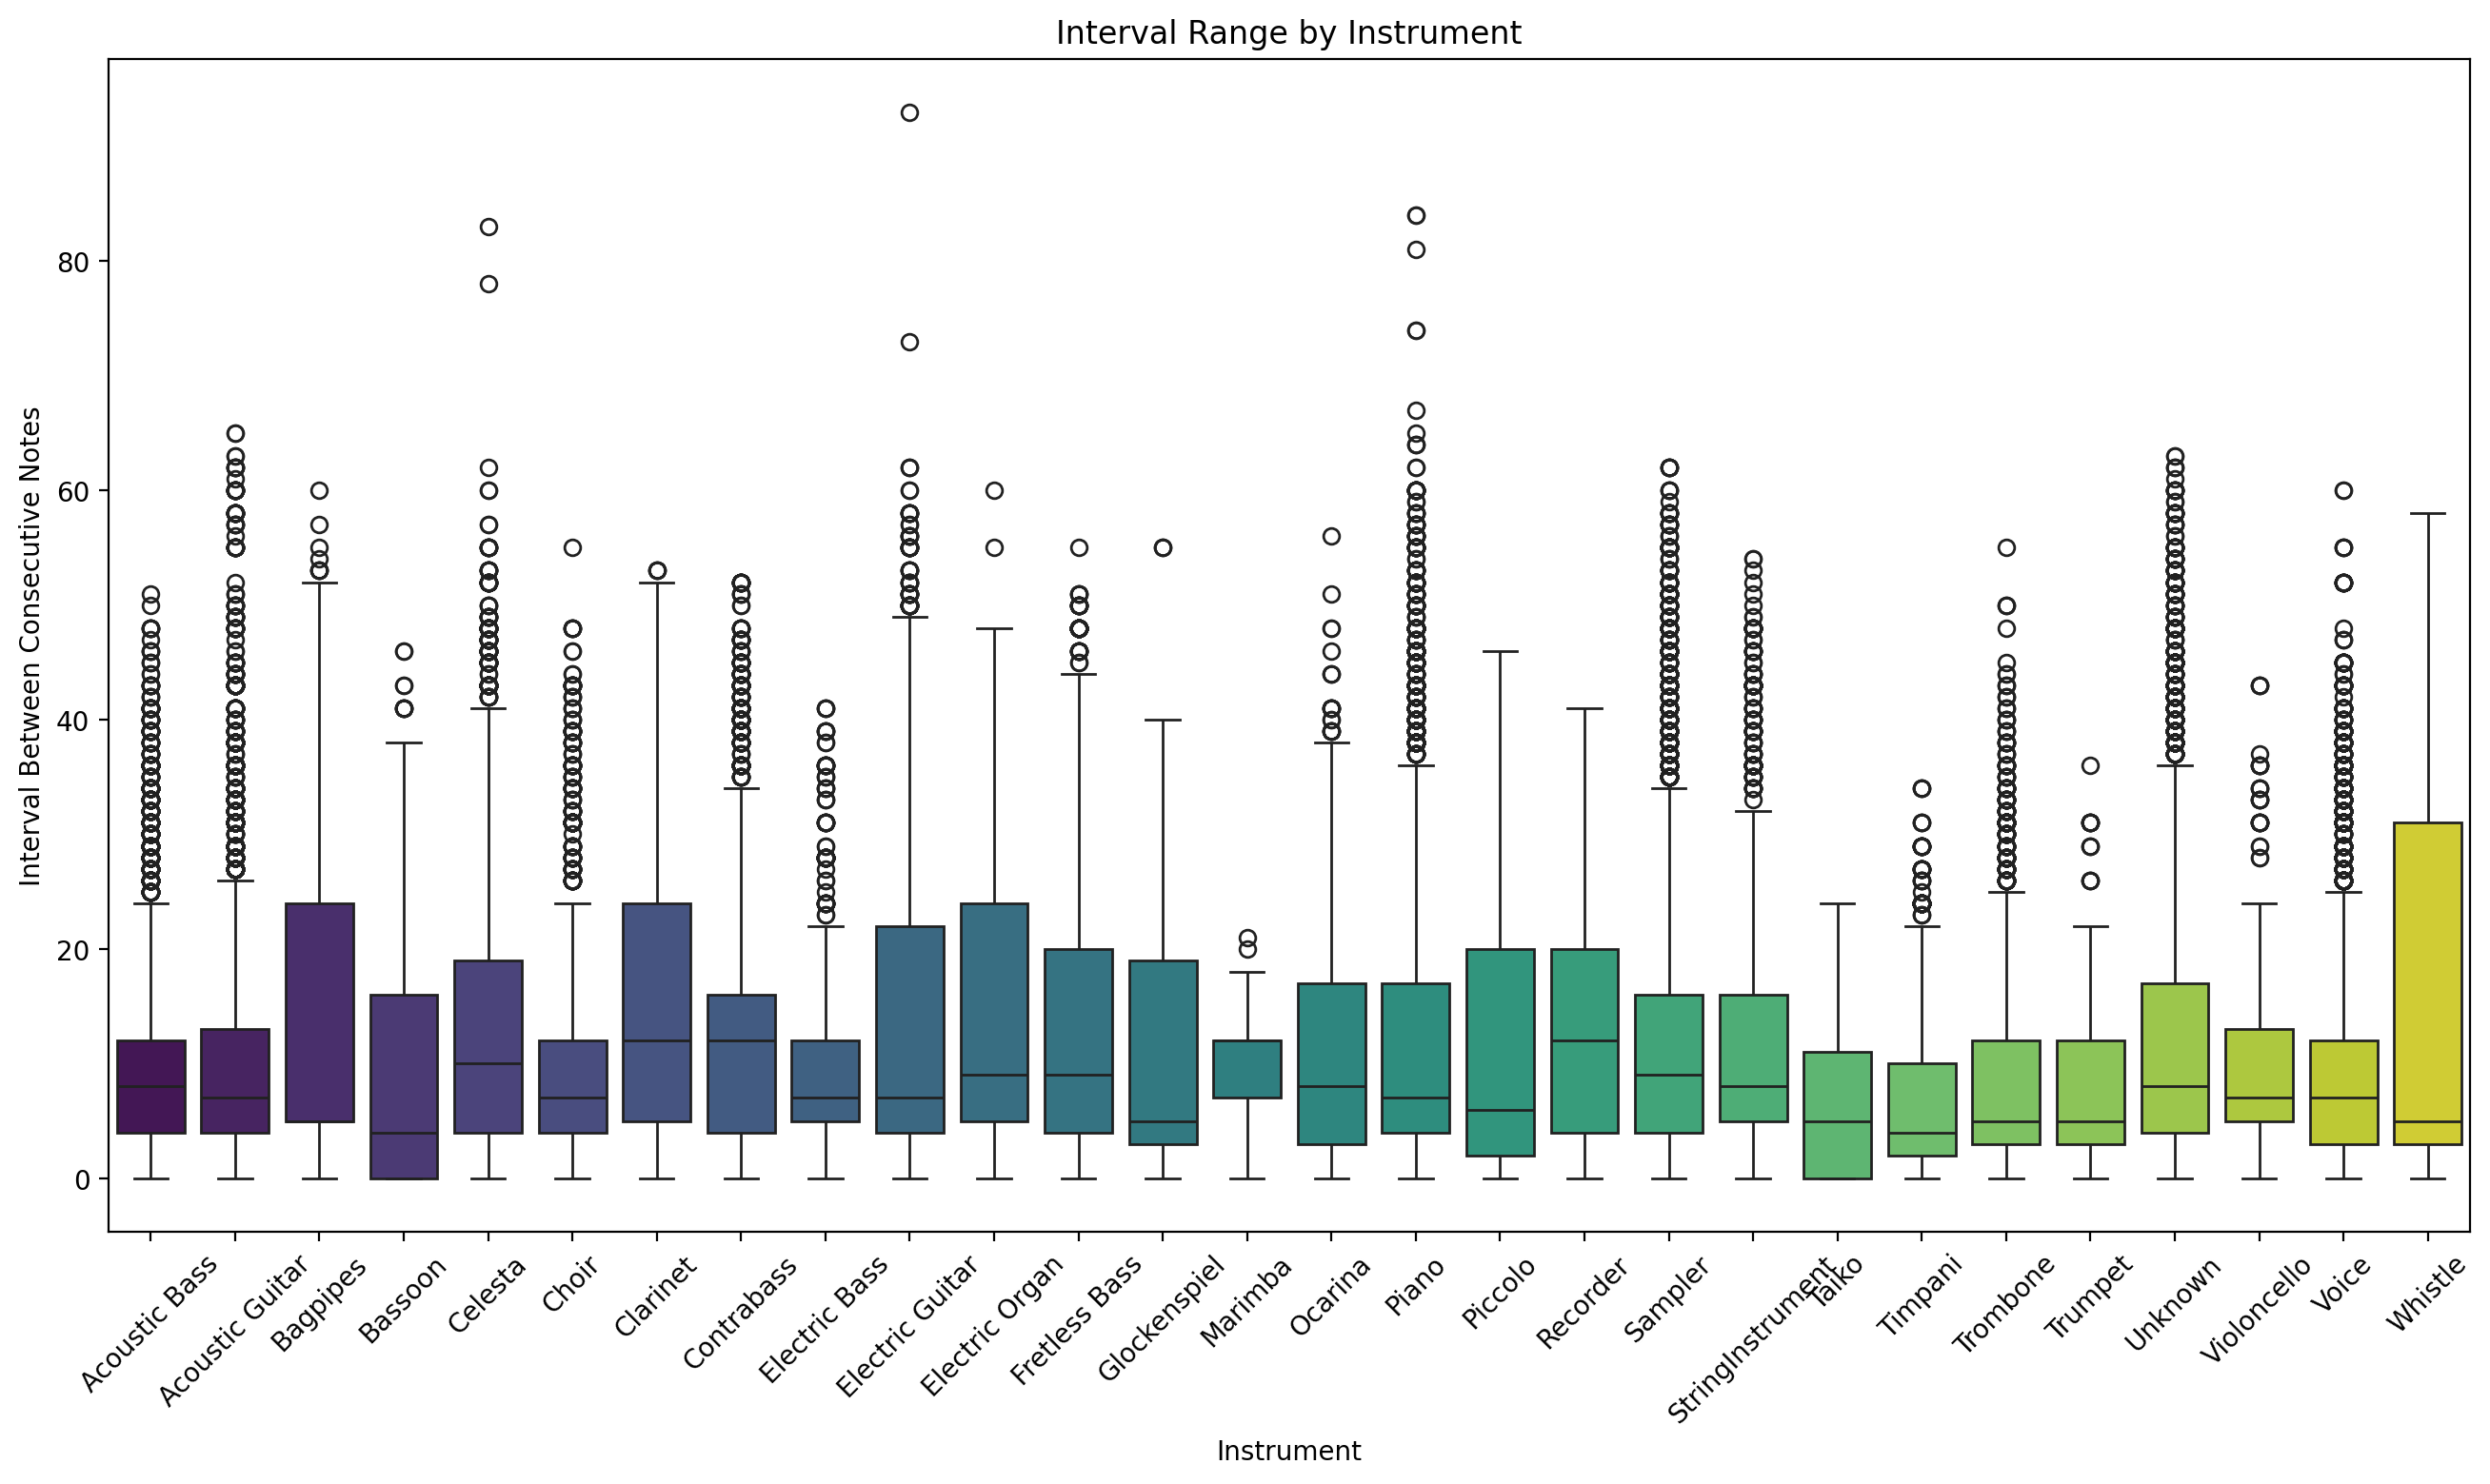

In [210]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='instrument', y='interval_to_prev', palette='viridis', order=alphabetic_order)
plt.xticks(rotation=45)
plt.title('Interval Range by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Interval Between Consecutive Notes')
plt.show()

In [211]:
# Descriptive statistics of intervals between consecutive notes by instrument family
print("Interval Between Consecutive Notes statistics by Instrument Family:")
df.groupby('instrument')['interval_to_prev'].describe()

Interval Between Consecutive Notes statistics by Instrument Family:


count       mean        std  min  25%   50%   75%   max
instrument                                                                 
Acoustic Bass     11262.0  10.155212   8.814755  0.0  4.0   8.0  12.0  51.0
Acoustic Guitar   18001.0  10.150881   9.706814  0.0  4.0   7.0  13.0  65.0
Bagpipes           4865.0  13.801028  13.212252  0.0  5.0   5.0  24.0  60.0
Bassoon            1729.0   9.147484  10.460889  0.0  0.0   4.0  16.0  46.0
Celesta            8514.0  13.042636  11.016479  0.0  4.0  10.0  19.0  83.0
Choir              2984.0  10.384383   9.453915  0.0  4.0   7.0  12.0  55.0
Clarinet            998.0  14.907816  12.529264  0.0  5.0  12.0  24.0  53.0
Contrabass         9168.0  12.109511  10.050902  0.0  4.0  12.0  16.0  52.0
Electric Bass       647.0  10.190108   9.147875  0.0  5.0   7.0  12.0  41.0
Electric Guitar   21454.0  12.905845  12.035695  0.0  4.0   7.0  22.0  93.0
Electric Organ     2280.0  15.135526  13.482134  0.0  5.0   9.0  24.0  60.0
Fretless Bass      4777.0  13.557463  11.894994  0.0  4.0   9.0  20.0  55.0
Glockenspiel        133.0  12.947368  14.477943  0.0  3.0   5.0  19.0  55.0
Marimba             235.0  10.038298   4.393398  0.0  7.0  12.0  12.0  21.0
Ocarina             575.0  12.086957  11.684712  0.0  3.0   8.0  17.0  56.0
Piano             38177.0  11.408518  10.718715  0.0  4.0   7.0  17.0  84.0
Piccolo            1462.0  11.290014  10.775255  0.0  2.0   6.0  20.0  46.0
Recorder           1097.0  12.966272  10.835101  0.0  4.0  12.0  20.0  41.0
Sampler           23546.0  12.140958  11.750194  0.0  4.0   9.0  16.0  62.0
StringInstrument   4078.0  11.907308  10.529878  0.0  5.0   8.0  16.0  54.0
Taiko                61.0   5.540984   5.521394  0.0  0.0   5.0  11.0  24.0
Timpani            1450.0   6.946207   7.564756  0.0  2.0   4.0  10.0  34.0
Trombone           4529.0   8.975270   8.696965  0.0  3.0   5.0  12.0  55.0
Trumpet             105.0   9.561905   9.423706  0.0  3.0   5.0  12.0  36.0
Unknown           14549.0  12.299127  11.756372  0.0  4.0   8.0  17.0  63.0
Violoncello         360.0  11.816667   9.092208  0.0  5.0   7.0  13.0  43.0
Voice             11500.0  10.157913  10.468158  0.0  3.0   7.0  12.0  60.0
Whistle            3656.0  13.096280  15.211038  0.0  3.0   5.0  31.0  58.0

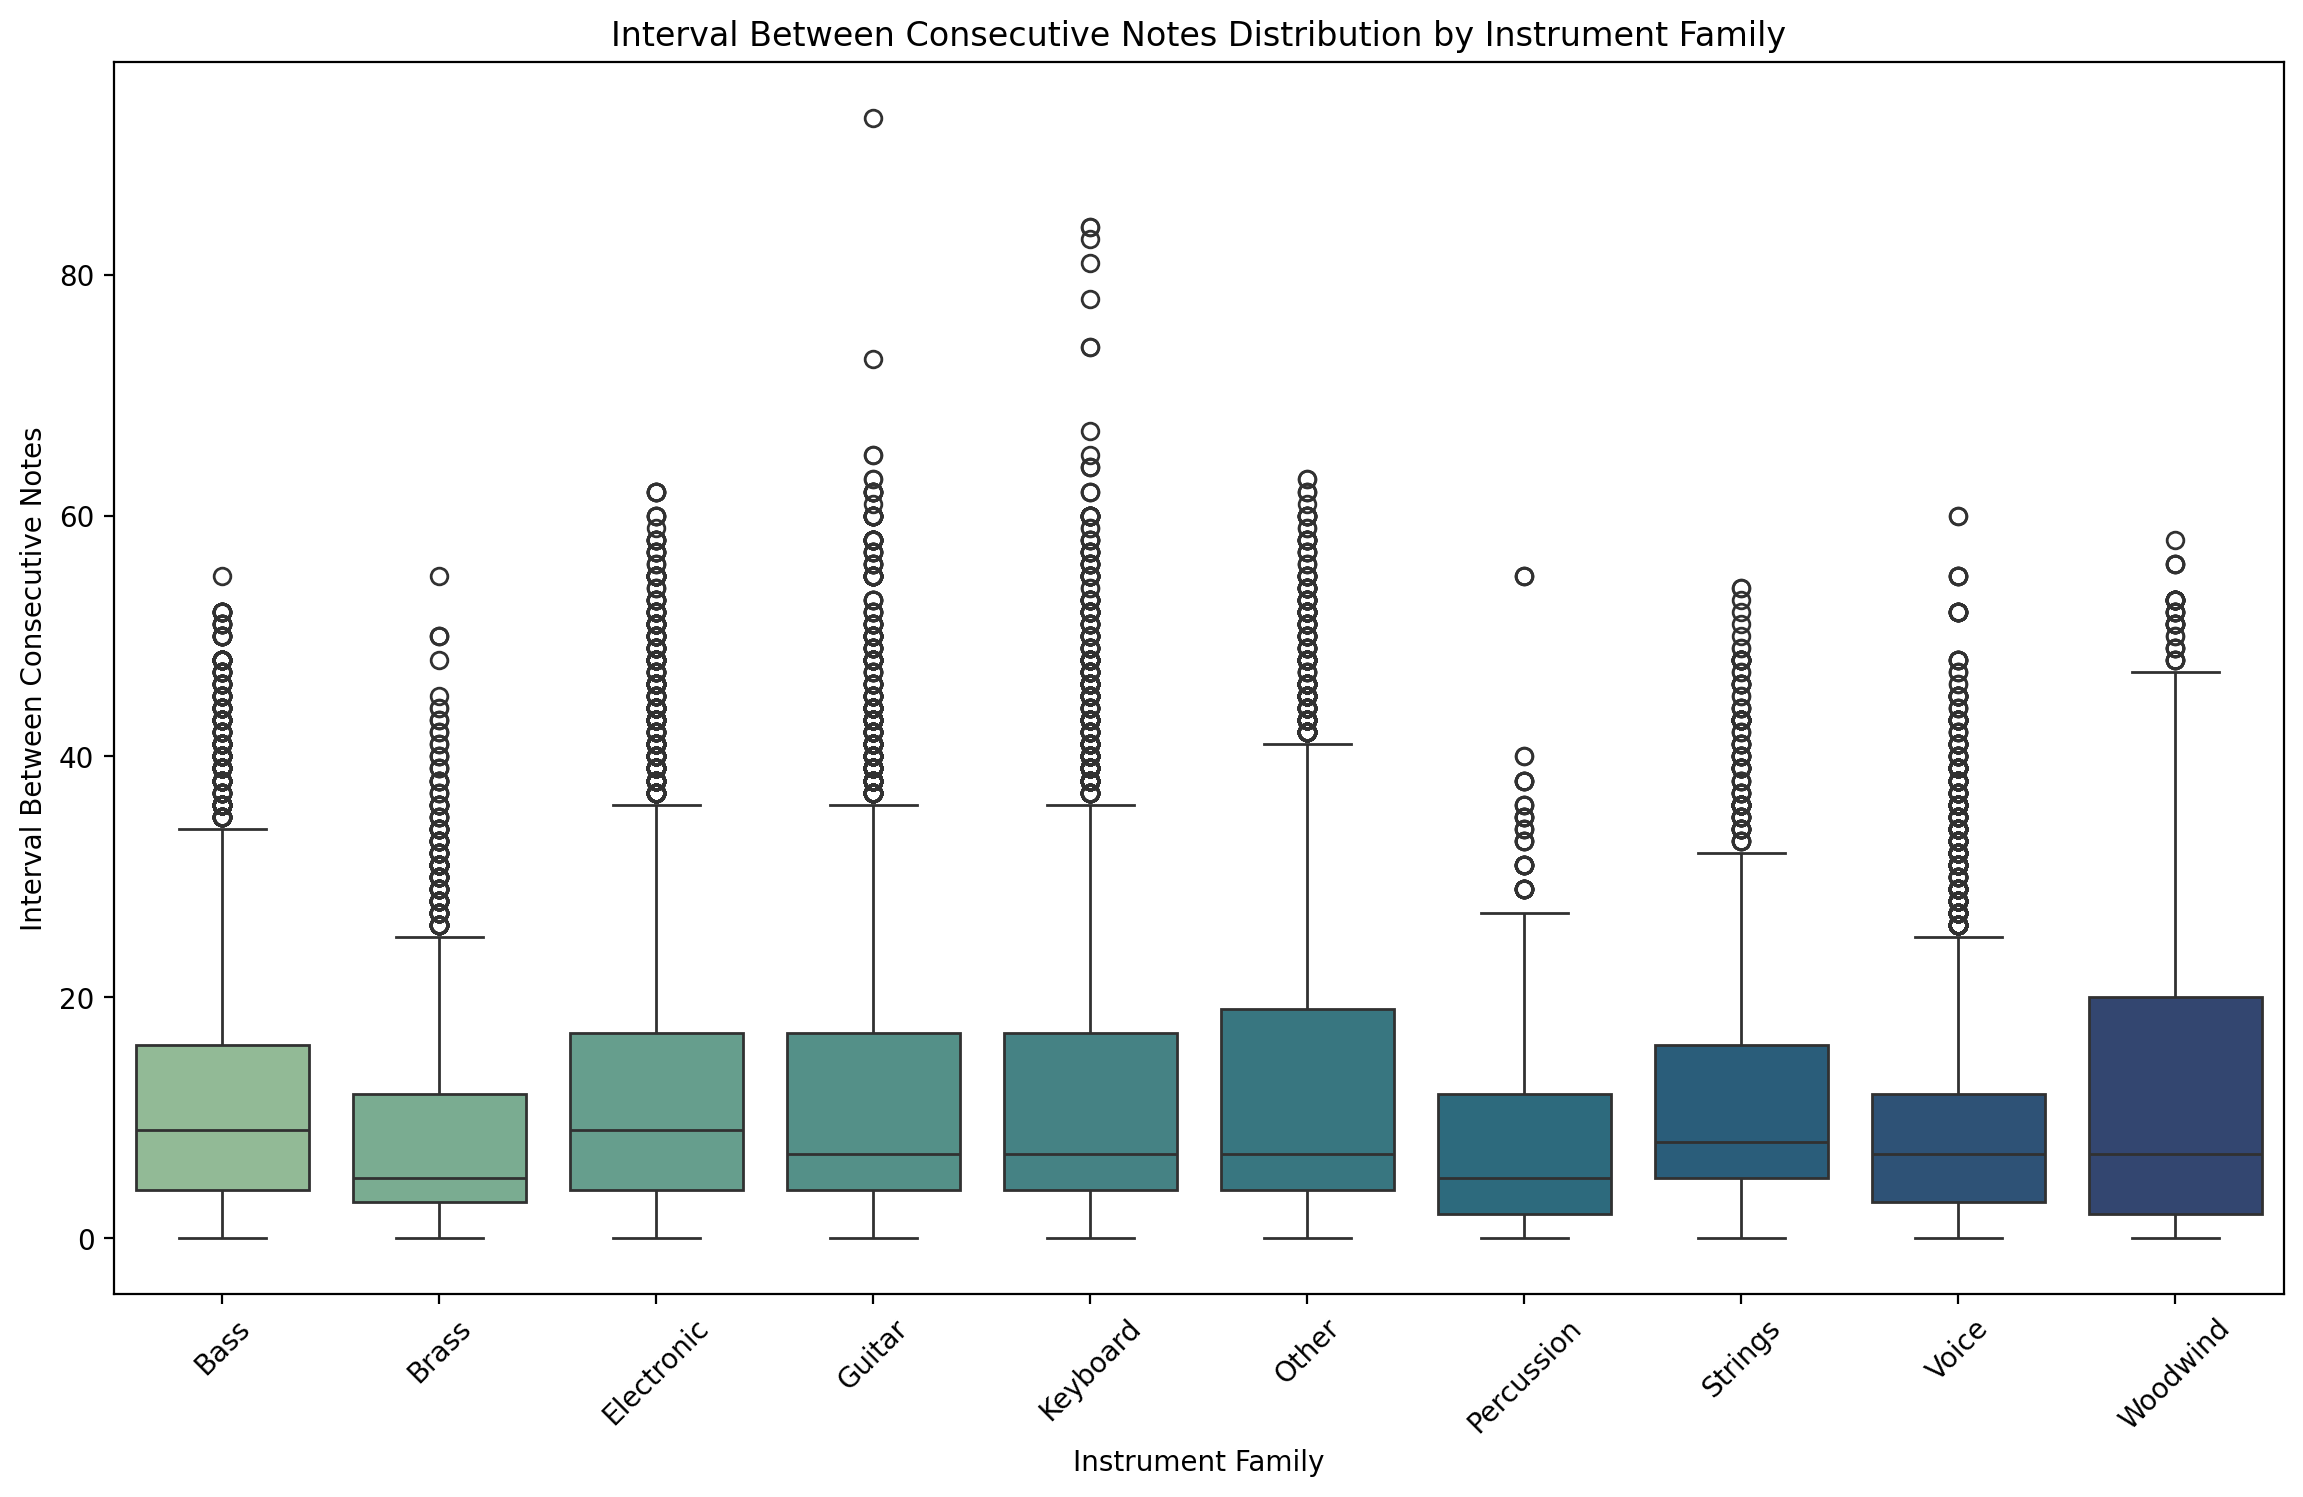

In [212]:
# Filter and plot interval between consecutive notes distribution by instrument family
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='instrument_family',
    y='interval_to_prev',
    palette='crest',
    order=families
)
plt.title('Interval Between Consecutive Notes Distribution by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Interval Between Consecutive Notes')
plt.xticks(rotation=45)
plt.show()

In [213]:
# Descriptive statistics of intervals between consecutive notes by genre
print("Interval Between Consecutive Notes statistics by Genre:")
df.groupby('genre')['interval_to_prev'].describe()

Interval Between Consecutive Notes statistics by Genre:


count       mean        std  min  25%   50%   75%   max
genre                                                                      
alternative_rock   7460.0  11.880295  10.145014  0.0  5.0  12.0  15.0  55.0
blues             22575.0  11.683721  10.265057  0.0  4.0   8.0  18.0  51.0
classical         15371.0  11.008067   9.560066  0.0  3.0   9.0  15.0  55.0
country           14654.0  12.767163  11.167650  0.0  5.0   9.0  19.0  60.0
dance              6910.0  10.340087   9.922487  0.0  3.0   7.0  16.0  52.0
disco              9845.0  13.020112  11.503511  0.0  4.0  10.0  19.0  83.0
heavy_metal        6189.0  16.540475  14.387512  0.0  5.0  12.0  29.0  60.0
jazz              13486.0  11.042637  10.362007  0.0  3.0   7.0  16.0  63.0
new_age           21791.0  10.976229  10.874303  0.0  4.0   7.0  15.0  93.0
pop               12478.0  11.020997  11.296951  0.0  3.0   7.0  14.0  67.0
rap               13449.0   9.720574  11.377297  0.0  3.0   5.0   9.0  58.0
reggae            14663.0  11.429926  10.418889  0.0  4.0   7.0  17.0  65.0
rnb               13780.0  11.681567  12.196854  0.0  3.0   5.0  19.0  84.0
rock               7344.0  11.031318   9.514890  0.0  5.0   7.0  16.0  52.0
soul              12197.0  13.592933  12.886860  0.0  5.0   7.0  22.0  60.0

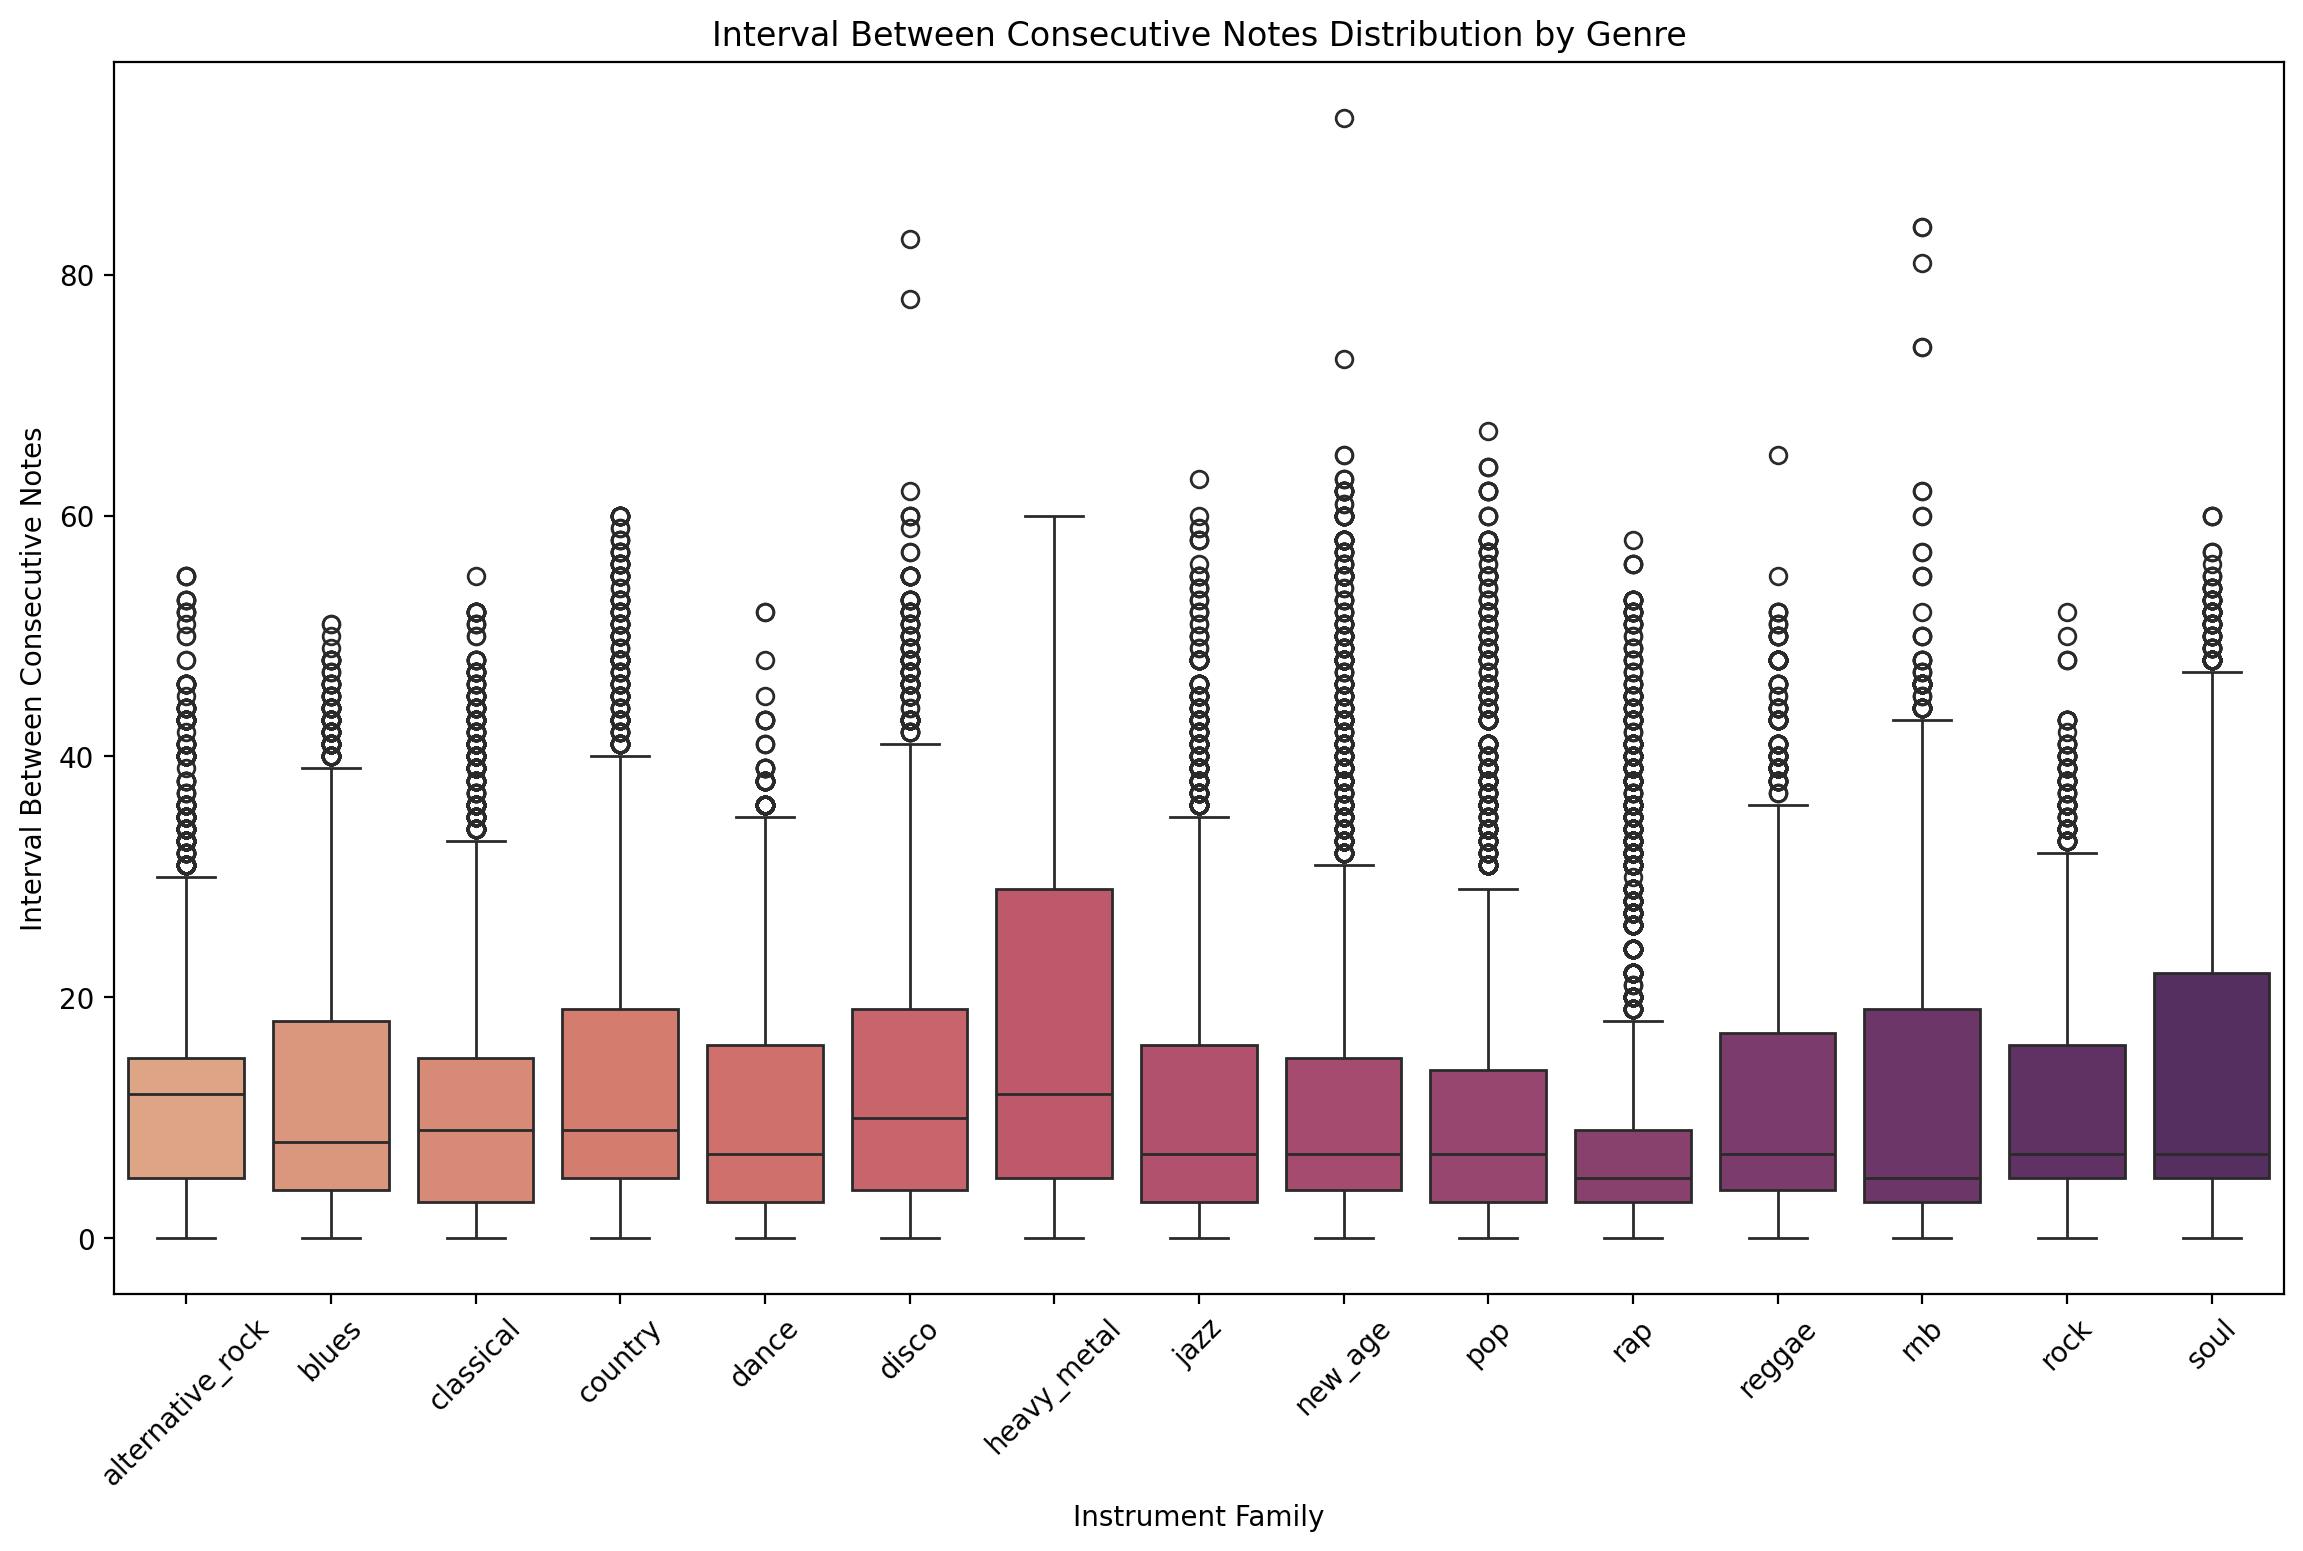

In [214]:
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='genre',
    y='interval_to_prev',
    palette='flare',
    order=genres_sorted
)
plt.title('Interval Between Consecutive Notes Distribution by Genre')
plt.xlabel('Instrument Family')
plt.ylabel('Interval Between Consecutive Notes')
plt.xticks(rotation=45)
plt.show()

##### 2.3.6.4 Metric Weight vs Interval Between Consecutive Notes

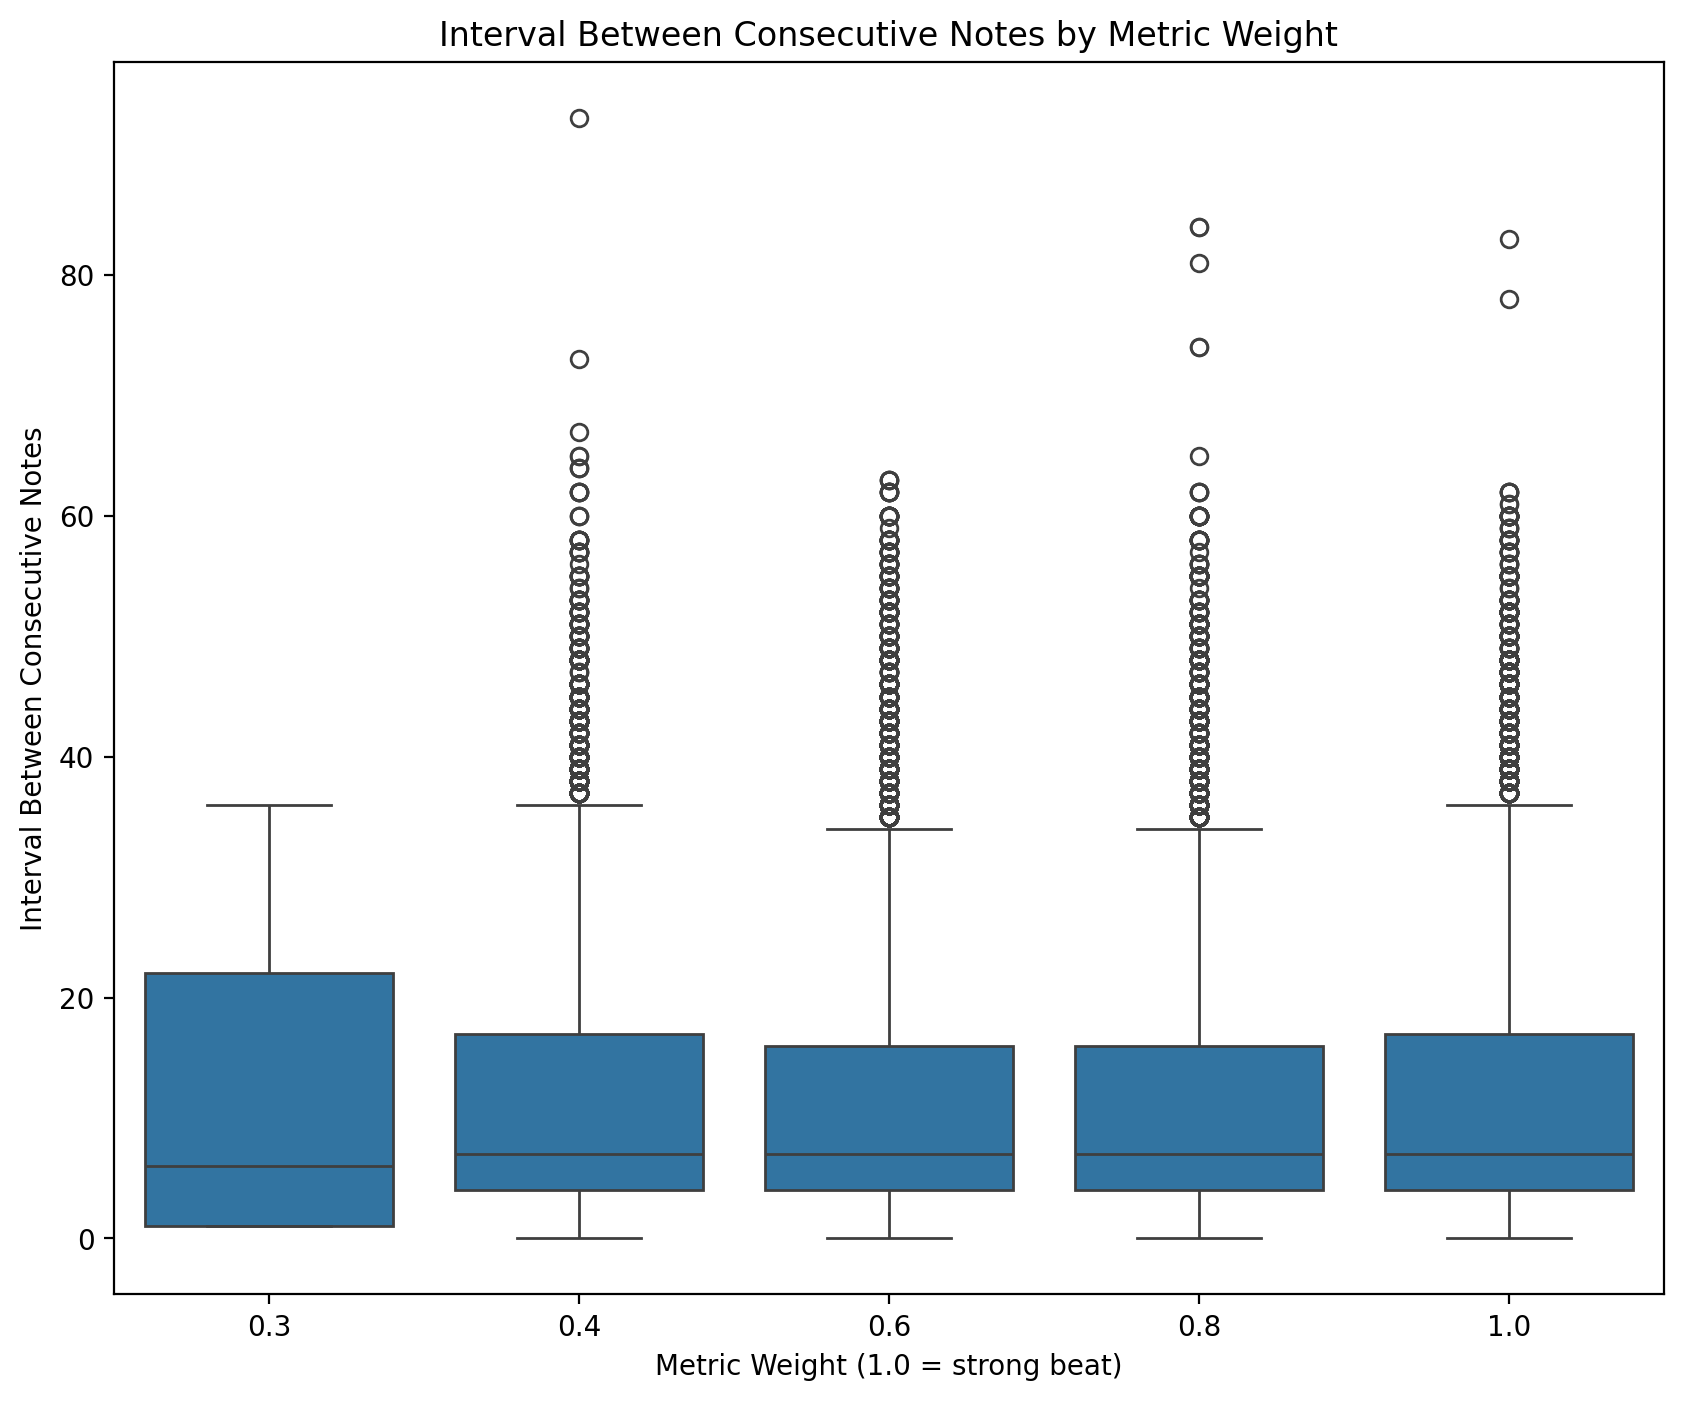

In [254]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Create a boxplot showing how note duration varies with metric weight
sns.boxplot(x="metric_weight", y="interval_to_prev", data=df)

# Add a descriptive title and axis labels
plt.title("Interval Between Consecutive Notes by Metric Weight")
plt.xlabel("Metric Weight (1.0 = strong beat)")
plt.ylabel("Interval Between Consecutive Notes")
plt.show()

##### 2.3.6.5 Average Interval Between Consecutive Notes by Polyphony and Metric Weight

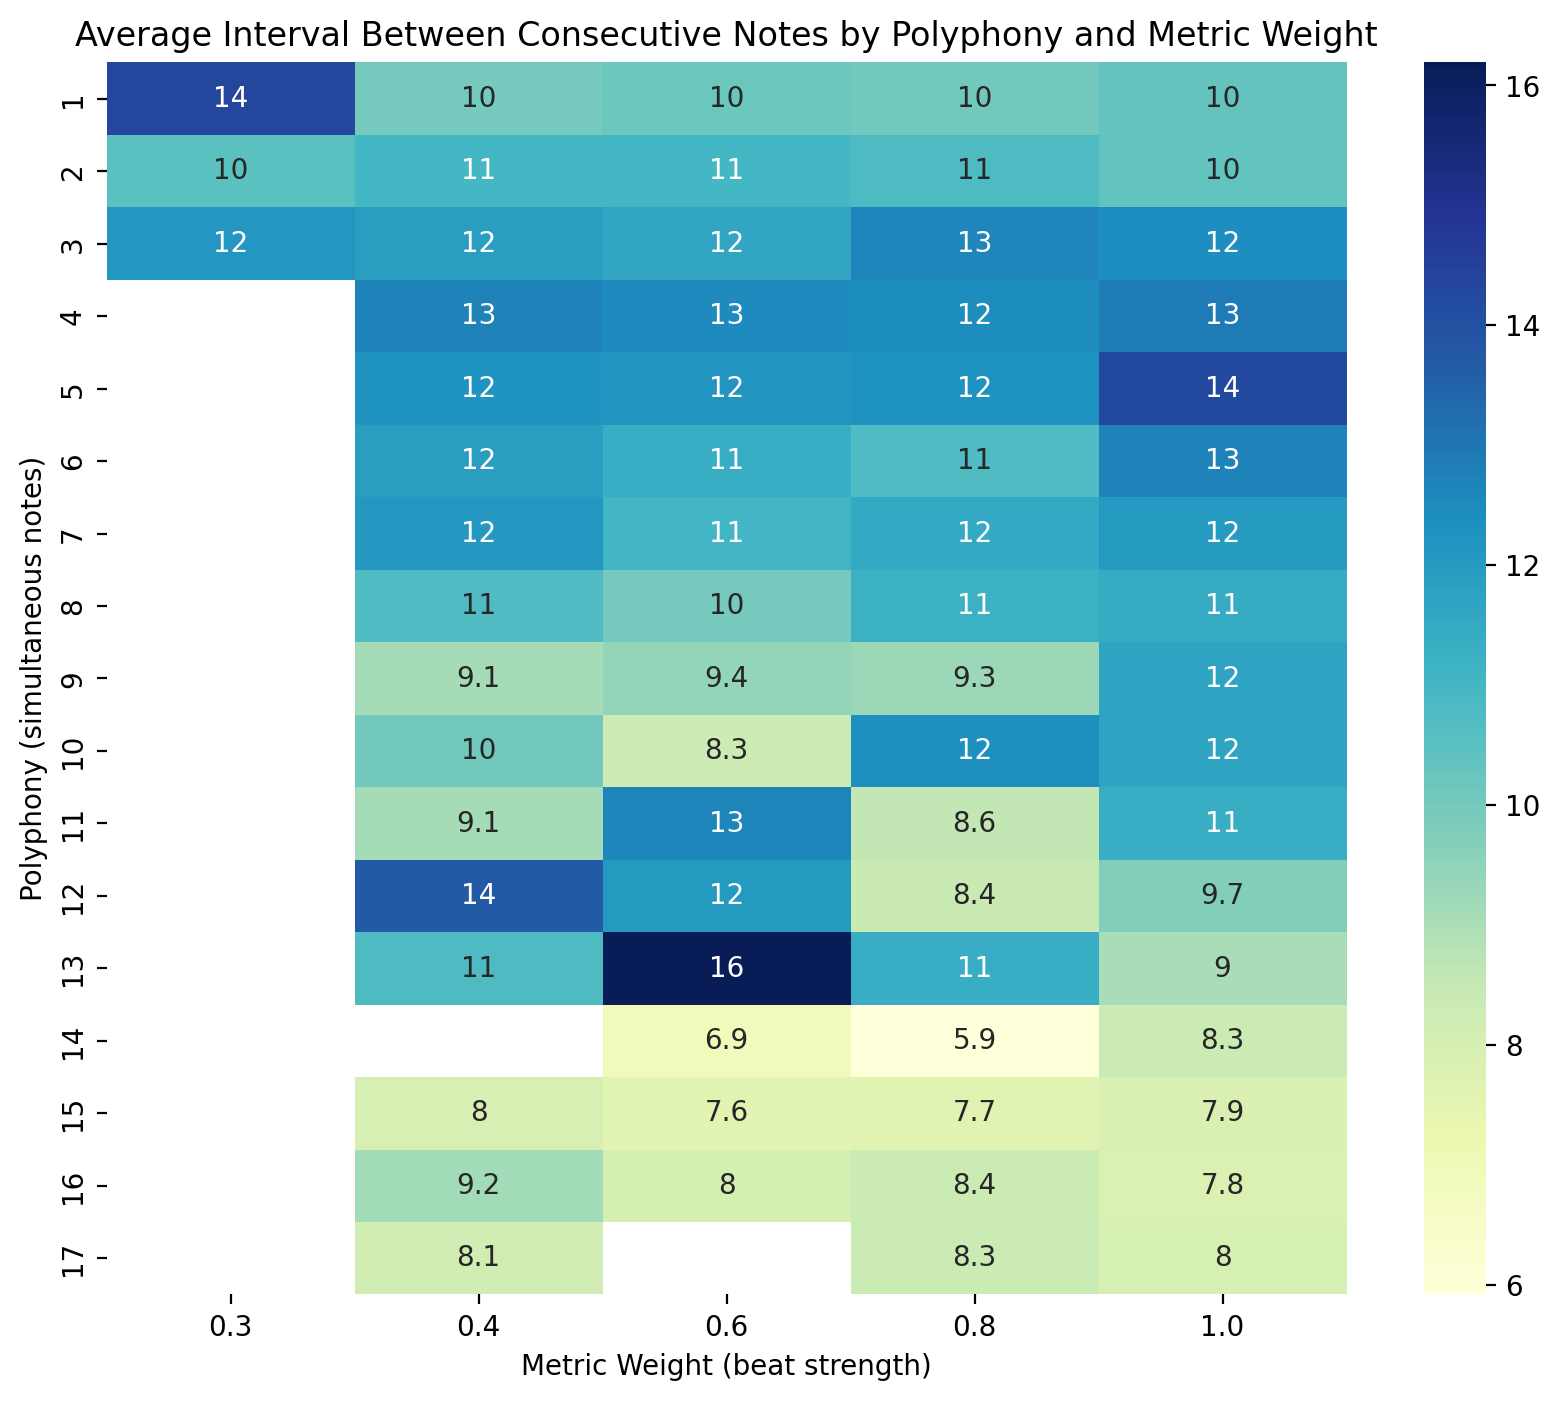

In [216]:
# Create a pivot table to analyze the average interval between consecutive notes
# Rows represent different levels of polyphony (number of simultaneous notes)
# Columns represent the metric weight (perceived strength of the beat)
pivot = df.pivot_table(values="interval_to_prev", index="polyphony", columns="metric_weight", aggfunc="mean")

# Plot a heatmap to visualize how average duration varies across polyphonic texture and metric position
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, ax=ax)

# Add a descriptive title and axis labels
plt.title("Average Interval Between Consecutive Notes by Polyphony and Metric Weight")
plt.xlabel("Metric Weight (beat strength)")
plt.ylabel("Polyphony (simultaneous notes)")
plt.show()

#### 2.3.7 Polyphony

##### 2.3.7.1 Central Tendency and Spread of Polyphony


In [224]:
# Apply a safe conversion to float
#df['duration'] = df['duration'].apply(lambda x: float(x) if isinstance(x, Fraction) else x)
#df['duration'] = df['duration'].astype(float)

# Central tendency
mean_polyphony = df['polyphony'].mean()
median_polyphony = df['polyphony'].median()
mode_polyphony = df['polyphony'].mode()[0]  

# Spread
std_polyphony = df['polyphony'].std()

# Display results
print(f"Mean polyphony: {mean_polyphony:.2f}")
print(f"Median polyphony: {median_polyphony:.2f}")
print(f"Mode polyphony: {mode_polyphony}")
print(f"Standard polyphony: {std_polyphony:.2f}")

Mean polyphony: 3.98
Median polyphony: 4.00
Mode polyphony: 3
Standard polyphony: 2.40


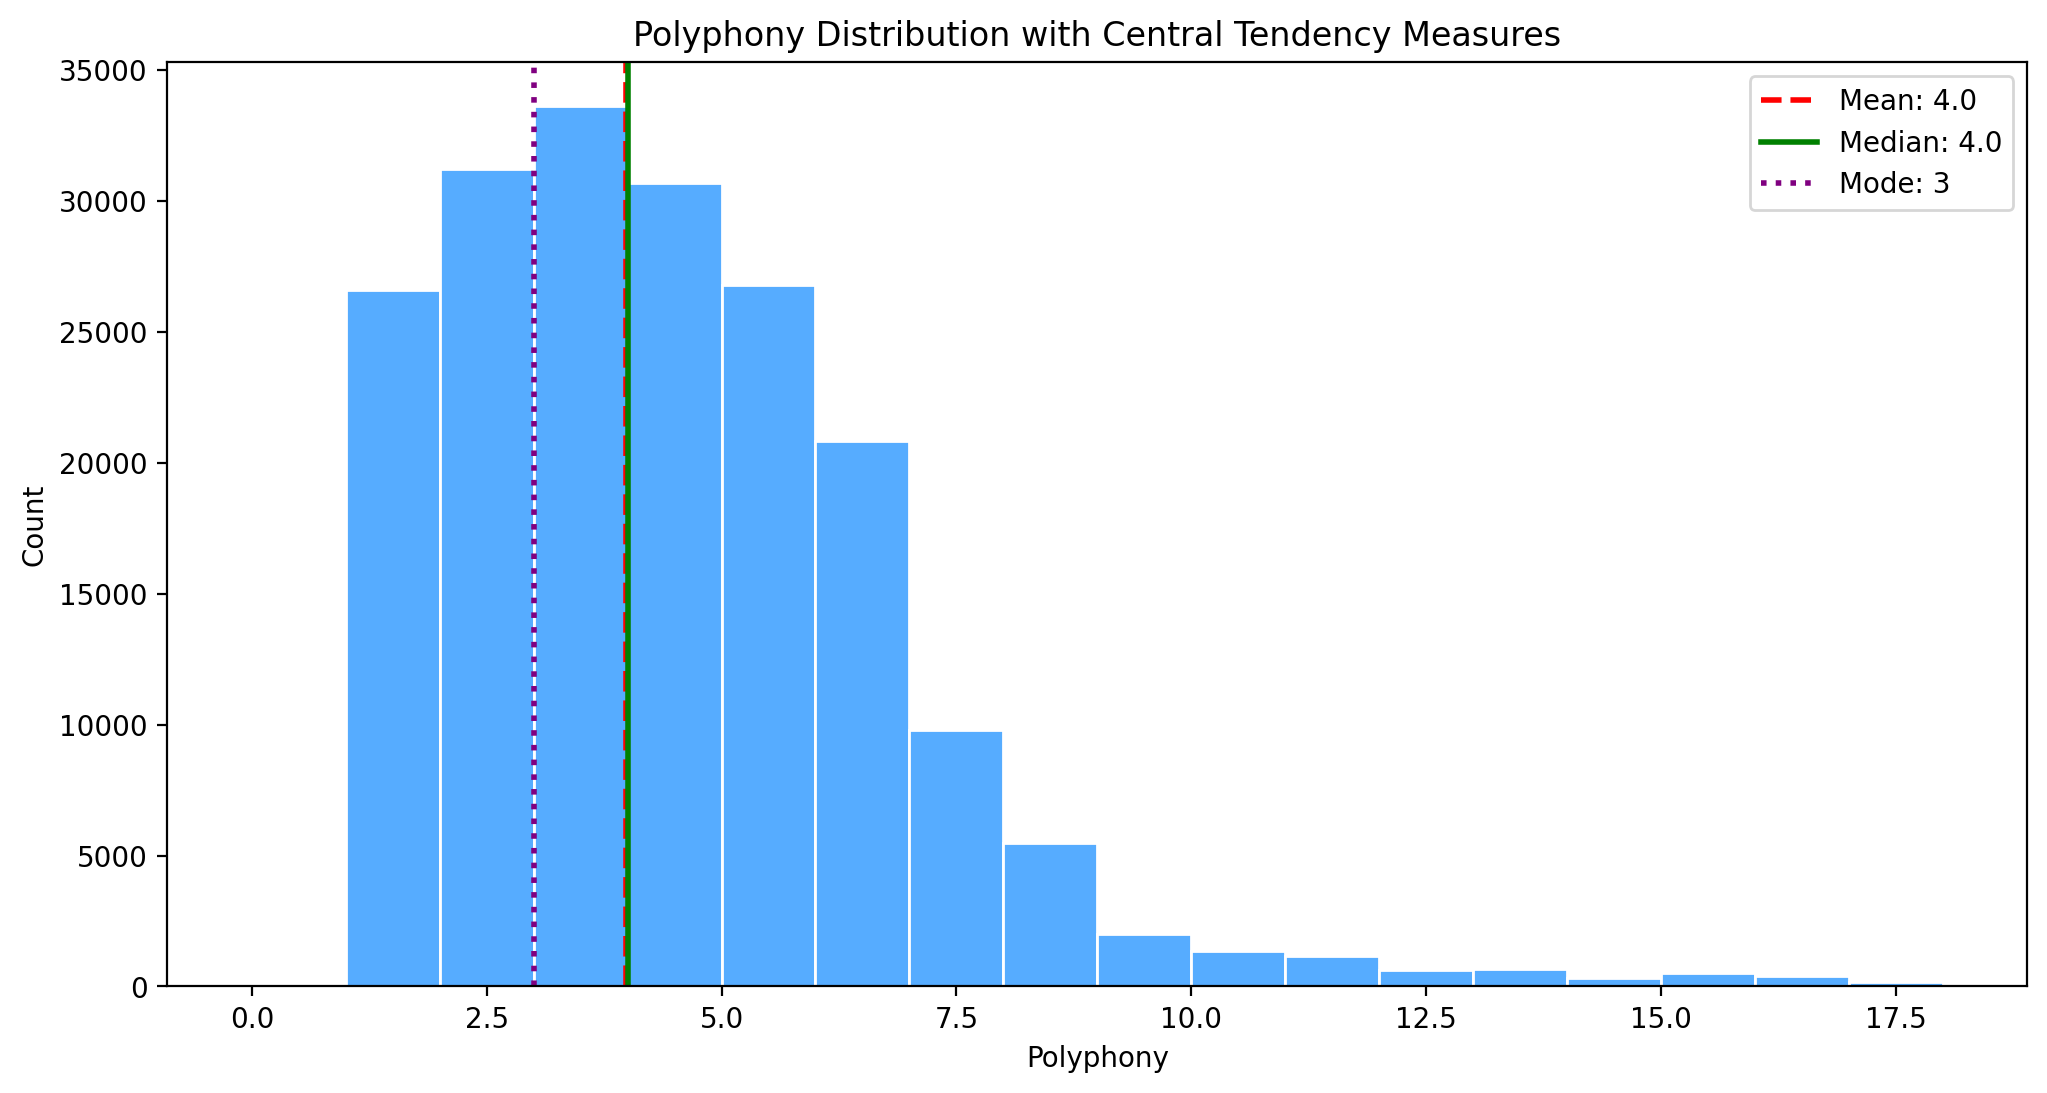

In [225]:
plt.figure(figsize=(12, 6))
sns.histplot(df['polyphony'], bins=range(0, 19), color='dodgerblue', edgecolor='white')

# Add lines for mean, median, and mode
plt.axvline(mean_polyphony, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_polyphony:.1f}')
plt.axvline(median_polyphony, color='green', linestyle='-', linewidth=2, label=f'Median: {median_polyphony}')
plt.axvline(mode_polyphony, color='purple', linestyle=':', linewidth=2, label=f'Mode: {mode_polyphony}')

plt.title('Polyphony Distribution with Central Tendency Measures')
plt.xlabel('Polyphony')
plt.ylabel('Count')
plt.legend()
plt.show()

##### 2.3.7.2 Outlier Detection in Polyphony Values

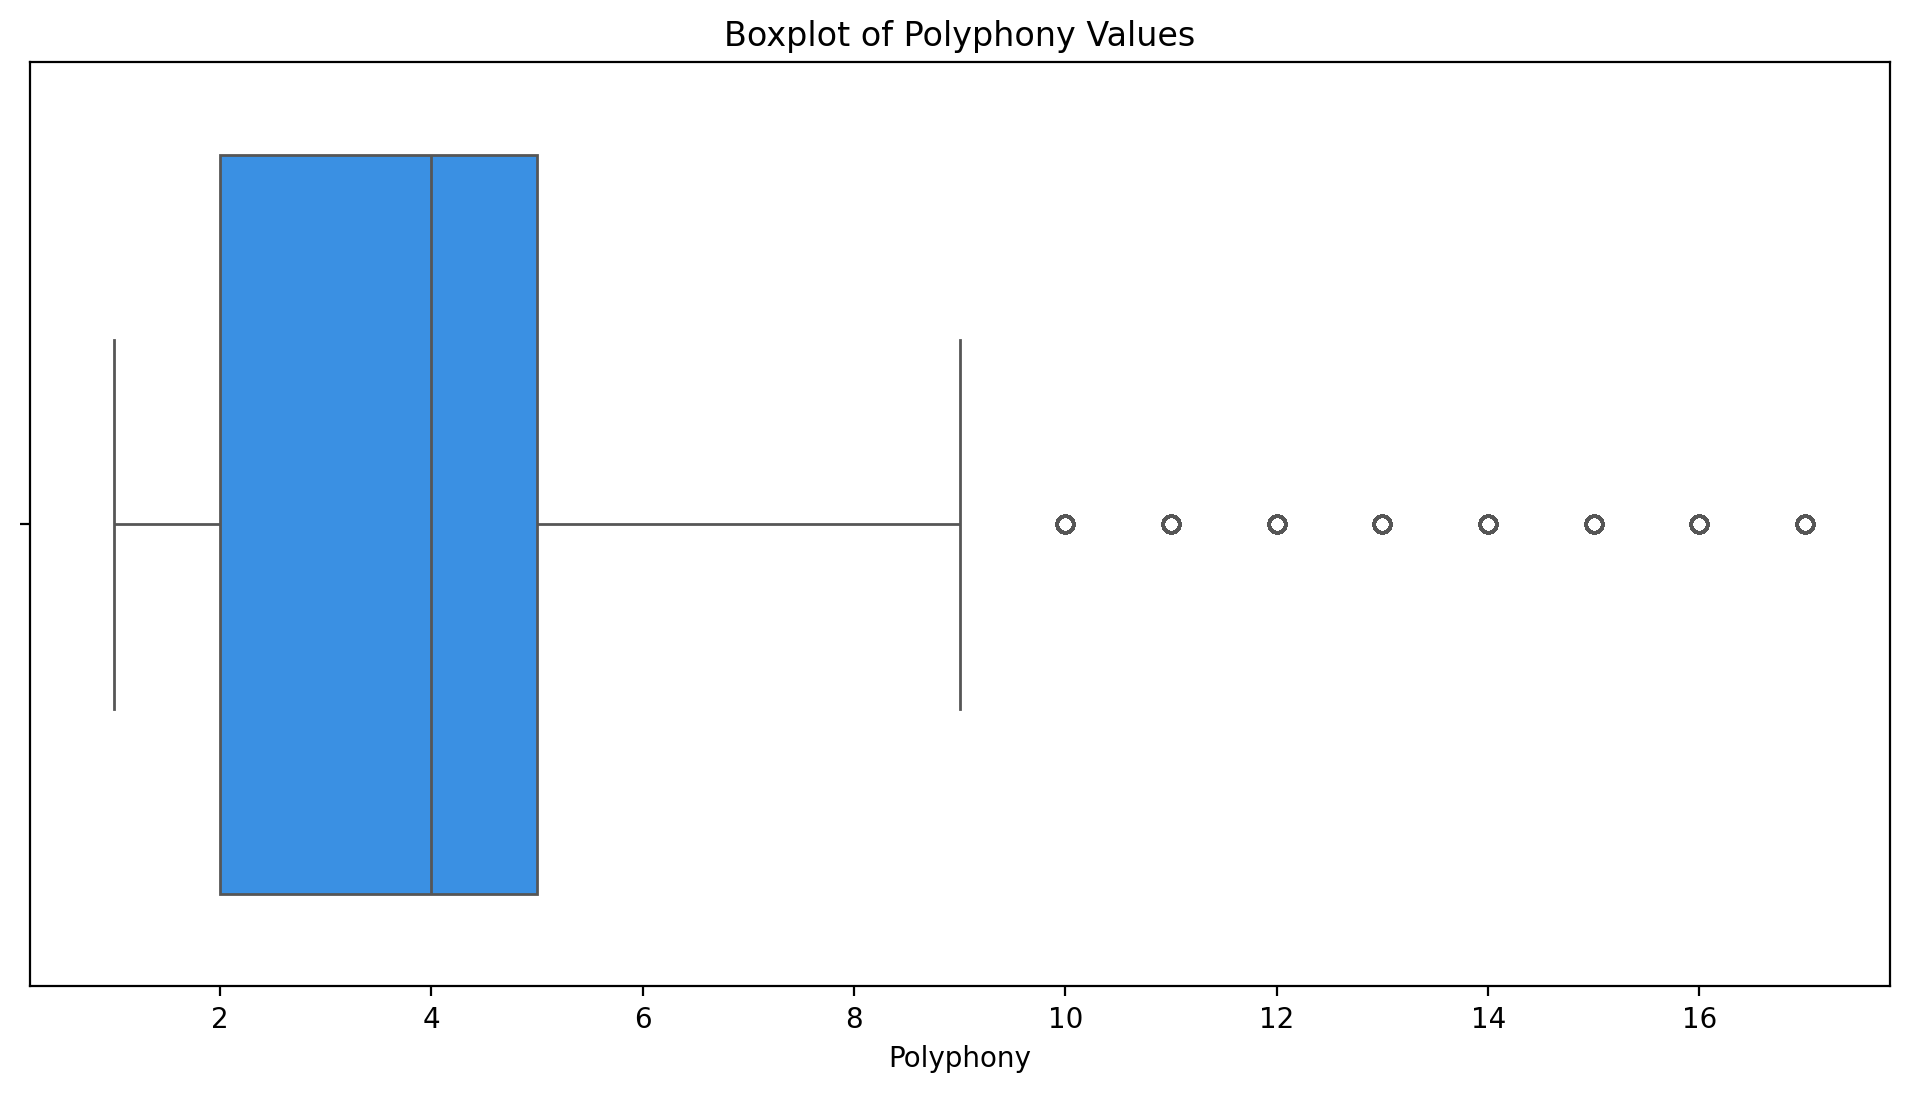

In [226]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['polyphony'], color='dodgerblue')
plt.title('Boxplot of Polyphony Values')
plt.xlabel('Polyphony')
plt.show()

##### 2.3.7.3 Polyphony in Context: Key, Instrument, and Genre

In [227]:
# Descriptive statistics of polyphony values by key
print("Polyphony statistics by Key:")
df.groupby('key')['polyphony'].describe().sort_index()

Polyphony statistics by Key:


count      mean       std  min  25%  50%  75%   max
key                                                       
0    11608.0  3.446072  1.846674  1.0  2.0  4.0  5.0   8.0
1     8535.0  4.012302  1.412792  1.0  3.0  4.0  5.0   8.0
2     5075.0  3.240985  1.782756  1.0  2.0  3.0  4.0   9.0
3    13501.0  5.129398  2.750878  1.0  3.0  5.0  7.0  14.0
4     8834.0  3.428232  1.548455  1.0  2.0  3.0  5.0   7.0
5    17733.0  4.324311  1.996301  1.0  3.0  4.0  6.0  15.0
6     4806.0  3.197670  1.513190  1.0  2.0  3.0  4.0   9.0
7    10897.0  1.808479  1.506085  1.0  1.0  1.0  2.0   8.0
9     3344.0  4.919856  1.715175  1.0  4.0  5.0  6.0  10.0
11   24410.0  4.165014  2.175410  1.0  2.0  4.0  6.0  13.0
12    7224.0  1.992110  0.866129  1.0  1.0  2.0  2.0   6.0
13    9294.0  3.236712  2.365532  1.0  1.0  2.0  5.0  11.0
14    7794.0  3.538876  1.399654  1.0  2.0  3.0  5.0   9.0
15    1626.0  2.131611  0.681101  1.0  2.0  2.0  3.0   4.0
16   19702.0  4.244290  1.802818  1.0  3.0  4.0  5.0  10.0
17    7936.0  5.590726  3.201738  1.0  3.0  5.0  7.0  15.0
19   16036.0  5.268646  3.869082  1.0  2.0  4.0  7.0  17.0
21    8261.0  3.982569  1.845402  1.0  3.0  4.0  5.0   9.0
23    5576.0  4.404770  1.823781  1.0  3.0  4.0  5.0  11.0

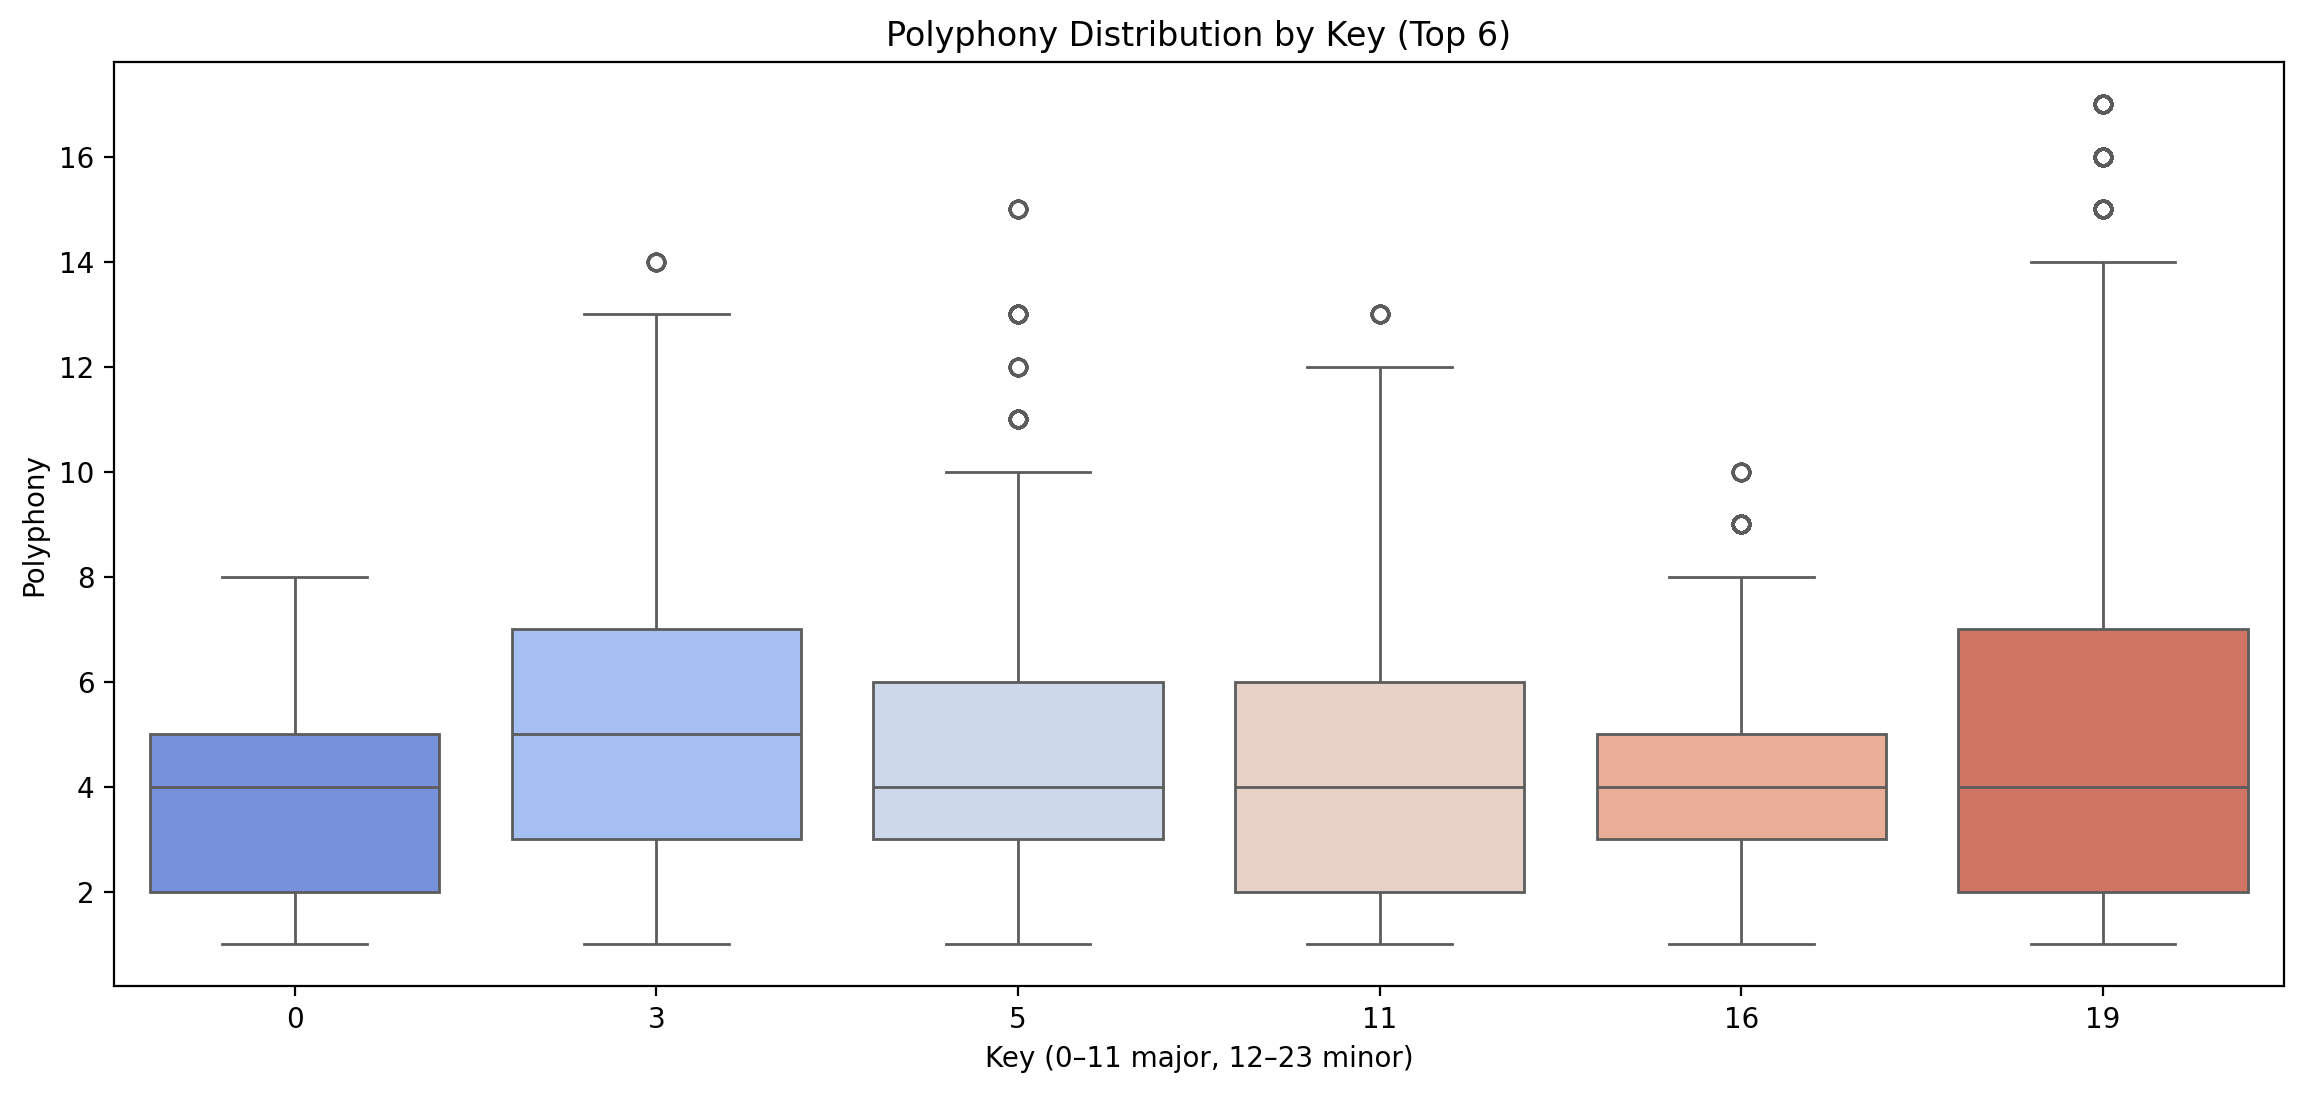

In [228]:
# Polyphony distribution across top 6 keys to show tonal variation.
plt.figure(figsize=(14,6))
sns.boxplot(data=df[df['key'].isin(top_keys)], x='key', y='polyphony', palette='coolwarm')
plt.title('Polyphony Distribution by Key (Top 6)')
plt.xlabel('Key (0–11 major, 12–23 minor)')
plt.ylabel('Polyphony')
plt.show()

In [229]:
# Descriptive statistics of polyphony values by instrument
print("Polyphony statistics by Instrument:")
df.groupby('instrument')['polyphony'].describe()

Polyphony statistics by Instrument:


count      mean       std  min  25%  50%    75%   max
instrument                                                               
Acoustic Bass     11262.0  4.219410  2.613702  1.0  2.0  4.0   6.00  13.0
Acoustic Guitar   18001.0  3.954003  1.808927  1.0  3.0  4.0   6.00  10.0
Bagpipes           4865.0  4.686331  1.261081  1.0  4.0  5.0   6.00   8.0
Bassoon            1729.0  4.574320  1.857589  1.0  3.0  5.0   6.00   8.0
Celesta            8514.0  3.930585  1.514873  1.0  3.0  4.0   5.00  10.0
Choir              2984.0  3.450067  1.862933  1.0  2.0  4.0   5.00   8.0
Clarinet            998.0  3.146293  1.568446  1.0  2.0  3.0   4.00   7.0
Contrabass         9168.0  1.286867  0.575066  1.0  1.0  1.0   1.00   4.0
Electric Bass       647.0  4.040185  1.614061  1.0  3.0  4.0   5.00   9.0
Electric Guitar   21454.0  3.786007  1.687387  1.0  3.0  4.0   5.00  10.0
Electric Organ     2280.0  4.320614  1.514683  1.0  3.0  4.0   5.25  10.0
Fretless Bass      4777.0  2.699184  0.982758  1.0  2.0  2.0   3.00   6.0
Glockenspiel        133.0  3.706767  1.496369  1.0  3.0  4.0   5.00   6.0
Marimba             235.0  3.374468  0.931516  2.0  3.0  3.0   4.00   6.0
Ocarina             575.0  2.810435  0.931764  1.0  2.0  3.0   3.00   5.0
Piano             38177.0  4.045813  1.931635  1.0  2.0  4.0   5.00  10.0
Piccolo            1462.0  3.870041  1.759166  1.0  3.0  4.0   6.00   7.0
Recorder           1097.0  4.556062  1.168630  2.0  4.0  5.0   5.00   7.0
Sampler           23546.0  4.893740  3.044835  1.0  3.0  4.0   7.00  15.0
StringInstrument   4078.0  3.893821  1.862651  1.0  3.0  4.0   5.00  10.0
Taiko                61.0  3.655738  0.892286  1.0  3.0  3.0   4.00   5.0
Timpani            1450.0  5.214483  1.317268  1.0  5.0  5.0   6.00   7.0
Trombone           4529.0  8.867300  4.934448  1.0  5.0  8.0  13.00  17.0
Trumpet             105.0  5.314286  1.332394  2.0  5.0  5.0   6.00   8.0
Unknown           14549.0  2.665819  1.700677  1.0  1.0  2.0   4.00  10.0
Violoncello         360.0  2.655556  0.718418  1.0  2.0  3.0   3.00   4.0
Voice             11500.0  3.738087  2.116100  1.0  2.0  4.0   5.00  15.0
Whistle            3656.0  5.615700  2.080004  1.0  5.0  6.0   7.00  12.0

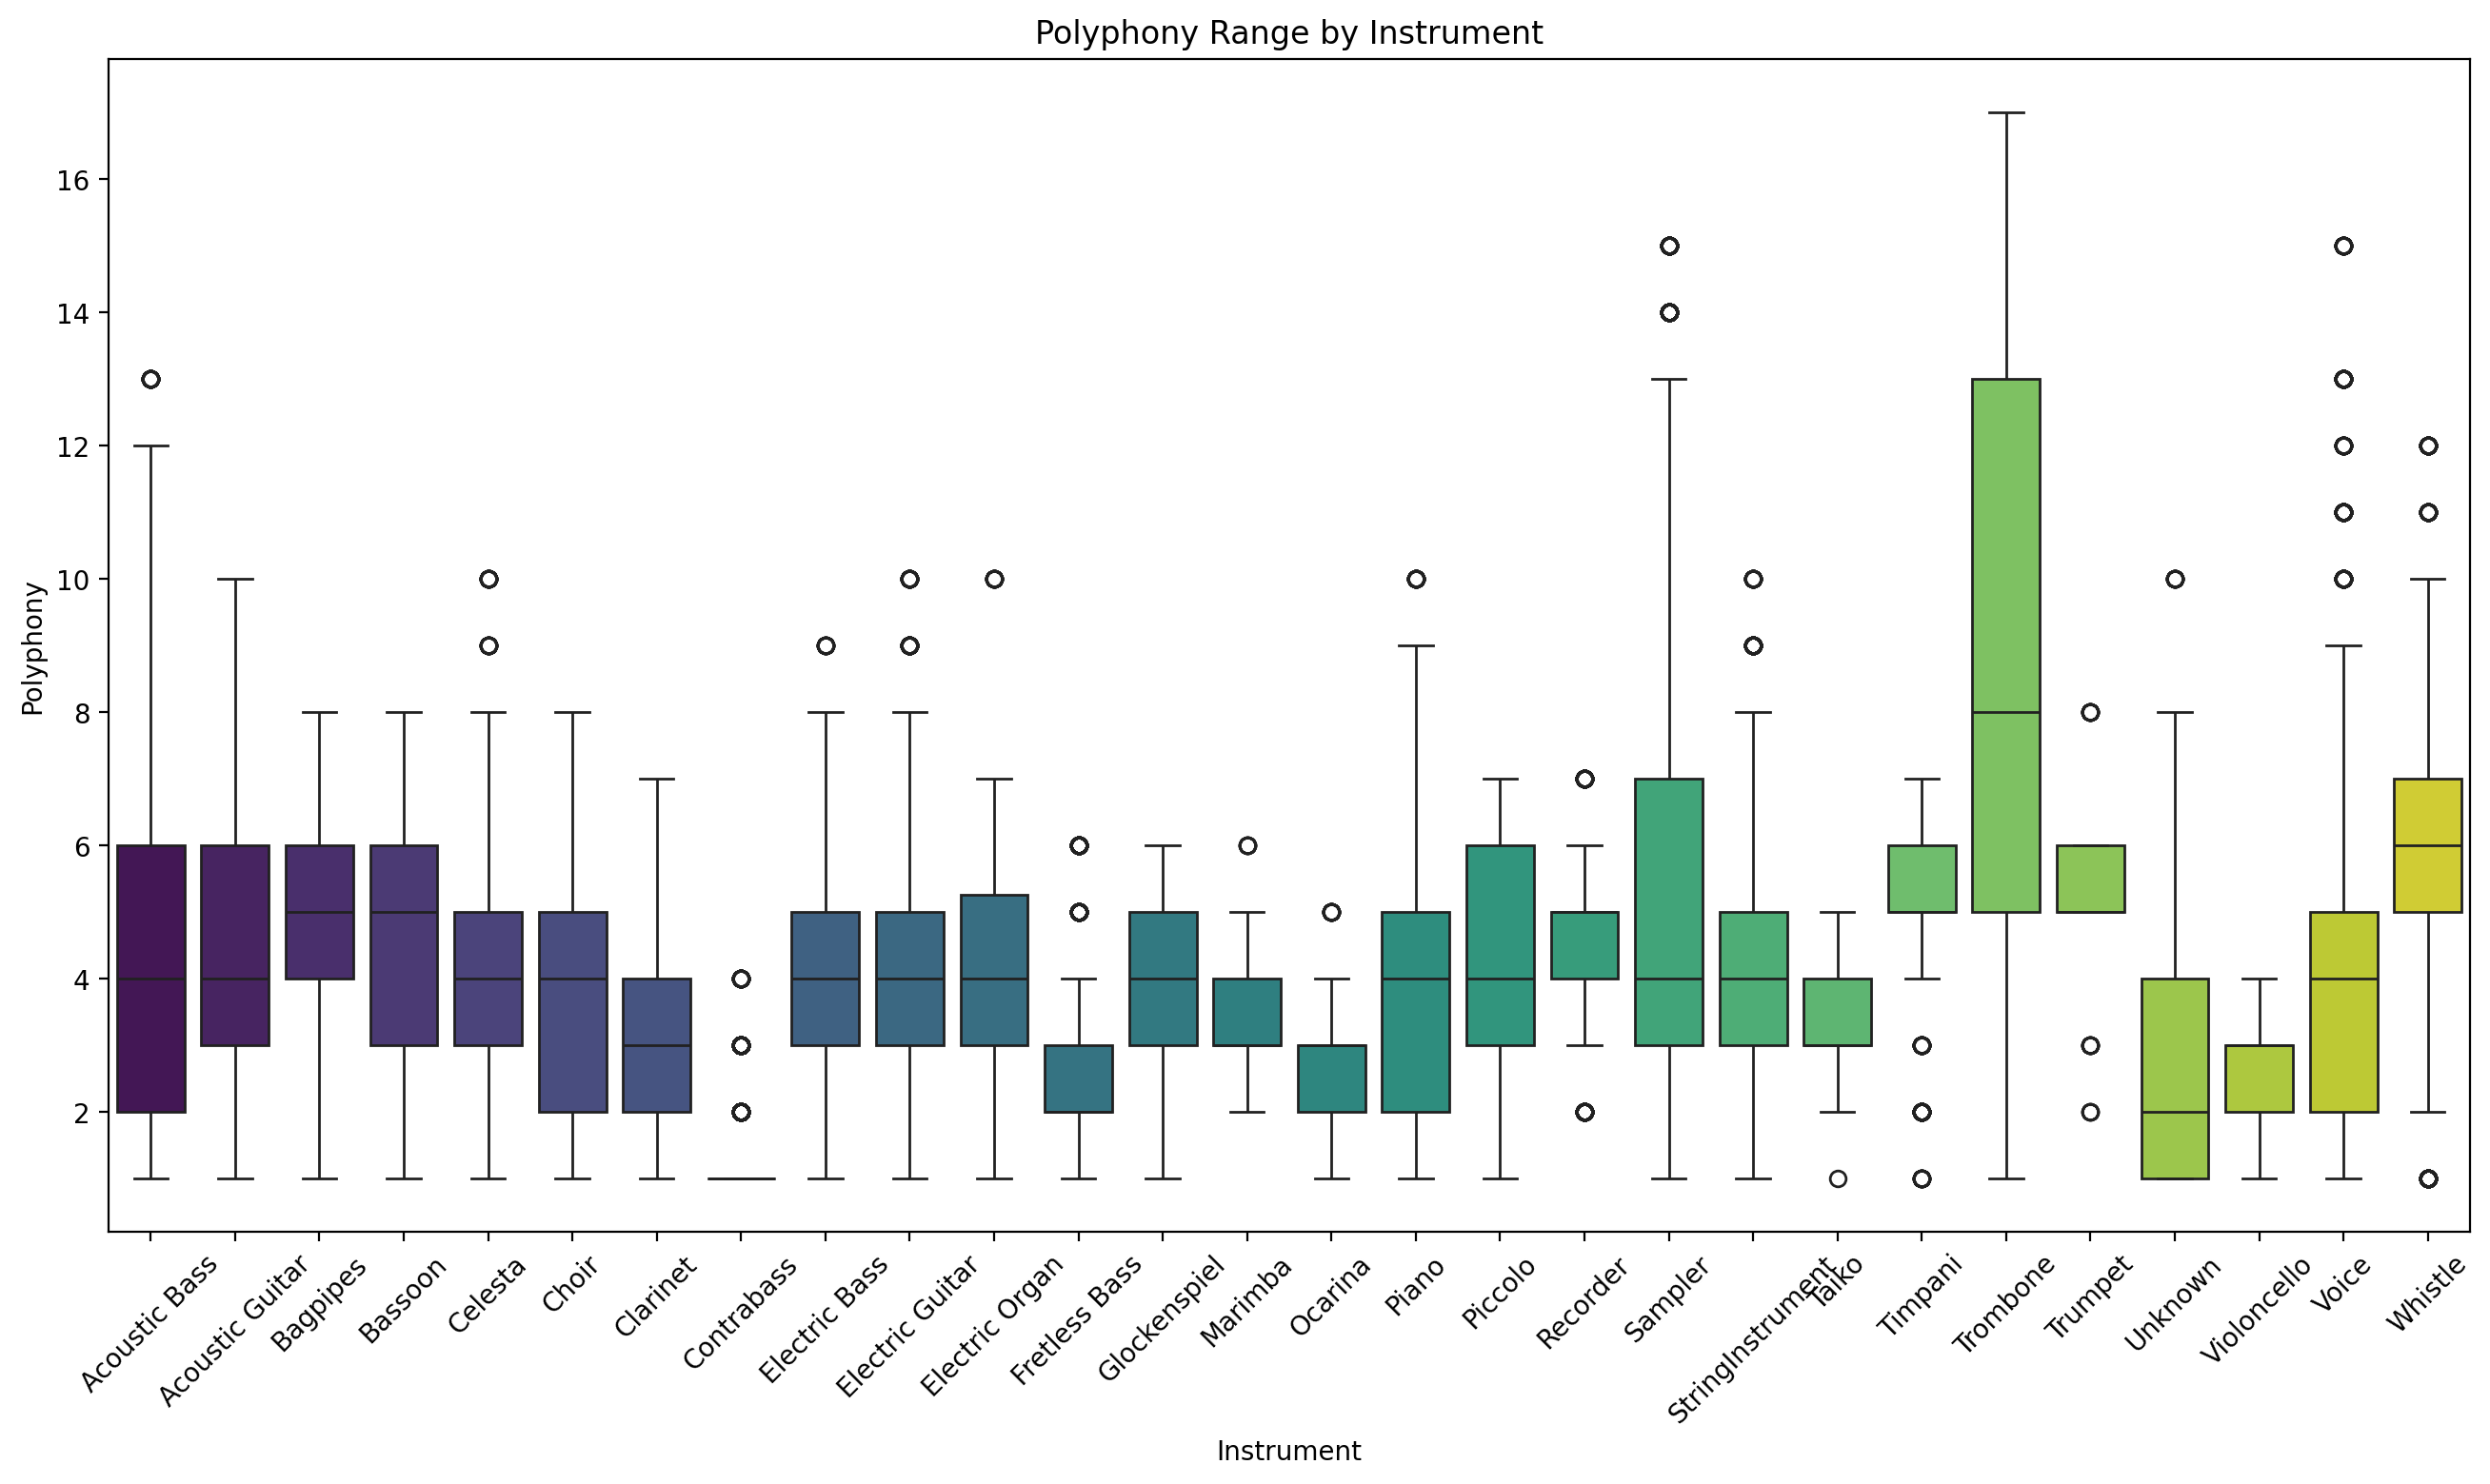

In [230]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='instrument', y='polyphony', palette='viridis', order=alphabetic_order)
plt.xticks(rotation=45)
plt.title('Polyphony Range by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Polyphony')
plt.show()

In [231]:
# Descriptive statistics of polyphony by instrument family
print("Polyphony statistics by Instrument Family:")
df.groupby('instrument')['polyphony'].describe()

Polyphony statistics by Instrument Family:


count      mean       std  min  25%  50%    75%   max
instrument                                                               
Acoustic Bass     11262.0  4.219410  2.613702  1.0  2.0  4.0   6.00  13.0
Acoustic Guitar   18001.0  3.954003  1.808927  1.0  3.0  4.0   6.00  10.0
Bagpipes           4865.0  4.686331  1.261081  1.0  4.0  5.0   6.00   8.0
Bassoon            1729.0  4.574320  1.857589  1.0  3.0  5.0   6.00   8.0
Celesta            8514.0  3.930585  1.514873  1.0  3.0  4.0   5.00  10.0
Choir              2984.0  3.450067  1.862933  1.0  2.0  4.0   5.00   8.0
Clarinet            998.0  3.146293  1.568446  1.0  2.0  3.0   4.00   7.0
Contrabass         9168.0  1.286867  0.575066  1.0  1.0  1.0   1.00   4.0
Electric Bass       647.0  4.040185  1.614061  1.0  3.0  4.0   5.00   9.0
Electric Guitar   21454.0  3.786007  1.687387  1.0  3.0  4.0   5.00  10.0
Electric Organ     2280.0  4.320614  1.514683  1.0  3.0  4.0   5.25  10.0
Fretless Bass      4777.0  2.699184  0.982758  1.0  2.0  2.0   3.00   6.0
Glockenspiel        133.0  3.706767  1.496369  1.0  3.0  4.0   5.00   6.0
Marimba             235.0  3.374468  0.931516  2.0  3.0  3.0   4.00   6.0
Ocarina             575.0  2.810435  0.931764  1.0  2.0  3.0   3.00   5.0
Piano             38177.0  4.045813  1.931635  1.0  2.0  4.0   5.00  10.0
Piccolo            1462.0  3.870041  1.759166  1.0  3.0  4.0   6.00   7.0
Recorder           1097.0  4.556062  1.168630  2.0  4.0  5.0   5.00   7.0
Sampler           23546.0  4.893740  3.044835  1.0  3.0  4.0   7.00  15.0
StringInstrument   4078.0  3.893821  1.862651  1.0  3.0  4.0   5.00  10.0
Taiko                61.0  3.655738  0.892286  1.0  3.0  3.0   4.00   5.0
Timpani            1450.0  5.214483  1.317268  1.0  5.0  5.0   6.00   7.0
Trombone           4529.0  8.867300  4.934448  1.0  5.0  8.0  13.00  17.0
Trumpet             105.0  5.314286  1.332394  2.0  5.0  5.0   6.00   8.0
Unknown           14549.0  2.665819  1.700677  1.0  1.0  2.0   4.00  10.0
Violoncello         360.0  2.655556  0.718418  1.0  2.0  3.0   3.00   4.0
Voice             11500.0  3.738087  2.116100  1.0  2.0  4.0   5.00  15.0
Whistle            3656.0  5.615700  2.080004  1.0  5.0  6.0   7.00  12.0

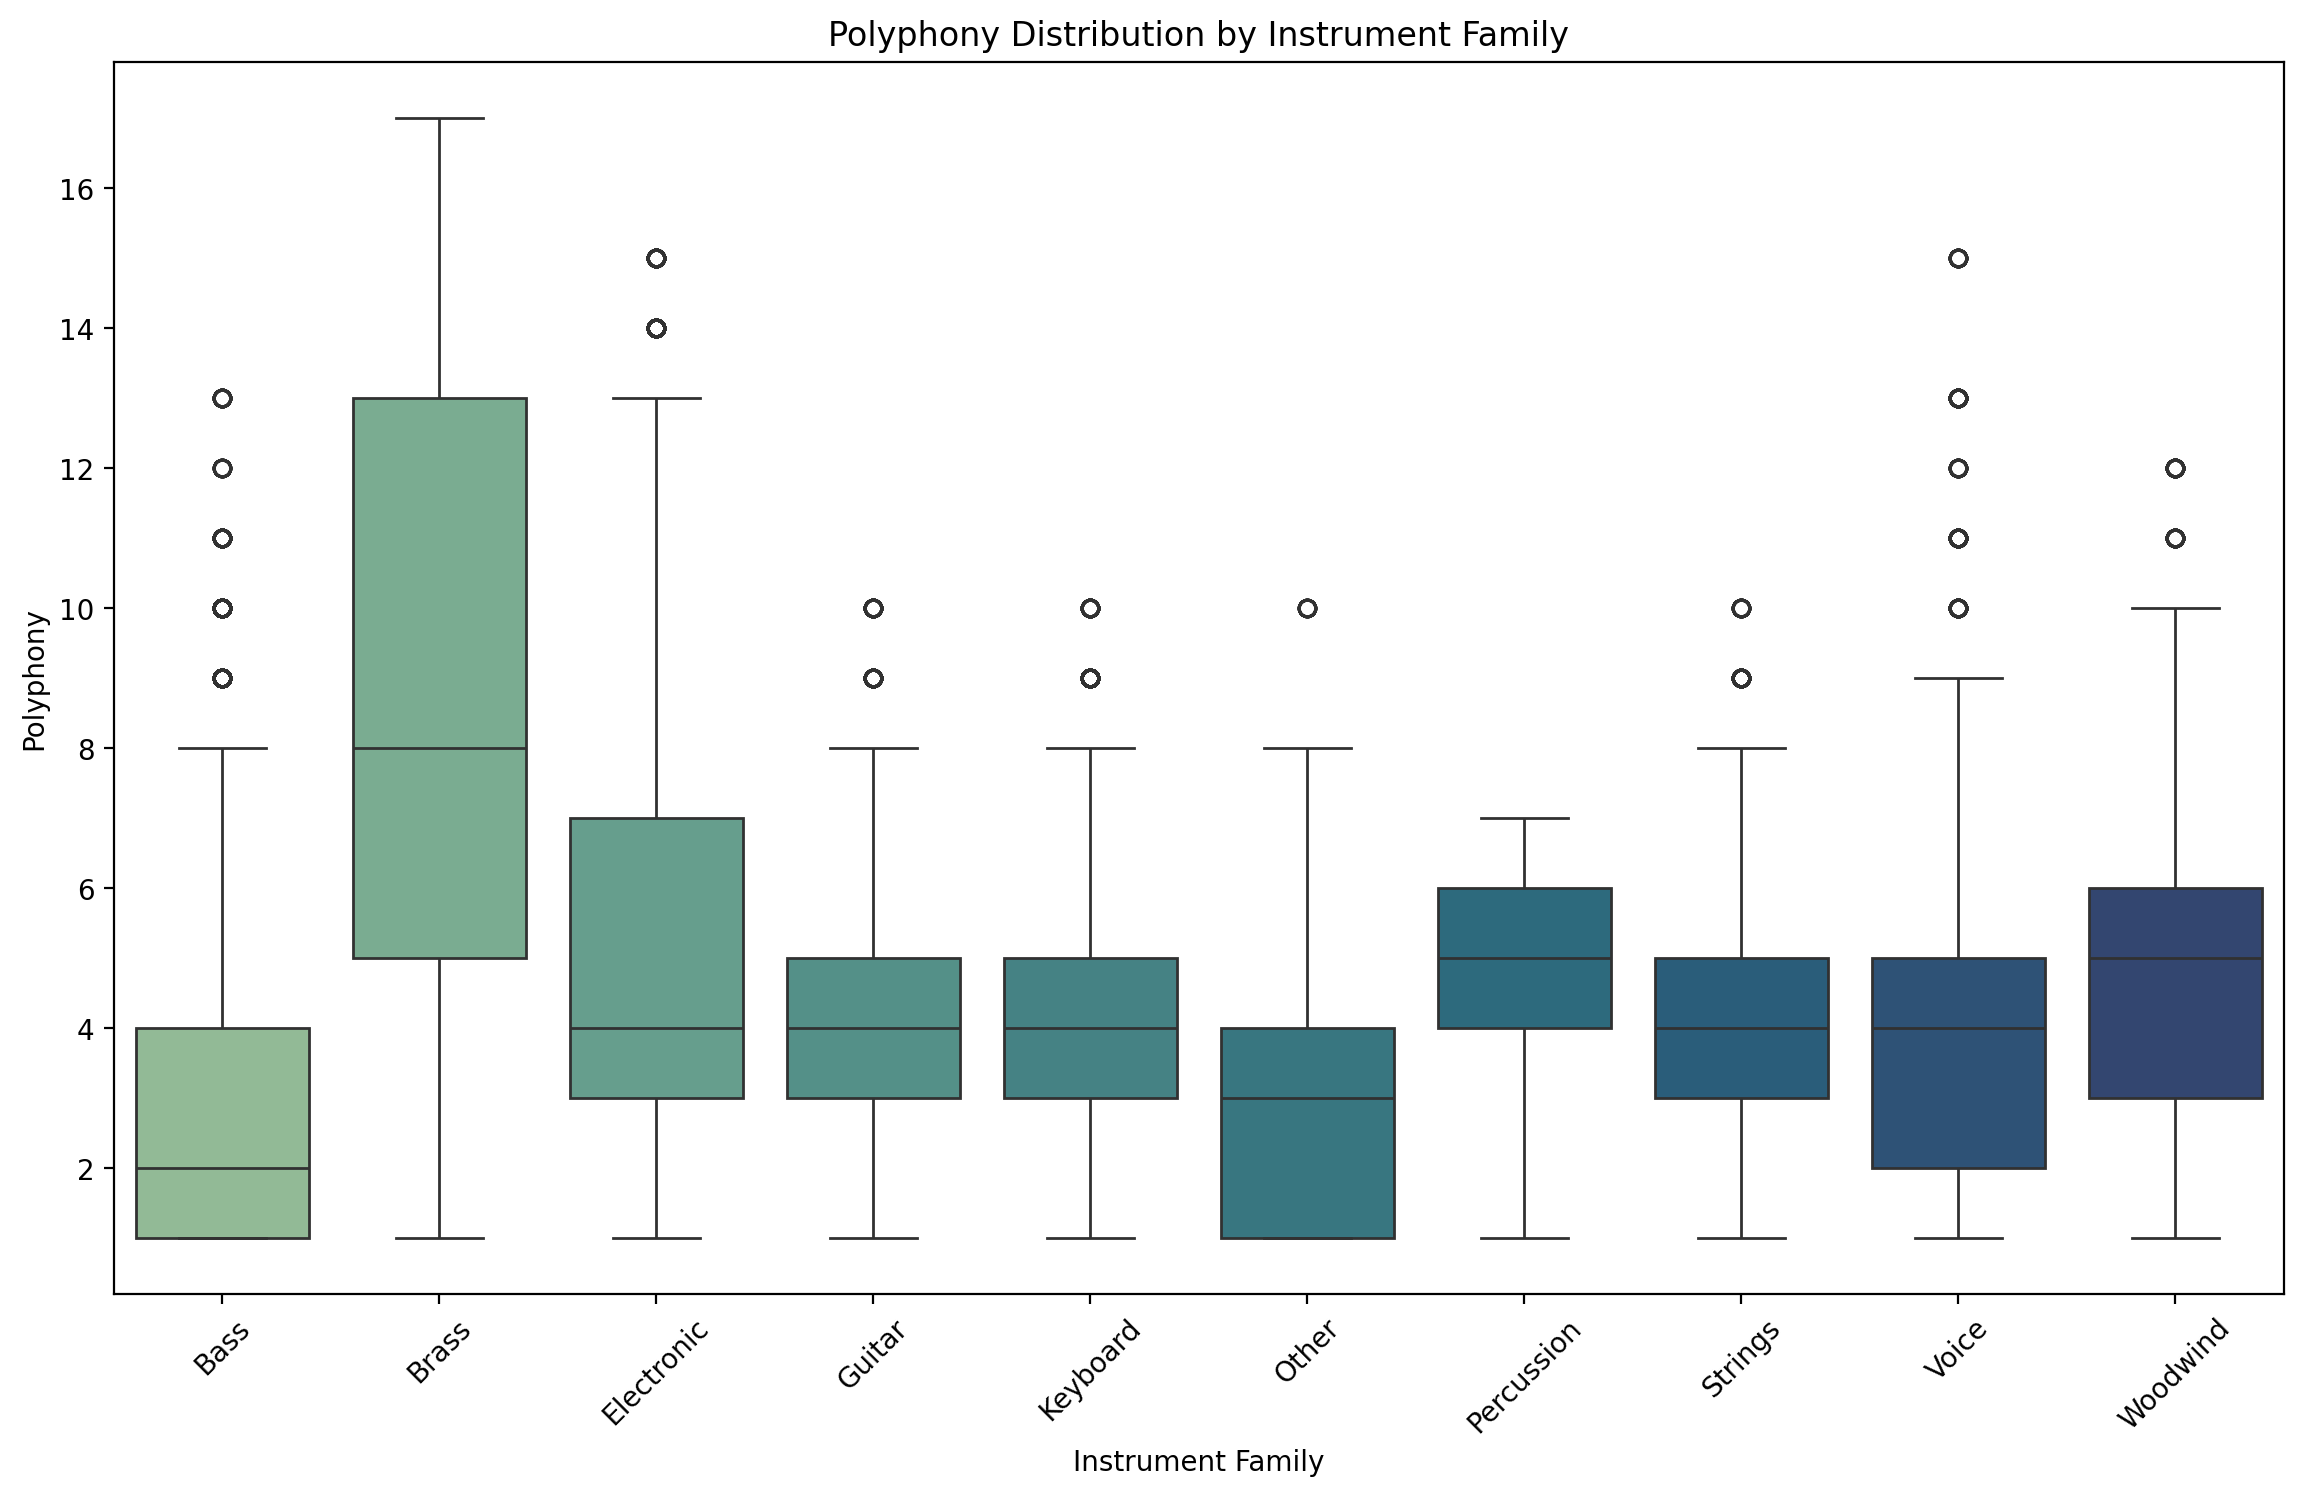

In [232]:
# Filter and plot polyphony distribution by instrument family
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='instrument_family',
    y='polyphony',
    palette='crest',
    order=families
)
plt.title('Polyphony Distribution by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Polyphony')
plt.xticks(rotation=45)
plt.show()

In [233]:
# Descriptive statistics of polyphony by genre
print("Polyphony statistics by Genre:")
df.groupby('genre')['polyphony'].describe()

Polyphony statistics by Genre:


count      mean       std  min  25%  50%  75%   max
genre                                                                  
alternative_rock   7460.0  4.046783  2.273989  1.0  2.0  3.0  6.0  11.0
blues             22575.0  4.218560  2.260536  1.0  2.0  4.0  6.0  13.0
classical         15371.0  1.751350  1.370658  1.0  1.0  1.0  2.0   8.0
country           14654.0  4.241299  1.999808  1.0  3.0  4.0  6.0  10.0
dance              6910.0  2.588857  1.067483  1.0  2.0  2.0  3.0   6.0
disco              9845.0  3.815236  1.480296  1.0  3.0  4.0  5.0  10.0
heavy_metal        6189.0  3.569074  1.585615  1.0  2.0  4.0  5.0  10.0
jazz              13486.0  5.404419  4.160573  1.0  2.0  4.0  7.0  17.0
new_age           21791.0  4.285944  1.756850  1.0  3.0  4.0  6.0  11.0
pop               12478.0  4.764786  3.060013  1.0  2.0  4.0  7.0  14.0
rap               13449.0  4.199717  1.908869  1.0  3.0  4.0  5.0  12.0
reggae            14663.0  3.506649  1.483302  1.0  2.0  4.0  5.0   7.0
rnb               13780.0  4.661684  2.829976  1.0  3.0  4.0  6.0  15.0
rock               7344.0  3.037854  1.604394  1.0  2.0  3.0  4.0   9.0
soul              12197.0  4.374272  1.961094  1.0  3.0  4.0  5.0  15.0

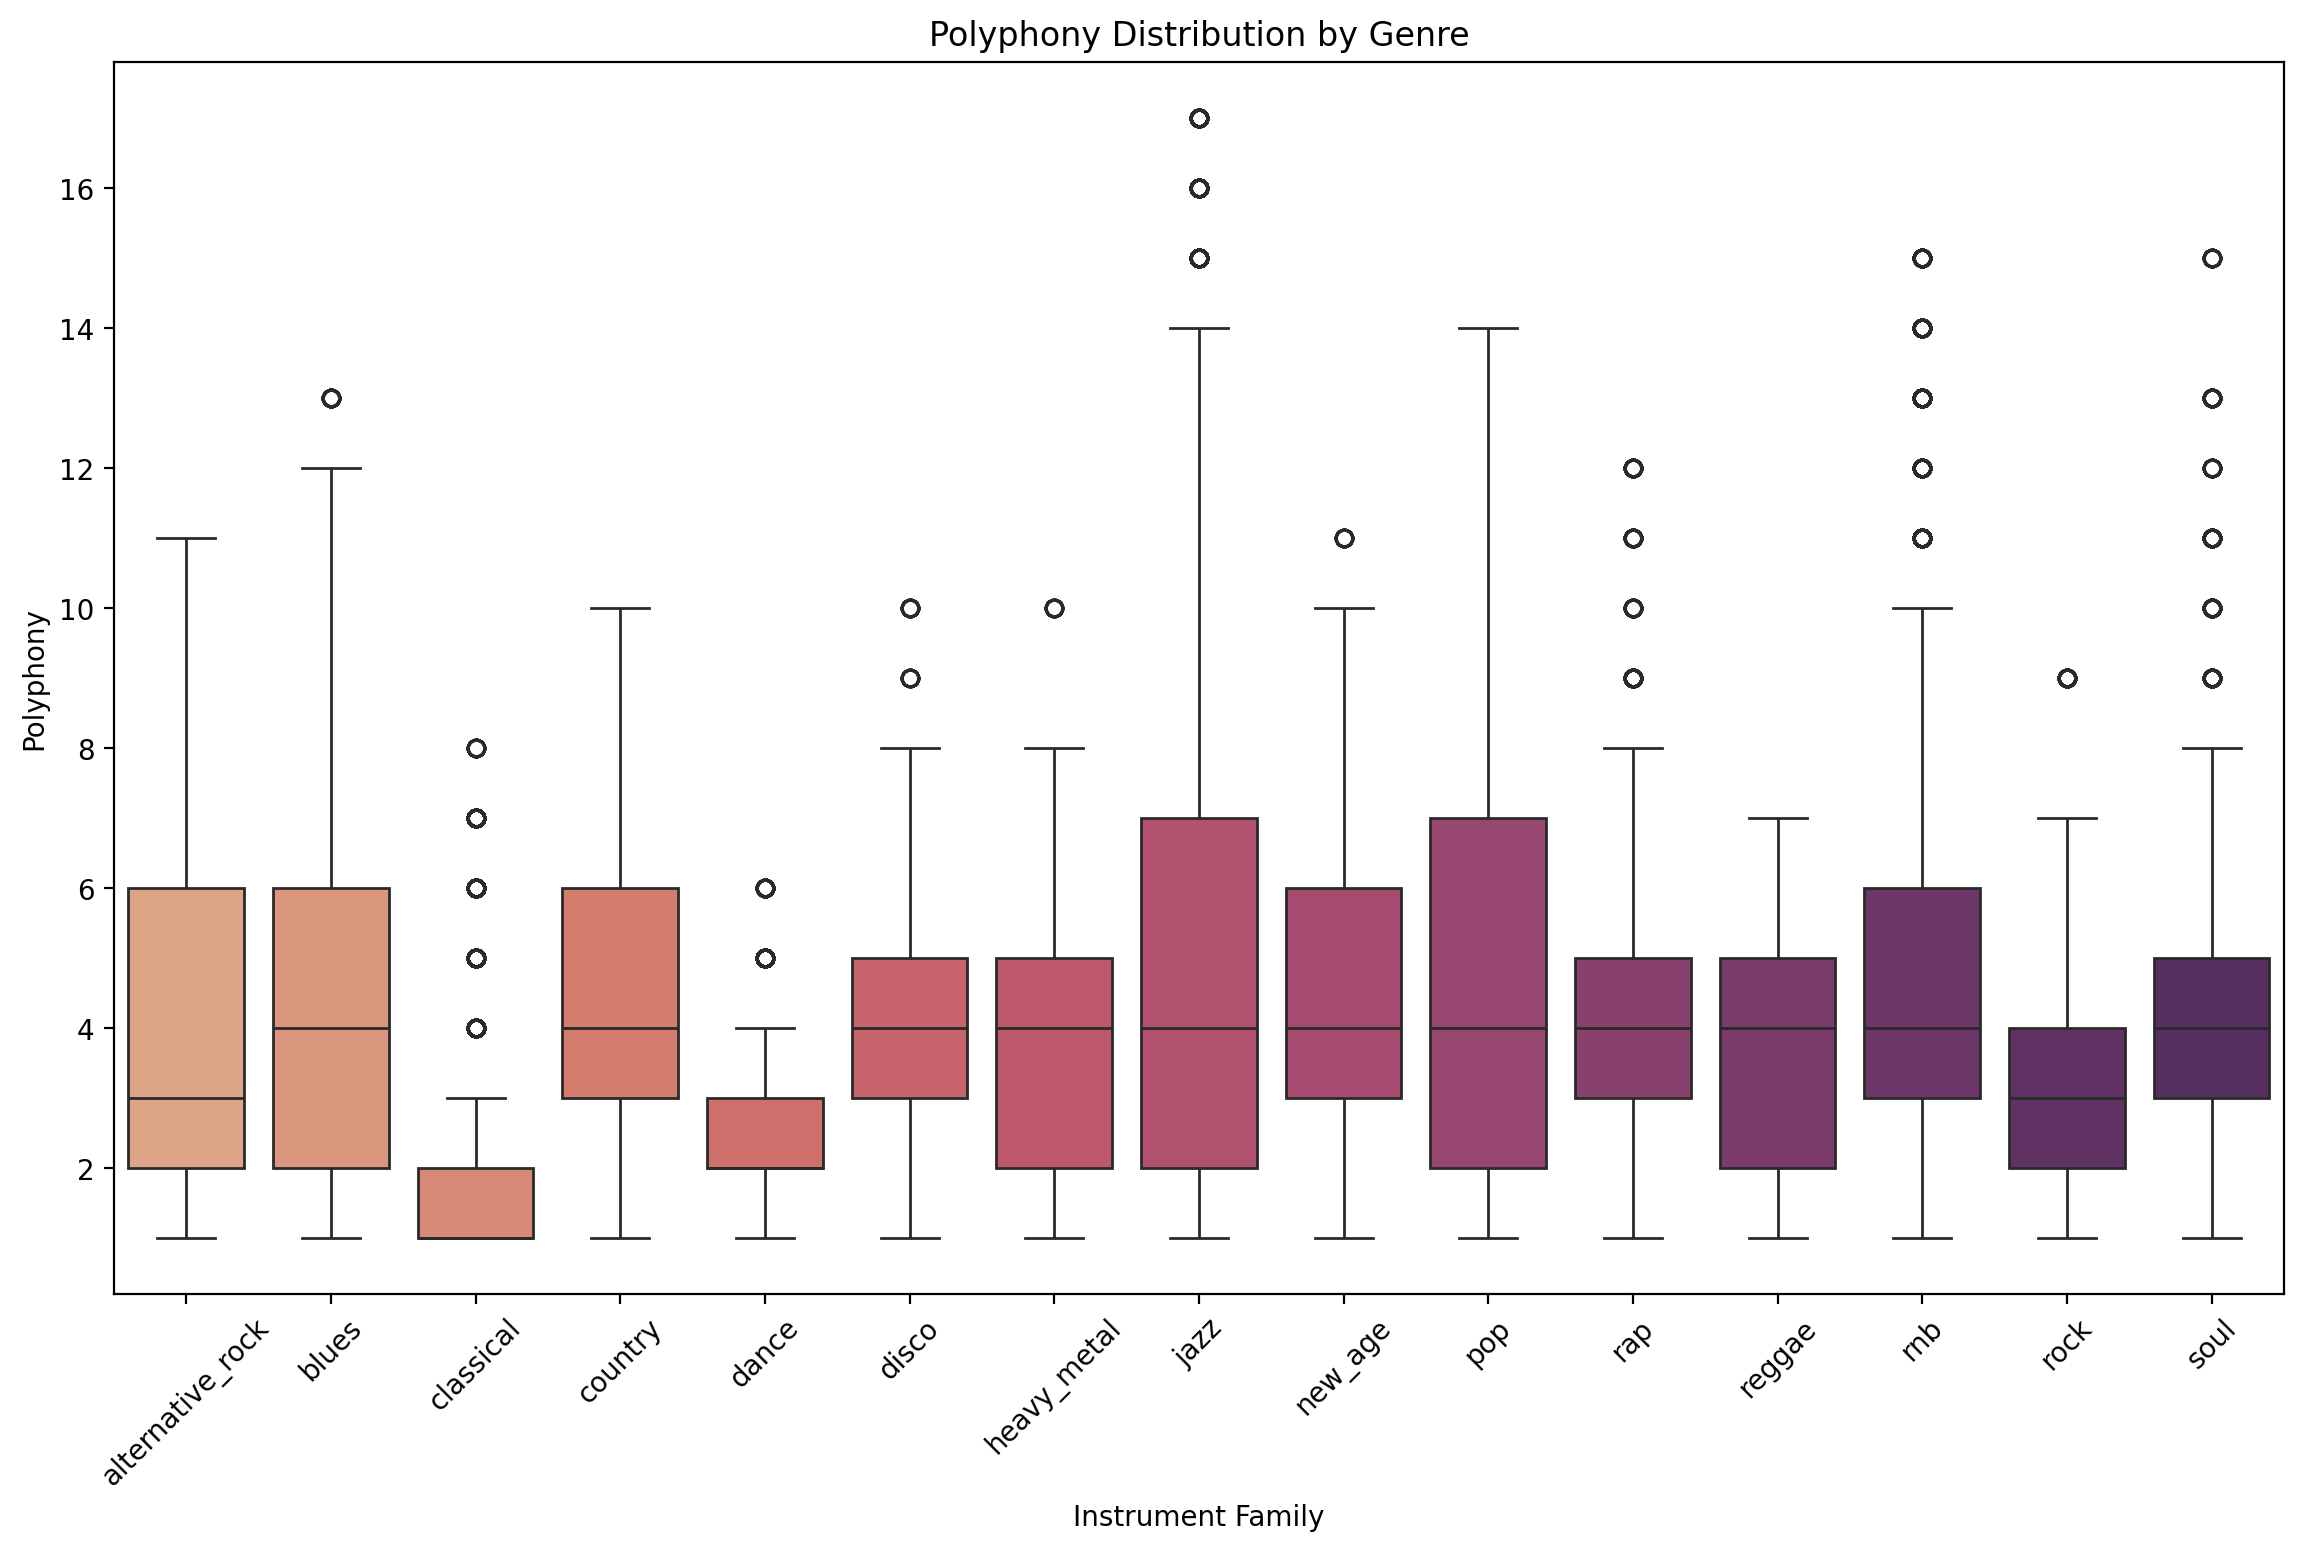

In [234]:
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df,
    x='genre',
    y='polyphony',
    palette='flare',
    order=genres_sorted
)
plt.title('Polyphony Distribution by Genre')
plt.xlabel('Instrument Family')
plt.ylabel('Polyphony')
plt.xticks(rotation=45)
plt.show()

##### 2.3.7.4 Polyphonic Density Across Metric Accents

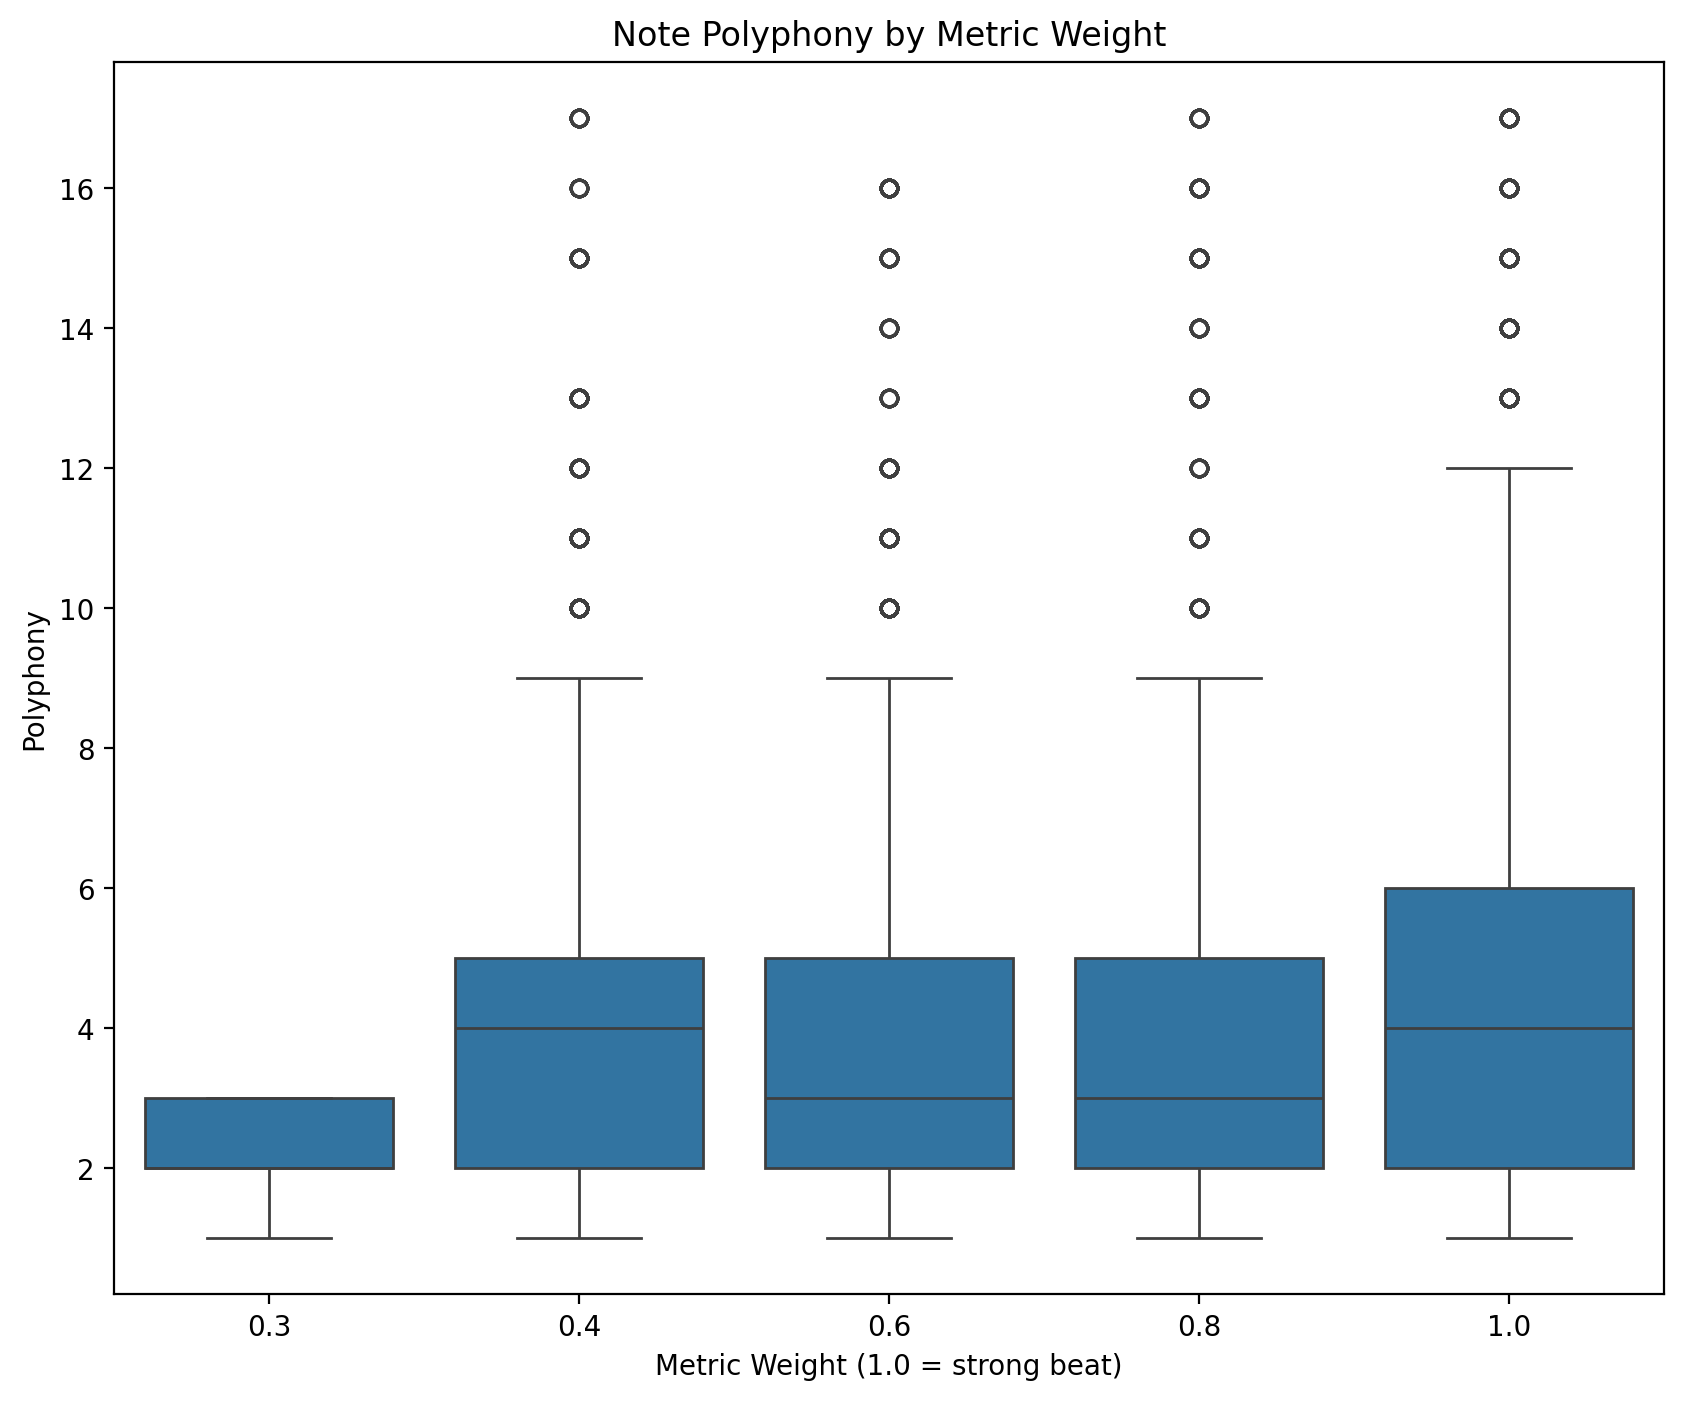

In [239]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Create a boxplot showing how note duration varies with metric weight
sns.boxplot(x="metric_weight", y="polyphony", data=df)

# Add a descriptive title and axis labels
plt.title("Note Polyphony by Metric Weight")
plt.xlabel("Metric Weight (1.0 = strong beat)")
plt.ylabel("Polyphony")
plt.show()

##### 2.3.7.5 Average ratio by Polyphony and Metric Weight

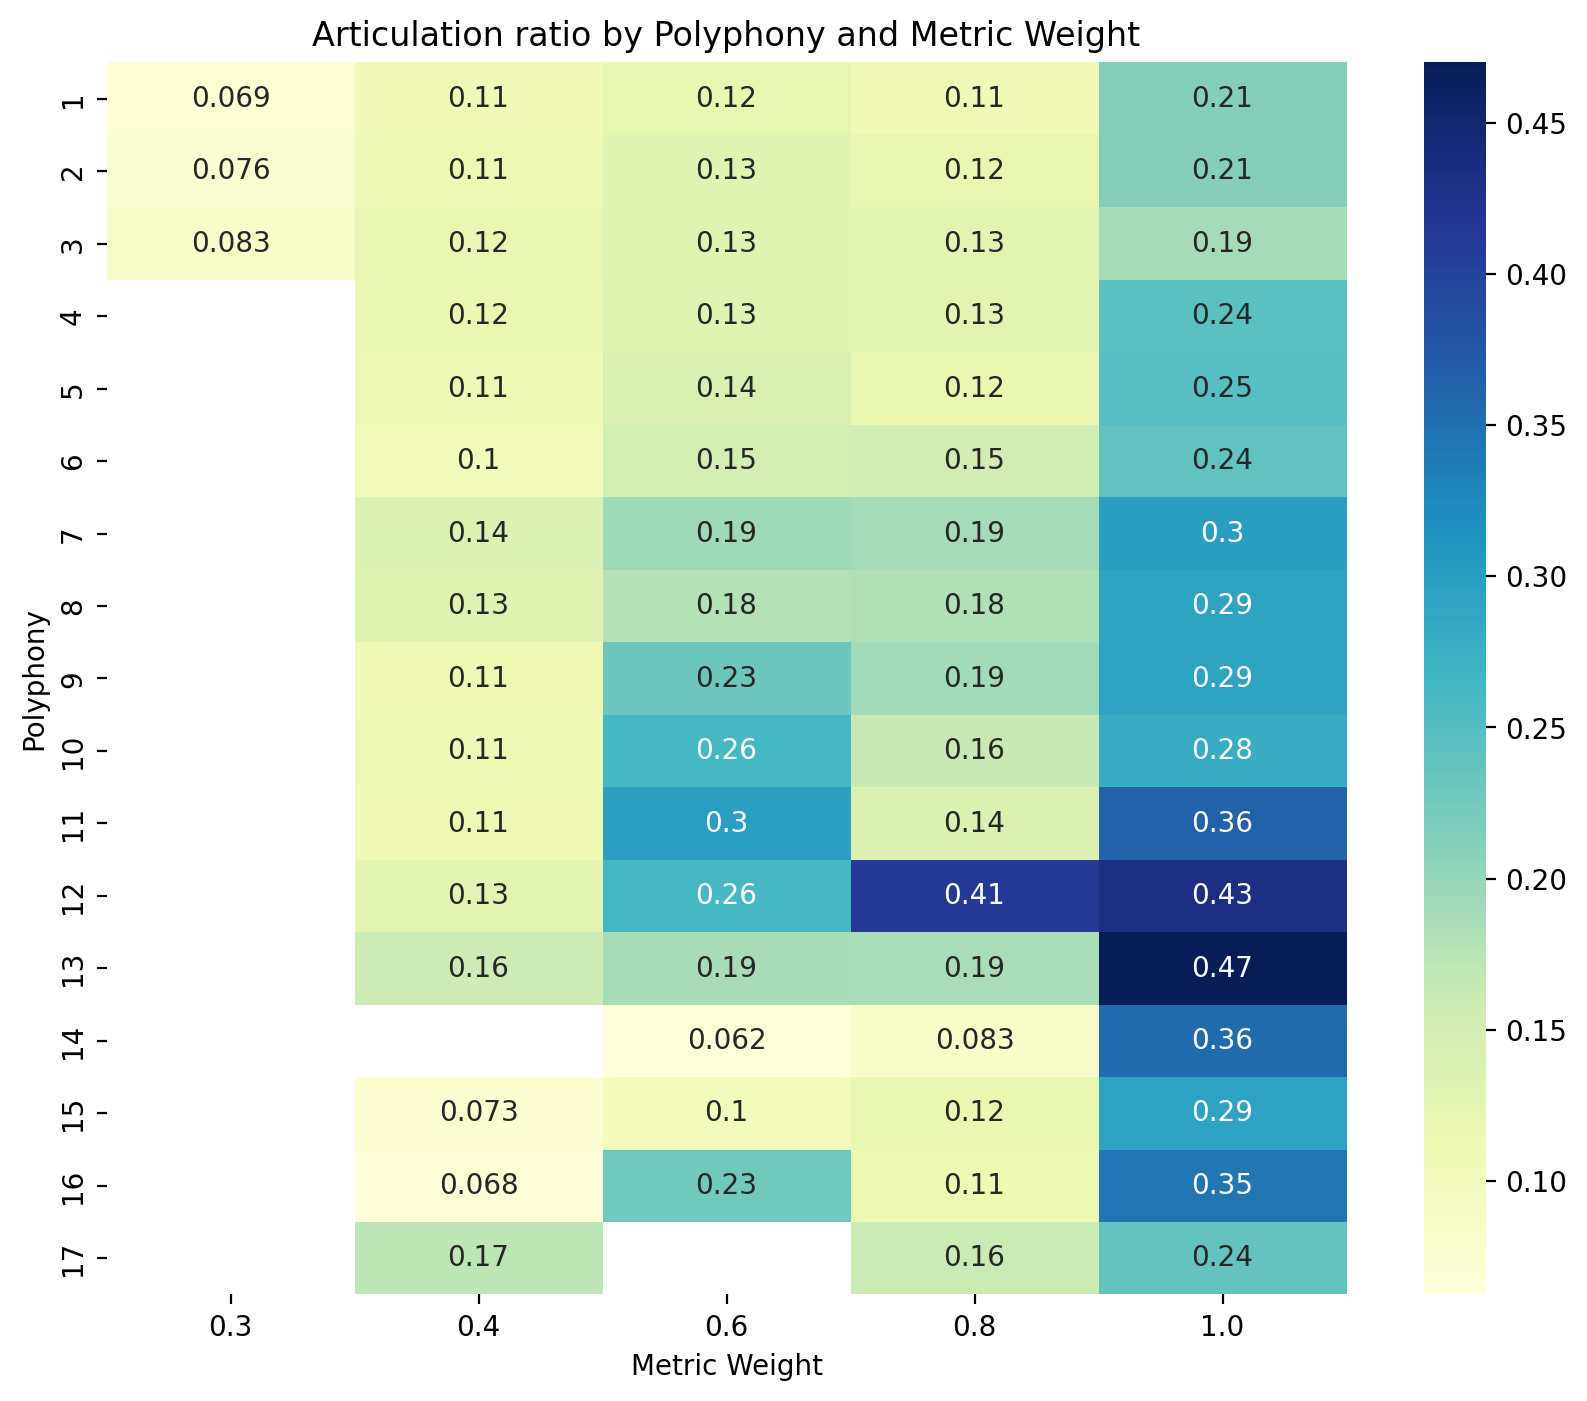

In [242]:
pivot = df.pivot_table(values="articulation_ratio", index="polyphony", columns="metric_weight", aggfunc="mean")
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, ax=ax)
plt.title("Articulation ratio by Polyphony and Metric Weight")
plt.xlabel("Metric Weight")
plt.ylabel("Polyphony")
plt.show()

##### 2.3.7.6 Effect of Polyphony on Note Duration

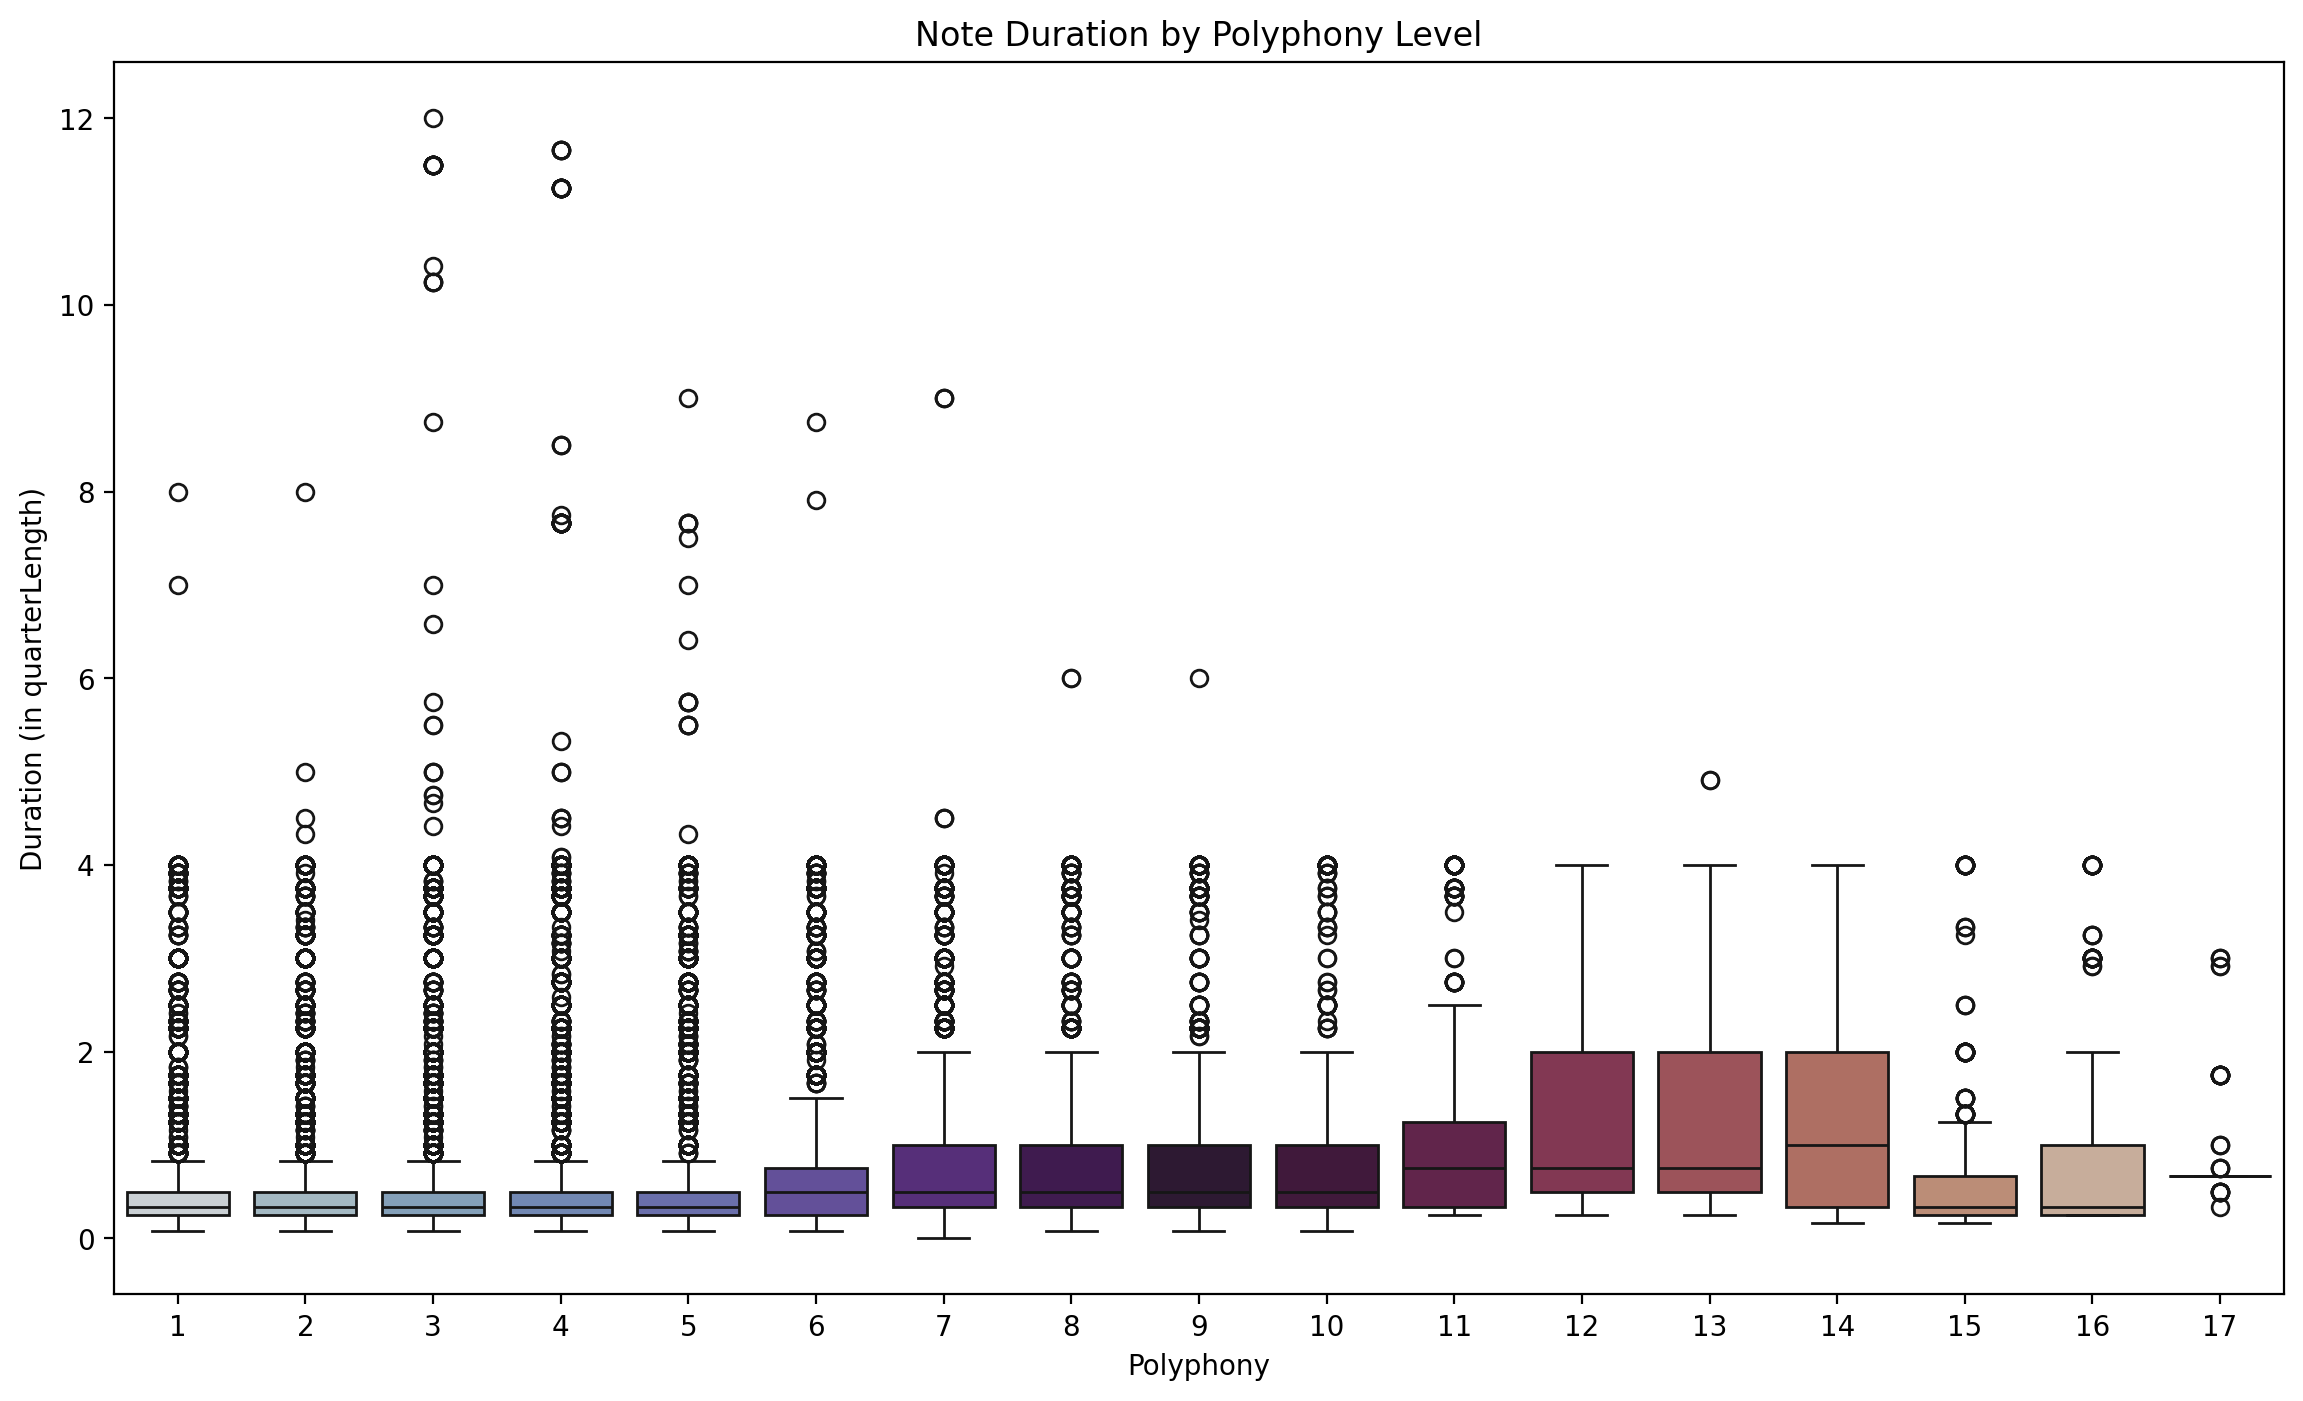

In [252]:
plt.figure(figsize=(14, 8))

# Create a boxplot to visualize how note duration changes with polyphony
sns.boxplot(x="polyphony", y="duration", data=df, palette='twilight')

# Add a descriptive title and labels
plt.title("Note Duration by Polyphony Level")
plt.xlabel("Polyphony")
plt.ylabel("Duration (in quarterLength)")
plt.show()

#### 2.3.8 Chord Tone Indicator

##### 2.3.8.1 Summary statistics and Distribution of Chord Tones (is_chord_tone)


In [259]:
# Descriptive stats: proportion and spread of chord vs non-chord tones
df['is_chord_tone'].describe()

count    192192.000000
mean          0.654731
std           0.475457
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_chord_tone, dtype: float64

In [261]:
# Calculate normalized frequency distribution of chord tone presence
df['is_chord_tone'].value_counts(normalize=True)

is_chord_tone
1    0.654731
0    0.345269
Name: proportion, dtype: float64

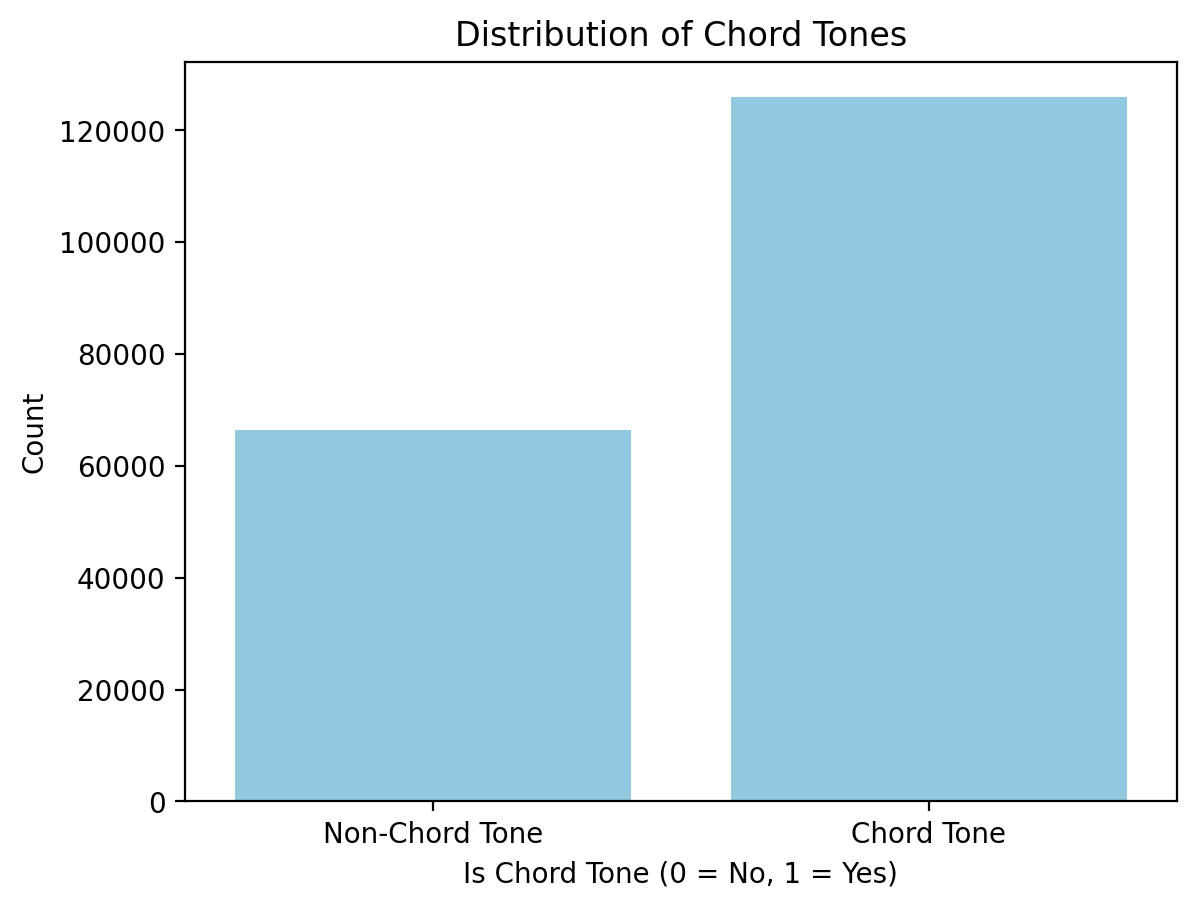

In [265]:
# Plot distribution of chord tones
sns.countplot(x='is_chord_tone', data=df, color='skyblue')
plt.title("Distribution of Chord Tones")
plt.xlabel("Is Chord Tone (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Non-Chord Tone', 'Chord Tone'])
plt.show()

##### 2.3.8.2 Chord Tone Indicator in Context: Key, Instrument, and Genre

In [277]:
# Descriptive statistics of chord tones by key
print("Chord Tone Indicator statistics by Key:")
df.groupby('key')['is_chord_tone'].describe().sort_index()

Chord Tone Indicator statistics by Key:


count      mean       std  min  25%  50%  75%  max
key                                                      
0    11608.0  0.717522  0.450224  0.0  0.0  1.0  1.0  1.0
1     8535.0  0.618981  0.485666  0.0  0.0  1.0  1.0  1.0
2     5075.0  0.658325  0.474318  0.0  0.0  1.0  1.0  1.0
3    13501.0  0.571587  0.494867  0.0  0.0  1.0  1.0  1.0
4     8834.0  0.735907  0.440874  0.0  0.0  1.0  1.0  1.0
5    17733.0  0.645069  0.478506  0.0  0.0  1.0  1.0  1.0
6     4806.0  0.889929  0.313010  0.0  1.0  1.0  1.0  1.0
7    10897.0  0.831605  0.374234  0.0  1.0  1.0  1.0  1.0
9     3344.0  0.745514  0.435637  0.0  0.0  1.0  1.0  1.0
11   24410.0  0.662474  0.472875  0.0  0.0  1.0  1.0  1.0
12    7224.0  0.862680  0.344209  0.0  1.0  1.0  1.0  1.0
13    9294.0  0.627286  0.483553  0.0  0.0  1.0  1.0  1.0
14    7794.0  0.574160  0.494501  0.0  0.0  1.0  1.0  1.0
15    1626.0  0.750923  0.432612  0.0  1.0  1.0  1.0  1.0
16   19702.0  0.674805  0.468460  0.0  0.0  1.0  1.0  1.0
17    7936.0  0.604587  0.488970  0.0  0.0  1.0  1.0  1.0
19   16036.0  0.541095  0.498324  0.0  0.0  1.0  1.0  1.0
21    8261.0  0.335310  0.472127  0.0  0.0  0.0  1.0  1.0
23    5576.0  0.703551  0.456732  0.0  0.0  1.0  1.0  1.0

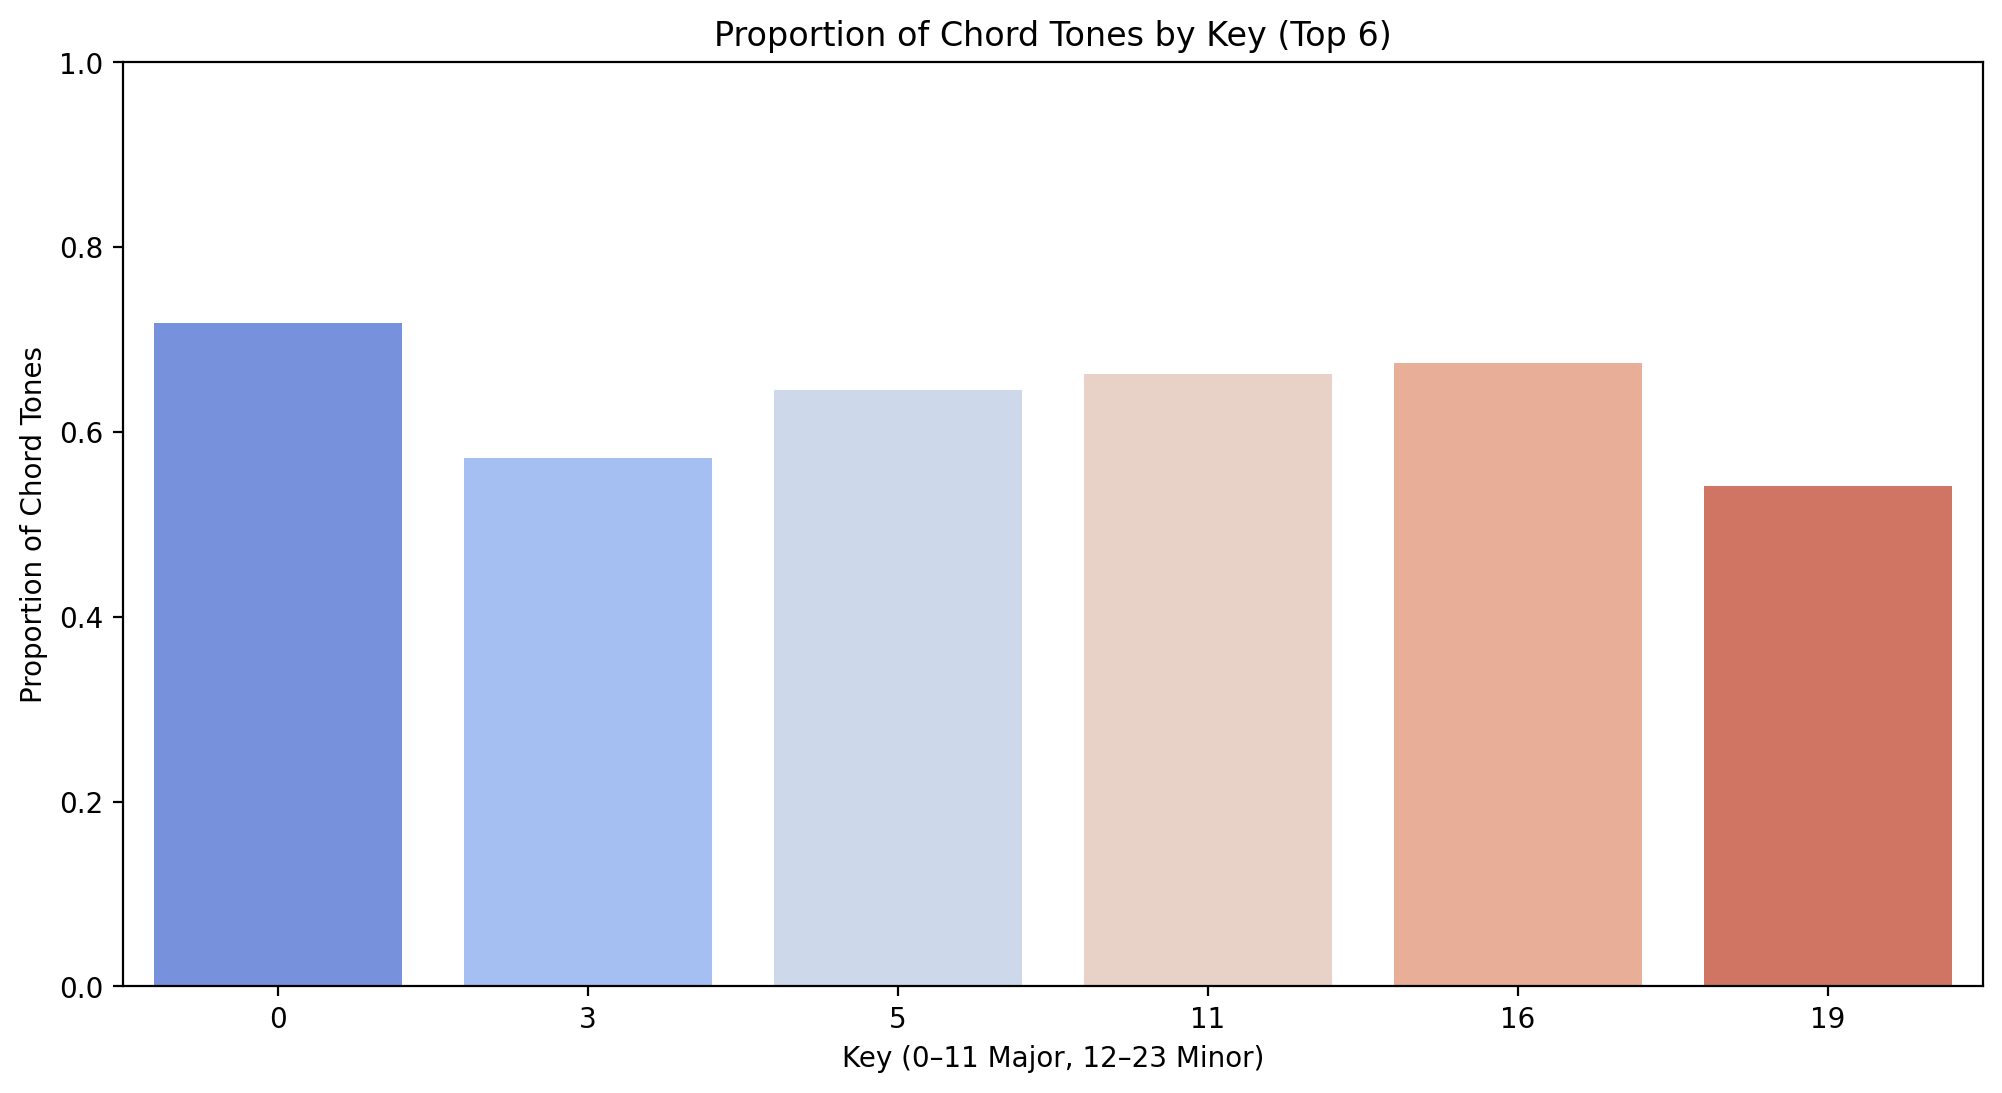

In [268]:
chord_tone_by_key = df[df['key'].isin(top_keys)].groupby('key')['is_chord_tone'].mean().reset_index()

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=chord_tone_by_key, x='key', y='is_chord_tone', palette='coolwarm')
plt.title('Proportion of Chord Tones by Key (Top 6)')
plt.xlabel('Key (0–11 Major, 12–23 Minor)')
plt.ylabel('Proportion of Chord Tones')
plt.ylim(0, 1)
plt.show()

In [276]:
# Descriptive statistics of chord tones by instrument
print("Chord Tone Indicator statistics by Instrument:")
df.groupby('instrument')['is_chord_tone'].describe()

Chord Tone Indicator statistics by Instrument:


count      mean       std  min  25%  50%  75%  max
instrument                                                            
Acoustic Bass     11262.0  0.568904  0.495251  0.0  0.0  1.0  1.0  1.0
Acoustic Guitar   18001.0  0.669463  0.470420  0.0  0.0  1.0  1.0  1.0
Bagpipes           4865.0  0.752929  0.431353  0.0  1.0  1.0  1.0  1.0
Bassoon            1729.0  0.086755  0.281558  0.0  0.0  0.0  0.0  1.0
Celesta            8514.0  0.627907  0.483391  0.0  0.0  1.0  1.0  1.0
Choir              2984.0  0.717158  0.450456  0.0  0.0  1.0  1.0  1.0
Clarinet            998.0  0.248497  0.432358  0.0  0.0  0.0  0.0  1.0
Contrabass         9168.0  0.972077  0.164762  0.0  1.0  1.0  1.0  1.0
Electric Bass       647.0  0.769706  0.421347  0.0  1.0  1.0  1.0  1.0
Electric Guitar   21454.0  0.666682  0.471410  0.0  0.0  1.0  1.0  1.0
Electric Organ     2280.0  0.485965  0.499913  0.0  0.0  0.0  1.0  1.0
Fretless Bass      4777.0  0.842370  0.364432  0.0  1.0  1.0  1.0  1.0
Glockenspiel        133.0  0.451128  0.499487  0.0  0.0  0.0  1.0  1.0
Marimba             235.0  0.153191  0.360941  0.0  0.0  0.0  0.0  1.0
Ocarina             575.0  0.860870  0.346384  0.0  1.0  1.0  1.0  1.0
Piano             38177.0  0.695654  0.460136  0.0  0.0  1.0  1.0  1.0
Piccolo            1462.0  0.559508  0.496616  0.0  0.0  1.0  1.0  1.0
Recorder           1097.0  0.575205  0.494537  0.0  0.0  1.0  1.0  1.0
Sampler           23546.0  0.537416  0.498609  0.0  0.0  1.0  1.0  1.0
StringInstrument   4078.0  0.925944  0.261894  0.0  1.0  1.0  1.0  1.0
Taiko                61.0  0.081967  0.276591  0.0  0.0  0.0  0.0  1.0
Timpani            1450.0  0.476552  0.499622  0.0  0.0  0.0  1.0  1.0
Trombone           4529.0  0.328108  0.469576  0.0  0.0  0.0  1.0  1.0
Trumpet             105.0  0.685714  0.466457  0.0  0.0  1.0  1.0  1.0
Unknown           14549.0  0.597292  0.490460  0.0  0.0  1.0  1.0  1.0
Violoncello         360.0  0.688889  0.463592  0.0  0.0  1.0  1.0  1.0
Voice             11500.0  0.801913  0.398575  0.0  1.0  1.0  1.0  1.0
Whistle            3656.0  0.421772  0.493910  0.0  0.0  0.0  1.0  1.0

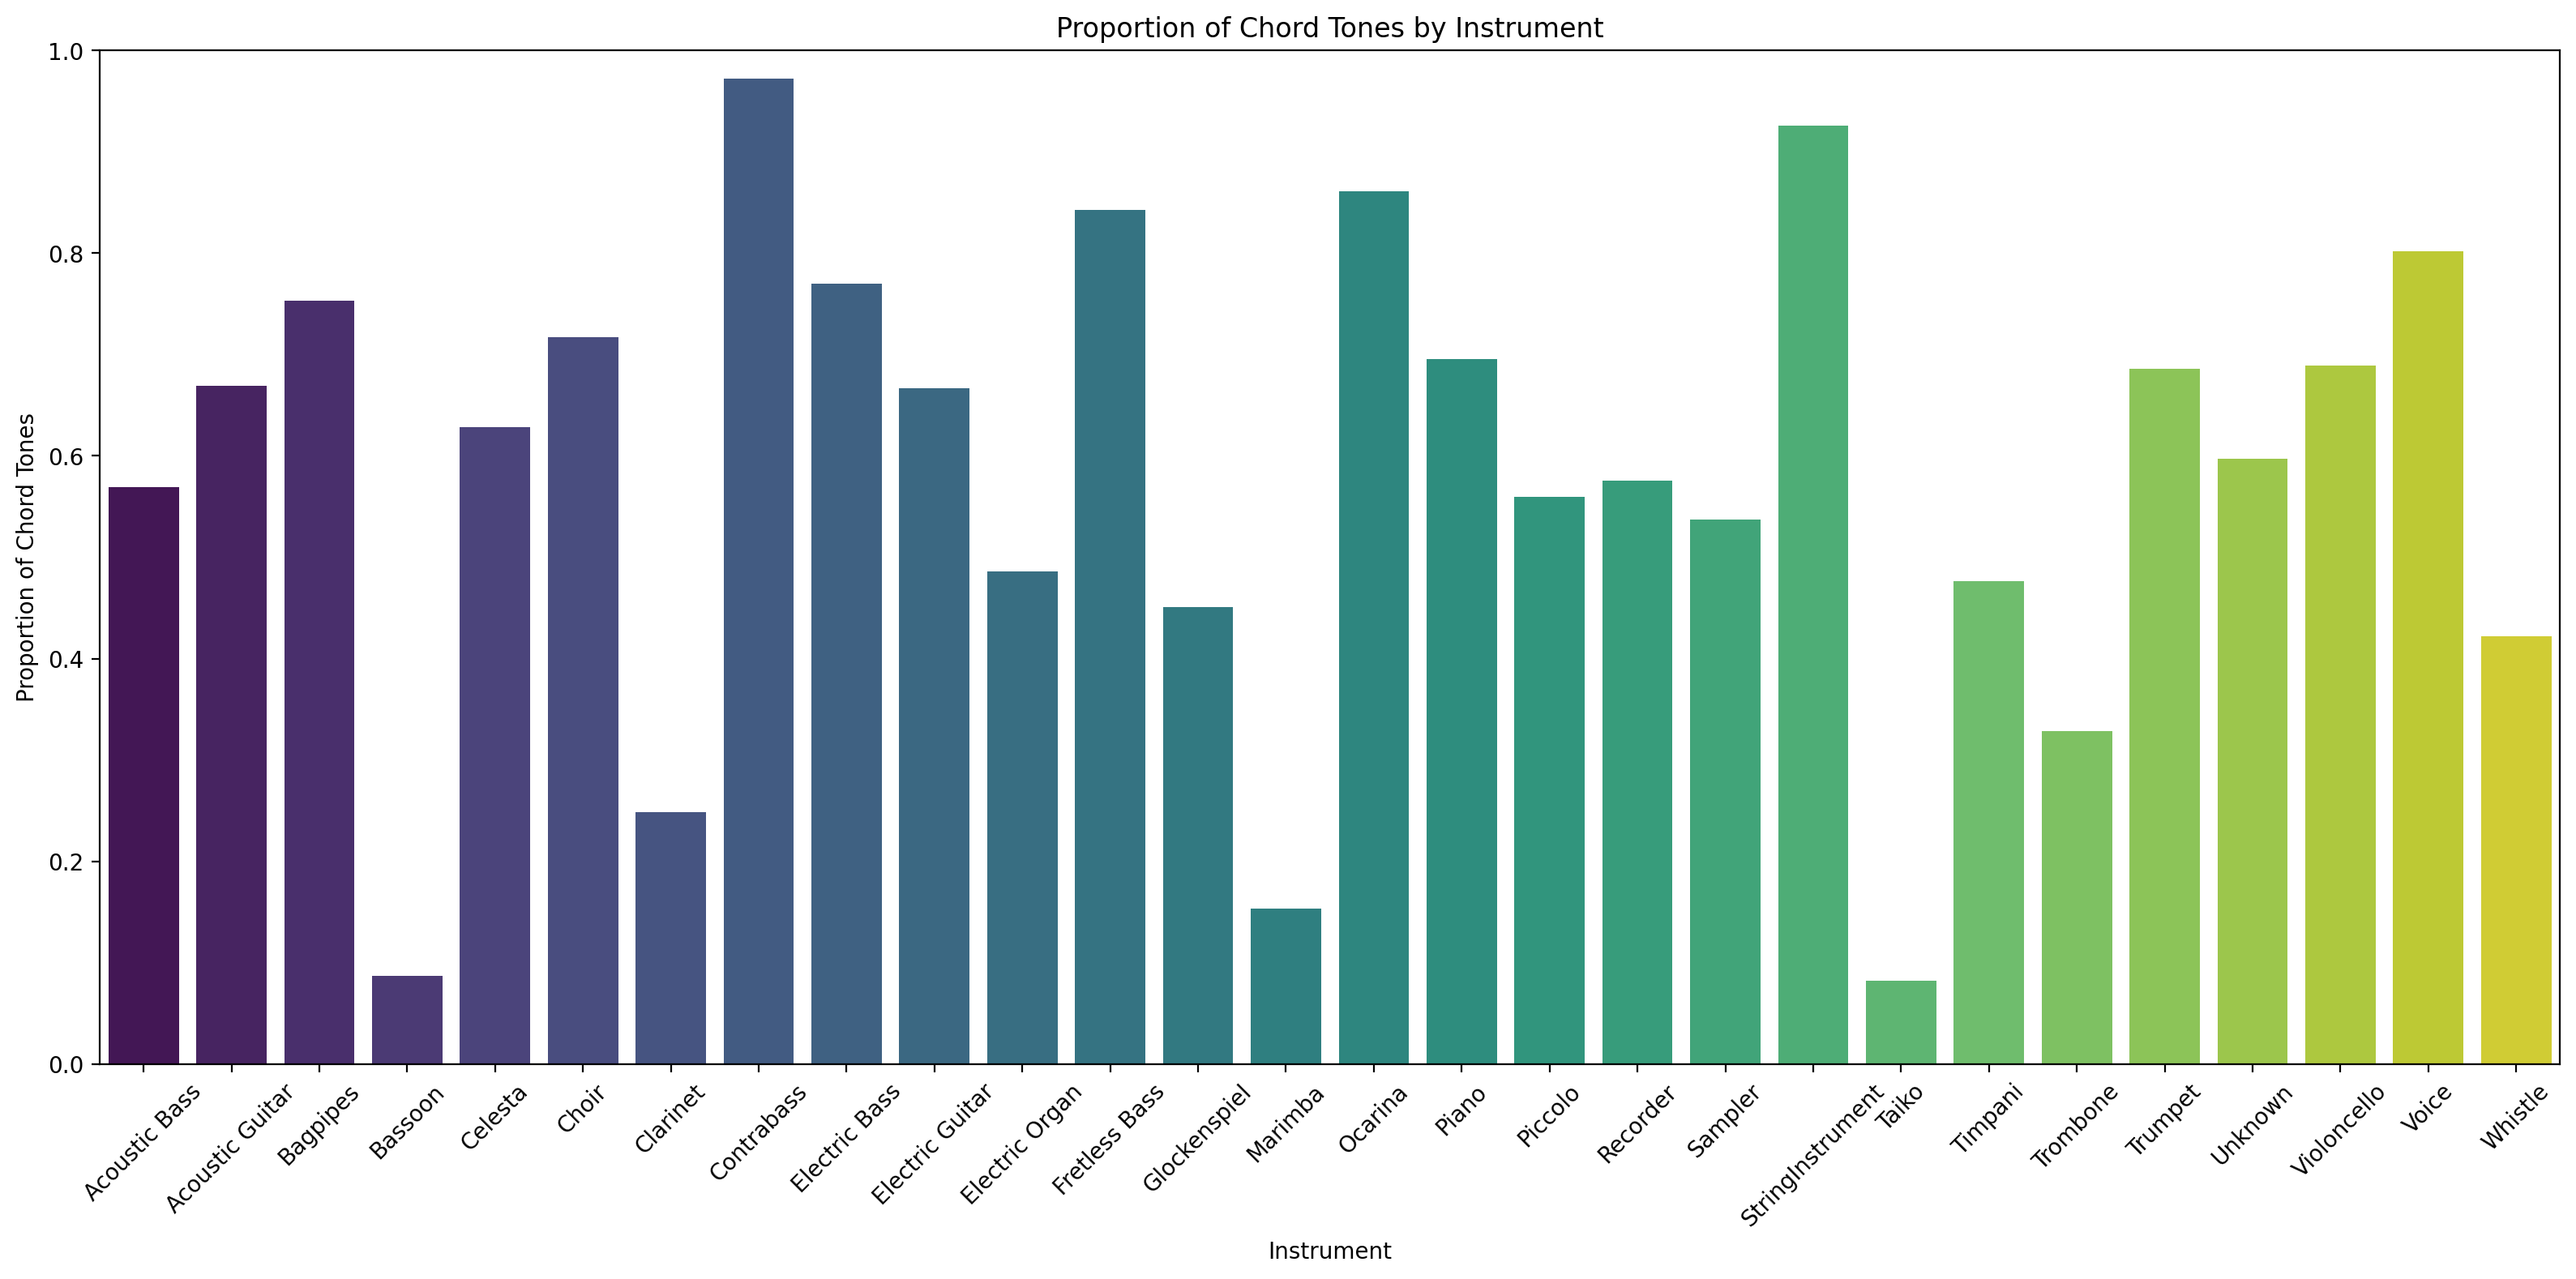

In [271]:
# Compute proportion of chord tones by instrument
chord_tone_by_instr = (
    df.groupby('instrument')['is_chord_tone']
    .mean()
    .sort_index()  # or .sort_values(ascending=False) for ranking
    .reset_index()
)

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=chord_tone_by_instr, x='instrument', y='is_chord_tone', palette='viridis')
plt.xticks(rotation=45)
plt.title('Proportion of Chord Tones by Instrument')
plt.xlabel('Instrument')
plt.ylabel('Proportion of Chord Tones')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [272]:
# Descriptive statistics of chord tone indicator by instrument family
print("Chord Tone Indicator statistics by Instrument Family:")
df.groupby('instrument')['is_chord_tone'].describe()

Chord Tone Indicator statistics by Instrument Family:


count      mean       std  min  25%  50%  75%  max
instrument                                                            
Acoustic Bass     11262.0  0.568904  0.495251  0.0  0.0  1.0  1.0  1.0
Acoustic Guitar   18001.0  0.669463  0.470420  0.0  0.0  1.0  1.0  1.0
Bagpipes           4865.0  0.752929  0.431353  0.0  1.0  1.0  1.0  1.0
Bassoon            1729.0  0.086755  0.281558  0.0  0.0  0.0  0.0  1.0
Celesta            8514.0  0.627907  0.483391  0.0  0.0  1.0  1.0  1.0
Choir              2984.0  0.717158  0.450456  0.0  0.0  1.0  1.0  1.0
Clarinet            998.0  0.248497  0.432358  0.0  0.0  0.0  0.0  1.0
Contrabass         9168.0  0.972077  0.164762  0.0  1.0  1.0  1.0  1.0
Electric Bass       647.0  0.769706  0.421347  0.0  1.0  1.0  1.0  1.0
Electric Guitar   21454.0  0.666682  0.471410  0.0  0.0  1.0  1.0  1.0
Electric Organ     2280.0  0.485965  0.499913  0.0  0.0  0.0  1.0  1.0
Fretless Bass      4777.0  0.842370  0.364432  0.0  1.0  1.0  1.0  1.0
Glockenspiel        133.0  0.451128  0.499487  0.0  0.0  0.0  1.0  1.0
Marimba             235.0  0.153191  0.360941  0.0  0.0  0.0  0.0  1.0
Ocarina             575.0  0.860870  0.346384  0.0  1.0  1.0  1.0  1.0
Piano             38177.0  0.695654  0.460136  0.0  0.0  1.0  1.0  1.0
Piccolo            1462.0  0.559508  0.496616  0.0  0.0  1.0  1.0  1.0
Recorder           1097.0  0.575205  0.494537  0.0  0.0  1.0  1.0  1.0
Sampler           23546.0  0.537416  0.498609  0.0  0.0  1.0  1.0  1.0
StringInstrument   4078.0  0.925944  0.261894  0.0  1.0  1.0  1.0  1.0
Taiko                61.0  0.081967  0.276591  0.0  0.0  0.0  0.0  1.0
Timpani            1450.0  0.476552  0.499622  0.0  0.0  0.0  1.0  1.0
Trombone           4529.0  0.328108  0.469576  0.0  0.0  0.0  1.0  1.0
Trumpet             105.0  0.685714  0.466457  0.0  0.0  1.0  1.0  1.0
Unknown           14549.0  0.597292  0.490460  0.0  0.0  1.0  1.0  1.0
Violoncello         360.0  0.688889  0.463592  0.0  0.0  1.0  1.0  1.0
Voice             11500.0  0.801913  0.398575  0.0  1.0  1.0  1.0  1.0
Whistle            3656.0  0.421772  0.493910  0.0  0.0  0.0  1.0  1.0

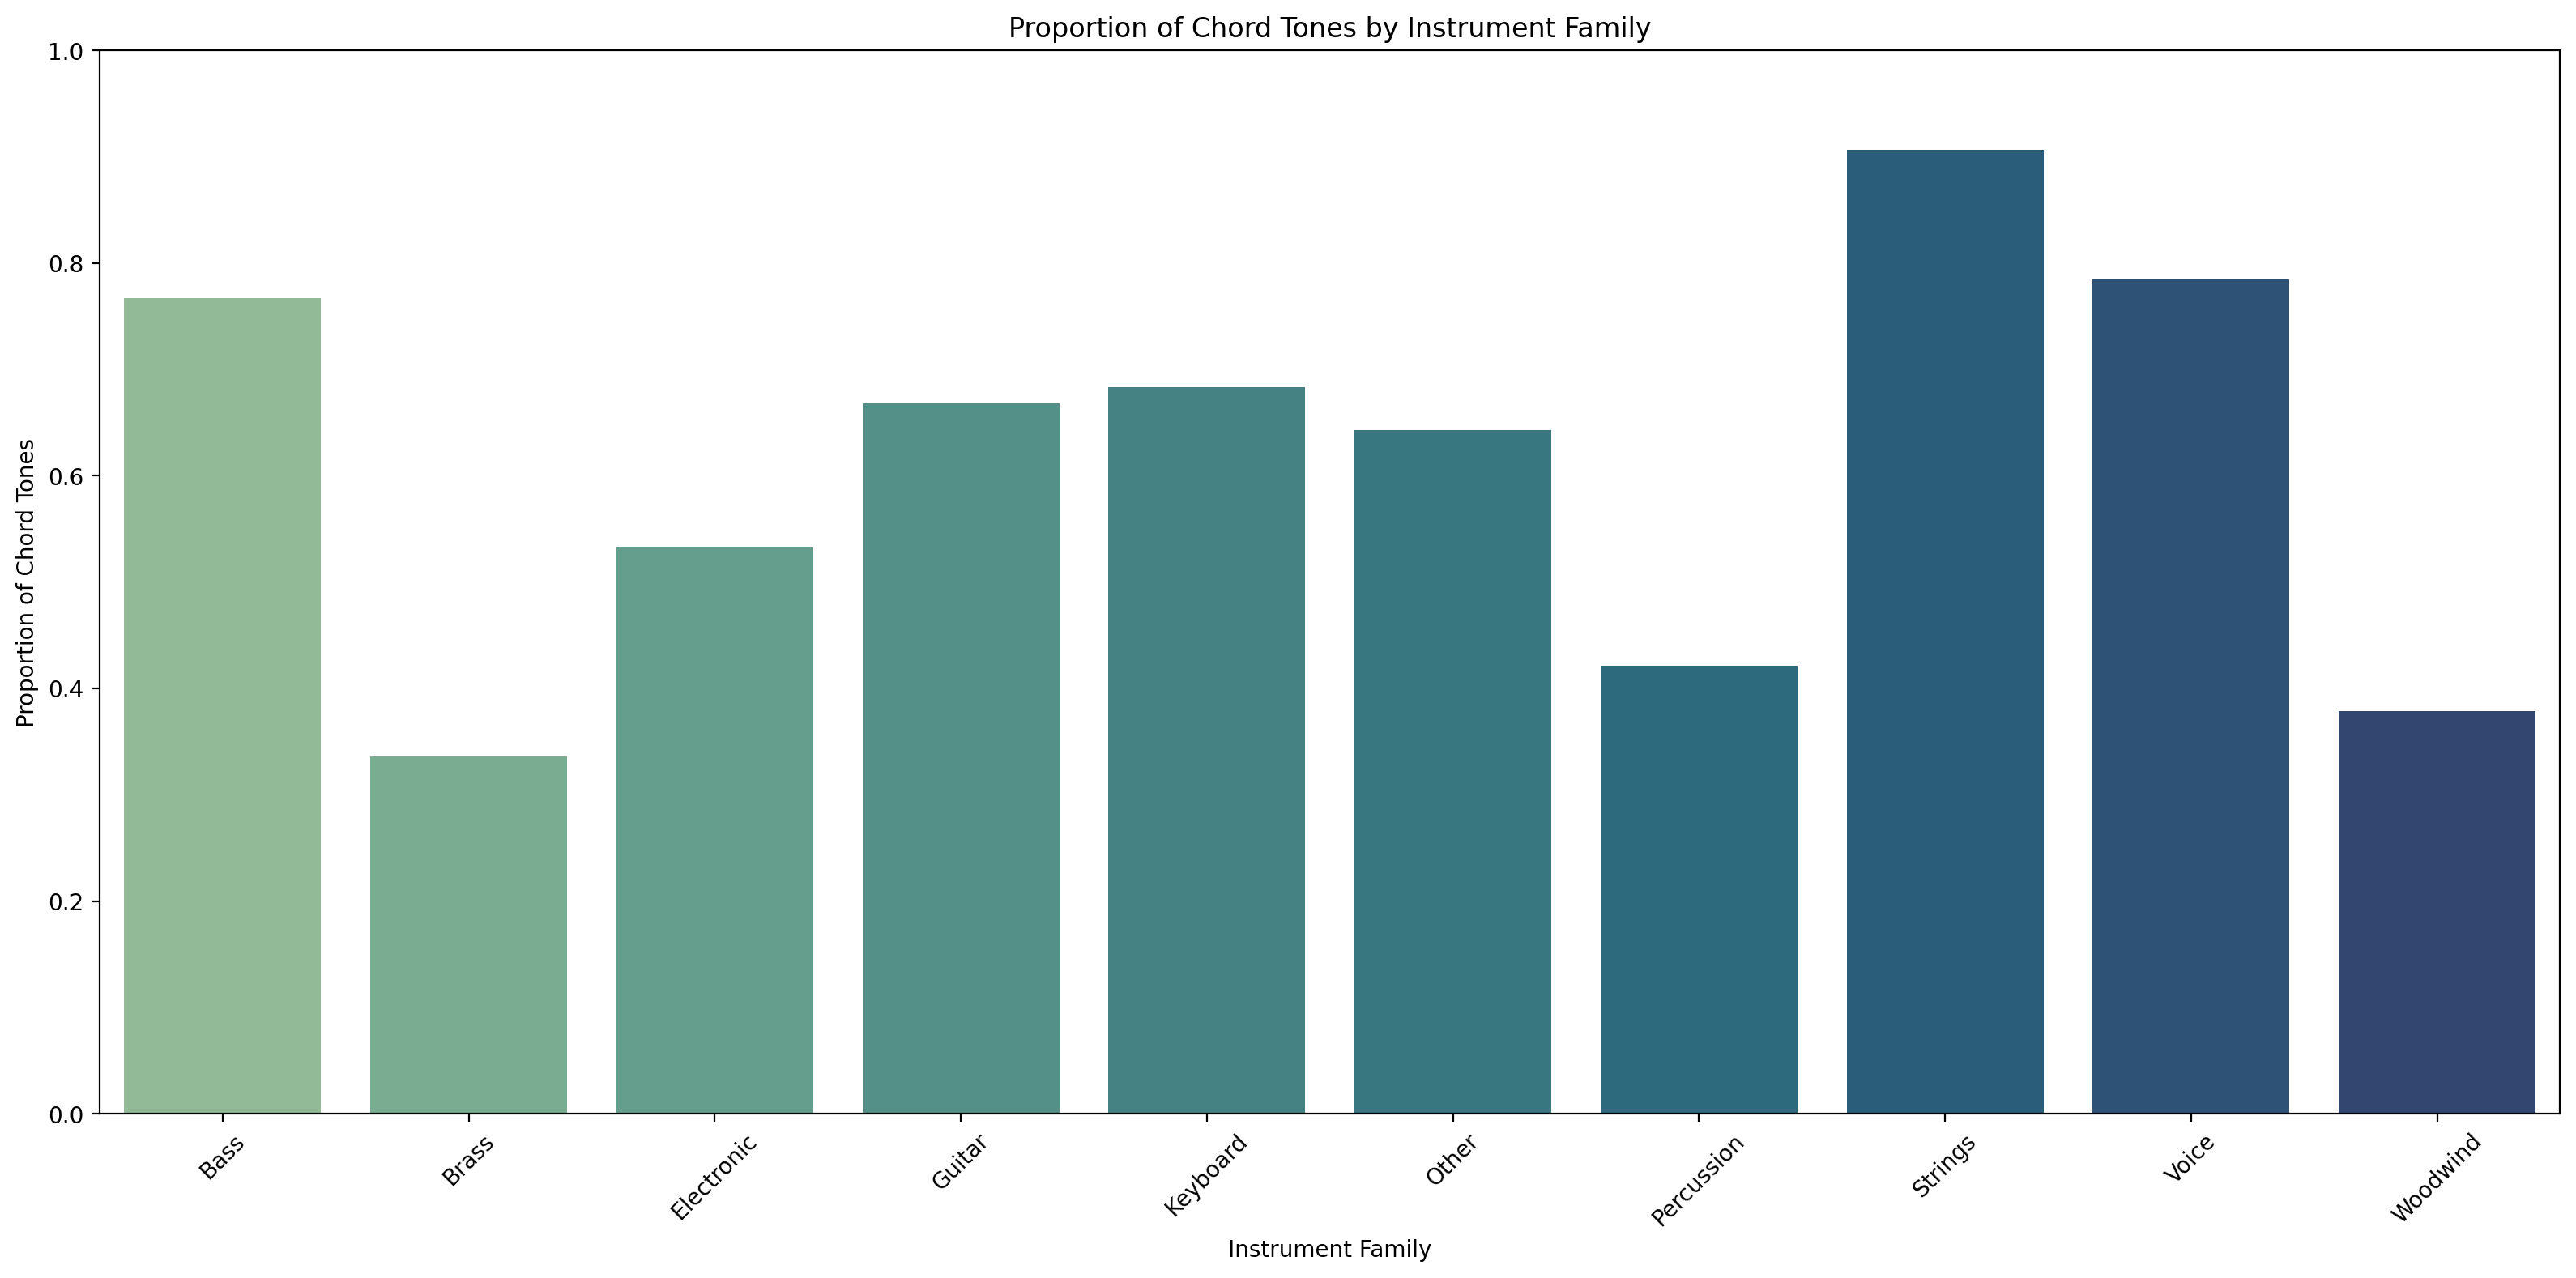

In [278]:
# Compute proportion of chord tones by instrument family
chord_tone_by_instr_fam = (
    df.groupby('instrument_family')['is_chord_tone']
    .mean()
    .sort_index()  # or .sort_values(ascending=False) for ranking
    .reset_index()
)

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=chord_tone_by_instr_fam, x='instrument_family', y='is_chord_tone', palette='crest')
plt.xticks(rotation=45)
plt.title('Proportion of Chord Tones by Instrument Family')
plt.xlabel('Instrument Family')
plt.ylabel('Proportion of Chord Tones')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [283]:
# Descriptive statistics of chord tones by genre
print("Chord tones statistics by Genre:")
df.groupby('genre')['is_chord_tone'].describe()

Chord tones statistics by Genre:


count      mean       std  min  25%  50%  75%  max
genre                                                                 
alternative_rock   7460.0  0.538740  0.498530  0.0  0.0  1.0  1.0  1.0
blues             22575.0  0.580509  0.493487  0.0  0.0  1.0  1.0  1.0
classical         15371.0  0.770412  0.420582  0.0  1.0  1.0  1.0  1.0
country           14654.0  0.697284  0.459449  0.0  0.0  1.0  1.0  1.0
dance              6910.0  0.621852  0.484960  0.0  0.0  1.0  1.0  1.0
disco              9845.0  0.661757  0.473136  0.0  0.0  1.0  1.0  1.0
heavy_metal        6189.0  0.372435  0.483492  0.0  0.0  0.0  1.0  1.0
jazz              13486.0  0.478422  0.499553  0.0  0.0  0.0  1.0  1.0
new_age           21791.0  0.686293  0.464010  0.0  0.0  1.0  1.0  1.0
pop               12478.0  0.684324  0.464803  0.0  0.0  1.0  1.0  1.0
rap               13449.0  0.726076  0.445987  0.0  0.0  1.0  1.0  1.0
reggae            14663.0  0.827116  0.378160  0.0  1.0  1.0  1.0  1.0
rnb               13780.0  0.617489  0.486018  0.0  0.0  1.0  1.0  1.0
rock               7344.0  0.578704  0.493800  0.0  0.0  1.0  1.0  1.0
soul              12197.0  0.732557  0.442643  0.0  0.0  1.0  1.0  1.0

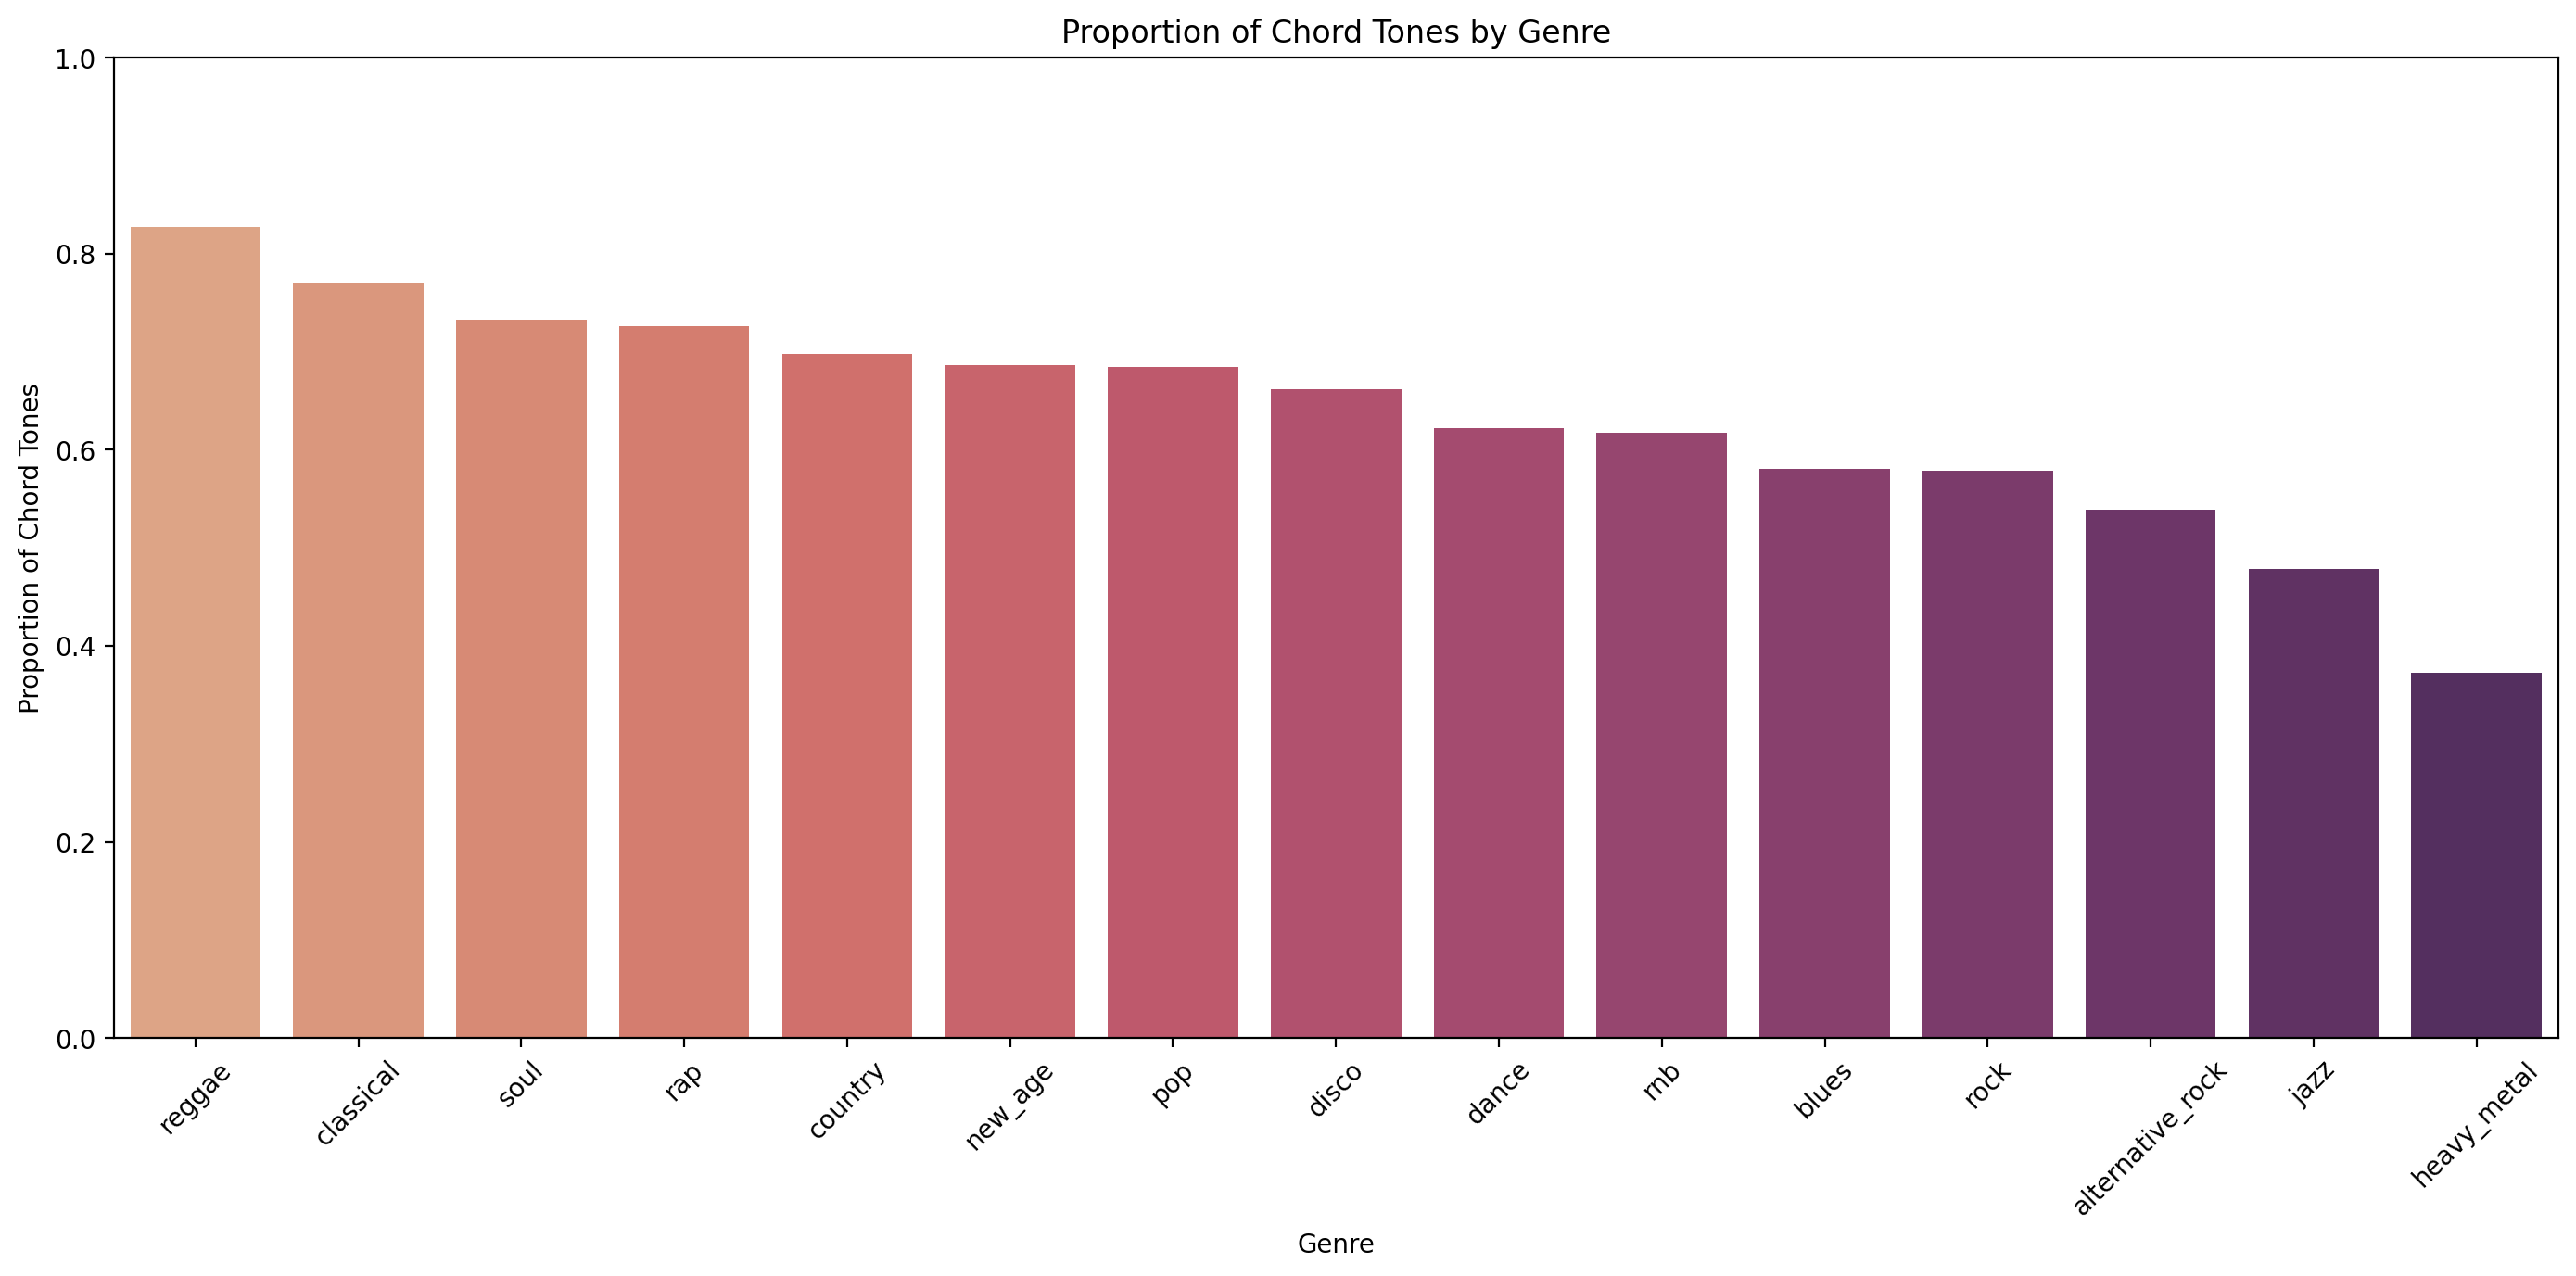

In [282]:
chord_tone_by_genre = (
    df.groupby('genre')['is_chord_tone']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(14, 7))
sns.barplot(data=chord_tone_by_genre, x='genre', y='is_chord_tone', palette='flare')
plt.xticks(rotation=45)
plt.title('Proportion of Chord Tones by Genre')
plt.xlabel('Genre')
plt.ylabel('Proportion of Chord Tones')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

##### 2.3.8.3 Evolution of Chord Tones Over Phrases or Measures

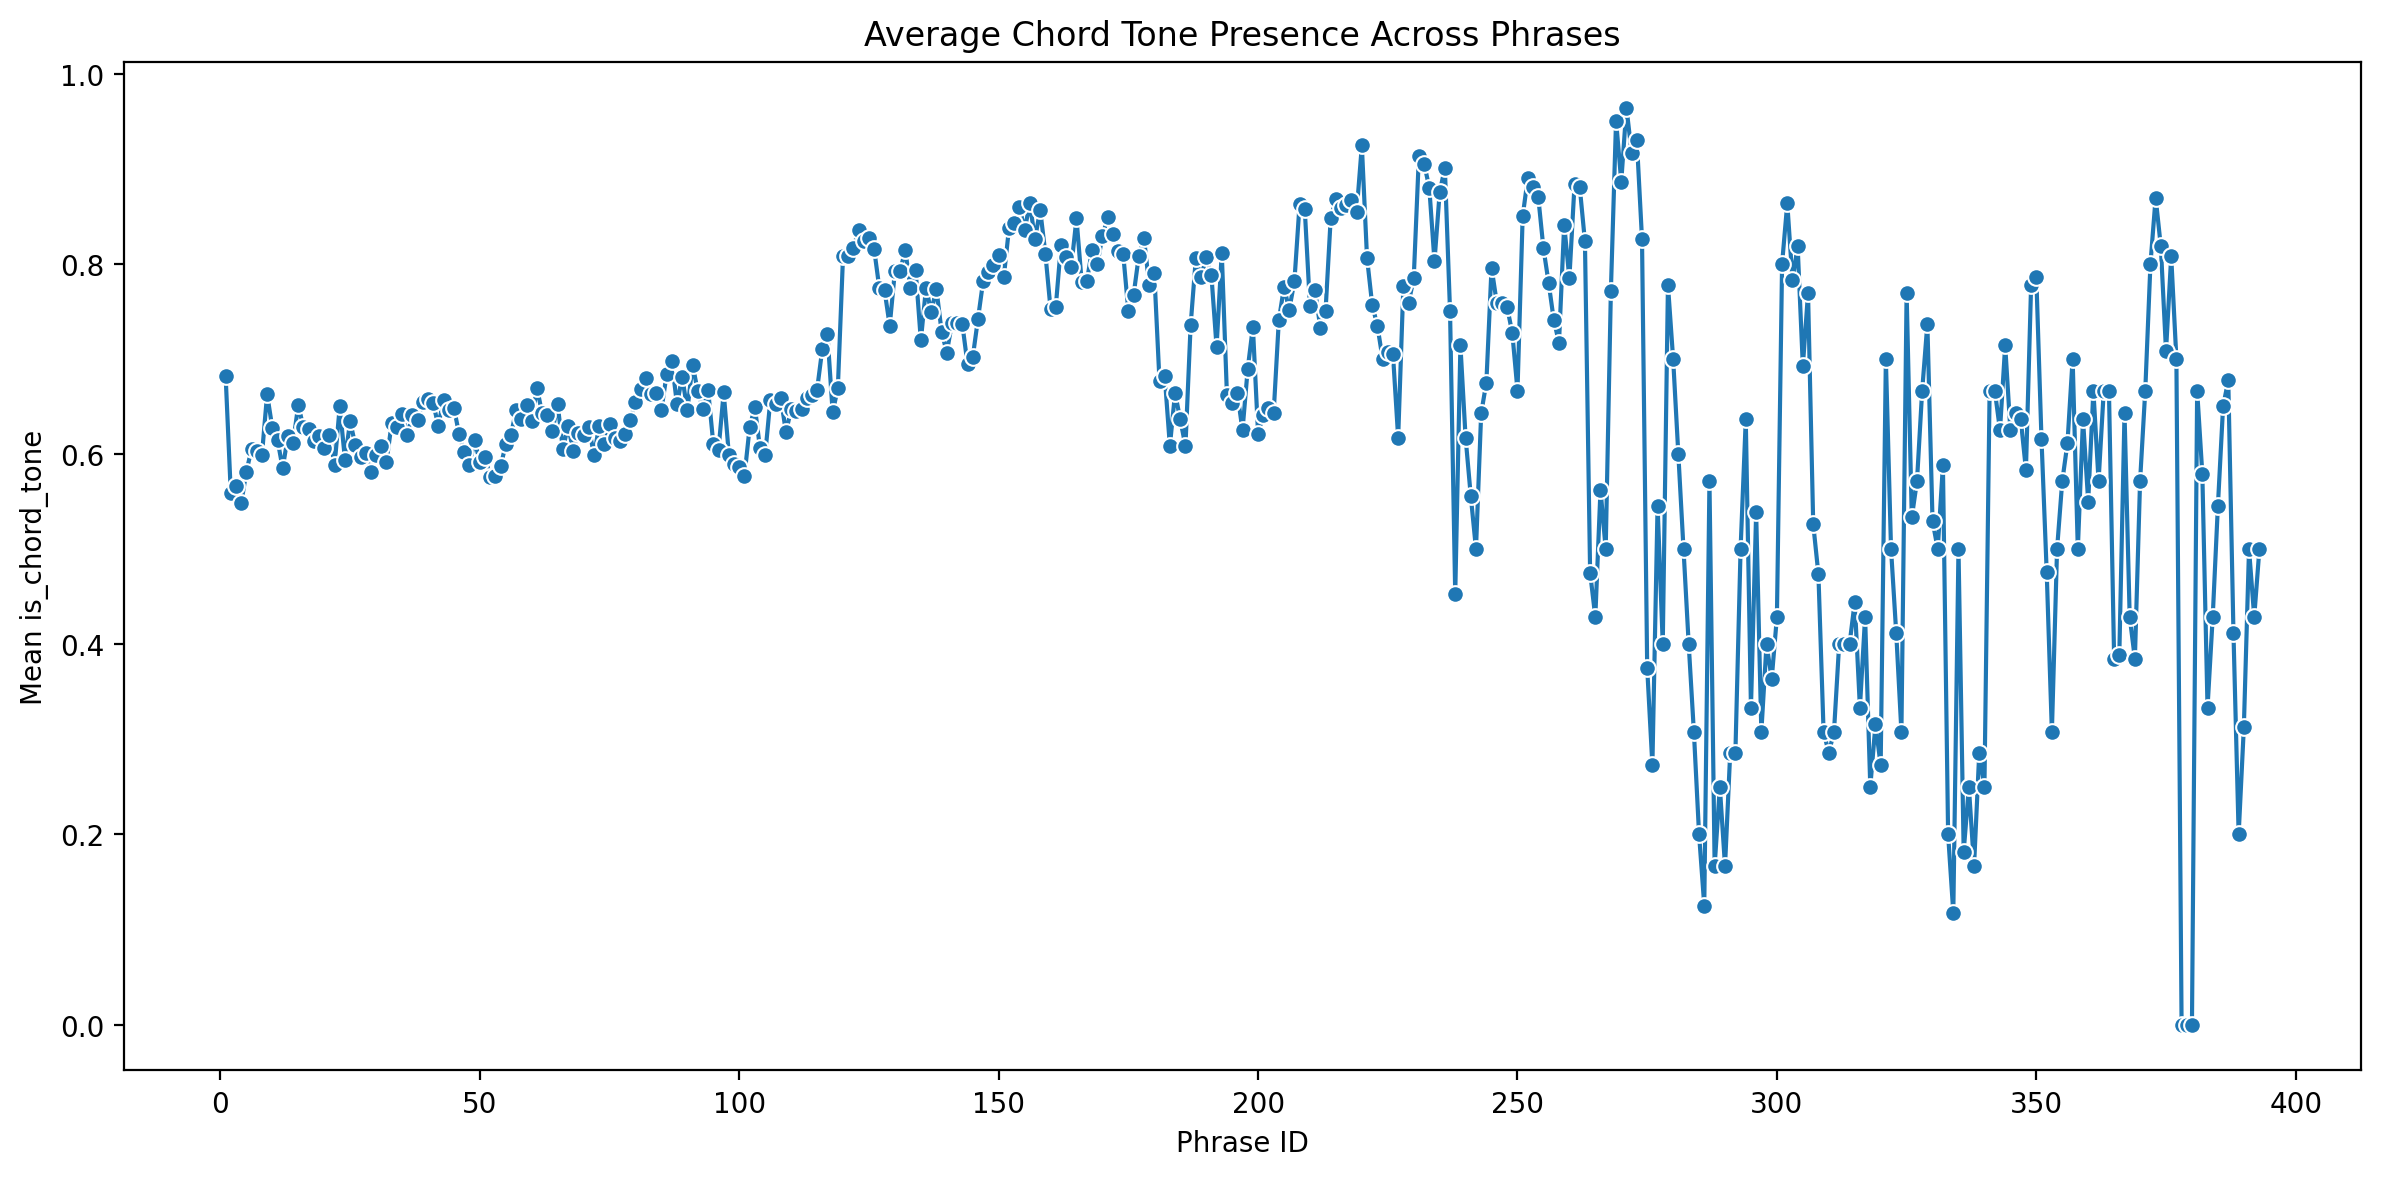

In [300]:
# Average chord tone presence per phrase (can also replace 'phrase_id' with 'measure')
chord_tone_by_phrase = df.groupby("phrase_id")["is_chord_tone"].mean().reset_index()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=chord_tone_by_phrase, x="phrase_id", y="is_chord_tone", marker="o")
plt.title("Average Chord Tone Presence Across Phrases")
plt.xlabel("Phrase ID")
plt.ylabel("Mean is_chord_tone")
plt.tight_layout()
plt.show()

##### 2.3.8.4 Relationship Between Chord Tones and Polyphony

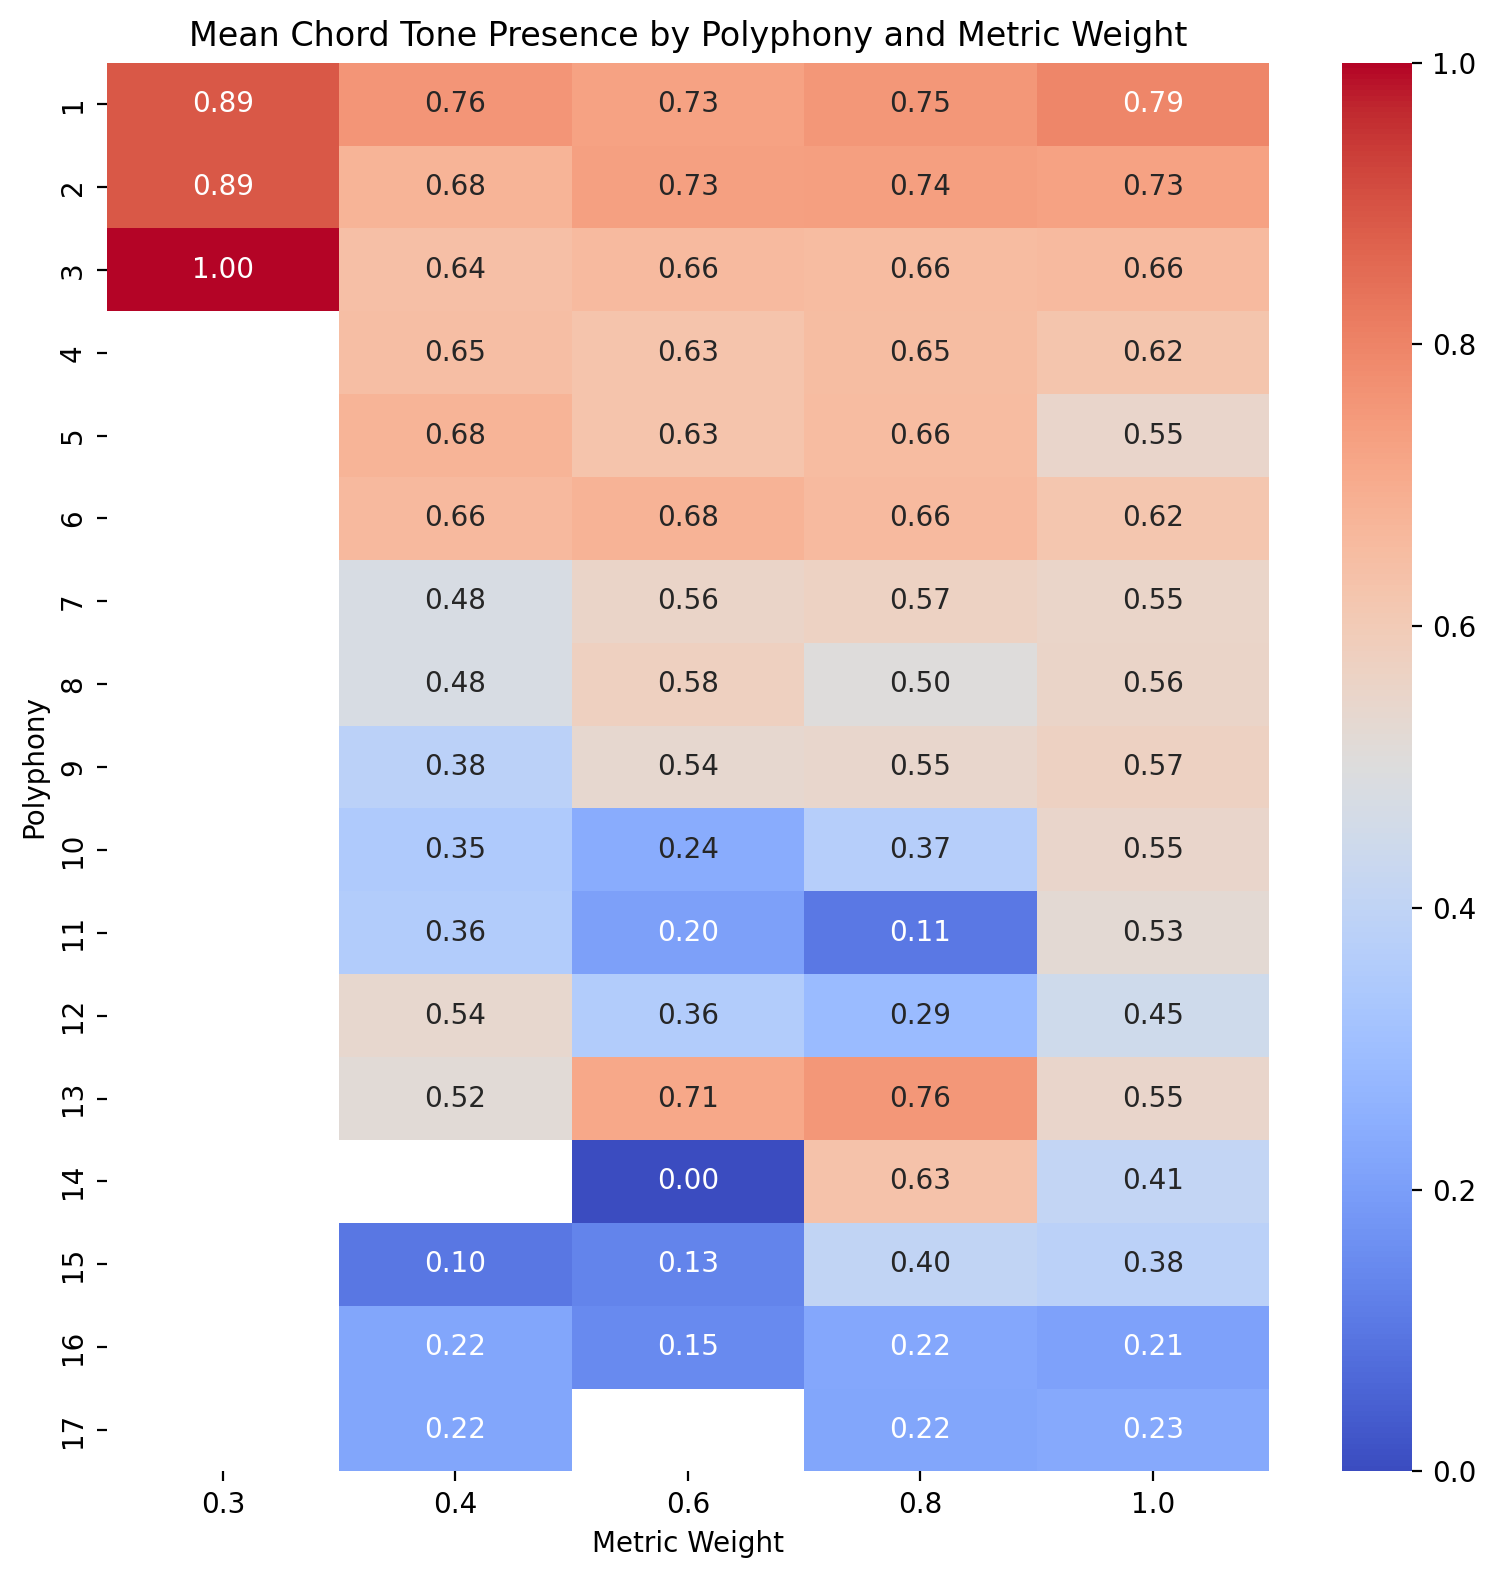

In [286]:
# Create a heatmap showing mean chord tone by polyphony and metric weight
chord_tones_pivot = df.pivot_table(values='is_chord_tone', index='polyphony', columns='metric_weight', aggfunc='mean')

# Plot
plt.figure(figsize=(8, 8))
sns.heatmap(chord_tones_pivot, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Mean Chord Tone Presence by Polyphony and Metric Weight")
plt.xlabel("Metric Weight")
plt.ylabel("Polyphony")
plt.tight_layout()
plt.show()

##### 2.3.8.5 Instruments with Highest Chord Tone Proportion

Top 10 instruments with highest chord tone proportion:
instrument
Contrabass          0.972077
StringInstrument    0.925944
Ocarina             0.860870
Fretless Bass       0.842370
Voice               0.801913
Electric Bass       0.769706
Bagpipes            0.752929
Choir               0.717158
Piano               0.695654
Violoncello         0.688889
Name: is_chord_tone, dtype: float64


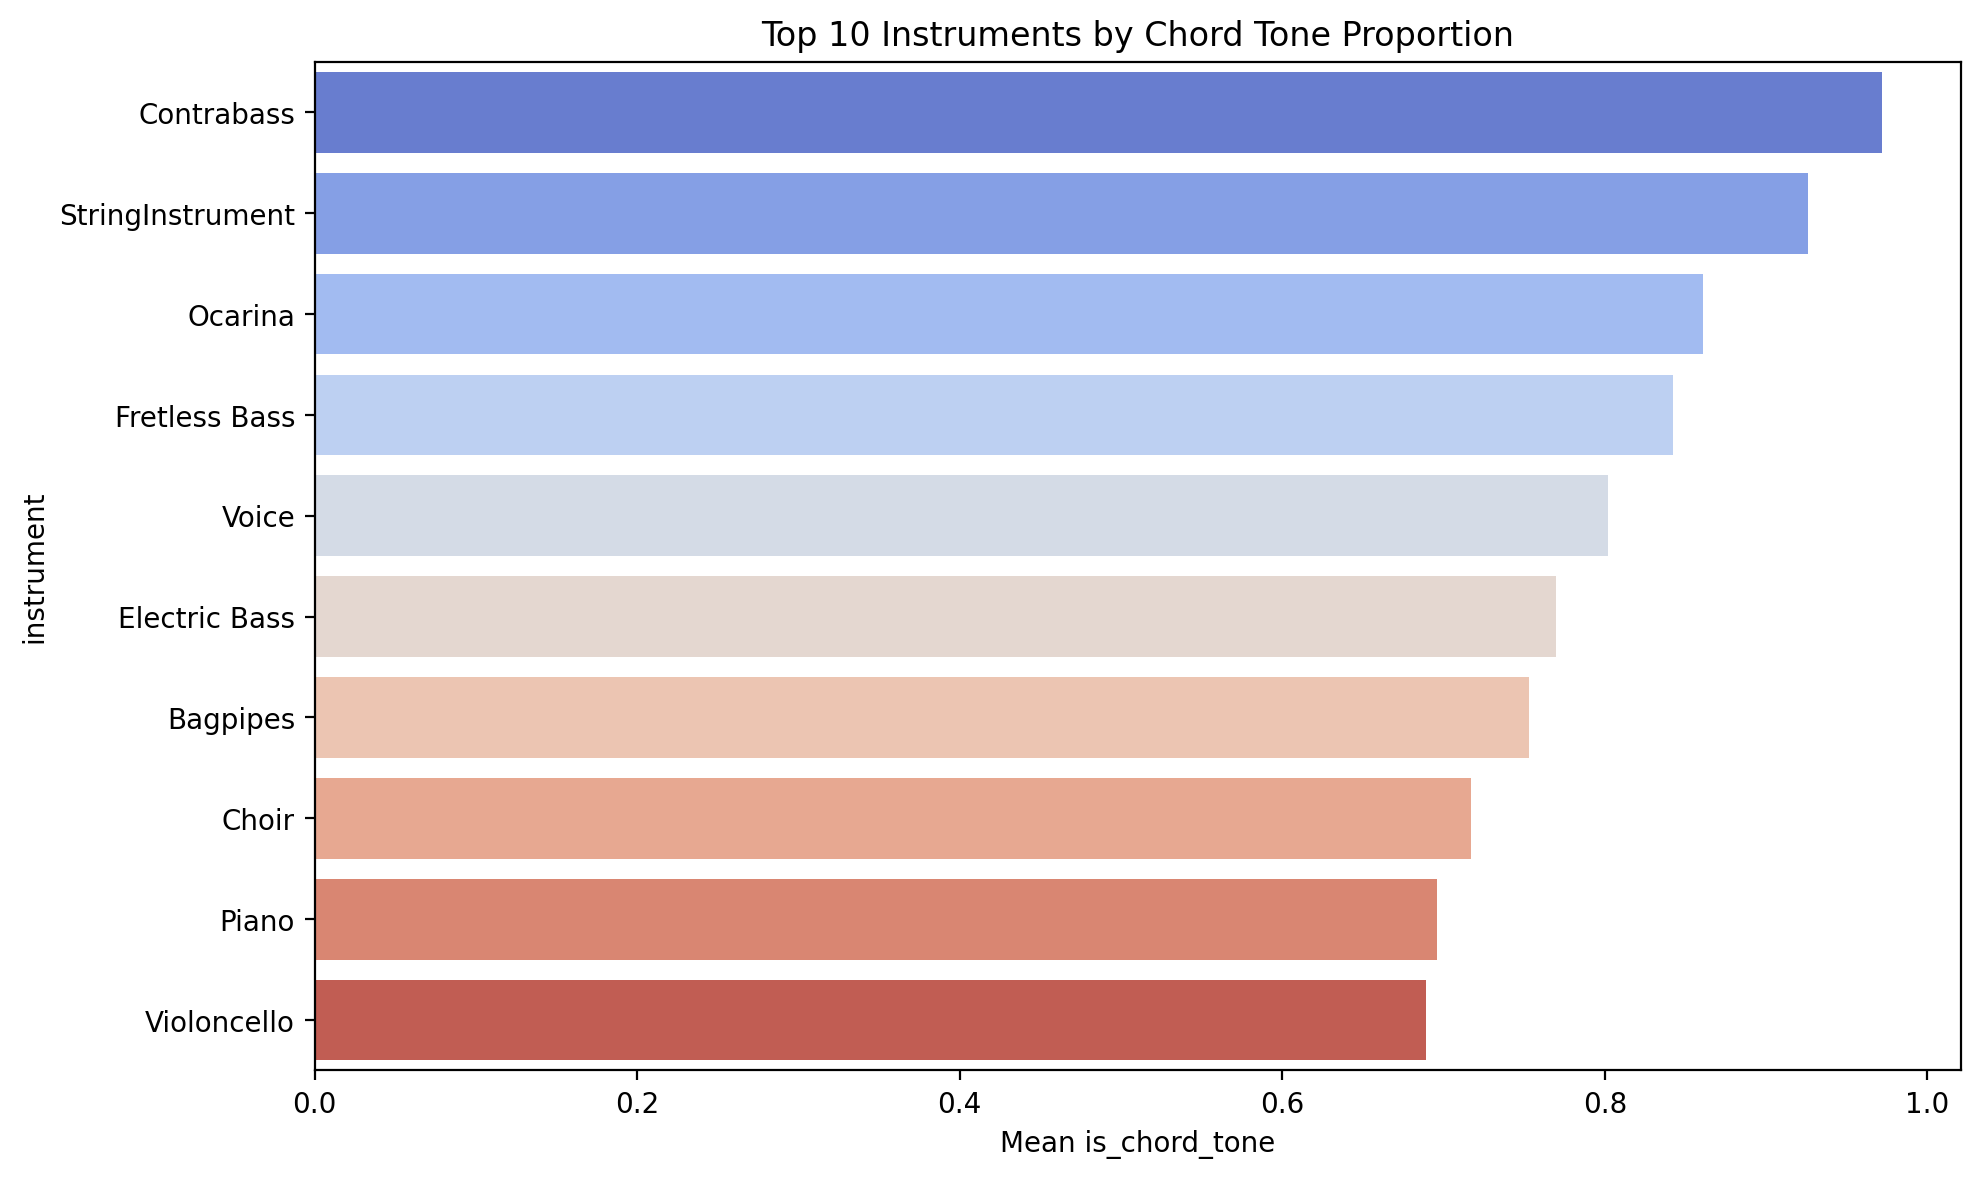

In [295]:
# Top 10 instruments by chord tone proportion
top_instruments = df.groupby("instrument")["is_chord_tone"].mean().sort_values(ascending=False).head(10)
print("Top 10 instruments with highest chord tone proportion:")
print(top_instruments)

# Barplot (optional)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_instruments.values, y=top_instruments.index, palette="coolwarm")
plt.xlabel("Mean is_chord_tone")
plt.title("Top 10 Instruments by Chord Tone Proportion")
plt.tight_layout()
plt.show()

##### 2.3.8.6 Genres with Highest Chord Tone Proportion

Top 10 genres with highest chord tone proportion:
genre
reggae       0.827116
classical    0.770412
soul         0.732557
rap          0.726076
country      0.697284
new_age      0.686293
pop          0.684324
disco        0.661757
dance        0.621852
rnb          0.617489
Name: is_chord_tone, dtype: float64


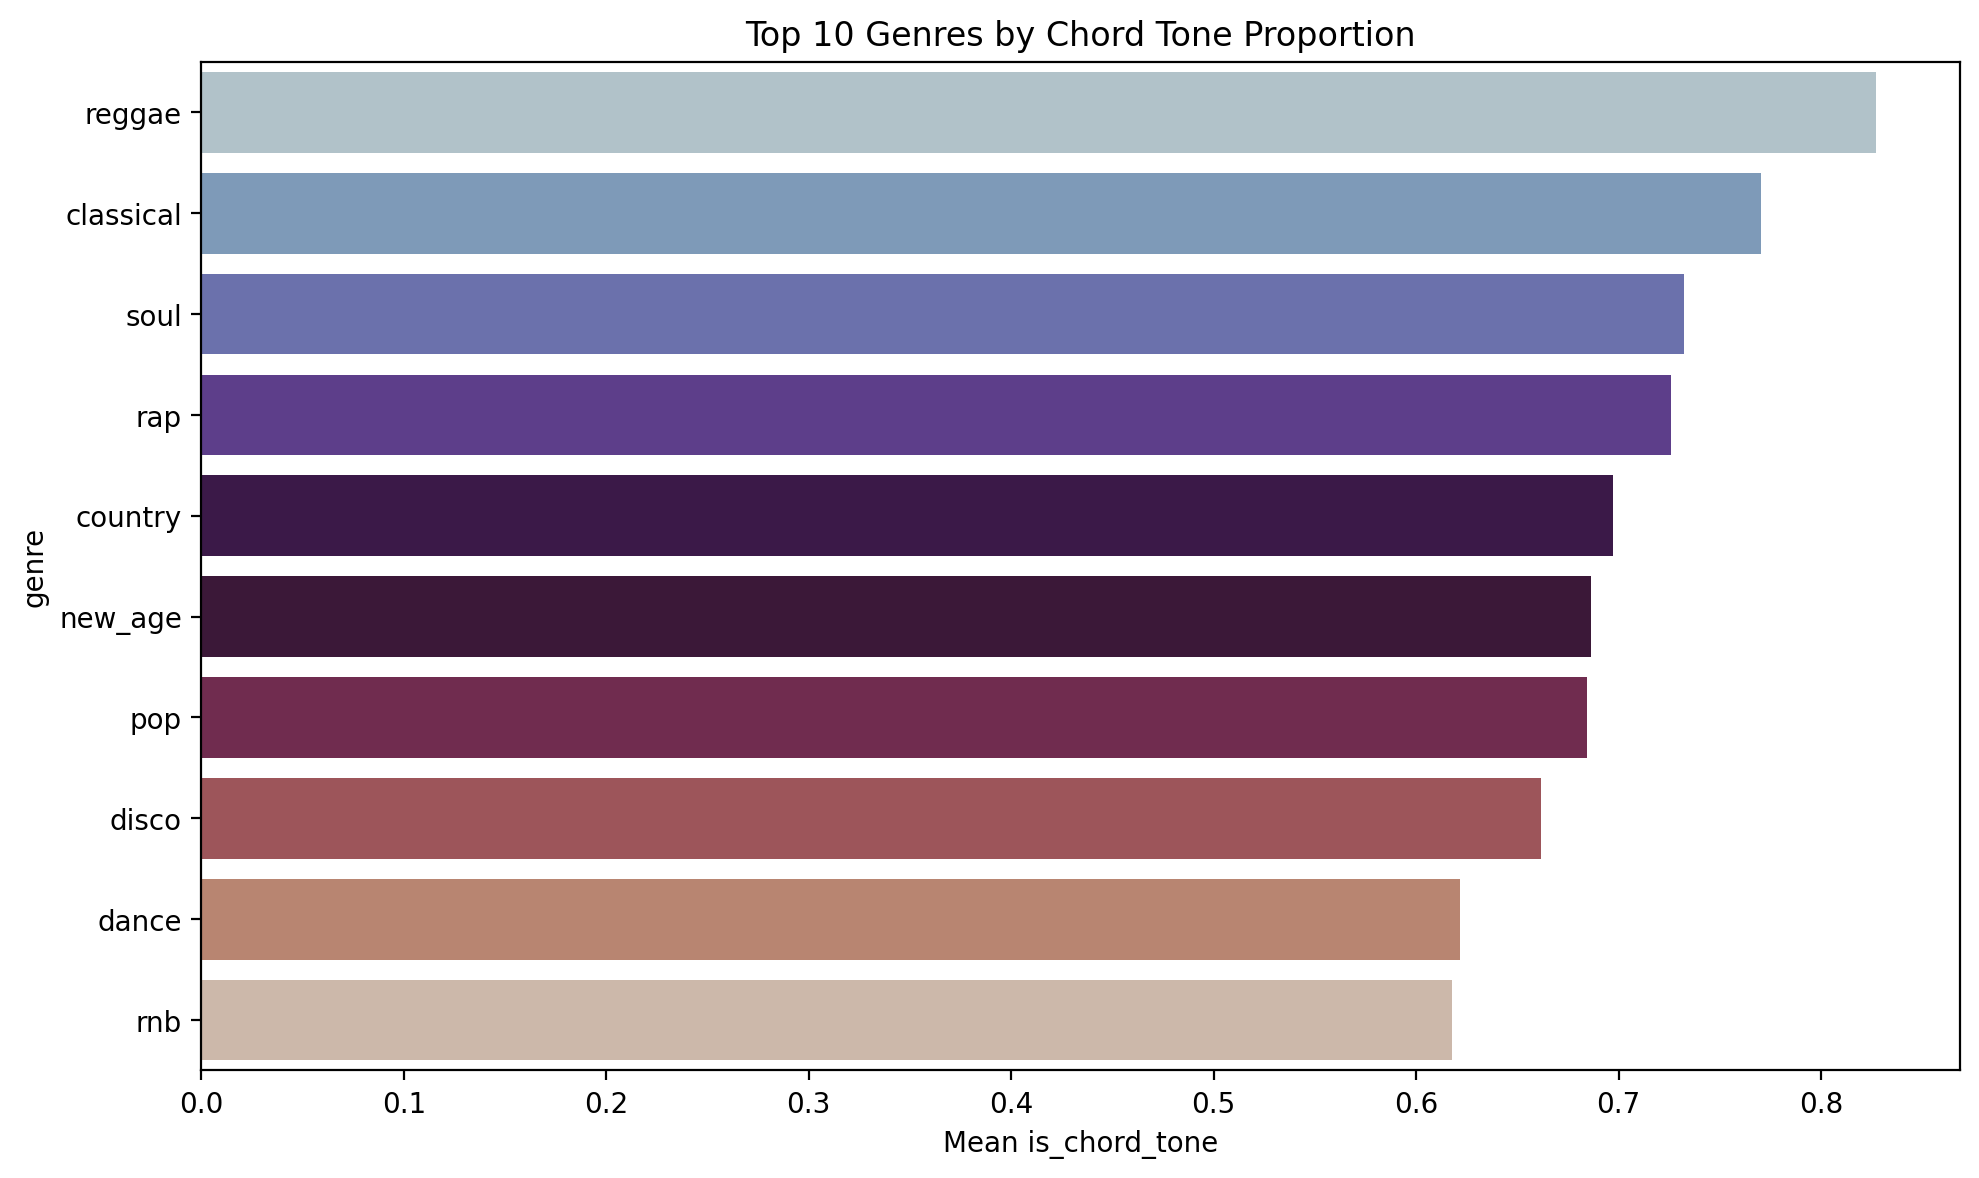

In [296]:
# Top 10 genres by chord tone proportion
top_genres = df.groupby("genre")["is_chord_tone"].mean().sort_values(ascending=False).head(10)
print("Top 10 genres with highest chord tone proportion:")
print(top_genres)

# Barplot (optional)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette="twilight")
plt.xlabel("Mean is_chord_tone")
plt.title("Top 10 Genres by Chord Tone Proportion")
plt.tight_layout()
plt.show()

### 3. Venv

In [22]:
# source .venv/bin/activate

In [256]:
list(df.keys())

['pitch',
 'pitch_class',
 'pitch_octave',
 'onset',
 'duration',
 'interval_to_prev',
 'polyphony',
 'is_chord_tone',
 'key',
 'local_key',
 'time_signature',
 'measure',
 'beat_position',
 'beat_fraction',
 'metric_weight',
 'articulation_ratio',
 'instrument',
 'instrument_family',
 'track',
 'velocity',
 'is_rest',
 'phrase_id',
 'genre',
 'filename',
 'is_outlier_pitch',
 'scaled_pitch',
 'pitch_class_name']